<a href="https://colab.research.google.com/github/geetha1811/project/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

zip_path = "/content/Images.zip"  # Update this if needed
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [2]:
import os
print(os.listdir("/content/Images")[:10])  # List first 10 files



['3541162969_68fa4a60df.jpg', '437527058_189f2a7eef.jpg', '504385521_6e668691a3.jpg', '310728631_155c3bbeea.jpg', '3171651115_e07b9d08f6.jpg', '1222322358_225067636e.jpg', '3540416139_c884f38351.jpg', '2286823363_7d554ea740.jpg', '3147913471_322ea231d9.jpg', '3383545083_1d7c95b003.jpg']


In [3]:
import pandas as pd

captions_path = "/content/captions.txt"  # Update path if needed
df = pd.read_csv(captions_path)

print(df.head())  # Display first few rows to check data


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [4]:
#Import all the required libraries


!pip install wordcloud
!pip install gtts
!pip install playsound

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
#used for creating Progress Meters or Progress Bars
from tqdm import tqdm


  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=ccc0c4b3888f2f95bdcc5fd4509498b9e4c97d606b8a6b228da61aed60ce23f1
  Stored in directory: /root/.cache/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound


In [5]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [6]:
import numpy as np
import pandas as pd
import os

# List the uploaded dataset files
dataset_path = "/content"  # Change if your files are extracted elsewhere
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/Images.zip
/content/captions.txt
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/active_config
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_survey_prompt.yaml
/content/.config/default_configs.db
/content/.config/config_sentinel
/content/.config/configurations/config_default
/content/.config/logs/2025.02.21/14.20.53.860402.log
/content/.config/logs/2025.02.21/14.20.22.790589.log
/content/.config/logs/2025.02.21/14.21.02.502663.log
/content/.config/logs/2025.02.21/14.20.52.640451.log
/content/.config/logs/2025.02.21/14.20.44.494684.log
/content/.config/logs/2025.02.21/14.21.03.186984.log
/content/Images/3541162969_68fa4a60df.jpg
/content/Images/437527058_189f2a7eef.jpg
/content/Images/504385521_6e668691a3.jpg
/content/Images/310728631_155c3bbeea.jpg
/content/Images/3171651115_e07b9d08f6.jpg
/content/Images/1222322358_225067636e.jpg
/content/Images/35

In [7]:
import glob

# Define the path where your images are extracted
images = "/content/Images"  # Update this if your folder name is different

# Get all image files
all_imgs = glob.glob(images + '/*.jpg', recursive=True)

print("The total images present in the dataset: {}".format(len(all_imgs)))


The total images present in the dataset: 8091


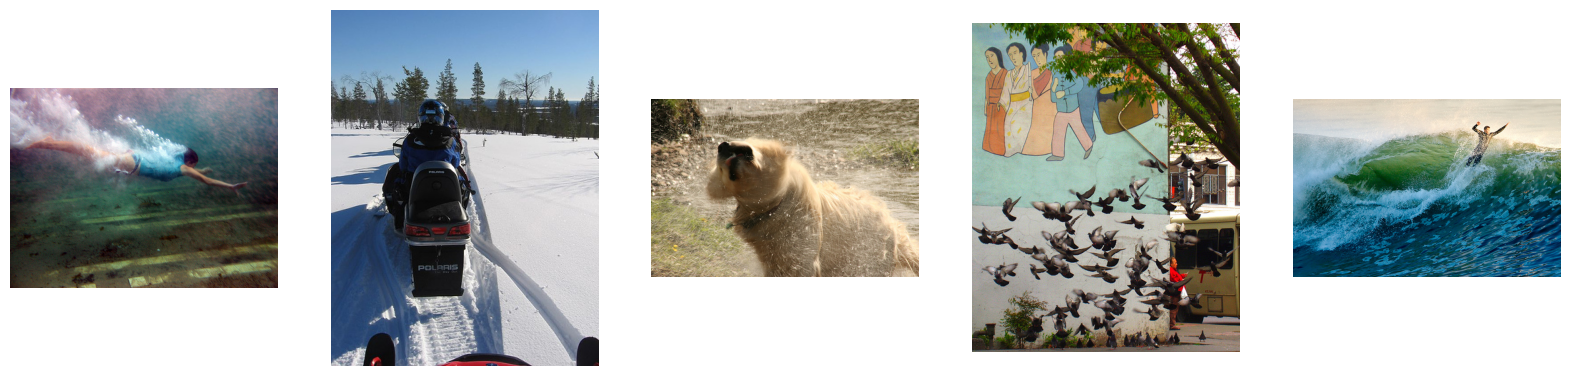

In [8]:
import imageio.v2 as imageio  # Ensure compatibility
import matplotlib.pyplot as plt

# Select the first 5 images from the dataset
Display_Images = all_imgs[:5]

# Create a figure with 5 subplots
figure, axes = plt.subplots(1, 5, figsize=(20, 5))

# Loop through selected images and display them
for ax, image_path in zip(axes, Display_Images):
    img = imageio.imread(image_path)  # Read the image properly
    ax.imshow(img)  # Display image
    ax.axis("off")  # Hide axes for better visualization

plt.show()  # Show the images


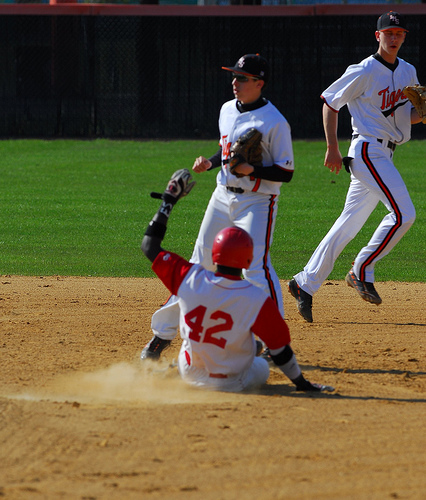

In [9]:
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])# view a random image
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [10]:
text_file = '/content/captions.txt'  # Update path based on your extracted location

def load_doc(filename):
    with open(filename, 'r', encoding='latin-1') as open_file:
        text = open_file.read()  # Read content
    return text

doc = load_doc(text_file)
print(doc[:300])  # Display first 300 characters


image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [12]:
img_path = '/content/Images/'  # Update the path to your extracted Images folder

all_img_id = []
all_img_vector = []
annotations = []

with open('/content/captions.txt', 'r', encoding='latin-1') as fo:  # Update the path
    next(fo)  # Skip the header
    for line in fo:
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.'))  # Removing newline and period
        all_img_vector.append(img_path + split_arr[0])

# Create a DataFrame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)), columns=['ID', 'Path', 'Captions'])

df.head()  # Display the first few rows


ID                                       Path  \
0  1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  /content/Images/1000268201_693b08cb0e.jpg   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building   
2    A little girl climbing into a wooden playhouse   
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [13]:
#check total captions and images present in dataset
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [14]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

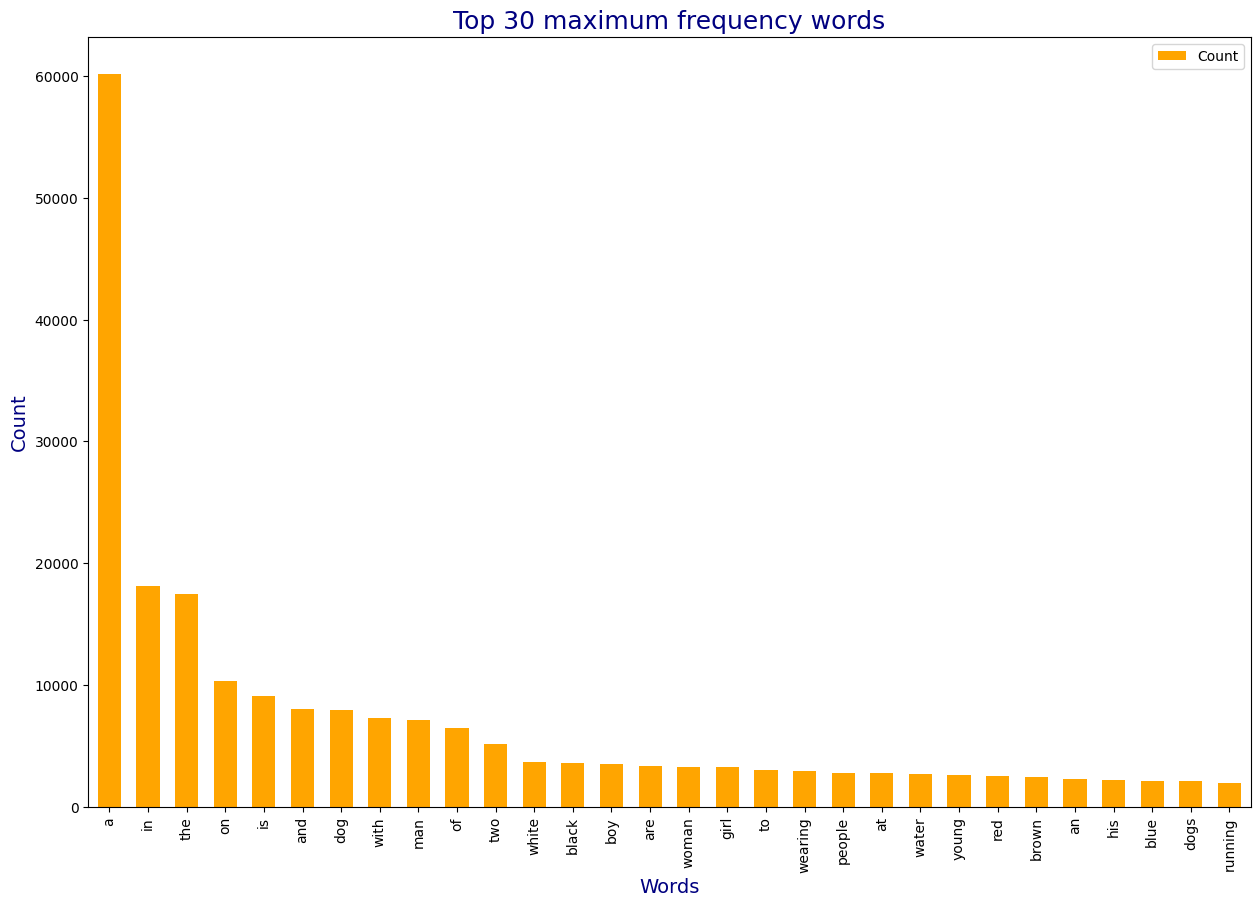

In [15]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')

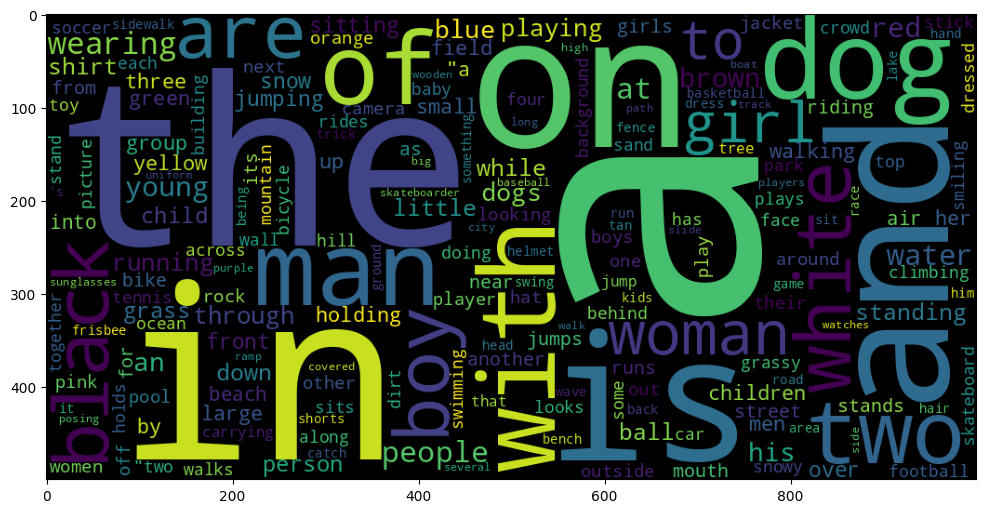

In [16]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

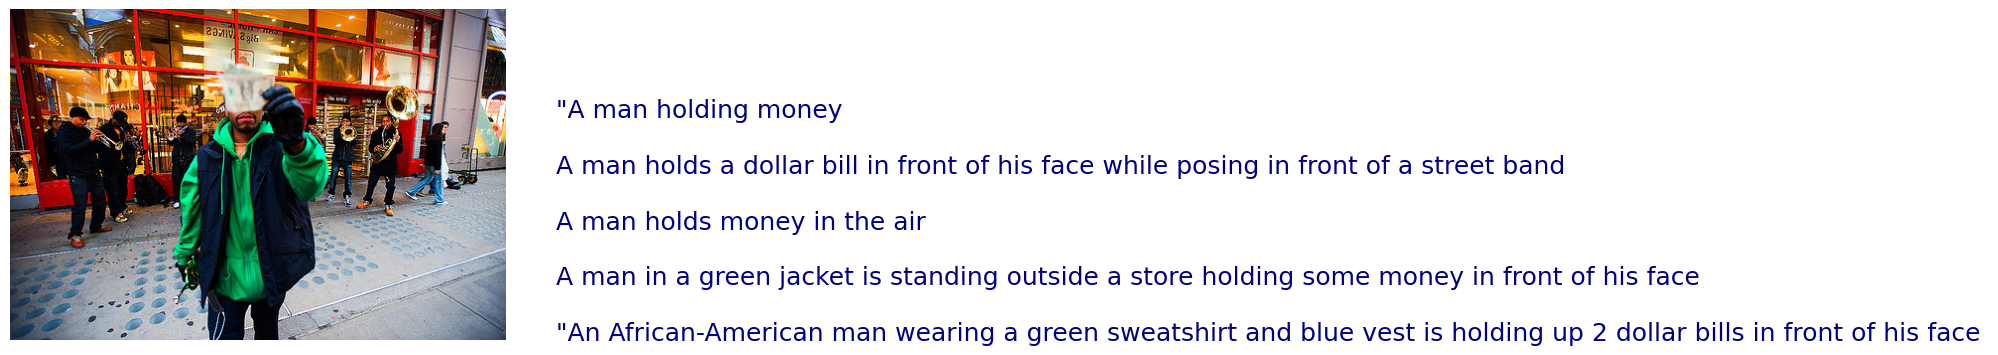

In [17]:
def caption_with_img_plot(image_id, frame) :
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[8049], df)

In [18]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)

In [19]:
#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [20]:
##list contatining captions for an image
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [21]:
# Creating the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False,
                      oov_token = 'UNK')

In [22]:
# Creating word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations)
#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

In [23]:
# We add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [24]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [25]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [26]:
# Creating a word count for our tokenizer to visualize the Top 30 occuring words after text processing

tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)

<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


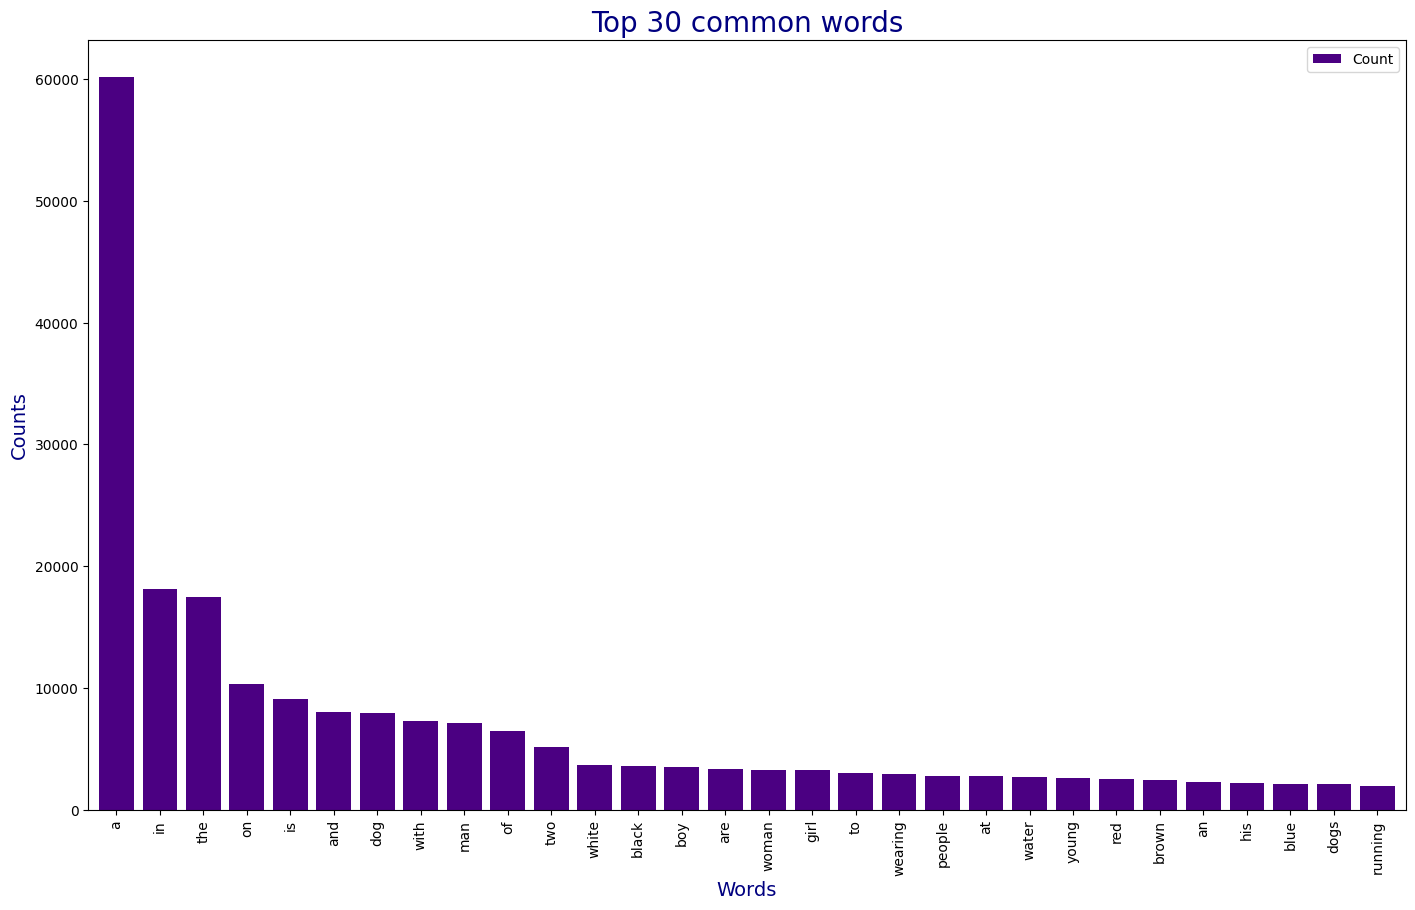

In [27]:
for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'indigo', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')
plt.grid(False)  # Disable the grid explicitly


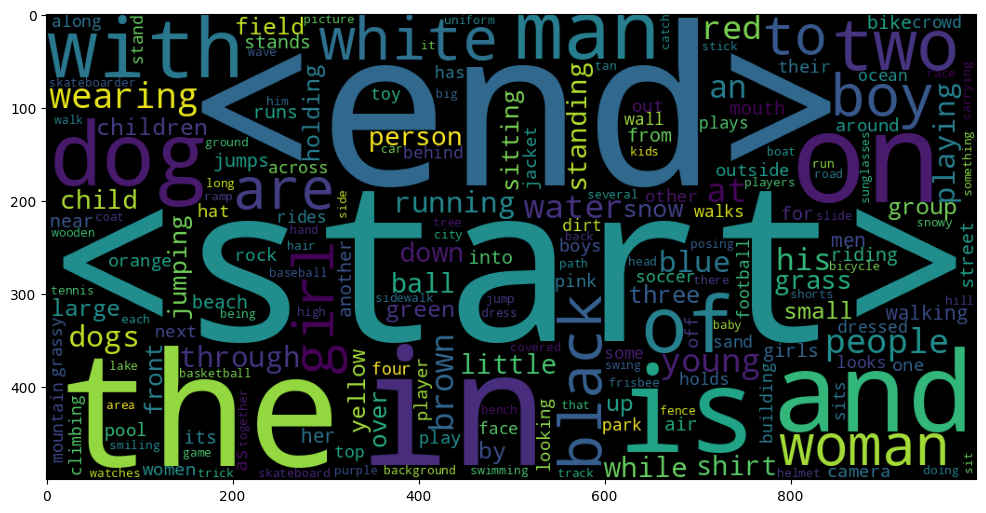

In [28]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_token)
plt.grid(False)  # Disable the grid explicitly


In [29]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


In [30]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (299, 299)

In [31]:
#checking image format

tf.keras.backend.image_data_format()

'channels_last'

In [32]:
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preprocessed_image.append(img)


Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


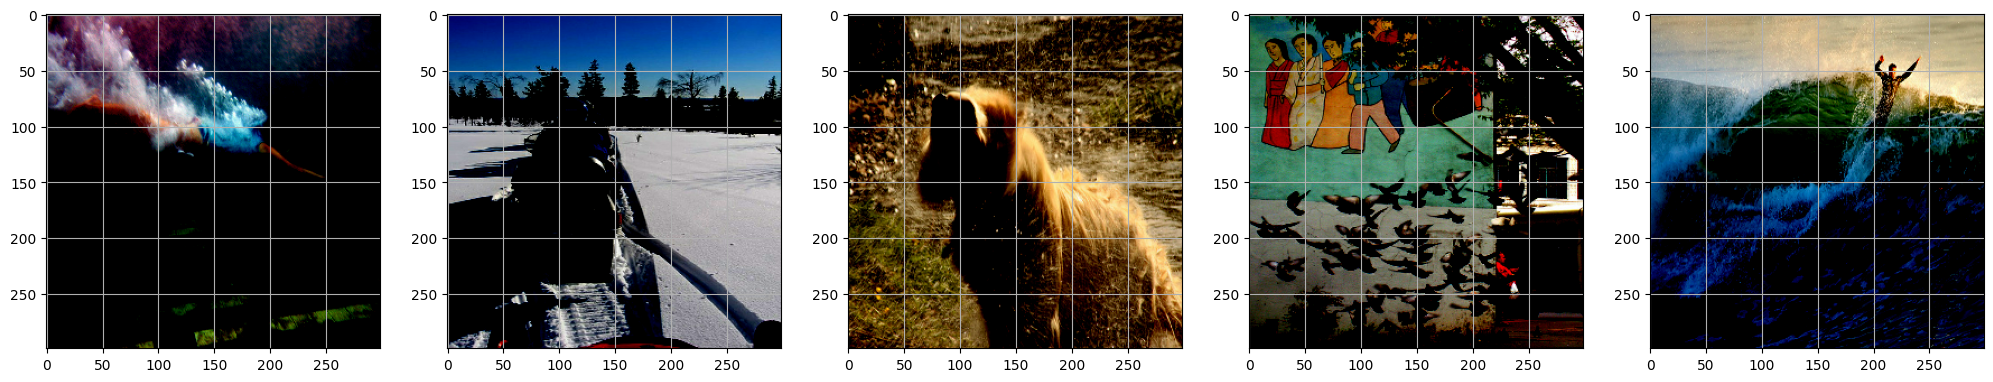

In [33]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

In [34]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [35]:
all_img_vector

['/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1000268201_693b08cb0e.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1001773457_577c3a7d70.jpg',
 '/content/Images/1002674143_1b742ab4b8.jpg',
 '/content/Images/1002674143_1b742ab4b8.jpg',
 '/content/Images/1002674143_1b742ab4b8.jpg',
 '/content/Images/1002674143_1b742ab4b8.jpg',
 '/content/Images/1002674143_1b742ab4b8.jpg',
 '/content/Images/1003163366_44323f5815.jpg',
 '/content/Images/1003163366_44323f5815.jpg',
 '/content/Images/1003163366_44323f5815.jpg',
 '/content/Images/1003163366_44323f5815.jpg',
 '/content/Images/1003163366_44323f5815.jpg',
 '/content/Images/1007129816_e794419615.jpg',
 '/content/Images/1007129816_e7944

In [36]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(all_img_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [37]:
#Ratio = 80:20 and we will set random state = 42
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [38]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [39]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [40]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [41]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: []


In [42]:
from tqdm import tqdm
import glob
import tensorflow as tf
import numpy as np

# Define image folder path
image_folder = "/content/Images"
New_Img = glob.glob(image_folder + "/*.jpg")

# Load InceptionV3 model (only needed once)
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet'
)
image_features_extract_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

# Convert image list into a TensorFlow dataset (efficient loading)
BATCH_SIZE = 32  # Increase batch size for faster processing
AUTOTUNE = tf.data.AUTOTUNE  # Optimize performance

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

# Create dataset
image_ds = tf.data.Dataset.from_tensor_slices(New_Img)
image_ds = image_ds.map(load_image, num_parallel_calls=AUTOTUNE)  # Load in parallel
image_ds = image_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # Batch processing

# Extract features in batches
img_features = {}

for batch_images, batch_paths in tqdm(image_ds):
    batch_features = image_features_extract_model(batch_images)
    batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for feature, path in zip(batch_features_flattened.numpy(), batch_paths.numpy()):
        img_features[path.decode('utf-8')] = feature  # Store features

print("Feature extraction complete! Total images processed:", len(img_features))


100%|██████████| 253/253 [24:22<00:00,  5.78s/it]

Feature extraction complete! Total images processed: 8091


In [43]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 3.63049299e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.24125838e-01, 7.01276734e-02],
         [0.00000000e+00, 3.71178478e-01, 2.29467303e-02, ...,
          0.00000000e+00, 1.16523397e+00, 9.50720012e-02],
         ...,
         [0.00000000e+00, 2.68067926e-01, 0.00000000e+00, ...,
          8.19388747e-01, 1.03865147e+00, 4.78500813e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          8.39349866e-01, 1.66556299e-01, 0.00000000e+00],
         [0.00000000e+00, 7.23729849e-01, 0.00000000e+00, ...,
          8.52311730e-01, 0.00000000e+00, 0.00000000e+00]],

        [[3.60664427e-02, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 5.62602758e-01, 1.19006097e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [44]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.3630493 , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.62412584, 0.07012767],
        [0.        , 0.37117848, 0.02294673, ..., 0.        ,
         1.165234  , 0.095072  ],
        ...,
        [1.4655337 , 0.55842716, 0.48834634, ..., 0.        ,
         0.6017544 , 0.05995543],
        [1.9269086 , 0.20980287, 0.1572142 , ..., 0.        ,
         0.1204028 , 0.        ],
        [0.09024219, 0.01466476, 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.63202596, 0.3455605 , ..., 0.        ,
         2.9914348 , 0.7721057 ],
        [0.04448713, 0.        , 0.14531934, ..., 0.        ,
         2.884815  , 0.6359582 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         2.506584  , 0.96417665],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [45]:
for image_path in tqdm(New_Img):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    batch_features = image_features_extract_model(tf.expand_dims(image, axis=0))
    batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for batch_feat in batch_features_flattened:
        print("Shape of batch_feat:", batch_feat.shape)  # Print the shape inside the loop

    img_features[image_path] = batch_features_flattened.numpy()


  0%|          | 1/8091 [00:00<1:27:22,  1.54it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 2/8091 [00:01<1:25:45,  1.57it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 3/8091 [00:01<1:29:01,  1.51it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 4/8091 [00:02<1:25:36,  1.57it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 5/8091 [00:03<1:16:20,  1.77it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 6/8091 [00:03<1:09:58,  1.93it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 7/8091 [00:03<1:06:13,  2.03it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 8/8091 [00:04<1:04:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 9/8091 [00:04<1:03:16,  2.13it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 10/8091 [00:05<1:01:47,  2.18it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 11/8091 [00:05<1:00:11,  2.24it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 12/8091 [00:06<58:46,  2.29it/s]  

Shape of batch_feat: (64, 2048)


  0%|          | 13/8091 [00:06<59:12,  2.27it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 14/8091 [00:06<59:56,  2.25it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 15/8091 [00:07<58:18,  2.31it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 16/8091 [00:07<57:05,  2.36it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 17/8091 [00:08<56:36,  2.38it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 18/8091 [00:08<57:14,  2.35it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 19/8091 [00:09<56:38,  2.38it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 20/8091 [00:09<55:27,  2.43it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 21/8091 [00:09<55:49,  2.41it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 22/8091 [00:10<55:24,  2.43it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 23/8091 [00:10<55:50,  2.41it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 24/8091 [00:11<56:30,  2.38it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 25/8091 [00:11<57:05,  2.35it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 26/8091 [00:11<56:58,  2.36it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 27/8091 [00:12<1:00:01,  2.24it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 28/8091 [00:13<1:07:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 29/8091 [00:13<1:14:54,  1.79it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 30/8091 [00:14<1:13:57,  1.82it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 31/8091 [00:14<1:08:53,  1.95it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 32/8091 [00:15<1:06:08,  2.03it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 33/8091 [00:15<1:04:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 34/8091 [00:16<1:02:43,  2.14it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 35/8091 [00:16<1:01:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 36/8091 [00:16<1:02:11,  2.16it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 37/8091 [00:17<1:00:04,  2.23it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 38/8091 [00:17<59:23,  2.26it/s]  

Shape of batch_feat: (64, 2048)


  0%|          | 39/8091 [00:18<59:08,  2.27it/s]

Shape of batch_feat: (64, 2048)


  0%|          | 40/8091 [00:18<59:00,  2.27it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 41/8091 [00:19<58:20,  2.30it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 42/8091 [00:19<57:59,  2.31it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 43/8091 [00:19<57:22,  2.34it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 44/8091 [00:20<57:50,  2.32it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 45/8091 [00:20<58:34,  2.29it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 46/8091 [00:21<57:33,  2.33it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 47/8091 [00:21<56:07,  2.39it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 48/8091 [00:22<56:56,  2.35it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 49/8091 [00:22<56:21,  2.38it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 50/8091 [00:22<56:23,  2.38it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 51/8091 [00:23<57:03,  2.35it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 52/8091 [00:23<58:01,  2.31it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 53/8091 [00:24<1:04:53,  2.06it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 54/8091 [00:25<1:14:38,  1.79it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 55/8091 [00:25<1:20:27,  1.66it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 56/8091 [00:26<1:13:35,  1.82it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 57/8091 [00:26<1:08:55,  1.94it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 58/8091 [00:27<1:06:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 59/8091 [00:27<1:04:03,  2.09it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 60/8091 [00:28<1:01:55,  2.16it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 61/8091 [00:28<1:00:42,  2.20it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 62/8091 [00:28<1:00:38,  2.21it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 63/8091 [00:29<59:47,  2.24it/s]  

Shape of batch_feat: (64, 2048)


  1%|          | 64/8091 [00:29<59:25,  2.25it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 65/8091 [00:30<1:00:01,  2.23it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 66/8091 [00:30<59:06,  2.26it/s]  

Shape of batch_feat: (64, 2048)


  1%|          | 67/8091 [00:31<59:33,  2.25it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 68/8091 [00:31<59:40,  2.24it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 69/8091 [00:31<58:58,  2.27it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 70/8091 [00:32<59:48,  2.24it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 71/8091 [00:32<59:30,  2.25it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 72/8091 [00:33<59:50,  2.23it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 73/8091 [00:33<59:36,  2.24it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 74/8091 [00:34<59:33,  2.24it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 75/8091 [00:34<59:43,  2.24it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 76/8091 [00:35<1:00:24,  2.21it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 77/8091 [00:35<1:00:42,  2.20it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 78/8091 [00:36<1:07:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 79/8091 [00:36<1:15:42,  1.76it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 80/8091 [00:37<1:21:08,  1.65it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 81/8091 [00:38<1:15:37,  1.77it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 82/8091 [00:38<1:11:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 83/8091 [00:39<1:07:29,  1.98it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 84/8091 [00:39<1:05:38,  2.03it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 85/8091 [00:39<1:03:52,  2.09it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 86/8091 [00:40<1:03:10,  2.11it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 87/8091 [00:40<1:02:26,  2.14it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 88/8091 [00:41<1:01:42,  2.16it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 89/8091 [00:41<1:00:18,  2.21it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 90/8091 [00:42<59:32,  2.24it/s]  

Shape of batch_feat: (64, 2048)


  1%|          | 91/8091 [00:42<1:00:51,  2.19it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 92/8091 [00:43<59:22,  2.25it/s]  

Shape of batch_feat: (64, 2048)


  1%|          | 93/8091 [00:43<58:57,  2.26it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 94/8091 [00:43<58:36,  2.27it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 95/8091 [00:44<58:29,  2.28it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 96/8091 [00:44<58:17,  2.29it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 97/8091 [00:45<57:30,  2.32it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 98/8091 [00:45<57:16,  2.33it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 99/8091 [00:46<56:45,  2.35it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 100/8091 [00:46<57:17,  2.32it/s]

Shape of batch_feat: (64, 2048)


  1%|          | 101/8091 [00:46<58:01,  2.29it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 102/8091 [00:47<58:14,  2.29it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 103/8091 [00:47<1:04:50,  2.05it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 104/8091 [00:48<1:13:21,  1.81it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 105/8091 [00:49<1:16:57,  1.73it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 106/8091 [00:49<1:11:57,  1.85it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 107/8091 [00:50<1:08:21,  1.95it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 108/8091 [00:50<1:05:45,  2.02it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 109/8091 [00:51<1:04:19,  2.07it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 110/8091 [00:51<1:03:47,  2.09it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 111/8091 [00:52<1:02:29,  2.13it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 112/8091 [00:52<1:01:33,  2.16it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 113/8091 [00:52<1:01:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 114/8091 [00:53<59:33,  2.23it/s]  

Shape of batch_feat: (64, 2048)


  1%|▏         | 115/8091 [00:53<1:00:17,  2.20it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 116/8091 [00:54<1:01:09,  2.17it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 117/8091 [00:54<1:01:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 118/8091 [00:55<59:47,  2.22it/s]  

Shape of batch_feat: (64, 2048)


  1%|▏         | 119/8091 [00:55<58:52,  2.26it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 120/8091 [00:56<58:47,  2.26it/s]

Shape of batch_feat: (64, 2048)


  1%|▏         | 121/8091 [00:56<59:38,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 122/8091 [00:56<59:33,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 123/8091 [00:57<58:54,  2.25it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 124/8091 [00:57<59:31,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 125/8091 [00:58<59:25,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 126/8091 [00:58<59:23,  2.24it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 127/8091 [00:59<59:21,  2.24it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 128/8091 [00:59<1:08:28,  1.94it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 129/8091 [01:00<1:16:33,  1.73it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 130/8091 [01:01<1:18:25,  1.69it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 131/8091 [01:01<1:13:15,  1.81it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 132/8091 [01:02<1:09:35,  1.91it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 133/8091 [01:02<1:07:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 134/8091 [01:03<1:03:49,  2.08it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 135/8091 [01:03<1:03:01,  2.10it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 136/8091 [01:03<1:01:14,  2.17it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 137/8091 [01:04<59:26,  2.23it/s]  

Shape of batch_feat: (64, 2048)


  2%|▏         | 138/8091 [01:04<59:29,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 139/8091 [01:05<59:22,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 140/8091 [01:05<58:56,  2.25it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 141/8091 [01:06<59:15,  2.24it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 142/8091 [01:06<58:47,  2.25it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 143/8091 [01:07<58:11,  2.28it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 144/8091 [01:07<58:04,  2.28it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 145/8091 [01:07<57:52,  2.29it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 146/8091 [01:08<57:05,  2.32it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 147/8091 [01:08<57:28,  2.30it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 148/8091 [01:09<57:41,  2.29it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 149/8091 [01:09<1:08:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 150/8091 [01:10<1:04:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 151/8091 [01:10<1:02:51,  2.11it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 152/8091 [01:11<1:06:21,  1.99it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 153/8091 [01:12<1:14:21,  1.78it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 154/8091 [01:12<1:21:59,  1.61it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 155/8091 [01:13<1:15:09,  1.76it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 156/8091 [01:13<1:09:53,  1.89it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 157/8091 [01:14<1:05:51,  2.01it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 158/8091 [01:14<1:03:39,  2.08it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 159/8091 [01:14<1:02:19,  2.12it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 160/8091 [01:15<1:01:42,  2.14it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 161/8091 [01:15<1:01:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 162/8091 [01:16<1:01:09,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 163/8091 [01:16<1:00:56,  2.17it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 164/8091 [01:17<1:00:18,  2.19it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 165/8091 [01:17<1:01:03,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 166/8091 [01:18<1:00:47,  2.17it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 167/8091 [01:18<1:01:42,  2.14it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 168/8091 [01:19<1:01:16,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 169/8091 [01:19<1:01:45,  2.14it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 170/8091 [01:20<1:00:58,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 171/8091 [01:20<1:01:04,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 172/8091 [01:20<1:00:59,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 173/8091 [01:21<1:01:06,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 174/8091 [01:21<1:00:41,  2.17it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 175/8091 [01:22<1:00:11,  2.19it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 176/8091 [01:22<1:01:34,  2.14it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 177/8091 [01:23<1:10:29,  1.87it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 178/8091 [01:24<1:17:22,  1.70it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 179/8091 [01:24<1:17:18,  1.71it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 180/8091 [01:25<1:11:48,  1.84it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 181/8091 [01:25<1:08:58,  1.91it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 182/8091 [01:26<1:08:29,  1.92it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 183/8091 [01:26<1:06:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 184/8091 [01:27<1:03:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 185/8091 [01:27<1:02:15,  2.12it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 186/8091 [01:28<59:41,  2.21it/s]  

Shape of batch_feat: (64, 2048)


  2%|▏         | 187/8091 [01:28<59:36,  2.21it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 188/8091 [01:28<1:00:25,  2.18it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 189/8091 [01:29<59:06,  2.23it/s]  

Shape of batch_feat: (64, 2048)


  2%|▏         | 190/8091 [01:29<59:02,  2.23it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 191/8091 [01:30<57:09,  2.30it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 192/8091 [01:30<57:26,  2.29it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 193/8091 [01:31<57:49,  2.28it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 194/8091 [01:31<57:26,  2.29it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 195/8091 [01:32<59:52,  2.20it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 196/8091 [01:32<1:00:33,  2.17it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 197/8091 [01:32<1:00:51,  2.16it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 198/8091 [01:33<59:59,  2.19it/s]  

Shape of batch_feat: (64, 2048)


  2%|▏         | 199/8091 [01:33<1:00:00,  2.19it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 200/8091 [01:34<1:00:06,  2.19it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 201/8091 [01:34<1:07:19,  1.95it/s]

Shape of batch_feat: (64, 2048)


  2%|▏         | 202/8091 [01:35<1:15:18,  1.75it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 203/8091 [01:36<1:18:20,  1.68it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 204/8091 [01:36<1:14:08,  1.77it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 205/8091 [01:37<1:09:32,  1.89it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 206/8091 [01:37<1:06:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 207/8091 [01:38<1:04:42,  2.03it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 208/8091 [01:38<1:03:38,  2.06it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 209/8091 [01:39<1:01:44,  2.13it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 210/8091 [01:39<1:01:20,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 211/8091 [01:40<1:01:29,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 212/8091 [01:40<59:52,  2.19it/s]  

Shape of batch_feat: (64, 2048)


  3%|▎         | 213/8091 [01:40<1:00:00,  2.19it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 214/8091 [01:41<1:00:23,  2.17it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 215/8091 [01:41<1:00:22,  2.17it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 216/8091 [01:42<59:24,  2.21it/s]  

Shape of batch_feat: (64, 2048)


  3%|▎         | 217/8091 [01:42<59:14,  2.22it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 218/8091 [01:43<1:00:59,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 219/8091 [01:43<1:01:08,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 220/8091 [01:44<1:01:22,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 221/8091 [01:44<1:01:08,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 222/8091 [01:45<1:01:20,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 223/8091 [01:45<1:01:11,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 224/8091 [01:45<1:00:26,  2.17it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 225/8091 [01:46<1:04:39,  2.03it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 226/8091 [01:47<1:12:56,  1.80it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 227/8091 [01:47<1:19:43,  1.64it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 228/8091 [01:48<1:12:55,  1.80it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 229/8091 [01:48<1:09:29,  1.89it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 230/8091 [01:49<1:06:35,  1.97it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 231/8091 [01:49<1:04:41,  2.03it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 232/8091 [01:50<1:03:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 233/8091 [01:50<1:02:20,  2.10it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 234/8091 [01:51<1:02:14,  2.10it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 235/8091 [01:51<1:02:57,  2.08it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 236/8091 [01:52<1:02:26,  2.10it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 237/8091 [01:52<1:02:35,  2.09it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 238/8091 [01:53<1:02:43,  2.09it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 239/8091 [01:53<1:00:59,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 240/8091 [01:54<1:01:10,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 241/8091 [01:54<1:01:23,  2.13it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 242/8091 [01:54<1:01:59,  2.11it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 243/8091 [01:55<1:01:54,  2.11it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 244/8091 [01:55<1:01:37,  2.12it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 245/8091 [01:56<1:00:46,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 246/8091 [01:56<59:59,  2.18it/s]  

Shape of batch_feat: (64, 2048)


  3%|▎         | 247/8091 [01:57<1:01:24,  2.13it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 248/8091 [01:57<1:01:43,  2.12it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 249/8091 [01:58<1:09:43,  1.87it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 250/8091 [01:59<1:16:41,  1.70it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 251/8091 [01:59<1:19:11,  1.65it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 252/8091 [02:00<1:13:38,  1.77it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 253/8091 [02:00<1:09:50,  1.87it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 254/8091 [02:01<1:06:52,  1.95it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 255/8091 [02:01<1:03:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 256/8091 [02:02<1:01:00,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 257/8091 [02:02<1:00:57,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 258/8091 [02:02<1:00:03,  2.17it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 259/8091 [02:03<1:01:12,  2.13it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 260/8091 [02:03<1:00:43,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 261/8091 [02:04<1:00:44,  2.15it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 262/8091 [02:04<58:42,  2.22it/s]  

Shape of batch_feat: (64, 2048)


  3%|▎         | 263/8091 [02:05<58:22,  2.24it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 264/8091 [02:05<58:08,  2.24it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 265/8091 [02:06<57:23,  2.27it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 266/8091 [02:06<58:04,  2.25it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 267/8091 [02:07<58:12,  2.24it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 268/8091 [02:07<57:45,  2.26it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 269/8091 [02:07<58:08,  2.24it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 270/8091 [02:08<57:06,  2.28it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 271/8091 [02:08<56:19,  2.31it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 272/8091 [02:09<56:19,  2.31it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 273/8091 [02:09<56:56,  2.29it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 274/8091 [02:10<1:06:17,  1.97it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 275/8091 [02:10<1:12:05,  1.81it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 276/8091 [02:11<1:12:52,  1.79it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 277/8091 [02:11<1:08:21,  1.90it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 278/8091 [02:12<1:05:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 279/8091 [02:12<1:02:58,  2.07it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 280/8091 [02:13<1:00:42,  2.14it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 281/8091 [02:13<59:55,  2.17it/s]  

Shape of batch_feat: (64, 2048)


  3%|▎         | 282/8091 [02:14<58:10,  2.24it/s]

Shape of batch_feat: (64, 2048)


  3%|▎         | 283/8091 [02:14<57:09,  2.28it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 284/8091 [02:15<57:22,  2.27it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 285/8091 [02:15<57:35,  2.26it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 286/8091 [02:15<59:18,  2.19it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 287/8091 [02:16<59:04,  2.20it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 288/8091 [02:16<59:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 289/8091 [02:17<59:34,  2.18it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 290/8091 [02:17<58:33,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 291/8091 [02:18<58:40,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 292/8091 [02:18<58:19,  2.23it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 293/8091 [02:19<58:55,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 294/8091 [02:19<58:44,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 295/8091 [02:20<58:33,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 296/8091 [02:20<57:26,  2.26it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 297/8091 [02:20<57:37,  2.25it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 298/8091 [02:21<57:02,  2.28it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 299/8091 [02:22<1:06:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 300/8091 [02:22<1:13:41,  1.76it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 301/8091 [02:23<1:14:47,  1.74it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 302/8091 [02:23<1:09:25,  1.87it/s]

Shape of batch_feat: (64, 2048)


  4%|▎         | 303/8091 [02:24<1:05:09,  1.99it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 304/8091 [02:24<1:02:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 305/8091 [02:25<1:02:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 306/8091 [02:25<1:01:44,  2.10it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 307/8091 [02:25<1:00:35,  2.14it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 308/8091 [02:26<59:41,  2.17it/s]  

Shape of batch_feat: (64, 2048)


  4%|▍         | 309/8091 [02:26<59:32,  2.18it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 310/8091 [02:27<58:55,  2.20it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 311/8091 [02:27<58:07,  2.23it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 312/8091 [02:28<57:24,  2.26it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 313/8091 [02:28<56:08,  2.31it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 314/8091 [02:29<55:20,  2.34it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 315/8091 [02:29<56:03,  2.31it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 316/8091 [02:29<57:15,  2.26it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 317/8091 [02:30<57:38,  2.25it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 318/8091 [02:30<57:46,  2.24it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 319/8091 [02:31<57:31,  2.25it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 320/8091 [02:31<57:58,  2.23it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 321/8091 [02:32<58:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 322/8091 [02:32<58:42,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 323/8091 [02:33<56:52,  2.28it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 324/8091 [02:33<1:05:35,  1.97it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 325/8091 [02:34<1:12:33,  1.78it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 326/8091 [02:34<1:13:35,  1.76it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 327/8091 [02:35<1:07:58,  1.90it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 328/8091 [02:35<1:04:27,  2.01it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 329/8091 [02:36<1:01:48,  2.09it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 330/8091 [02:36<1:00:57,  2.12it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 331/8091 [02:37<59:51,  2.16it/s]  

Shape of batch_feat: (64, 2048)


  4%|▍         | 332/8091 [02:37<58:35,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 333/8091 [02:38<57:41,  2.24it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 334/8091 [02:38<58:14,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 335/8091 [02:38<58:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 336/8091 [02:39<59:00,  2.19it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 337/8091 [02:39<58:18,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 338/8091 [02:40<58:07,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 339/8091 [02:40<58:31,  2.21it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 340/8091 [02:41<57:54,  2.23it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 341/8091 [02:41<58:56,  2.19it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 342/8091 [02:42<58:18,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 343/8091 [02:42<57:42,  2.24it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 344/8091 [02:43<58:06,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 345/8091 [02:43<57:42,  2.24it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 346/8091 [02:43<58:03,  2.22it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 347/8091 [02:44<57:34,  2.24it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 348/8091 [02:44<58:40,  2.20it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 349/8091 [02:45<1:05:45,  1.96it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 350/8091 [02:46<1:11:53,  1.79it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 351/8091 [02:46<1:14:47,  1.72it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 352/8091 [02:47<1:09:22,  1.86it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 353/8091 [02:47<1:05:55,  1.96it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 354/8091 [02:48<1:03:22,  2.03it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 355/8091 [02:48<1:01:45,  2.09it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 356/8091 [02:48<1:00:16,  2.14it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 357/8091 [02:49<59:29,  2.17it/s]  

Shape of batch_feat: (64, 2048)


  4%|▍         | 358/8091 [02:49<59:26,  2.17it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 359/8091 [02:50<58:56,  2.19it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 360/8091 [02:50<59:36,  2.16it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 361/8091 [02:51<58:27,  2.20it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 362/8091 [02:51<57:12,  2.25it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 363/8091 [02:52<56:12,  2.29it/s]

Shape of batch_feat: (64, 2048)


  4%|▍         | 364/8091 [02:52<55:58,  2.30it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 365/8091 [02:52<57:02,  2.26it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 366/8091 [02:53<56:56,  2.26it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 367/8091 [02:53<57:40,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 368/8091 [02:54<57:06,  2.25it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 369/8091 [02:54<56:41,  2.27it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 370/8091 [02:55<58:40,  2.19it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 371/8091 [02:55<57:56,  2.22it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 372/8091 [02:56<57:44,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 373/8091 [02:56<56:51,  2.26it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 374/8091 [02:57<1:06:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 375/8091 [02:57<1:13:52,  1.74it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 376/8091 [02:58<1:14:39,  1.72it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 377/8091 [02:59<1:09:54,  1.84it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 378/8091 [02:59<1:05:52,  1.95it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 379/8091 [02:59<1:03:25,  2.03it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 380/8091 [03:00<1:02:23,  2.06it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 381/8091 [03:00<1:01:05,  2.10it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 382/8091 [03:01<1:00:18,  2.13it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 383/8091 [03:01<58:56,  2.18it/s]  

Shape of batch_feat: (64, 2048)


  5%|▍         | 384/8091 [03:02<58:34,  2.19it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 385/8091 [03:02<58:32,  2.19it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 386/8091 [03:03<58:57,  2.18it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 387/8091 [03:03<58:23,  2.20it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 388/8091 [03:03<59:20,  2.16it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 389/8091 [03:04<58:18,  2.20it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 390/8091 [03:04<56:43,  2.26it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 391/8091 [03:05<57:27,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 392/8091 [03:05<57:57,  2.21it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 393/8091 [03:06<57:59,  2.21it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 394/8091 [03:06<57:27,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 395/8091 [03:07<56:39,  2.26it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 396/8091 [03:07<57:43,  2.22it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 397/8091 [03:07<56:34,  2.27it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 398/8091 [03:08<59:25,  2.16it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 399/8091 [03:09<1:09:12,  1.85it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 400/8091 [03:09<1:16:27,  1.68it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 401/8091 [03:10<1:11:51,  1.78it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 402/8091 [03:10<1:07:15,  1.91it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 403/8091 [03:11<1:04:29,  1.99it/s]

Shape of batch_feat: (64, 2048)


  5%|▍         | 404/8091 [03:11<1:02:26,  2.05it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 405/8091 [03:12<1:00:52,  2.10it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 406/8091 [03:12<1:00:18,  2.12it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 407/8091 [03:13<59:13,  2.16it/s]  

Shape of batch_feat: (64, 2048)


  5%|▌         | 408/8091 [03:13<58:38,  2.18it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 409/8091 [03:14<58:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 410/8091 [03:14<58:13,  2.20it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 411/8091 [03:14<57:51,  2.21it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 412/8091 [03:15<57:50,  2.21it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 413/8091 [03:15<57:25,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 414/8091 [03:16<57:21,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 415/8091 [03:16<57:07,  2.24it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 416/8091 [03:17<57:18,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 417/8091 [03:17<56:26,  2.27it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 418/8091 [03:17<55:07,  2.32it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 419/8091 [03:18<55:18,  2.31it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 420/8091 [03:18<55:29,  2.30it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 421/8091 [03:19<55:39,  2.30it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 422/8091 [03:19<56:53,  2.25it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 423/8091 [03:20<1:00:25,  2.11it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 424/8091 [03:21<1:10:18,  1.82it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 425/8091 [03:21<1:17:20,  1.65it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 426/8091 [03:22<1:09:47,  1.83it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 427/8091 [03:22<1:06:50,  1.91it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 428/8091 [03:23<1:03:43,  2.00it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 429/8091 [03:23<1:01:38,  2.07it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 430/8091 [03:23<1:01:09,  2.09it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 431/8091 [03:24<1:00:11,  2.12it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 432/8091 [03:24<59:53,  2.13it/s]  

Shape of batch_feat: (64, 2048)


  5%|▌         | 433/8091 [03:25<59:23,  2.15it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 434/8091 [03:25<59:47,  2.13it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 435/8091 [03:26<58:23,  2.19it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 436/8091 [03:26<59:16,  2.15it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 437/8091 [03:27<57:13,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 438/8091 [03:27<56:01,  2.28it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 439/8091 [03:28<55:46,  2.29it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 440/8091 [03:28<56:16,  2.27it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 441/8091 [03:28<55:31,  2.30it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 442/8091 [03:29<54:15,  2.35it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 443/8091 [03:29<56:07,  2.27it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 444/8091 [03:30<57:03,  2.23it/s]

Shape of batch_feat: (64, 2048)


  5%|▌         | 445/8091 [03:30<57:14,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 446/8091 [03:31<56:57,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 447/8091 [03:31<57:20,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 448/8091 [03:32<1:03:52,  1.99it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 449/8091 [03:32<1:10:20,  1.81it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 450/8091 [03:33<1:14:51,  1.70it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 451/8091 [03:33<1:08:46,  1.85it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 452/8091 [03:34<1:04:06,  1.99it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 453/8091 [03:34<1:01:05,  2.08it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 454/8091 [03:35<59:59,  2.12it/s]  

Shape of batch_feat: (64, 2048)


  6%|▌         | 455/8091 [03:35<58:40,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 456/8091 [03:36<58:03,  2.19it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 457/8091 [03:36<57:07,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 458/8091 [03:37<57:53,  2.20it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 459/8091 [03:37<57:16,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 460/8091 [03:37<57:12,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 461/8091 [03:38<56:56,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 462/8091 [03:38<56:08,  2.26it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 463/8091 [03:39<55:59,  2.27it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 464/8091 [03:39<56:20,  2.26it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 465/8091 [03:40<56:48,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 466/8091 [03:40<56:28,  2.25it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 467/8091 [03:41<56:51,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 468/8091 [03:41<56:45,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 469/8091 [03:41<56:40,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 470/8091 [03:42<56:55,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 471/8091 [03:42<56:39,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 472/8091 [03:43<56:50,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 473/8091 [03:43<1:02:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 474/8091 [03:44<1:09:00,  1.84it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 475/8091 [03:45<1:16:13,  1.67it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 476/8091 [03:45<1:10:18,  1.81it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 477/8091 [03:46<1:06:09,  1.92it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 478/8091 [03:46<1:03:12,  2.01it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 479/8091 [03:47<1:01:02,  2.08it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 480/8091 [03:47<59:01,  2.15it/s]  

Shape of batch_feat: (64, 2048)


  6%|▌         | 481/8091 [03:47<57:21,  2.21it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 482/8091 [03:48<57:05,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 483/8091 [03:48<57:07,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 484/8091 [03:49<58:07,  2.18it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 485/8091 [03:49<58:18,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 486/8091 [03:50<58:39,  2.16it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 487/8091 [03:50<58:23,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 488/8091 [03:51<58:17,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 489/8091 [03:51<57:50,  2.19it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 490/8091 [03:52<57:20,  2.21it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 491/8091 [03:52<57:12,  2.21it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 492/8091 [03:52<56:24,  2.25it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 493/8091 [03:53<55:25,  2.29it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 494/8091 [03:53<54:38,  2.32it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 495/8091 [03:54<53:29,  2.37it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 496/8091 [03:54<55:48,  2.27it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 497/8091 [03:55<55:59,  2.26it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 498/8091 [03:55<1:02:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 499/8091 [03:56<1:09:48,  1.81it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 500/8091 [03:57<1:14:56,  1.69it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 501/8091 [03:57<1:09:20,  1.82it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 502/8091 [03:57<1:05:54,  1.92it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 503/8091 [03:58<1:03:00,  2.01it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 504/8091 [03:58<1:01:06,  2.07it/s]

Shape of batch_feat: (64, 2048)


  6%|▌         | 505/8091 [03:59<59:20,  2.13it/s]  

Shape of batch_feat: (64, 2048)


  6%|▋         | 506/8091 [03:59<59:04,  2.14it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 507/8091 [04:00<58:12,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 508/8091 [04:00<58:19,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 509/8091 [04:01<58:13,  2.17it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 510/8091 [04:01<58:28,  2.16it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 511/8091 [04:02<57:38,  2.19it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 512/8091 [04:02<56:38,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 513/8091 [04:02<56:43,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 514/8091 [04:03<56:40,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 515/8091 [04:03<57:09,  2.21it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 516/8091 [04:04<56:59,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 517/8091 [04:04<56:24,  2.24it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 518/8091 [04:05<56:35,  2.23it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 519/8091 [04:05<56:59,  2.21it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 520/8091 [04:06<57:37,  2.19it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 521/8091 [04:06<56:48,  2.22it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 522/8091 [04:06<57:16,  2.20it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 523/8091 [04:07<1:05:57,  1.91it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 524/8091 [04:08<1:13:16,  1.72it/s]

Shape of batch_feat: (64, 2048)


  6%|▋         | 525/8091 [04:08<1:12:30,  1.74it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 526/8091 [04:09<1:06:58,  1.88it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 527/8091 [04:09<1:03:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 528/8091 [04:10<1:00:02,  2.10it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 529/8091 [04:10<58:56,  2.14it/s]  

Shape of batch_feat: (64, 2048)


  7%|▋         | 530/8091 [04:11<58:27,  2.16it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 531/8091 [04:11<57:15,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 532/8091 [04:11<56:37,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 533/8091 [04:12<56:25,  2.23it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 534/8091 [04:12<56:42,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 535/8091 [04:13<56:15,  2.24it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 536/8091 [04:13<56:23,  2.23it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 537/8091 [04:14<56:04,  2.25it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 538/8091 [04:14<56:28,  2.23it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 539/8091 [04:15<56:12,  2.24it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 540/8091 [04:15<55:48,  2.26it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 541/8091 [04:15<54:55,  2.29it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 542/8091 [04:16<54:11,  2.32it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 543/8091 [04:16<54:31,  2.31it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 544/8091 [04:17<55:28,  2.27it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 545/8091 [04:17<56:08,  2.24it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 546/8091 [04:18<56:53,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 547/8091 [04:18<56:41,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 548/8091 [04:19<1:05:55,  1.91it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 549/8091 [04:20<1:13:03,  1.72it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 550/8091 [04:20<1:11:54,  1.75it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 551/8091 [04:21<1:07:48,  1.85it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 552/8091 [04:21<1:04:15,  1.96it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 553/8091 [04:21<1:02:09,  2.02it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 554/8091 [04:22<1:01:12,  2.05it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 555/8091 [04:22<58:37,  2.14it/s]  

Shape of batch_feat: (64, 2048)


  7%|▋         | 556/8091 [04:23<58:31,  2.15it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 557/8091 [04:23<58:24,  2.15it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 558/8091 [04:24<57:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 559/8091 [04:24<57:32,  2.18it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 560/8091 [04:25<57:24,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 561/8091 [04:25<56:34,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 562/8091 [04:26<57:19,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 563/8091 [04:26<57:06,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 564/8091 [04:26<57:12,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 565/8091 [04:27<57:43,  2.17it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 566/8091 [04:27<56:55,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 567/8091 [04:28<56:59,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 568/8091 [04:28<57:12,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 569/8091 [04:29<56:41,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 570/8091 [04:29<56:50,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 571/8091 [04:30<57:31,  2.18it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 572/8091 [04:30<1:05:16,  1.92it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 573/8091 [04:31<1:12:28,  1.73it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 574/8091 [04:32<1:15:01,  1.67it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 575/8091 [04:32<1:09:32,  1.80it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 576/8091 [04:33<1:04:41,  1.94it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 577/8091 [04:33<1:01:51,  2.02it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 578/8091 [04:33<59:27,  2.11it/s]  

Shape of batch_feat: (64, 2048)


  7%|▋         | 579/8091 [04:34<58:46,  2.13it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 580/8091 [04:34<57:17,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 581/8091 [04:35<56:34,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 582/8091 [04:35<57:29,  2.18it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 583/8091 [04:36<56:22,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 584/8091 [04:36<56:45,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 585/8091 [04:37<56:21,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 586/8091 [04:37<56:42,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 587/8091 [04:37<56:53,  2.20it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 588/8091 [04:38<57:29,  2.18it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 589/8091 [04:38<56:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 590/8091 [04:39<55:41,  2.24it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 591/8091 [04:39<57:04,  2.19it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 592/8091 [04:40<55:40,  2.24it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 593/8091 [04:40<56:10,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 594/8091 [04:41<56:20,  2.22it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 595/8091 [04:41<56:28,  2.21it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 596/8091 [04:42<57:27,  2.17it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 597/8091 [04:42<1:06:52,  1.87it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 598/8091 [04:43<1:12:31,  1.72it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 599/8091 [04:44<1:12:28,  1.72it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 600/8091 [04:44<1:07:32,  1.85it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 601/8091 [04:44<1:03:36,  1.96it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 602/8091 [04:45<1:01:18,  2.04it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 603/8091 [04:45<59:06,  2.11it/s]  

Shape of batch_feat: (64, 2048)


  7%|▋         | 604/8091 [04:46<58:06,  2.15it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 605/8091 [04:46<58:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


  7%|▋         | 606/8091 [04:47<58:09,  2.14it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 607/8091 [04:47<57:45,  2.16it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 608/8091 [04:48<57:27,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 609/8091 [04:48<57:08,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 610/8091 [04:49<57:22,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 611/8091 [04:49<56:32,  2.20it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 612/8091 [04:49<56:28,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 613/8091 [04:50<57:03,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 614/8091 [04:50<57:30,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 615/8091 [04:51<57:36,  2.16it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 616/8091 [04:51<57:04,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 617/8091 [04:52<56:48,  2.19it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 618/8091 [04:52<56:31,  2.20it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 619/8091 [04:53<56:18,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 620/8091 [04:53<55:49,  2.23it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 621/8091 [04:54<59:42,  2.09it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 622/8091 [04:54<1:08:04,  1.83it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 623/8091 [04:55<1:14:20,  1.67it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 624/8091 [04:55<1:09:12,  1.80it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 625/8091 [04:56<1:05:53,  1.89it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 626/8091 [04:56<1:02:56,  1.98it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 627/8091 [04:57<59:58,  2.07it/s]  

Shape of batch_feat: (64, 2048)


  8%|▊         | 628/8091 [04:57<58:17,  2.13it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 629/8091 [04:58<58:00,  2.14it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 630/8091 [04:58<57:31,  2.16it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 631/8091 [04:59<58:51,  2.11it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 632/8091 [04:59<57:40,  2.16it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 633/8091 [05:00<57:00,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 634/8091 [05:00<57:11,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 635/8091 [05:01<57:07,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 636/8091 [05:01<57:31,  2.16it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 637/8091 [05:01<56:17,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 638/8091 [05:02<56:14,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 639/8091 [05:02<56:44,  2.19it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 640/8091 [05:03<56:43,  2.19it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 641/8091 [05:03<56:31,  2.20it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 642/8091 [05:04<56:15,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 643/8091 [05:04<56:13,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 644/8091 [05:05<55:35,  2.23it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 645/8091 [05:05<55:13,  2.25it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 646/8091 [05:06<1:02:48,  1.98it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 647/8091 [05:06<1:10:30,  1.76it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 648/8091 [05:07<1:12:16,  1.72it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 649/8091 [05:07<1:06:25,  1.87it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 650/8091 [05:08<1:03:24,  1.96it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 651/8091 [05:08<1:01:13,  2.03it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 652/8091 [05:09<59:03,  2.10it/s]  

Shape of batch_feat: (64, 2048)


  8%|▊         | 653/8091 [05:09<58:13,  2.13it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 654/8091 [05:10<56:49,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 655/8091 [05:10<57:12,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 656/8091 [05:11<56:16,  2.20it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 657/8091 [05:11<56:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 658/8091 [05:11<55:33,  2.23it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 659/8091 [05:12<55:20,  2.24it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 660/8091 [05:12<57:07,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 661/8091 [05:13<1:04:49,  1.91it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 662/8091 [05:13<1:02:05,  1.99it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 663/8091 [05:14<1:00:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 664/8091 [05:14<59:59,  2.06it/s]  

Shape of batch_feat: (64, 2048)


  8%|▊         | 665/8091 [05:15<57:51,  2.14it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 666/8091 [05:15<56:44,  2.18it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 667/8091 [05:16<55:12,  2.24it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 668/8091 [05:16<54:37,  2.26it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 669/8091 [05:17<55:05,  2.25it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 670/8091 [05:17<1:00:39,  2.04it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 671/8091 [05:18<1:07:29,  1.83it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 672/8091 [05:19<1:13:47,  1.68it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 673/8091 [05:19<1:07:52,  1.82it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 674/8091 [05:19<1:03:35,  1.94it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 675/8091 [05:20<1:01:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 676/8091 [05:20<59:22,  2.08it/s]  

Shape of batch_feat: (64, 2048)


  8%|▊         | 677/8091 [05:21<57:41,  2.14it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 678/8091 [05:21<56:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 679/8091 [05:22<55:29,  2.23it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 680/8091 [05:22<57:31,  2.15it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 681/8091 [05:23<57:40,  2.14it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 682/8091 [05:23<56:47,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 683/8091 [05:24<57:50,  2.13it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 684/8091 [05:24<57:56,  2.13it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 685/8091 [05:24<57:23,  2.15it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 686/8091 [05:25<56:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


  8%|▊         | 687/8091 [05:25<56:58,  2.17it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 688/8091 [05:26<57:38,  2.14it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 689/8091 [05:26<58:18,  2.12it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 690/8091 [05:27<57:25,  2.15it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 691/8091 [05:27<56:54,  2.17it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 692/8091 [05:28<56:31,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 693/8091 [05:28<56:38,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 694/8091 [05:29<59:25,  2.07it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 695/8091 [05:29<1:08:11,  1.81it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 696/8091 [05:30<1:14:34,  1.65it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 697/8091 [05:31<1:10:37,  1.74it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 698/8091 [05:31<1:06:25,  1.85it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 699/8091 [05:32<1:05:53,  1.87it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 700/8091 [05:32<1:02:33,  1.97it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 701/8091 [05:33<1:00:50,  2.02it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 702/8091 [05:33<59:30,  2.07it/s]  

Shape of batch_feat: (64, 2048)


  9%|▊         | 703/8091 [05:33<57:45,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 704/8091 [05:34<57:16,  2.15it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 705/8091 [05:34<57:00,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 706/8091 [05:35<55:39,  2.21it/s]

Shape of batch_feat: (64, 2048)


  9%|▊         | 707/8091 [05:35<55:22,  2.22it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 708/8091 [05:36<55:23,  2.22it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 709/8091 [05:36<56:27,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 710/8091 [05:37<56:59,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 711/8091 [05:37<57:37,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 712/8091 [05:38<58:03,  2.12it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 713/8091 [05:38<57:44,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 714/8091 [05:38<55:27,  2.22it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 715/8091 [05:39<55:23,  2.22it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 716/8091 [05:39<55:54,  2.20it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 717/8091 [05:40<56:19,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 718/8091 [05:40<58:21,  2.11it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 719/8091 [05:41<1:05:34,  1.87it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 720/8091 [05:42<1:11:47,  1.71it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 721/8091 [05:42<1:11:44,  1.71it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 722/8091 [05:43<1:07:58,  1.81it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 723/8091 [05:43<1:04:39,  1.90it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 724/8091 [05:44<1:02:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 725/8091 [05:44<1:01:21,  2.00it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 726/8091 [05:45<59:18,  2.07it/s]  

Shape of batch_feat: (64, 2048)


  9%|▉         | 727/8091 [05:45<58:43,  2.09it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 728/8091 [05:46<57:01,  2.15it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 729/8091 [05:46<55:28,  2.21it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 730/8091 [05:46<55:38,  2.21it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 731/8091 [05:47<55:12,  2.22it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 732/8091 [05:47<55:23,  2.21it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 733/8091 [05:48<55:41,  2.20it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 734/8091 [05:48<56:01,  2.19it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 735/8091 [05:49<56:09,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 736/8091 [05:49<56:29,  2.17it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 737/8091 [05:50<56:22,  2.17it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 738/8091 [05:50<56:16,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 739/8091 [05:51<56:45,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 740/8091 [05:51<56:51,  2.15it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 741/8091 [05:51<56:11,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 742/8091 [05:52<56:35,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 743/8091 [05:53<1:03:30,  1.93it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 744/8091 [05:53<1:09:39,  1.76it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 745/8091 [05:54<1:10:52,  1.73it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 746/8091 [05:54<1:06:58,  1.83it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 747/8091 [05:55<1:03:31,  1.93it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 748/8091 [05:55<1:00:40,  2.02it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 749/8091 [05:56<59:40,  2.05it/s]  

Shape of batch_feat: (64, 2048)


  9%|▉         | 750/8091 [05:56<59:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 751/8091 [05:57<58:22,  2.10it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 752/8091 [05:57<58:20,  2.10it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 753/8091 [05:58<57:45,  2.12it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 754/8091 [05:58<58:13,  2.10it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 755/8091 [05:59<58:03,  2.11it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 756/8091 [05:59<57:49,  2.11it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 757/8091 [06:00<57:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 758/8091 [06:00<57:28,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 759/8091 [06:00<56:34,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 760/8091 [06:01<55:57,  2.18it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 761/8091 [06:01<56:58,  2.14it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 762/8091 [06:02<57:09,  2.14it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 763/8091 [06:02<57:48,  2.11it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 764/8091 [06:03<56:29,  2.16it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 765/8091 [06:03<57:16,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 766/8091 [06:04<57:15,  2.13it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 767/8091 [06:04<1:06:25,  1.84it/s]

Shape of batch_feat: (64, 2048)


  9%|▉         | 768/8091 [06:05<1:13:33,  1.66it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 769/8091 [06:06<1:14:34,  1.64it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 770/8091 [06:06<1:09:23,  1.76it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 771/8091 [06:07<1:03:31,  1.92it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 772/8091 [06:07<1:01:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 773/8091 [06:08<1:00:30,  2.02it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 774/8091 [06:08<59:54,  2.04it/s]  

Shape of batch_feat: (64, 2048)


 10%|▉         | 775/8091 [06:09<58:25,  2.09it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 776/8091 [06:09<56:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 777/8091 [06:09<55:24,  2.20it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 778/8091 [06:10<55:14,  2.21it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 779/8091 [06:10<53:51,  2.26it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 780/8091 [06:11<53:06,  2.29it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 781/8091 [06:11<52:42,  2.31it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 782/8091 [06:12<53:57,  2.26it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 783/8091 [06:12<54:22,  2.24it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 784/8091 [06:13<55:53,  2.18it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 785/8091 [06:13<55:43,  2.19it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 786/8091 [06:13<56:21,  2.16it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 787/8091 [06:14<55:51,  2.18it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 788/8091 [06:14<54:12,  2.25it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 789/8091 [06:15<55:25,  2.20it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 790/8091 [06:15<56:01,  2.17it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 791/8091 [06:16<1:02:10,  1.96it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 792/8091 [06:17<1:08:36,  1.77it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 793/8091 [06:17<1:14:12,  1.64it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 794/8091 [06:18<1:09:12,  1.76it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 795/8091 [06:18<1:05:16,  1.86it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 796/8091 [06:19<1:01:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 797/8091 [06:19<59:33,  2.04it/s]  

Shape of batch_feat: (64, 2048)


 10%|▉         | 798/8091 [06:20<57:33,  2.11it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 799/8091 [06:20<57:50,  2.10it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 800/8091 [06:21<57:25,  2.12it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 801/8091 [06:21<57:06,  2.13it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 802/8091 [06:21<57:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 803/8091 [06:22<57:51,  2.10it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 804/8091 [06:22<57:26,  2.11it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 805/8091 [06:23<58:28,  2.08it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 806/8091 [06:23<56:57,  2.13it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 807/8091 [06:24<57:07,  2.13it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 808/8091 [06:24<57:13,  2.12it/s]

Shape of batch_feat: (64, 2048)


 10%|▉         | 809/8091 [06:25<55:58,  2.17it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 810/8091 [06:25<56:40,  2.14it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 811/8091 [06:26<54:21,  2.23it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 812/8091 [06:26<54:55,  2.21it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 813/8091 [06:27<56:13,  2.16it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 814/8091 [06:27<56:28,  2.15it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 815/8091 [06:28<1:02:28,  1.94it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 816/8091 [06:28<1:09:30,  1.74it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 817/8091 [06:29<1:14:48,  1.62it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 818/8091 [06:30<1:09:09,  1.75it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 819/8091 [06:30<1:05:39,  1.85it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 820/8091 [06:31<1:03:11,  1.92it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 821/8091 [06:31<1:01:23,  1.97it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 822/8091 [06:31<1:00:00,  2.02it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 823/8091 [06:32<59:37,  2.03it/s]  

Shape of batch_feat: (64, 2048)


 10%|█         | 824/8091 [06:32<58:46,  2.06it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 825/8091 [06:33<58:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 826/8091 [06:33<57:07,  2.12it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 827/8091 [06:34<54:57,  2.20it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 828/8091 [06:34<55:32,  2.18it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 829/8091 [06:35<55:54,  2.16it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 830/8091 [06:35<55:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 831/8091 [06:36<55:32,  2.18it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 832/8091 [06:36<54:30,  2.22it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 833/8091 [06:37<56:13,  2.15it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 834/8091 [06:37<59:32,  2.03it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 835/8091 [06:38<59:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 836/8091 [06:38<58:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 837/8091 [06:38<57:17,  2.11it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 838/8091 [06:39<56:13,  2.15it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 839/8091 [06:40<1:04:34,  1.87it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 840/8091 [06:40<1:11:44,  1.68it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 841/8091 [06:41<1:12:57,  1.66it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 842/8091 [06:41<1:07:29,  1.79it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 843/8091 [06:42<1:03:07,  1.91it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 844/8091 [06:42<1:02:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 845/8091 [06:43<1:00:59,  1.98it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 846/8091 [06:43<59:54,  2.02it/s]  

Shape of batch_feat: (64, 2048)


 10%|█         | 847/8091 [06:44<58:21,  2.07it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 848/8091 [06:44<56:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


 10%|█         | 849/8091 [06:45<56:53,  2.12it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 850/8091 [06:45<55:10,  2.19it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 851/8091 [06:46<54:08,  2.23it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 852/8091 [06:46<54:18,  2.22it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 853/8091 [06:47<55:47,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 854/8091 [06:47<55:25,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 855/8091 [06:47<55:43,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 856/8091 [06:48<55:34,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 857/8091 [06:48<55:21,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 858/8091 [06:49<55:39,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 859/8091 [06:49<54:26,  2.21it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 860/8091 [06:50<55:07,  2.19it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 861/8091 [06:50<54:39,  2.20it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 862/8091 [06:51<54:20,  2.22it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 863/8091 [06:51<58:04,  2.07it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 864/8091 [06:52<1:04:35,  1.86it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 865/8091 [06:53<1:12:06,  1.67it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 866/8091 [06:53<1:07:10,  1.79it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 867/8091 [06:53<1:03:20,  1.90it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 868/8091 [06:54<1:00:33,  1.99it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 869/8091 [06:54<59:13,  2.03it/s]  

Shape of batch_feat: (64, 2048)


 11%|█         | 870/8091 [06:55<58:07,  2.07it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 871/8091 [06:55<57:38,  2.09it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 872/8091 [06:56<57:56,  2.08it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 873/8091 [06:56<56:33,  2.13it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 874/8091 [06:57<57:28,  2.09it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 875/8091 [06:57<56:37,  2.12it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 876/8091 [06:58<56:18,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 877/8091 [06:58<56:08,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 878/8091 [06:59<56:17,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 879/8091 [06:59<56:06,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 880/8091 [07:00<55:50,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 881/8091 [07:00<55:45,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 882/8091 [07:00<55:20,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 883/8091 [07:01<55:27,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 884/8091 [07:01<54:57,  2.19it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 885/8091 [07:02<54:46,  2.19it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 886/8091 [07:02<55:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 887/8091 [07:03<57:45,  2.08it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 888/8091 [07:04<1:06:14,  1.81it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 889/8091 [07:04<1:12:41,  1.65it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 890/8091 [07:05<1:07:03,  1.79it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 891/8091 [07:05<1:02:06,  1.93it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 892/8091 [07:06<58:38,  2.05it/s]  

Shape of batch_feat: (64, 2048)


 11%|█         | 893/8091 [07:06<57:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 894/8091 [07:06<56:58,  2.11it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 895/8091 [07:07<56:32,  2.12it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 896/8091 [07:07<55:55,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 897/8091 [07:08<55:25,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 898/8091 [07:08<55:29,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 899/8091 [07:09<54:05,  2.22it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 900/8091 [07:09<53:06,  2.26it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 901/8091 [07:10<55:07,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 902/8091 [07:10<55:10,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 903/8091 [07:11<55:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 904/8091 [07:11<55:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 905/8091 [07:11<54:52,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 906/8091 [07:12<54:40,  2.19it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 907/8091 [07:12<54:53,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 908/8091 [07:13<54:21,  2.20it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 909/8091 [07:13<54:50,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█         | 910/8091 [07:14<55:39,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 911/8091 [07:14<55:36,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 912/8091 [07:15<1:03:27,  1.89it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 913/8091 [07:16<1:08:47,  1.74it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 914/8091 [07:16<1:10:11,  1.70it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 915/8091 [07:17<1:04:34,  1.85it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 916/8091 [07:17<1:01:00,  1.96it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 917/8091 [07:18<58:36,  2.04it/s]  

Shape of batch_feat: (64, 2048)


 11%|█▏        | 918/8091 [07:18<57:20,  2.09it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 919/8091 [07:18<56:17,  2.12it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 920/8091 [07:19<56:18,  2.12it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 921/8091 [07:19<55:32,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 922/8091 [07:20<55:02,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 923/8091 [07:20<55:40,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 924/8091 [07:21<54:52,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 925/8091 [07:21<54:52,  2.18it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 926/8091 [07:22<55:25,  2.15it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 927/8091 [07:22<55:40,  2.14it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 928/8091 [07:23<55:11,  2.16it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 929/8091 [07:23<54:57,  2.17it/s]

Shape of batch_feat: (64, 2048)


 11%|█▏        | 930/8091 [07:24<55:16,  2.16it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 931/8091 [07:24<55:30,  2.15it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 932/8091 [07:24<54:33,  2.19it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 933/8091 [07:25<53:18,  2.24it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 934/8091 [07:25<52:57,  2.25it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 935/8091 [07:26<52:17,  2.28it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 936/8091 [07:26<55:12,  2.16it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 937/8091 [07:27<1:04:50,  1.84it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 938/8091 [07:28<1:12:08,  1.65it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 939/8091 [07:28<1:09:12,  1.72it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 940/8091 [07:29<1:05:17,  1.83it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 941/8091 [07:29<1:02:37,  1.90it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 942/8091 [07:30<1:00:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 943/8091 [07:30<58:49,  2.02it/s]  

Shape of batch_feat: (64, 2048)


 12%|█▏        | 944/8091 [07:31<56:43,  2.10it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 945/8091 [07:31<54:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 946/8091 [07:31<54:21,  2.19it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 947/8091 [07:32<52:52,  2.25it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 948/8091 [07:32<52:47,  2.26it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 949/8091 [07:33<53:23,  2.23it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 950/8091 [07:33<53:12,  2.24it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 951/8091 [07:34<54:02,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 952/8091 [07:34<54:05,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 953/8091 [07:35<54:26,  2.19it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 954/8091 [07:35<52:28,  2.27it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 955/8091 [07:35<52:03,  2.28it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 956/8091 [07:36<53:02,  2.24it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 957/8091 [07:36<54:06,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 958/8091 [07:37<54:38,  2.18it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 959/8091 [07:37<53:48,  2.21it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 960/8091 [07:38<57:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 961/8091 [07:38<1:03:35,  1.87it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 962/8091 [07:39<1:09:38,  1.71it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 963/8091 [07:40<1:10:07,  1.69it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 964/8091 [07:40<1:05:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 965/8091 [07:41<1:01:09,  1.94it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 966/8091 [07:41<58:08,  2.04it/s]  

Shape of batch_feat: (64, 2048)


 12%|█▏        | 967/8091 [07:42<56:50,  2.09it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 968/8091 [07:42<55:46,  2.13it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 969/8091 [07:43<59:25,  2.00it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 970/8091 [07:43<57:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 971/8091 [07:43<56:39,  2.09it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 972/8091 [07:44<55:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 973/8091 [07:44<54:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 974/8091 [07:45<54:11,  2.19it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 975/8091 [07:45<53:30,  2.22it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 976/8091 [07:46<53:17,  2.23it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 977/8091 [07:46<53:35,  2.21it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 978/8091 [07:47<53:42,  2.21it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 979/8091 [07:47<53:47,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 980/8091 [07:48<53:23,  2.22it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 981/8091 [07:48<54:40,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 982/8091 [07:48<53:46,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 983/8091 [07:49<53:34,  2.21it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 984/8091 [07:49<53:15,  2.22it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 985/8091 [07:50<56:36,  2.09it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 986/8091 [07:51<1:05:35,  1.81it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 987/8091 [07:51<1:12:26,  1.63it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 988/8091 [07:52<1:06:01,  1.79it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 989/8091 [07:52<1:03:05,  1.88it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 990/8091 [07:53<59:54,  1.98it/s]  

Shape of batch_feat: (64, 2048)


 12%|█▏        | 991/8091 [07:53<58:17,  2.03it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 992/8091 [07:54<57:27,  2.06it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 993/8091 [07:54<57:05,  2.07it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 994/8091 [07:55<56:19,  2.10it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 995/8091 [07:55<55:10,  2.14it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 996/8091 [07:55<54:50,  2.16it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 997/8091 [07:56<54:34,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 998/8091 [07:56<54:24,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 999/8091 [07:57<53:45,  2.20it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1000/8091 [07:57<54:54,  2.15it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1001/8091 [07:58<54:20,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1002/8091 [07:58<54:20,  2.17it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1003/8091 [07:59<53:04,  2.23it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1004/8091 [07:59<53:00,  2.23it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1005/8091 [08:00<52:52,  2.23it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1006/8091 [08:00<52:36,  2.24it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1007/8091 [08:00<53:14,  2.22it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1008/8091 [08:01<53:21,  2.21it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1009/8091 [08:01<55:07,  2.14it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1010/8091 [08:02<1:03:44,  1.85it/s]

Shape of batch_feat: (64, 2048)


 12%|█▏        | 1011/8091 [08:03<1:09:55,  1.69it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1012/8091 [08:03<1:08:22,  1.73it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1013/8091 [08:04<1:03:32,  1.86it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1014/8091 [08:04<1:00:31,  1.95it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1015/8091 [08:05<58:33,  2.01it/s]  

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1016/8091 [08:05<57:10,  2.06it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1017/8091 [08:06<56:18,  2.09it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1018/8091 [08:06<55:12,  2.13it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1019/8091 [08:07<54:59,  2.14it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1020/8091 [08:07<53:11,  2.22it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1021/8091 [08:07<53:05,  2.22it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1022/8091 [08:08<52:56,  2.23it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1023/8091 [08:08<52:02,  2.26it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1024/8091 [08:09<53:31,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1025/8091 [08:09<52:46,  2.23it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1026/8091 [08:10<52:28,  2.24it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1027/8091 [08:10<51:49,  2.27it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1028/8091 [08:11<51:17,  2.30it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1029/8091 [08:11<51:24,  2.29it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1030/8091 [08:11<51:25,  2.29it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1031/8091 [08:12<51:15,  2.30it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1032/8091 [08:12<52:07,  2.26it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1033/8091 [08:13<52:14,  2.25it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1034/8091 [08:13<55:35,  2.12it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1035/8091 [08:14<1:04:18,  1.83it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1036/8091 [08:15<1:10:05,  1.68it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1037/8091 [08:15<1:05:45,  1.79it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1038/8091 [08:16<1:01:02,  1.93it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1039/8091 [08:16<58:56,  1.99it/s]  

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1040/8091 [08:16<56:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1041/8091 [08:17<54:58,  2.14it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1042/8091 [08:17<54:19,  2.16it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1043/8091 [08:18<52:53,  2.22it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1044/8091 [08:18<52:57,  2.22it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1045/8091 [08:19<54:51,  2.14it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1046/8091 [08:19<54:08,  2.17it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1047/8091 [08:20<53:55,  2.18it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1048/8091 [08:20<54:07,  2.17it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1049/8091 [08:21<55:32,  2.11it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1050/8091 [08:21<53:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1051/8091 [08:21<53:23,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1052/8091 [08:22<53:23,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1053/8091 [08:22<52:23,  2.24it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1054/8091 [08:23<51:18,  2.29it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1055/8091 [08:23<50:56,  2.30it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1056/8091 [08:24<50:35,  2.32it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1057/8091 [08:24<51:29,  2.28it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1058/8091 [08:25<51:54,  2.26it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1059/8091 [08:25<57:40,  2.03it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1060/8091 [08:26<1:04:39,  1.81it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1061/8091 [08:27<1:10:02,  1.67it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1062/8091 [08:27<1:03:19,  1.85it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1063/8091 [08:27<1:00:25,  1.94it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1064/8091 [08:28<57:58,  2.02it/s]  

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1065/8091 [08:28<56:42,  2.07it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1066/8091 [08:29<55:28,  2.11it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1067/8091 [08:29<56:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1068/8091 [08:30<55:20,  2.11it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1069/8091 [08:30<54:52,  2.13it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1070/8091 [08:31<53:06,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1071/8091 [08:31<53:06,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1072/8091 [08:32<53:25,  2.19it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1073/8091 [08:32<53:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1074/8091 [08:32<53:05,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1075/8091 [08:33<52:28,  2.23it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1076/8091 [08:33<52:30,  2.23it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1077/8091 [08:34<52:16,  2.24it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1078/8091 [08:34<52:40,  2.22it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1079/8091 [08:35<51:56,  2.25it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1080/8091 [08:35<52:09,  2.24it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1081/8091 [08:36<53:10,  2.20it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1082/8091 [08:36<52:13,  2.24it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1083/8091 [08:36<52:50,  2.21it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1084/8091 [08:37<1:01:06,  1.91it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1085/8091 [08:38<1:07:15,  1.74it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1086/8091 [08:38<1:09:37,  1.68it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1087/8091 [08:39<1:03:56,  1.83it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1088/8091 [08:39<1:01:39,  1.89it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1089/8091 [08:40<58:54,  1.98it/s]  

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1090/8091 [08:40<56:05,  2.08it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1091/8091 [08:41<54:21,  2.15it/s]

Shape of batch_feat: (64, 2048)


 13%|█▎        | 1092/8091 [08:41<53:49,  2.17it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1093/8091 [08:42<53:29,  2.18it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1094/8091 [08:42<53:33,  2.18it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1095/8091 [08:43<53:56,  2.16it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1096/8091 [08:43<53:39,  2.17it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1097/8091 [08:43<53:12,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1098/8091 [08:44<52:53,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1099/8091 [08:44<51:54,  2.24it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1100/8091 [08:45<53:03,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1101/8091 [08:45<53:00,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1102/8091 [08:46<53:04,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1103/8091 [08:46<53:13,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1104/8091 [08:47<53:02,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1105/8091 [08:47<51:49,  2.25it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1106/8091 [08:48<52:03,  2.24it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1107/8091 [08:48<52:05,  2.23it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1108/8091 [08:48<53:57,  2.16it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1109/8091 [08:49<1:00:46,  1.91it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1110/8091 [08:50<1:08:04,  1.71it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1111/8091 [08:50<1:07:15,  1.73it/s]

Shape of batch_feat: (64, 2048)


 14%|█▎        | 1112/8091 [08:51<1:02:54,  1.85it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1113/8091 [08:51<1:00:04,  1.94it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1114/8091 [08:52<57:47,  2.01it/s]  

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1115/8091 [08:52<56:48,  2.05it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1116/8091 [08:53<55:41,  2.09it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1117/8091 [08:53<57:04,  2.04it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1118/8091 [08:54<55:18,  2.10it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1119/8091 [08:54<53:58,  2.15it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1120/8091 [08:55<54:28,  2.13it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1121/8091 [08:55<54:18,  2.14it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1122/8091 [08:55<53:54,  2.15it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1123/8091 [08:56<54:25,  2.13it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1124/8091 [08:56<52:53,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1125/8091 [08:57<52:38,  2.21it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1126/8091 [08:57<52:46,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1127/8091 [08:58<53:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1128/8091 [08:58<54:45,  2.12it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1129/8091 [08:59<54:32,  2.13it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1130/8091 [08:59<54:53,  2.11it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1131/8091 [09:00<54:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1132/8091 [09:00<54:14,  2.14it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1133/8091 [09:01<1:02:11,  1.86it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1134/8091 [09:02<1:08:38,  1.69it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1135/8091 [09:02<1:09:29,  1.67it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1136/8091 [09:03<1:04:39,  1.79it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1137/8091 [09:03<1:01:17,  1.89it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1138/8091 [09:04<58:51,  1.97it/s]  

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1139/8091 [09:04<57:11,  2.03it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1140/8091 [09:04<55:11,  2.10it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1141/8091 [09:05<53:48,  2.15it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1142/8091 [09:05<53:04,  2.18it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1143/8091 [09:06<52:45,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1144/8091 [09:06<52:58,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1145/8091 [09:07<52:10,  2.22it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1146/8091 [09:07<53:09,  2.18it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1147/8091 [09:08<52:57,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1148/8091 [09:08<52:33,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1149/8091 [09:09<52:47,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1150/8091 [09:09<52:12,  2.22it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1151/8091 [09:09<52:36,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1152/8091 [09:10<53:26,  2.16it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1153/8091 [09:10<52:49,  2.19it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1154/8091 [09:11<52:27,  2.20it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1155/8091 [09:11<52:13,  2.21it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1156/8091 [09:12<51:30,  2.24it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1157/8091 [09:12<55:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1158/8091 [09:13<1:00:27,  1.91it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1159/8091 [09:14<1:07:35,  1.71it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1160/8091 [09:14<1:04:44,  1.78it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1161/8091 [09:15<1:00:47,  1.90it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1162/8091 [09:15<58:13,  1.98it/s]  

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1163/8091 [09:15<56:28,  2.04it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1164/8091 [09:16<55:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1165/8091 [09:16<54:29,  2.12it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1166/8091 [09:17<53:59,  2.14it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1167/8091 [09:17<53:15,  2.17it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1168/8091 [09:18<51:43,  2.23it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1169/8091 [09:18<51:28,  2.24it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1170/8091 [09:19<51:15,  2.25it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1171/8091 [09:19<51:01,  2.26it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1172/8091 [09:19<50:47,  2.27it/s]

Shape of batch_feat: (64, 2048)


 14%|█▍        | 1173/8091 [09:20<50:36,  2.28it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1174/8091 [09:20<51:13,  2.25it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1175/8091 [09:21<50:39,  2.28it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1176/8091 [09:21<50:34,  2.28it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1177/8091 [09:22<50:25,  2.29it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1178/8091 [09:22<51:01,  2.26it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1179/8091 [09:23<51:42,  2.23it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1180/8091 [09:23<51:13,  2.25it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1181/8091 [09:23<51:33,  2.23it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1182/8091 [09:24<56:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1183/8091 [09:25<1:03:14,  1.82it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1184/8091 [09:25<1:09:40,  1.65it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1185/8091 [09:26<1:04:53,  1.77it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1186/8091 [09:26<1:01:04,  1.88it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1187/8091 [09:27<58:23,  1.97it/s]  

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1188/8091 [09:27<56:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1189/8091 [09:28<55:58,  2.06it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1190/8091 [09:28<55:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1191/8091 [09:29<55:05,  2.09it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1192/8091 [09:29<54:22,  2.11it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1193/8091 [09:30<54:42,  2.10it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1194/8091 [09:30<54:20,  2.12it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1195/8091 [09:31<53:58,  2.13it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1196/8091 [09:31<53:51,  2.13it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1197/8091 [09:31<52:44,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1198/8091 [09:32<53:55,  2.13it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1199/8091 [09:32<54:10,  2.12it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1200/8091 [09:33<53:09,  2.16it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1201/8091 [09:33<52:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1202/8091 [09:34<53:40,  2.14it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1203/8091 [09:34<53:24,  2.15it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1204/8091 [09:35<51:49,  2.22it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1205/8091 [09:35<50:42,  2.26it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1206/8091 [09:36<52:25,  2.19it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1207/8091 [09:36<59:46,  1.92it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1208/8091 [09:37<1:05:25,  1.75it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1209/8091 [09:38<1:04:33,  1.78it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1210/8091 [09:38<1:02:09,  1.85it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1211/8091 [09:38<59:04,  1.94it/s]  

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1212/8091 [09:39<56:42,  2.02it/s]

Shape of batch_feat: (64, 2048)


 15%|█▍        | 1213/8091 [09:39<55:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1214/8091 [09:40<54:15,  2.11it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1215/8091 [09:40<53:34,  2.14it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1216/8091 [09:41<52:30,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1217/8091 [09:41<52:29,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1218/8091 [09:42<52:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1219/8091 [09:42<52:46,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1220/8091 [09:43<53:04,  2.16it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1221/8091 [09:43<52:59,  2.16it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1222/8091 [09:43<52:12,  2.19it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1223/8091 [09:44<51:13,  2.23it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1224/8091 [09:44<50:59,  2.24it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1225/8091 [09:45<50:50,  2.25it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1226/8091 [09:45<51:16,  2.23it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1227/8091 [09:46<51:36,  2.22it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1228/8091 [09:46<51:57,  2.20it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1229/8091 [09:47<52:16,  2.19it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1230/8091 [09:47<52:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1231/8091 [09:48<58:28,  1.96it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1232/8091 [09:48<1:04:59,  1.76it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1233/8091 [09:49<1:08:38,  1.66it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1234/8091 [09:50<1:03:06,  1.81it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1235/8091 [09:50<59:44,  1.91it/s]  

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1236/8091 [09:50<57:34,  1.98it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1237/8091 [09:51<56:05,  2.04it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1238/8091 [09:51<53:54,  2.12it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1239/8091 [09:52<52:30,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1240/8091 [09:52<52:41,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1241/8091 [09:53<52:31,  2.17it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1242/8091 [09:53<51:56,  2.20it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1243/8091 [09:54<52:21,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1244/8091 [09:54<52:25,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1245/8091 [09:55<52:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1246/8091 [09:55<52:10,  2.19it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1247/8091 [09:55<51:52,  2.20it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1248/8091 [09:56<52:12,  2.18it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1249/8091 [09:56<52:03,  2.19it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1250/8091 [09:57<51:04,  2.23it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1251/8091 [09:57<50:57,  2.24it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1252/8091 [09:58<51:49,  2.20it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1253/8091 [09:58<53:01,  2.15it/s]

Shape of batch_feat: (64, 2048)


 15%|█▌        | 1254/8091 [09:59<52:12,  2.18it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1255/8091 [09:59<52:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1256/8091 [10:00<1:01:24,  1.85it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1257/8091 [10:01<1:07:22,  1.69it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1258/8091 [10:01<1:04:16,  1.77it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1259/8091 [10:01<59:44,  1.91it/s]  

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1260/8091 [10:02<57:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1261/8091 [10:02<56:31,  2.01it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1262/8091 [10:03<55:39,  2.04it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1263/8091 [10:03<54:32,  2.09it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1264/8091 [10:04<53:52,  2.11it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1265/8091 [10:04<53:02,  2.15it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1266/8091 [10:05<54:30,  2.09it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1267/8091 [10:05<54:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1268/8091 [10:06<53:24,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1269/8091 [10:06<51:15,  2.22it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1270/8091 [10:07<51:51,  2.19it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1271/8091 [10:07<51:08,  2.22it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1272/8091 [10:07<50:32,  2.25it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1273/8091 [10:08<51:25,  2.21it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1274/8091 [10:08<50:53,  2.23it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1275/8091 [10:09<51:26,  2.21it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1276/8091 [10:09<51:30,  2.20it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1277/8091 [10:10<51:46,  2.19it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1278/8091 [10:10<51:34,  2.20it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1279/8091 [10:11<50:57,  2.23it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1280/8091 [10:11<57:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1281/8091 [10:12<1:04:42,  1.75it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1282/8091 [10:13<1:09:13,  1.64it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1283/8091 [10:13<1:04:58,  1.75it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1284/8091 [10:14<59:59,  1.89it/s]  

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1285/8091 [10:14<58:02,  1.95it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1286/8091 [10:14<55:44,  2.03it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1287/8091 [10:15<54:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1288/8091 [10:15<53:38,  2.11it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1289/8091 [10:16<53:18,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1290/8091 [10:16<53:24,  2.12it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1291/8091 [10:17<53:36,  2.11it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1292/8091 [10:17<53:14,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1293/8091 [10:18<53:09,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1294/8091 [10:18<52:55,  2.14it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1295/8091 [10:19<53:18,  2.12it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1296/8091 [10:19<53:18,  2.12it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1297/8091 [10:20<52:52,  2.14it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1298/8091 [10:20<53:15,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1299/8091 [10:21<54:08,  2.09it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1300/8091 [10:21<54:03,  2.09it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1301/8091 [10:22<1:21:04,  1.40it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1302/8091 [10:23<1:18:31,  1.44it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1303/8091 [10:24<1:18:55,  1.43it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1304/8091 [10:24<1:20:15,  1.41it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1305/8091 [10:25<1:10:01,  1.62it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1306/8091 [10:25<1:03:41,  1.78it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1307/8091 [10:26<1:00:25,  1.87it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1308/8091 [10:26<58:21,  1.94it/s]  

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1309/8091 [10:27<56:01,  2.02it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1310/8091 [10:27<54:41,  2.07it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1311/8091 [10:28<53:45,  2.10it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1312/8091 [10:28<53:03,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1313/8091 [10:29<53:52,  2.10it/s]

Shape of batch_feat: (64, 2048)


 16%|█▌        | 1314/8091 [10:29<52:57,  2.13it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1315/8091 [10:29<51:49,  2.18it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1316/8091 [10:30<51:19,  2.20it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1317/8091 [10:30<51:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1318/8091 [10:31<51:39,  2.19it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1319/8091 [10:31<50:48,  2.22it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1320/8091 [10:32<51:10,  2.21it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1321/8091 [10:32<51:12,  2.20it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1322/8091 [10:33<51:31,  2.19it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1323/8091 [10:33<51:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1324/8091 [10:33<51:49,  2.18it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1325/8091 [10:34<51:32,  2.19it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1326/8091 [10:34<52:30,  2.15it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1327/8091 [10:35<59:41,  1.89it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1328/8091 [10:36<1:05:38,  1.72it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1329/8091 [10:36<1:05:02,  1.73it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1330/8091 [10:37<59:23,  1.90it/s]  

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1331/8091 [10:37<55:34,  2.03it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1332/8091 [10:38<54:07,  2.08it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1333/8091 [10:38<53:37,  2.10it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1334/8091 [10:39<52:34,  2.14it/s]

Shape of batch_feat: (64, 2048)


 16%|█▋        | 1335/8091 [10:39<51:10,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1336/8091 [10:39<50:35,  2.23it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1337/8091 [10:40<50:56,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1338/8091 [10:40<51:10,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1339/8091 [10:41<51:35,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1340/8091 [10:41<51:32,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1341/8091 [10:42<52:44,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1342/8091 [10:42<52:53,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1343/8091 [10:43<53:25,  2.11it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1344/8091 [10:43<52:36,  2.14it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1345/8091 [10:44<52:03,  2.16it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1346/8091 [10:44<52:14,  2.15it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1347/8091 [10:45<52:38,  2.14it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1348/8091 [10:45<51:48,  2.17it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1349/8091 [10:45<51:06,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1350/8091 [10:46<50:44,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1351/8091 [10:46<55:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1352/8091 [10:47<1:02:19,  1.80it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1353/8091 [10:48<1:08:03,  1.65it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1354/8091 [10:48<1:02:07,  1.81it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1355/8091 [10:49<58:35,  1.92it/s]  

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1356/8091 [10:49<55:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1357/8091 [10:50<54:38,  2.05it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1358/8091 [10:50<53:26,  2.10it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1359/8091 [10:51<52:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1360/8091 [10:51<52:25,  2.14it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1361/8091 [10:52<51:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1362/8091 [10:52<51:21,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1363/8091 [10:52<51:52,  2.16it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1364/8091 [10:53<52:04,  2.15it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1365/8091 [10:53<52:25,  2.14it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1366/8091 [10:54<52:05,  2.15it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1367/8091 [10:54<52:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1368/8091 [10:55<52:32,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1369/8091 [10:55<54:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1370/8091 [10:56<53:37,  2.09it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1371/8091 [10:56<52:55,  2.12it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1372/8091 [10:57<51:56,  2.16it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1373/8091 [10:57<51:38,  2.17it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1374/8091 [10:58<50:47,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1375/8091 [10:58<53:18,  2.10it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1376/8091 [10:59<1:02:08,  1.80it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1377/8091 [11:00<1:08:24,  1.64it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1378/8091 [11:00<1:04:54,  1.72it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1379/8091 [11:01<1:00:15,  1.86it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1380/8091 [11:01<57:41,  1.94it/s]  

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1381/8091 [11:01<55:38,  2.01it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1382/8091 [11:02<54:28,  2.05it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1383/8091 [11:02<54:28,  2.05it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1384/8091 [11:03<53:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1385/8091 [11:03<53:39,  2.08it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1386/8091 [11:04<52:51,  2.11it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1387/8091 [11:04<52:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1388/8091 [11:05<51:29,  2.17it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1389/8091 [11:05<51:14,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1390/8091 [11:06<50:48,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1391/8091 [11:06<50:27,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1392/8091 [11:06<50:34,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1393/8091 [11:07<51:04,  2.19it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1394/8091 [11:07<51:11,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1395/8091 [11:08<50:49,  2.20it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1396/8091 [11:08<50:52,  2.19it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1397/8091 [11:09<50:23,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1398/8091 [11:09<50:17,  2.22it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1399/8091 [11:10<50:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1400/8091 [11:10<57:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1401/8091 [11:11<1:03:42,  1.75it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1402/8091 [11:12<1:05:09,  1.71it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1403/8091 [11:12<1:00:37,  1.84it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1404/8091 [11:13<57:19,  1.94it/s]  

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1405/8091 [11:13<55:01,  2.02it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1406/8091 [11:13<54:14,  2.05it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1407/8091 [11:14<52:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1408/8091 [11:14<52:20,  2.13it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1409/8091 [11:15<51:45,  2.15it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1410/8091 [11:15<51:02,  2.18it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1411/8091 [11:16<50:21,  2.21it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1412/8091 [11:16<49:57,  2.23it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1413/8091 [11:17<49:56,  2.23it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1414/8091 [11:17<49:47,  2.23it/s]

Shape of batch_feat: (64, 2048)


 17%|█▋        | 1415/8091 [11:18<50:13,  2.22it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1416/8091 [11:18<49:52,  2.23it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1417/8091 [11:18<48:17,  2.30it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1418/8091 [11:19<48:50,  2.28it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1419/8091 [11:19<48:55,  2.27it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1420/8091 [11:20<48:59,  2.27it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1421/8091 [11:20<49:01,  2.27it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1422/8091 [11:21<48:37,  2.29it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1423/8091 [11:21<48:26,  2.29it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1424/8091 [11:21<47:56,  2.32it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1425/8091 [11:22<55:31,  2.00it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1426/8091 [11:23<1:02:25,  1.78it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1427/8091 [11:23<1:04:19,  1.73it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1428/8091 [11:24<1:00:43,  1.83it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1429/8091 [11:24<57:06,  1.94it/s]  

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1430/8091 [11:25<54:56,  2.02it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1431/8091 [11:25<53:31,  2.07it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1432/8091 [11:26<53:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1433/8091 [11:26<52:30,  2.11it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1434/8091 [11:27<51:57,  2.14it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1435/8091 [11:27<51:29,  2.15it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1436/8091 [11:27<50:07,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1437/8091 [11:28<49:13,  2.25it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1438/8091 [11:28<48:30,  2.29it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1439/8091 [11:29<49:21,  2.25it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1440/8091 [11:29<49:10,  2.25it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1441/8091 [11:30<48:22,  2.29it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1442/8091 [11:30<48:42,  2.27it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1443/8091 [11:31<49:02,  2.26it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1444/8091 [11:31<49:26,  2.24it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1445/8091 [11:31<50:04,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1446/8091 [11:32<50:00,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1447/8091 [11:32<49:49,  2.22it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1448/8091 [11:33<49:40,  2.23it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1449/8091 [11:33<50:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1450/8091 [11:34<58:38,  1.89it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1451/8091 [11:35<1:05:18,  1.69it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1452/8091 [11:35<1:04:54,  1.70it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1453/8091 [11:36<59:48,  1.85it/s]  

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1454/8091 [11:36<59:47,  1.85it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1455/8091 [11:37<55:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1456/8091 [11:37<54:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1457/8091 [11:38<53:05,  2.08it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1458/8091 [11:38<52:39,  2.10it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1459/8091 [11:39<51:27,  2.15it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1460/8091 [11:39<50:22,  2.19it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1461/8091 [11:39<50:13,  2.20it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1462/8091 [11:40<50:08,  2.20it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1463/8091 [11:40<50:04,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1464/8091 [11:41<50:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1465/8091 [11:41<50:24,  2.19it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1466/8091 [11:42<50:38,  2.18it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1467/8091 [11:42<50:44,  2.18it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1468/8091 [11:43<49:31,  2.23it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1469/8091 [11:43<49:16,  2.24it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1470/8091 [11:43<50:04,  2.20it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1471/8091 [11:44<51:08,  2.16it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1472/8091 [11:44<51:38,  2.14it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1473/8091 [11:45<51:13,  2.15it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1474/8091 [11:46<56:54,  1.94it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1475/8091 [11:46<1:01:23,  1.80it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1476/8091 [11:47<1:05:33,  1.68it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1477/8091 [11:47<1:01:53,  1.78it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1478/8091 [11:48<59:17,  1.86it/s]  

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1479/8091 [11:48<56:20,  1.96it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1480/8091 [11:49<54:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1481/8091 [11:49<53:00,  2.08it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1482/8091 [11:50<52:04,  2.11it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1483/8091 [11:50<50:41,  2.17it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1484/8091 [11:51<50:16,  2.19it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1485/8091 [11:51<50:17,  2.19it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1486/8091 [11:51<50:02,  2.20it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1487/8091 [11:52<49:04,  2.24it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1488/8091 [11:52<48:04,  2.29it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1489/8091 [11:53<47:07,  2.33it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1490/8091 [11:53<49:04,  2.24it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1491/8091 [11:54<49:15,  2.23it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1492/8091 [11:54<49:14,  2.23it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1493/8091 [11:55<49:49,  2.21it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1494/8091 [11:55<49:26,  2.22it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1495/8091 [11:55<50:47,  2.16it/s]

Shape of batch_feat: (64, 2048)


 18%|█▊        | 1496/8091 [11:56<50:17,  2.19it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1497/8091 [11:56<49:52,  2.20it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1498/8091 [11:57<49:19,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1499/8091 [11:57<57:07,  1.92it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1500/8091 [11:58<1:02:14,  1.76it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1501/8091 [11:59<1:03:25,  1.73it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1502/8091 [11:59<59:09,  1.86it/s]  

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1503/8091 [12:00<56:40,  1.94it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1504/8091 [12:00<54:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1505/8091 [12:01<53:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1506/8091 [12:01<52:36,  2.09it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1507/8091 [12:01<51:36,  2.13it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1508/8091 [12:02<51:16,  2.14it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1509/8091 [12:02<50:22,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1510/8091 [12:03<49:16,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1511/8091 [12:03<49:12,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1512/8091 [12:04<49:04,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1513/8091 [12:04<48:52,  2.24it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1514/8091 [12:05<48:47,  2.25it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1515/8091 [12:05<49:27,  2.22it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1516/8091 [12:06<49:34,  2.21it/s]

Shape of batch_feat: (64, 2048)


 19%|█▊        | 1517/8091 [12:06<50:05,  2.19it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1518/8091 [12:06<50:52,  2.15it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1519/8091 [12:07<50:31,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1520/8091 [12:07<50:08,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1521/8091 [12:08<50:08,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1522/8091 [12:08<48:48,  2.24it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1523/8091 [12:09<49:43,  2.20it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1524/8091 [12:09<57:58,  1.89it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1525/8091 [12:10<1:04:37,  1.69it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1526/8091 [12:11<1:01:50,  1.77it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1527/8091 [12:11<58:34,  1.87it/s]  

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1528/8091 [12:12<55:31,  1.97it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1529/8091 [12:12<53:46,  2.03it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1530/8091 [12:12<52:09,  2.10it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1531/8091 [12:13<50:58,  2.15it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1532/8091 [12:13<50:06,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1533/8091 [12:14<48:49,  2.24it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1534/8091 [12:14<48:57,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1535/8091 [12:15<47:33,  2.30it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1536/8091 [12:15<47:22,  2.31it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1537/8091 [12:15<46:32,  2.35it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1538/8091 [12:16<46:25,  2.35it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1539/8091 [12:16<47:44,  2.29it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1540/8091 [12:17<47:49,  2.28it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1541/8091 [12:17<49:00,  2.23it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1542/8091 [12:18<49:13,  2.22it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1543/8091 [12:18<49:59,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1544/8091 [12:19<49:35,  2.20it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1545/8091 [12:19<49:56,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1546/8091 [12:20<49:12,  2.22it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1547/8091 [12:20<49:37,  2.20it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1548/8091 [12:21<52:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1549/8091 [12:21<58:49,  1.85it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1550/8091 [12:22<1:04:46,  1.68it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1551/8091 [12:22<1:00:49,  1.79it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1552/8091 [12:23<57:05,  1.91it/s]  

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1553/8091 [12:23<55:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1554/8091 [12:24<53:10,  2.05it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1555/8091 [12:24<51:59,  2.10it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1556/8091 [12:25<51:15,  2.12it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1557/8091 [12:25<49:47,  2.19it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1558/8091 [12:26<49:33,  2.20it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1559/8091 [12:26<49:56,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1560/8091 [12:26<50:10,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1561/8091 [12:27<49:41,  2.19it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1562/8091 [12:27<49:20,  2.21it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1563/8091 [12:28<48:01,  2.27it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1564/8091 [12:28<50:16,  2.16it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1565/8091 [12:29<50:08,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1566/8091 [12:29<51:05,  2.13it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1567/8091 [12:30<50:10,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1568/8091 [12:30<49:54,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1569/8091 [12:31<50:04,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1570/8091 [12:31<50:05,  2.17it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1571/8091 [12:32<50:16,  2.16it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1572/8091 [12:32<49:46,  2.18it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1573/8091 [12:33<57:14,  1.90it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1574/8091 [12:33<1:03:33,  1.71it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1575/8091 [12:34<1:05:10,  1.67it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1576/8091 [12:34<1:00:11,  1.80it/s]

Shape of batch_feat: (64, 2048)


 19%|█▉        | 1577/8091 [12:35<57:26,  1.89it/s]  

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1578/8091 [12:35<54:49,  1.98it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1579/8091 [12:36<54:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1580/8091 [12:36<53:36,  2.02it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1581/8091 [12:37<52:15,  2.08it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1582/8091 [12:37<52:02,  2.08it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1583/8091 [12:38<51:53,  2.09it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1584/8091 [12:38<51:10,  2.12it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1585/8091 [12:39<50:55,  2.13it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1586/8091 [12:39<50:25,  2.15it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1587/8091 [12:40<50:15,  2.16it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1588/8091 [12:40<50:03,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1589/8091 [12:41<50:01,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1590/8091 [12:41<50:30,  2.15it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1591/8091 [12:41<50:26,  2.15it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1592/8091 [12:42<50:47,  2.13it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1593/8091 [12:42<50:30,  2.14it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1594/8091 [12:43<49:40,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1595/8091 [12:43<49:58,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1596/8091 [12:44<49:57,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1597/8091 [12:44<56:35,  1.91it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1598/8091 [12:45<1:02:00,  1.75it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1599/8091 [12:46<1:02:54,  1.72it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1600/8091 [12:46<59:47,  1.81it/s]  

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1601/8091 [12:47<56:21,  1.92it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1602/8091 [12:47<54:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1603/8091 [12:48<53:16,  2.03it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1604/8091 [12:48<51:36,  2.10it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1605/8091 [12:48<50:28,  2.14it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1606/8091 [12:49<50:25,  2.14it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1607/8091 [12:49<49:42,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1608/8091 [12:50<49:27,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1609/8091 [12:50<49:47,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1610/8091 [12:51<49:31,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1611/8091 [12:51<49:28,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1612/8091 [12:52<47:53,  2.26it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1613/8091 [12:52<49:08,  2.20it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1614/8091 [12:53<49:17,  2.19it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1615/8091 [12:53<49:26,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1616/8091 [12:53<49:04,  2.20it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1617/8091 [12:54<48:08,  2.24it/s]

Shape of batch_feat: (64, 2048)


 20%|█▉        | 1618/8091 [12:54<47:15,  2.28it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1619/8091 [12:55<47:46,  2.26it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1620/8091 [12:55<48:42,  2.21it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1621/8091 [12:56<51:17,  2.10it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1622/8091 [12:56<58:22,  1.85it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1623/8091 [12:57<1:03:46,  1.69it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1624/8091 [12:58<1:00:12,  1.79it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1625/8091 [12:58<55:21,  1.95it/s]  

Shape of batch_feat: (64, 2048)


 20%|██        | 1626/8091 [12:59<53:26,  2.02it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1627/8091 [12:59<51:53,  2.08it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1628/8091 [12:59<52:05,  2.07it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1629/8091 [13:00<50:49,  2.12it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1630/8091 [13:00<50:32,  2.13it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1631/8091 [13:01<53:08,  2.03it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1632/8091 [13:01<51:34,  2.09it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1633/8091 [13:02<49:52,  2.16it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1634/8091 [13:02<49:27,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1635/8091 [13:03<49:01,  2.19it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1636/8091 [13:03<49:03,  2.19it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1637/8091 [13:04<49:39,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1638/8091 [13:04<49:45,  2.16it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1639/8091 [13:05<49:34,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1640/8091 [13:05<49:30,  2.17it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1641/8091 [13:05<49:23,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1642/8091 [13:06<48:54,  2.20it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1643/8091 [13:06<49:38,  2.16it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1644/8091 [13:07<48:38,  2.21it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1645/8091 [13:07<49:42,  2.16it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1646/8091 [13:08<55:46,  1.93it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1647/8091 [13:09<1:00:26,  1.78it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1648/8091 [13:09<1:03:08,  1.70it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1649/8091 [13:10<59:07,  1.82it/s]  

Shape of batch_feat: (64, 2048)


 20%|██        | 1650/8091 [13:10<55:58,  1.92it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1651/8091 [13:11<53:23,  2.01it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1652/8091 [13:11<51:06,  2.10it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1653/8091 [13:12<50:06,  2.14it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1654/8091 [13:12<49:07,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1655/8091 [13:12<49:00,  2.19it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1656/8091 [13:13<48:45,  2.20it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1657/8091 [13:13<49:10,  2.18it/s]

Shape of batch_feat: (64, 2048)


 20%|██        | 1658/8091 [13:14<49:25,  2.17it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1659/8091 [13:14<49:15,  2.18it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1660/8091 [13:15<48:10,  2.22it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1661/8091 [13:15<48:32,  2.21it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1662/8091 [13:16<49:05,  2.18it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1663/8091 [13:16<48:46,  2.20it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1664/8091 [13:17<48:56,  2.19it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1665/8091 [13:17<48:37,  2.20it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1666/8091 [13:17<49:56,  2.14it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1667/8091 [13:18<50:06,  2.14it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1668/8091 [13:18<50:21,  2.13it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1669/8091 [13:19<50:17,  2.13it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1670/8091 [13:19<51:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1671/8091 [13:20<59:37,  1.79it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1672/8091 [13:21<1:05:00,  1.65it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1673/8091 [13:21<1:00:49,  1.76it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1674/8091 [13:22<57:00,  1.88it/s]  

Shape of batch_feat: (64, 2048)


 21%|██        | 1675/8091 [13:22<54:05,  1.98it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1676/8091 [13:23<52:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1677/8091 [13:23<51:25,  2.08it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1678/8091 [13:24<50:59,  2.10it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1679/8091 [13:24<50:30,  2.12it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1680/8091 [13:25<50:30,  2.12it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1681/8091 [13:25<50:34,  2.11it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1682/8091 [13:25<50:20,  2.12it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1683/8091 [13:26<49:33,  2.15it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1684/8091 [13:26<49:14,  2.17it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1685/8091 [13:27<48:57,  2.18it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1686/8091 [13:27<48:24,  2.21it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1687/8091 [13:28<48:49,  2.19it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1688/8091 [13:28<49:17,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1689/8091 [13:29<48:52,  2.18it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1690/8091 [13:29<48:37,  2.19it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1691/8091 [13:30<48:44,  2.19it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1692/8091 [13:30<48:11,  2.21it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1693/8091 [13:30<48:06,  2.22it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1694/8091 [13:31<47:40,  2.24it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1695/8091 [13:32<54:29,  1.96it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1696/8091 [13:32<1:00:09,  1.77it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1697/8091 [13:33<1:02:03,  1.72it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1698/8091 [13:33<57:21,  1.86it/s]  

Shape of batch_feat: (64, 2048)


 21%|██        | 1699/8091 [13:34<54:36,  1.95it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1700/8091 [13:34<52:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1701/8091 [13:35<51:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1702/8091 [13:35<50:22,  2.11it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1703/8091 [13:36<49:29,  2.15it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1704/8091 [13:36<49:20,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1705/8091 [13:36<49:08,  2.17it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1706/8091 [13:37<48:17,  2.20it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1707/8091 [13:37<48:39,  2.19it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1708/8091 [13:38<52:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1709/8091 [13:38<50:48,  2.09it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1710/8091 [13:39<49:25,  2.15it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1711/8091 [13:39<48:46,  2.18it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1712/8091 [13:40<47:25,  2.24it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1713/8091 [13:40<45:46,  2.32it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1714/8091 [13:41<47:10,  2.25it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1715/8091 [13:41<47:11,  2.25it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1716/8091 [13:41<47:22,  2.24it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1717/8091 [13:42<48:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1718/8091 [13:42<48:06,  2.21it/s]

Shape of batch_feat: (64, 2048)


 21%|██        | 1719/8091 [13:43<50:31,  2.10it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1720/8091 [13:44<55:33,  1.91it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1721/8091 [13:44<1:01:08,  1.74it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1722/8091 [13:45<1:00:29,  1.75it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1723/8091 [13:45<56:21,  1.88it/s]  

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1724/8091 [13:46<54:43,  1.94it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1725/8091 [13:46<52:35,  2.02it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1726/8091 [13:47<51:23,  2.06it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1727/8091 [13:47<50:01,  2.12it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1728/8091 [13:48<49:48,  2.13it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1729/8091 [13:48<50:00,  2.12it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1730/8091 [13:48<49:51,  2.13it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1731/8091 [13:49<49:10,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1732/8091 [13:49<48:50,  2.17it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1733/8091 [13:50<48:58,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1734/8091 [13:50<49:00,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1735/8091 [13:51<49:13,  2.15it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1736/8091 [13:51<49:08,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1737/8091 [13:52<48:43,  2.17it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1738/8091 [13:52<49:05,  2.16it/s]

Shape of batch_feat: (64, 2048)


 21%|██▏       | 1739/8091 [13:53<49:07,  2.16it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1740/8091 [13:53<48:22,  2.19it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1741/8091 [13:54<48:55,  2.16it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1742/8091 [13:54<48:44,  2.17it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1743/8091 [13:54<48:46,  2.17it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1744/8091 [13:55<55:45,  1.90it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1745/8091 [13:56<1:01:33,  1.72it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1746/8091 [13:56<1:03:02,  1.68it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1747/8091 [13:57<59:03,  1.79it/s]  

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1748/8091 [13:57<55:21,  1.91it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1749/8091 [13:58<53:48,  1.96it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1750/8091 [13:58<52:23,  2.02it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1751/8091 [13:59<51:29,  2.05it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1752/8091 [13:59<50:09,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1753/8091 [14:00<50:30,  2.09it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1754/8091 [14:00<49:24,  2.14it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1755/8091 [14:01<49:09,  2.15it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1756/8091 [14:01<49:14,  2.14it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1757/8091 [14:02<48:26,  2.18it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1758/8091 [14:02<48:03,  2.20it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1759/8091 [14:02<46:47,  2.26it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1760/8091 [14:03<46:34,  2.27it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1761/8091 [14:03<46:07,  2.29it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1762/8091 [14:04<46:35,  2.26it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1763/8091 [14:04<47:26,  2.22it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1764/8091 [14:05<47:27,  2.22it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1765/8091 [14:05<48:36,  2.17it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1766/8091 [14:06<49:34,  2.13it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1767/8091 [14:06<49:39,  2.12it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1768/8091 [14:07<54:56,  1.92it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1769/8091 [14:07<1:00:28,  1.74it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1770/8091 [14:08<1:04:46,  1.63it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1771/8091 [14:09<1:00:11,  1.75it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1772/8091 [14:09<57:21,  1.84it/s]  

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1773/8091 [14:10<55:17,  1.90it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1774/8091 [14:10<53:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1775/8091 [14:10<52:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1776/8091 [14:11<50:40,  2.08it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1777/8091 [14:11<50:12,  2.10it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1778/8091 [14:12<49:48,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1779/8091 [14:12<50:10,  2.10it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1780/8091 [14:13<50:02,  2.10it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1781/8091 [14:13<50:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1782/8091 [14:14<49:41,  2.12it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1783/8091 [14:14<49:52,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1784/8091 [14:15<49:32,  2.12it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1785/8091 [14:15<49:50,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1786/8091 [14:16<49:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1787/8091 [14:16<49:11,  2.14it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1788/8091 [14:17<49:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1789/8091 [14:17<49:37,  2.12it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1790/8091 [14:18<49:39,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1791/8091 [14:18<49:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1792/8091 [14:19<57:40,  1.82it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1793/8091 [14:20<1:08:15,  1.54it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1794/8091 [14:20<1:06:55,  1.57it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1795/8091 [14:21<1:01:24,  1.71it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1796/8091 [14:21<57:15,  1.83it/s]  

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1797/8091 [14:22<54:20,  1.93it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1798/8091 [14:22<52:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1799/8091 [14:23<50:25,  2.08it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1800/8091 [14:23<49:42,  2.11it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1801/8091 [14:23<49:05,  2.14it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1802/8091 [14:24<48:44,  2.15it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1803/8091 [14:24<48:57,  2.14it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1804/8091 [14:25<49:30,  2.12it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1805/8091 [14:25<49:09,  2.13it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1806/8091 [14:26<47:48,  2.19it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1807/8091 [14:26<46:34,  2.25it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1808/8091 [14:27<47:35,  2.20it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1809/8091 [14:27<47:33,  2.20it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1810/8091 [14:28<47:51,  2.19it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1811/8091 [14:28<48:11,  2.17it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1812/8091 [14:28<48:43,  2.15it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1813/8091 [14:29<48:26,  2.16it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1814/8091 [14:29<48:40,  2.15it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1815/8091 [14:30<48:09,  2.17it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1816/8091 [14:30<53:36,  1.95it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1817/8091 [14:31<58:54,  1.78it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1818/8091 [14:32<1:03:42,  1.64it/s]

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1819/8091 [14:32<58:42,  1.78it/s]  

Shape of batch_feat: (64, 2048)


 22%|██▏       | 1820/8091 [14:33<55:53,  1.87it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1821/8091 [14:33<53:25,  1.96it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1822/8091 [14:34<51:32,  2.03it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1823/8091 [14:34<50:03,  2.09it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1824/8091 [14:35<49:26,  2.11it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1825/8091 [14:35<49:14,  2.12it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1826/8091 [14:36<48:59,  2.13it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1827/8091 [14:36<48:28,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1828/8091 [14:36<47:17,  2.21it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1829/8091 [14:37<46:45,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1830/8091 [14:37<46:56,  2.22it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1831/8091 [14:38<46:46,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1832/8091 [14:38<46:46,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1833/8091 [14:39<47:25,  2.20it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1834/8091 [14:39<48:31,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1835/8091 [14:40<48:19,  2.16it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1836/8091 [14:40<47:58,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1837/8091 [14:41<47:51,  2.18it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1838/8091 [14:41<48:31,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1839/8091 [14:42<48:38,  2.14it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1840/8091 [14:42<50:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1841/8091 [14:43<56:39,  1.84it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1842/8091 [14:43<1:01:39,  1.69it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1843/8091 [14:44<59:00,  1.76it/s]  

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1844/8091 [14:44<55:28,  1.88it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1845/8091 [14:45<53:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1846/8091 [14:45<51:37,  2.02it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1847/8091 [14:46<50:24,  2.06it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1848/8091 [14:46<49:48,  2.09it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1849/8091 [14:47<48:32,  2.14it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1850/8091 [14:47<47:28,  2.19it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1851/8091 [14:48<48:31,  2.14it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1852/8091 [14:48<47:57,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1853/8091 [14:48<48:14,  2.16it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1854/8091 [14:49<48:00,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1855/8091 [14:49<47:07,  2.21it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1856/8091 [14:50<46:44,  2.22it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1857/8091 [14:50<47:08,  2.20it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1858/8091 [14:51<47:30,  2.19it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1859/8091 [14:51<47:36,  2.18it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1860/8091 [14:52<47:37,  2.18it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1861/8091 [14:52<48:12,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1862/8091 [14:53<48:29,  2.14it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1863/8091 [14:53<48:12,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1864/8091 [14:54<48:14,  2.15it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1865/8091 [14:54<53:26,  1.94it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1866/8091 [14:55<58:00,  1.79it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1867/8091 [14:55<1:00:17,  1.72it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1868/8091 [14:56<56:20,  1.84it/s]  

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1869/8091 [14:56<53:05,  1.95it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1870/8091 [14:57<50:24,  2.06it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1871/8091 [14:57<49:29,  2.09it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1872/8091 [14:58<48:04,  2.16it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1873/8091 [14:58<47:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1874/8091 [14:59<46:27,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1875/8091 [14:59<46:26,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1876/8091 [14:59<46:27,  2.23it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1877/8091 [15:00<46:10,  2.24it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1878/8091 [15:00<46:52,  2.21it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1879/8091 [15:01<47:42,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1880/8091 [15:01<47:44,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1881/8091 [15:02<46:54,  2.21it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1882/8091 [15:02<46:34,  2.22it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1883/8091 [15:03<46:42,  2.22it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1884/8091 [15:03<46:30,  2.22it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1885/8091 [15:04<47:34,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1886/8091 [15:04<47:22,  2.18it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1887/8091 [15:04<46:59,  2.20it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1888/8091 [15:05<47:13,  2.19it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1889/8091 [15:05<47:37,  2.17it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1890/8091 [15:06<55:17,  1.87it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1891/8091 [15:07<1:00:43,  1.70it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1892/8091 [15:07<59:36,  1.73it/s]  

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1893/8091 [15:08<55:56,  1.85it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1894/8091 [15:08<53:20,  1.94it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1895/8091 [15:09<50:54,  2.03it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1896/8091 [15:09<49:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1897/8091 [15:10<49:15,  2.10it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1898/8091 [15:10<48:59,  2.11it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1899/8091 [15:11<52:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1900/8091 [15:11<50:29,  2.04it/s]

Shape of batch_feat: (64, 2048)


 23%|██▎       | 1901/8091 [15:12<48:51,  2.11it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1902/8091 [15:12<47:18,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1903/8091 [15:12<45:58,  2.24it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1904/8091 [15:13<45:51,  2.25it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1905/8091 [15:13<45:53,  2.25it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1906/8091 [15:14<45:58,  2.24it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1907/8091 [15:14<46:11,  2.23it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1908/8091 [15:15<46:17,  2.23it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1909/8091 [15:15<46:42,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1910/8091 [15:16<47:11,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1911/8091 [15:16<47:16,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1912/8091 [15:17<47:24,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1913/8091 [15:17<47:12,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1914/8091 [15:18<52:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1915/8091 [15:18<57:41,  1.78it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1916/8091 [15:19<1:01:36,  1.67it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1917/8091 [15:19<56:41,  1.81it/s]  

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1918/8091 [15:20<53:15,  1.93it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1919/8091 [15:20<51:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1920/8091 [15:21<50:38,  2.03it/s]

Shape of batch_feat: (64, 2048)


 24%|██▎       | 1921/8091 [15:21<49:20,  2.08it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1922/8091 [15:22<47:23,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1923/8091 [15:22<47:14,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1924/8091 [15:23<47:05,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1925/8091 [15:23<46:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1926/8091 [15:23<45:42,  2.25it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1927/8091 [15:24<45:55,  2.24it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1928/8091 [15:24<46:18,  2.22it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1929/8091 [15:25<46:04,  2.23it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1930/8091 [15:25<46:22,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1931/8091 [15:26<46:22,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1932/8091 [15:26<47:18,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1933/8091 [15:27<47:28,  2.16it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1934/8091 [15:27<47:17,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1935/8091 [15:28<47:15,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1936/8091 [15:28<47:08,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1937/8091 [15:28<47:09,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1938/8091 [15:29<46:27,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1939/8091 [15:30<52:41,  1.95it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1940/8091 [15:30<57:54,  1.77it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1941/8091 [15:31<1:00:23,  1.70it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1942/8091 [15:31<56:13,  1.82it/s]  

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1943/8091 [15:32<52:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1944/8091 [15:32<50:42,  2.02it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1945/8091 [15:33<49:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1946/8091 [15:33<48:11,  2.13it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1947/8091 [15:34<47:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1948/8091 [15:34<47:02,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1949/8091 [15:34<47:02,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1950/8091 [15:35<46:54,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1951/8091 [15:35<46:51,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1952/8091 [15:36<47:18,  2.16it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1953/8091 [15:36<47:08,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1954/8091 [15:37<45:52,  2.23it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1955/8091 [15:37<45:36,  2.24it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1956/8091 [15:38<46:12,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1957/8091 [15:38<45:54,  2.23it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1958/8091 [15:39<46:17,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1959/8091 [15:39<46:37,  2.19it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1960/8091 [15:39<47:14,  2.16it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1961/8091 [15:40<47:07,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1962/8091 [15:40<47:08,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1963/8091 [15:41<49:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1964/8091 [15:42<56:09,  1.82it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1965/8091 [15:42<1:02:09,  1.64it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1966/8091 [15:43<57:56,  1.76it/s]  

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1967/8091 [15:43<53:59,  1.89it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1968/8091 [15:44<51:10,  1.99it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1969/8091 [15:44<48:46,  2.09it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1970/8091 [15:45<47:42,  2.14it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1971/8091 [15:45<46:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1972/8091 [15:46<46:19,  2.20it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1973/8091 [15:46<46:47,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1974/8091 [15:46<46:44,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1975/8091 [15:47<46:10,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1976/8091 [15:47<45:30,  2.24it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1977/8091 [15:48<46:12,  2.21it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1978/8091 [15:48<46:24,  2.20it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1979/8091 [15:49<46:45,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1980/8091 [15:49<46:34,  2.19it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1981/8091 [15:50<46:36,  2.18it/s]

Shape of batch_feat: (64, 2048)


 24%|██▍       | 1982/8091 [15:50<46:41,  2.18it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1983/8091 [15:51<46:45,  2.18it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1984/8091 [15:51<46:59,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1985/8091 [15:51<47:07,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1986/8091 [15:52<45:55,  2.22it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1987/8091 [15:52<45:43,  2.22it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1988/8091 [15:53<50:09,  2.03it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1989/8091 [15:54<54:58,  1.85it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1990/8091 [15:54<1:00:26,  1.68it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1991/8091 [15:55<55:44,  1.82it/s]  

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1992/8091 [15:55<52:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1993/8091 [15:56<50:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1994/8091 [15:56<50:09,  2.03it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1995/8091 [15:57<49:06,  2.07it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1996/8091 [15:57<48:17,  2.10it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1997/8091 [15:57<47:15,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1998/8091 [15:58<46:54,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 1999/8091 [15:58<46:43,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2000/8091 [15:59<46:20,  2.19it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2001/8091 [15:59<46:23,  2.19it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2002/8091 [16:00<46:04,  2.20it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2003/8091 [16:00<45:45,  2.22it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2004/8091 [16:01<46:47,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2005/8091 [16:01<46:23,  2.19it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2006/8091 [16:02<46:57,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2007/8091 [16:02<46:52,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2008/8091 [16:03<46:49,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2009/8091 [16:03<46:35,  2.18it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2010/8091 [16:03<46:20,  2.19it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2011/8091 [16:04<46:04,  2.20it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2012/8091 [16:04<47:45,  2.12it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2013/8091 [16:05<53:59,  1.88it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2014/8091 [16:06<59:44,  1.70it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2015/8091 [16:06<59:13,  1.71it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2016/8091 [16:07<55:09,  1.84it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2017/8091 [16:07<52:47,  1.92it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2018/8091 [16:08<50:45,  1.99it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2019/8091 [16:08<49:19,  2.05it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2020/8091 [16:09<48:38,  2.08it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2021/8091 [16:09<47:56,  2.11it/s]

Shape of batch_feat: (64, 2048)


 25%|██▍       | 2022/8091 [16:10<47:09,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2023/8091 [16:10<46:11,  2.19it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2024/8091 [16:10<46:28,  2.18it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2025/8091 [16:11<46:43,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2026/8091 [16:11<47:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2027/8091 [16:12<47:39,  2.12it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2028/8091 [16:13<51:54,  1.95it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2029/8091 [16:13<51:10,  1.97it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2030/8091 [16:13<49:32,  2.04it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2031/8091 [16:14<47:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2032/8091 [16:14<46:49,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2033/8091 [16:15<46:57,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2034/8091 [16:15<46:39,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2035/8091 [16:16<46:55,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2036/8091 [16:16<49:31,  2.04it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2037/8091 [16:17<56:03,  1.80it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2038/8091 [16:18<1:01:20,  1.64it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2039/8091 [16:18<58:28,  1.72it/s]  

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2040/8091 [16:19<55:05,  1.83it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2041/8091 [16:19<52:14,  1.93it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2042/8091 [16:20<50:33,  1.99it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2043/8091 [16:20<49:29,  2.04it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2044/8091 [16:21<48:07,  2.09it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2045/8091 [16:21<46:45,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2046/8091 [16:21<46:17,  2.18it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2047/8091 [16:22<46:30,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2048/8091 [16:22<46:24,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2049/8091 [16:23<46:32,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2050/8091 [16:23<45:33,  2.21it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2051/8091 [16:24<44:36,  2.26it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2052/8091 [16:24<43:48,  2.30it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2053/8091 [16:25<44:55,  2.24it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2054/8091 [16:25<45:13,  2.22it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2055/8091 [16:25<45:39,  2.20it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2056/8091 [16:26<46:22,  2.17it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2057/8091 [16:26<46:32,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2058/8091 [16:27<46:56,  2.14it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2059/8091 [16:27<46:39,  2.15it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2060/8091 [16:28<46:36,  2.16it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2061/8091 [16:28<53:02,  1.89it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2062/8091 [16:29<59:57,  1.68it/s]

Shape of batch_feat: (64, 2048)


 25%|██▌       | 2063/8091 [16:30<1:01:43,  1.63it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2064/8091 [16:30<57:24,  1.75it/s]  

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2065/8091 [16:31<55:03,  1.82it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2066/8091 [16:31<52:50,  1.90it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2067/8091 [16:32<51:00,  1.97it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2068/8091 [16:32<50:32,  1.99it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2069/8091 [16:33<50:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2070/8091 [16:33<49:33,  2.03it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2071/8091 [16:34<48:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2072/8091 [16:34<48:25,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2073/8091 [16:35<47:43,  2.10it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2074/8091 [16:35<48:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2075/8091 [16:36<48:20,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2076/8091 [16:36<48:36,  2.06it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2077/8091 [16:37<48:16,  2.08it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2078/8091 [16:37<47:57,  2.09it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2079/8091 [16:38<47:27,  2.11it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2080/8091 [16:38<46:27,  2.16it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2081/8091 [16:38<45:20,  2.21it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2082/8091 [16:39<44:48,  2.24it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2083/8091 [16:39<45:53,  2.18it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2084/8091 [16:40<47:59,  2.09it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2085/8091 [16:41<55:17,  1.81it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2086/8091 [16:41<1:01:30,  1.63it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2087/8091 [16:42<59:06,  1.69it/s]  

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2088/8091 [16:42<55:56,  1.79it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2089/8091 [16:43<53:44,  1.86it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2090/8091 [16:43<51:39,  1.94it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2091/8091 [16:44<49:46,  2.01it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2092/8091 [16:44<48:08,  2.08it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2093/8091 [16:45<47:59,  2.08it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2094/8091 [16:45<47:29,  2.10it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2095/8091 [16:46<47:42,  2.09it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2096/8091 [16:46<48:10,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2097/8091 [16:47<48:09,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2098/8091 [16:47<47:40,  2.10it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2099/8091 [16:48<47:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2100/8091 [16:48<46:59,  2.12it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2101/8091 [16:48<47:12,  2.11it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2102/8091 [16:49<46:44,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2103/8091 [16:49<46:59,  2.12it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2104/8091 [16:50<46:35,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2105/8091 [16:50<46:06,  2.16it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2106/8091 [16:51<46:51,  2.13it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2107/8091 [16:51<46:39,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2108/8091 [16:52<50:22,  1.98it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2109/8091 [16:53<58:17,  1.71it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2110/8091 [16:53<1:02:37,  1.59it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2111/8091 [16:54<57:37,  1.73it/s]  

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2112/8091 [16:54<54:36,  1.82it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2113/8091 [16:55<52:33,  1.90it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2114/8091 [16:55<50:49,  1.96it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2115/8091 [16:56<49:36,  2.01it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2116/8091 [16:56<48:54,  2.04it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2117/8091 [16:57<48:23,  2.06it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2118/8091 [16:57<47:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2119/8091 [16:58<46:51,  2.12it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2120/8091 [16:58<47:20,  2.10it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2121/8091 [16:59<47:38,  2.09it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2122/8091 [16:59<47:24,  2.10it/s]

Shape of batch_feat: (64, 2048)


 26%|██▌       | 2123/8091 [16:59<46:29,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2124/8091 [17:00<46:26,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2125/8091 [17:00<46:17,  2.15it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2126/8091 [17:01<46:23,  2.14it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2127/8091 [17:01<46:55,  2.12it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2128/8091 [17:02<46:19,  2.15it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2129/8091 [17:02<46:46,  2.12it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2130/8091 [17:03<46:41,  2.13it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2131/8091 [17:03<47:28,  2.09it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2132/8091 [17:04<55:28,  1.79it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2133/8091 [17:05<1:00:30,  1.64it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2134/8091 [17:05<1:00:13,  1.65it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2135/8091 [17:06<56:56,  1.74it/s]  

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2136/8091 [17:06<54:16,  1.83it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2137/8091 [17:07<52:04,  1.91it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2138/8091 [17:07<50:53,  1.95it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2139/8091 [17:08<50:12,  1.98it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2140/8091 [17:08<49:19,  2.01it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2141/8091 [17:09<48:23,  2.05it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2142/8091 [17:09<47:55,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2143/8091 [17:10<47:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 26%|██▋       | 2144/8091 [17:10<47:27,  2.09it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2145/8091 [17:11<46:27,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2146/8091 [17:11<46:03,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2147/8091 [17:11<45:44,  2.17it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2148/8091 [17:12<46:03,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2149/8091 [17:12<46:00,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2150/8091 [17:13<45:07,  2.19it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2151/8091 [17:13<45:36,  2.17it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2152/8091 [17:14<45:54,  2.16it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2153/8091 [17:14<46:22,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2154/8091 [17:15<46:16,  2.14it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2155/8091 [17:15<48:30,  2.04it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2156/8091 [17:16<55:35,  1.78it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2157/8091 [17:17<1:00:42,  1.63it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2158/8091 [17:17<59:02,  1.67it/s]  

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2159/8091 [17:18<55:06,  1.79it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2160/8091 [17:18<52:42,  1.88it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2161/8091 [17:19<50:40,  1.95it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2162/8091 [17:19<49:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2163/8091 [17:20<48:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2164/8091 [17:20<51:02,  1.94it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2165/8091 [17:21<49:20,  2.00it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2166/8091 [17:21<48:38,  2.03it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2167/8091 [17:22<47:45,  2.07it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2168/8091 [17:22<47:04,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2169/8091 [17:23<46:54,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2170/8091 [17:23<46:33,  2.12it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2171/8091 [17:24<47:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2172/8091 [17:24<47:30,  2.08it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2173/8091 [17:24<47:31,  2.08it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2174/8091 [17:25<46:48,  2.11it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2175/8091 [17:25<46:47,  2.11it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2176/8091 [17:26<46:21,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2177/8091 [17:26<46:12,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2178/8091 [17:27<44:43,  2.20it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2179/8091 [17:27<50:08,  1.97it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2180/8091 [17:28<56:28,  1.74it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2181/8091 [17:29<59:41,  1.65it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2182/8091 [17:29<55:38,  1.77it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2183/8091 [17:30<52:33,  1.87it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2184/8091 [17:30<50:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2185/8091 [17:31<49:07,  2.00it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2186/8091 [17:31<48:09,  2.04it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2187/8091 [17:32<48:16,  2.04it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2188/8091 [17:32<47:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2189/8091 [17:33<46:50,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2190/8091 [17:33<46:16,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2191/8091 [17:33<45:54,  2.14it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2192/8091 [17:34<46:19,  2.12it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2193/8091 [17:34<45:27,  2.16it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2194/8091 [17:35<45:17,  2.17it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2195/8091 [17:35<45:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2196/8091 [17:36<45:38,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2197/8091 [17:36<45:19,  2.17it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2198/8091 [17:37<45:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2199/8091 [17:37<45:43,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2200/8091 [17:38<46:22,  2.12it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2201/8091 [17:38<46:45,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2202/8091 [17:39<46:07,  2.13it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2203/8091 [17:39<53:16,  1.84it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2204/8091 [17:40<59:01,  1.66it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2205/8091 [17:41<58:41,  1.67it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2206/8091 [17:41<54:51,  1.79it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2207/8091 [17:42<52:13,  1.88it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2208/8091 [17:42<50:18,  1.95it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2209/8091 [17:42<47:20,  2.07it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2210/8091 [17:43<47:14,  2.08it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2211/8091 [17:43<46:37,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2212/8091 [17:44<45:51,  2.14it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2213/8091 [17:44<46:56,  2.09it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2214/8091 [17:45<46:59,  2.08it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2215/8091 [17:45<46:41,  2.10it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2216/8091 [17:46<46:48,  2.09it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2217/8091 [17:46<46:45,  2.09it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2218/8091 [17:47<46:27,  2.11it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2219/8091 [17:47<46:22,  2.11it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2220/8091 [17:48<45:21,  2.16it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2221/8091 [17:48<45:28,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2222/8091 [17:49<44:51,  2.18it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2223/8091 [17:49<45:26,  2.15it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2224/8091 [17:49<44:44,  2.19it/s]

Shape of batch_feat: (64, 2048)


 27%|██▋       | 2225/8091 [17:50<45:29,  2.15it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2226/8091 [17:50<45:05,  2.17it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2227/8091 [17:51<52:39,  1.86it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2228/8091 [17:52<58:29,  1.67it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2229/8091 [17:52<58:22,  1.67it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2230/8091 [17:53<54:13,  1.80it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2231/8091 [17:53<51:58,  1.88it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2232/8091 [17:54<49:36,  1.97it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2233/8091 [17:54<49:16,  1.98it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2234/8091 [17:55<48:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2235/8091 [17:55<47:35,  2.05it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2236/8091 [17:56<46:42,  2.09it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2237/8091 [17:56<45:55,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2238/8091 [17:57<44:46,  2.18it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2239/8091 [17:57<44:33,  2.19it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2240/8091 [17:58<44:46,  2.18it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2241/8091 [17:58<45:27,  2.14it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2242/8091 [17:59<45:42,  2.13it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2243/8091 [17:59<45:32,  2.14it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2244/8091 [17:59<45:52,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2245/8091 [18:00<45:51,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2246/8091 [18:00<46:24,  2.10it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2247/8091 [18:01<46:23,  2.10it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2248/8091 [18:01<46:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2249/8091 [18:02<46:08,  2.11it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2250/8091 [18:02<47:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2251/8091 [18:03<54:03,  1.80it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2252/8091 [18:04<58:34,  1.66it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2253/8091 [18:04<57:53,  1.68it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2254/8091 [18:05<53:46,  1.81it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2255/8091 [18:05<52:14,  1.86it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2256/8091 [18:06<50:11,  1.94it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2257/8091 [18:06<48:50,  1.99it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2258/8091 [18:07<47:37,  2.04it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2259/8091 [18:07<46:23,  2.10it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2260/8091 [18:08<46:19,  2.10it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2261/8091 [18:08<45:54,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2262/8091 [18:09<44:45,  2.17it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2263/8091 [18:09<43:46,  2.22it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2264/8091 [18:09<44:14,  2.20it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2265/8091 [18:10<44:09,  2.20it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2266/8091 [18:10<44:40,  2.17it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2267/8091 [18:11<45:10,  2.15it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2268/8091 [18:11<45:35,  2.13it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2269/8091 [18:12<45:53,  2.11it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2270/8091 [18:12<45:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2271/8091 [18:13<44:52,  2.16it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2272/8091 [18:13<44:40,  2.17it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2273/8091 [18:14<44:21,  2.19it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2274/8091 [18:14<44:00,  2.20it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2275/8091 [18:15<51:16,  1.89it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2276/8091 [18:15<57:04,  1.70it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2277/8091 [18:16<57:48,  1.68it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2278/8091 [18:17<52:39,  1.84it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2279/8091 [18:17<50:07,  1.93it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2280/8091 [18:17<48:26,  2.00it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2281/8091 [18:18<47:07,  2.05it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2282/8091 [18:18<46:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2283/8091 [18:19<46:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2284/8091 [18:19<46:41,  2.07it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2285/8091 [18:20<46:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2286/8091 [18:20<45:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2287/8091 [18:21<45:31,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2288/8091 [18:21<45:41,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2289/8091 [18:22<45:47,  2.11it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2290/8091 [18:22<45:32,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2291/8091 [18:23<45:33,  2.12it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2292/8091 [18:23<45:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2293/8091 [18:24<44:25,  2.18it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2294/8091 [18:24<43:54,  2.20it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2295/8091 [18:24<43:59,  2.20it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2296/8091 [18:25<44:46,  2.16it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2297/8091 [18:25<44:46,  2.16it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2298/8091 [18:26<43:29,  2.22it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2299/8091 [18:26<47:29,  2.03it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2300/8091 [18:27<53:15,  1.81it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2301/8091 [18:28<58:31,  1.65it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2302/8091 [18:28<54:44,  1.76it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2303/8091 [18:29<51:34,  1.87it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2304/8091 [18:29<49:36,  1.94it/s]

Shape of batch_feat: (64, 2048)


 28%|██▊       | 2305/8091 [18:30<47:13,  2.04it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2306/8091 [18:30<46:02,  2.09it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2307/8091 [18:31<44:40,  2.16it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2308/8091 [18:31<44:18,  2.18it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2309/8091 [18:31<44:54,  2.15it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2310/8091 [18:32<45:26,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2311/8091 [18:32<45:57,  2.10it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2312/8091 [18:33<45:14,  2.13it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2313/8091 [18:33<45:30,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2314/8091 [18:34<44:49,  2.15it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2315/8091 [18:34<44:30,  2.16it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2316/8091 [18:35<43:49,  2.20it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2317/8091 [18:35<44:16,  2.17it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2318/8091 [18:36<45:20,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2319/8091 [18:36<45:11,  2.13it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2320/8091 [18:37<45:08,  2.13it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2321/8091 [18:37<44:39,  2.15it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2322/8091 [18:38<44:58,  2.14it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2323/8091 [18:38<49:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2324/8091 [18:39<53:57,  1.78it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2325/8091 [18:40<58:22,  1.65it/s]

Shape of batch_feat: (64, 2048)


 29%|██▊       | 2326/8091 [18:40<53:38,  1.79it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2327/8091 [18:40<50:56,  1.89it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2328/8091 [18:41<48:14,  1.99it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2329/8091 [18:41<46:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2330/8091 [18:42<45:54,  2.09it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2331/8091 [18:42<45:52,  2.09it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2332/8091 [18:43<45:25,  2.11it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2333/8091 [18:43<44:37,  2.15it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2334/8091 [18:44<45:13,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2335/8091 [18:44<45:14,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2336/8091 [18:45<45:17,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2337/8091 [18:45<45:11,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2338/8091 [18:46<46:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2339/8091 [18:46<46:07,  2.08it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2340/8091 [18:47<45:41,  2.10it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2341/8091 [18:47<45:31,  2.11it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2342/8091 [18:47<44:36,  2.15it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2343/8091 [18:48<44:22,  2.16it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2344/8091 [18:48<44:23,  2.16it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2345/8091 [18:49<43:44,  2.19it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2346/8091 [18:49<43:58,  2.18it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2347/8091 [18:50<49:10,  1.95it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2348/8091 [18:51<55:14,  1.73it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2349/8091 [18:51<59:54,  1.60it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2350/8091 [18:52<55:33,  1.72it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2351/8091 [18:52<52:33,  1.82it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2352/8091 [18:53<49:45,  1.92it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2353/8091 [18:53<47:36,  2.01it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2354/8091 [18:54<46:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2355/8091 [18:54<45:16,  2.11it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2356/8091 [18:55<44:17,  2.16it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2357/8091 [18:55<44:37,  2.14it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2358/8091 [18:56<44:35,  2.14it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2359/8091 [18:56<45:37,  2.09it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2360/8091 [18:57<45:56,  2.08it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2361/8091 [18:57<45:51,  2.08it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2362/8091 [18:57<45:27,  2.10it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2363/8091 [18:58<45:25,  2.10it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2364/8091 [18:58<44:41,  2.14it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2365/8091 [18:59<44:03,  2.17it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2366/8091 [18:59<44:04,  2.17it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2367/8091 [19:00<43:30,  2.19it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2368/8091 [19:00<44:40,  2.13it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2369/8091 [19:01<44:30,  2.14it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2370/8091 [19:01<44:58,  2.12it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2371/8091 [19:02<50:40,  1.88it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2372/8091 [19:03<57:11,  1.67it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2373/8091 [19:03<1:00:17,  1.58it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2374/8091 [19:04<55:00,  1.73it/s]  

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2375/8091 [19:04<51:42,  1.84it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2376/8091 [19:05<48:59,  1.94it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2377/8091 [19:05<47:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2378/8091 [19:06<46:19,  2.06it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2379/8091 [19:06<47:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2380/8091 [19:07<47:01,  2.02it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2381/8091 [19:07<45:59,  2.07it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2382/8091 [19:08<46:27,  2.05it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2383/8091 [19:08<48:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2384/8091 [19:09<47:57,  1.98it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2385/8091 [19:09<47:11,  2.01it/s]

Shape of batch_feat: (64, 2048)


 29%|██▉       | 2386/8091 [19:10<47:31,  2.00it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2387/8091 [19:10<46:31,  2.04it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2388/8091 [19:11<45:39,  2.08it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2389/8091 [19:11<46:01,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2390/8091 [19:11<46:14,  2.05it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2391/8091 [19:12<45:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2392/8091 [19:12<45:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2393/8091 [19:13<44:51,  2.12it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2394/8091 [19:14<48:40,  1.95it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2395/8091 [19:14<53:58,  1.76it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2396/8091 [19:15<59:10,  1.60it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2397/8091 [19:15<55:56,  1.70it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2398/8091 [19:16<51:56,  1.83it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2399/8091 [19:16<50:08,  1.89it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2400/8091 [19:17<48:17,  1.96it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2401/8091 [19:17<46:56,  2.02it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2402/8091 [19:18<47:20,  2.00it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2403/8091 [19:18<46:05,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2404/8091 [19:19<46:05,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2405/8091 [19:19<45:52,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2406/8091 [19:20<45:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2407/8091 [19:20<45:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2408/8091 [19:21<45:46,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2409/8091 [19:21<45:45,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2410/8091 [19:22<45:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2411/8091 [19:22<45:09,  2.10it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2412/8091 [19:23<44:02,  2.15it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2413/8091 [19:23<44:34,  2.12it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2414/8091 [19:23<44:09,  2.14it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2415/8091 [19:24<43:27,  2.18it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2416/8091 [19:24<43:15,  2.19it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2417/8091 [19:25<44:14,  2.14it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2418/8091 [19:26<48:48,  1.94it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2419/8091 [19:26<54:04,  1.75it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2420/8091 [19:27<58:12,  1.62it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2421/8091 [19:27<54:13,  1.74it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2422/8091 [19:28<51:37,  1.83it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2423/8091 [19:28<49:35,  1.90it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2424/8091 [19:29<48:56,  1.93it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2425/8091 [19:29<47:30,  1.99it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2426/8091 [19:30<45:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 30%|██▉       | 2427/8091 [19:30<45:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2428/8091 [19:31<45:05,  2.09it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2429/8091 [19:31<45:24,  2.08it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2430/8091 [19:32<43:52,  2.15it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2431/8091 [19:32<44:33,  2.12it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2432/8091 [19:33<44:52,  2.10it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2433/8091 [19:33<45:57,  2.05it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2434/8091 [19:34<45:48,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2435/8091 [19:34<45:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2436/8091 [19:35<44:39,  2.11it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2437/8091 [19:35<44:21,  2.12it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2438/8091 [19:35<44:39,  2.11it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2439/8091 [19:36<44:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2440/8091 [19:36<44:51,  2.10it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2441/8091 [19:37<44:42,  2.11it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2442/8091 [19:38<51:33,  1.83it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2443/8091 [19:38<56:54,  1.65it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2444/8091 [19:39<56:40,  1.66it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2445/8091 [19:39<53:03,  1.77it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2446/8091 [19:40<50:19,  1.87it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2447/8091 [19:40<48:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2448/8091 [19:41<46:36,  2.02it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2449/8091 [19:41<45:36,  2.06it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2450/8091 [19:42<45:27,  2.07it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2451/8091 [19:42<45:52,  2.05it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2452/8091 [19:43<44:04,  2.13it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2453/8091 [19:43<43:26,  2.16it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2454/8091 [19:44<42:37,  2.20it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2455/8091 [19:44<41:59,  2.24it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2456/8091 [19:44<42:48,  2.19it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2457/8091 [19:45<42:46,  2.20it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2458/8091 [19:45<43:24,  2.16it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2459/8091 [19:46<43:27,  2.16it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2460/8091 [19:46<44:07,  2.13it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2461/8091 [19:47<44:21,  2.12it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2462/8091 [19:47<43:33,  2.15it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2463/8091 [19:48<43:46,  2.14it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2464/8091 [19:48<43:49,  2.14it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2465/8091 [19:49<44:39,  2.10it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2466/8091 [19:49<51:58,  1.80it/s]

Shape of batch_feat: (64, 2048)


 30%|███       | 2467/8091 [19:50<56:40,  1.65it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2468/8091 [19:51<57:20,  1.63it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2469/8091 [19:51<53:39,  1.75it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2470/8091 [19:52<51:56,  1.80it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2471/8091 [19:52<49:30,  1.89it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2472/8091 [19:53<48:12,  1.94it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2473/8091 [19:53<47:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2474/8091 [19:54<46:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2475/8091 [19:54<45:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2476/8091 [19:55<45:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2477/8091 [19:55<44:45,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2478/8091 [19:56<44:36,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2479/8091 [19:56<43:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2480/8091 [19:57<43:42,  2.14it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2481/8091 [19:57<44:27,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2482/8091 [19:57<44:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2483/8091 [19:58<45:09,  2.07it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2484/8091 [19:58<45:06,  2.07it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2485/8091 [19:59<44:41,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2486/8091 [19:59<44:10,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2487/8091 [20:00<44:20,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2488/8091 [20:00<44:26,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2489/8091 [20:01<48:30,  1.92it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2490/8091 [20:02<53:42,  1.74it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2491/8091 [20:02<58:43,  1.59it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2492/8091 [20:03<53:59,  1.73it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2493/8091 [20:03<52:09,  1.79it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2494/8091 [20:04<50:13,  1.86it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2495/8091 [20:04<48:29,  1.92it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2496/8091 [20:05<47:16,  1.97it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2497/8091 [20:05<46:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2498/8091 [20:06<46:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2499/8091 [20:06<46:22,  2.01it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2500/8091 [20:07<45:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2501/8091 [20:07<45:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2502/8091 [20:08<44:32,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2503/8091 [20:08<44:45,  2.08it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2504/8091 [20:09<44:31,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2505/8091 [20:09<44:26,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2506/8091 [20:10<43:46,  2.13it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2507/8091 [20:10<43:24,  2.14it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2508/8091 [20:11<43:24,  2.14it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2509/8091 [20:11<43:38,  2.13it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2510/8091 [20:12<44:12,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2511/8091 [20:12<44:38,  2.08it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2512/8091 [20:13<46:46,  1.99it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2513/8091 [20:13<54:24,  1.71it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2514/8091 [20:14<59:43,  1.56it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2515/8091 [20:15<56:01,  1.66it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2516/8091 [20:15<52:44,  1.76it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2517/8091 [20:16<50:43,  1.83it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2518/8091 [20:16<49:29,  1.88it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2519/8091 [20:17<48:07,  1.93it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2520/8091 [20:17<46:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2521/8091 [20:18<45:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2522/8091 [20:18<45:24,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2523/8091 [20:18<45:00,  2.06it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2524/8091 [20:19<44:48,  2.07it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2525/8091 [20:19<45:21,  2.04it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2526/8091 [20:20<44:26,  2.09it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2527/8091 [20:20<44:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 31%|███       | 2528/8091 [20:21<43:53,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2529/8091 [20:21<43:50,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2530/8091 [20:22<43:38,  2.12it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2531/8091 [20:22<44:10,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2532/8091 [20:23<43:42,  2.12it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2533/8091 [20:23<43:52,  2.11it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2534/8091 [20:24<44:07,  2.10it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2535/8091 [20:24<44:29,  2.08it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2536/8091 [20:25<50:27,  1.83it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2537/8091 [20:26<54:48,  1.69it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2538/8091 [20:26<56:56,  1.63it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2539/8091 [20:27<53:03,  1.74it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2540/8091 [20:27<50:47,  1.82it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2541/8091 [20:28<48:38,  1.90it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2542/8091 [20:28<48:12,  1.92it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2543/8091 [20:29<47:26,  1.95it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2544/8091 [20:29<46:19,  2.00it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2545/8091 [20:30<46:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2546/8091 [20:30<45:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2547/8091 [20:31<46:02,  2.01it/s]

Shape of batch_feat: (64, 2048)


 31%|███▏      | 2548/8091 [20:31<45:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2549/8091 [20:32<45:09,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2550/8091 [20:32<45:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2551/8091 [20:33<44:54,  2.06it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2552/8091 [20:33<45:08,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2553/8091 [20:34<45:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2554/8091 [20:34<45:37,  2.02it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2555/8091 [20:35<45:00,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2556/8091 [20:35<45:09,  2.04it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2557/8091 [20:36<44:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2558/8091 [20:36<44:14,  2.08it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2559/8091 [20:37<49:38,  1.86it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2560/8091 [20:37<54:46,  1.68it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2561/8091 [20:38<56:56,  1.62it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2562/8091 [20:39<52:50,  1.74it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2563/8091 [20:39<49:44,  1.85it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2564/8091 [20:39<47:24,  1.94it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2565/8091 [20:40<46:30,  1.98it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2566/8091 [20:40<45:47,  2.01it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2567/8091 [20:41<45:28,  2.02it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2568/8091 [20:41<44:06,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2569/8091 [20:42<43:02,  2.14it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2570/8091 [20:42<43:38,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2571/8091 [20:43<42:40,  2.16it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2572/8091 [20:43<42:44,  2.15it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2573/8091 [20:44<43:13,  2.13it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2574/8091 [20:44<43:34,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2575/8091 [20:45<43:53,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2576/8091 [20:45<44:13,  2.08it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2577/8091 [20:46<43:57,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2578/8091 [20:46<44:22,  2.07it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2579/8091 [20:47<44:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2580/8091 [20:47<44:45,  2.05it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2581/8091 [20:48<44:16,  2.07it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2582/8091 [20:48<45:18,  2.03it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2583/8091 [20:49<51:49,  1.77it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2584/8091 [20:50<58:13,  1.58it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2585/8091 [20:50<55:31,  1.65it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2586/8091 [20:51<52:00,  1.76it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2587/8091 [20:51<49:16,  1.86it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2588/8091 [20:52<47:34,  1.93it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2589/8091 [20:52<46:13,  1.98it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2590/8091 [20:53<45:58,  1.99it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2591/8091 [20:53<45:22,  2.02it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2592/8091 [20:54<45:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2593/8091 [20:54<44:56,  2.04it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2594/8091 [20:54<44:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2595/8091 [20:55<43:56,  2.08it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2596/8091 [20:55<43:53,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2597/8091 [20:56<43:39,  2.10it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2598/8091 [20:56<43:23,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2599/8091 [20:57<43:20,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2600/8091 [20:57<43:16,  2.12it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2601/8091 [20:58<43:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2602/8091 [20:58<43:57,  2.08it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2603/8091 [20:59<44:00,  2.08it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2604/8091 [20:59<43:51,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2605/8091 [21:00<43:35,  2.10it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2606/8091 [21:00<48:28,  1.89it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2607/8091 [21:01<55:02,  1.66it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2608/8091 [21:02<55:55,  1.63it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2609/8091 [21:02<51:44,  1.77it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2610/8091 [21:03<49:41,  1.84it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2611/8091 [21:03<47:18,  1.93it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2612/8091 [21:04<46:57,  1.94it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2613/8091 [21:04<45:07,  2.02it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2614/8091 [21:05<44:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2615/8091 [21:05<43:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2616/8091 [21:06<43:19,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2617/8091 [21:06<42:35,  2.14it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2618/8091 [21:06<42:39,  2.14it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2619/8091 [21:07<42:46,  2.13it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2620/8091 [21:07<42:26,  2.15it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2621/8091 [21:08<43:29,  2.10it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2622/8091 [21:08<43:21,  2.10it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2623/8091 [21:09<43:41,  2.09it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2624/8091 [21:09<43:11,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2625/8091 [21:10<42:50,  2.13it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2626/8091 [21:10<43:09,  2.11it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2627/8091 [21:11<42:32,  2.14it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2628/8091 [21:11<42:54,  2.12it/s]

Shape of batch_feat: (64, 2048)


 32%|███▏      | 2629/8091 [21:12<43:23,  2.10it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2630/8091 [21:12<49:59,  1.82it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2631/8091 [21:13<59:09,  1.54it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2632/8091 [21:14<1:11:40,  1.27it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2633/8091 [21:15<1:13:51,  1.23it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2634/8091 [21:16<1:13:20,  1.24it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2635/8091 [21:16<1:04:04,  1.42it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2636/8091 [21:17<57:00,  1.59it/s]  

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2637/8091 [21:17<51:56,  1.75it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2638/8091 [21:18<48:22,  1.88it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2639/8091 [21:18<46:48,  1.94it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2640/8091 [21:19<45:53,  1.98it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2641/8091 [21:19<45:10,  2.01it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2642/8091 [21:20<44:24,  2.04it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2643/8091 [21:20<44:08,  2.06it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2644/8091 [21:21<43:46,  2.07it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2645/8091 [21:21<43:23,  2.09it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2646/8091 [21:22<43:39,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2647/8091 [21:22<43:22,  2.09it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2648/8091 [21:23<43:19,  2.09it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2649/8091 [21:23<43:43,  2.07it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2650/8091 [21:24<43:40,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2651/8091 [21:24<45:41,  1.98it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2652/8091 [21:25<51:04,  1.77it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2653/8091 [21:26<56:28,  1.60it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2654/8091 [21:26<53:49,  1.68it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2655/8091 [21:27<50:53,  1.78it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2656/8091 [21:27<48:25,  1.87it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2657/8091 [21:28<46:35,  1.94it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2658/8091 [21:28<44:49,  2.02it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2659/8091 [21:28<43:24,  2.09it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2660/8091 [21:29<42:43,  2.12it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2661/8091 [21:29<42:31,  2.13it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2662/8091 [21:30<43:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2663/8091 [21:30<43:26,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2664/8091 [21:31<43:43,  2.07it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2665/8091 [21:31<43:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2666/8091 [21:32<43:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2667/8091 [21:32<43:59,  2.06it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2668/8091 [21:33<44:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2669/8091 [21:33<43:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2670/8091 [21:34<44:05,  2.05it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2671/8091 [21:34<43:28,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2672/8091 [21:35<43:31,  2.07it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2673/8091 [21:35<43:56,  2.05it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2674/8091 [21:36<44:29,  2.03it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2675/8091 [21:36<50:55,  1.77it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2676/8091 [21:37<55:06,  1.64it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2677/8091 [21:38<54:57,  1.64it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2678/8091 [21:38<51:17,  1.76it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2679/8091 [21:39<47:26,  1.90it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2680/8091 [21:39<46:18,  1.95it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2681/8091 [21:40<45:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2682/8091 [21:40<45:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2683/8091 [21:41<45:08,  2.00it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2684/8091 [21:41<44:34,  2.02it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2685/8091 [21:42<44:11,  2.04it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2686/8091 [21:42<44:12,  2.04it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2687/8091 [21:43<44:12,  2.04it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2688/8091 [21:43<44:17,  2.03it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2689/8091 [21:44<44:18,  2.03it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2690/8091 [21:44<44:08,  2.04it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2691/8091 [21:45<44:18,  2.03it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2692/8091 [21:45<43:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2693/8091 [21:45<42:09,  2.13it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2694/8091 [21:46<42:27,  2.12it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2695/8091 [21:46<42:54,  2.10it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2696/8091 [21:47<43:08,  2.08it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2697/8091 [21:47<43:43,  2.06it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2698/8091 [21:48<48:39,  1.85it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2699/8091 [21:49<52:43,  1.70it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2700/8091 [21:49<55:57,  1.61it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2701/8091 [21:50<52:18,  1.72it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2702/8091 [21:50<49:44,  1.81it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2703/8091 [21:51<47:49,  1.88it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2704/8091 [21:51<46:12,  1.94it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2705/8091 [21:52<45:06,  1.99it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2706/8091 [21:52<44:34,  2.01it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2707/8091 [21:53<44:16,  2.03it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2708/8091 [21:53<43:48,  2.05it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2709/8091 [21:54<43:36,  2.06it/s]

Shape of batch_feat: (64, 2048)


 33%|███▎      | 2710/8091 [21:54<43:35,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2711/8091 [21:55<43:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2712/8091 [21:55<42:46,  2.10it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2713/8091 [21:56<42:08,  2.13it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2714/8091 [21:56<41:43,  2.15it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2715/8091 [21:57<41:59,  2.13it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2716/8091 [21:57<41:36,  2.15it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2717/8091 [21:58<41:59,  2.13it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2718/8091 [21:58<42:28,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2719/8091 [21:58<42:31,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2720/8091 [21:59<43:27,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2721/8091 [22:00<45:03,  1.99it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2722/8091 [22:00<51:39,  1.73it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2723/8091 [22:01<56:31,  1.58it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2724/8091 [22:02<54:00,  1.66it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2725/8091 [22:02<50:20,  1.78it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2726/8091 [22:03<48:50,  1.83it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2727/8091 [22:03<46:38,  1.92it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2728/8091 [22:03<45:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2729/8091 [22:04<45:55,  1.95it/s]

Shape of batch_feat: (64, 2048)


 34%|███▎      | 2730/8091 [22:05<45:35,  1.96it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2731/8091 [22:05<44:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2732/8091 [22:05<44:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2733/8091 [22:06<44:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2734/8091 [22:06<43:08,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2735/8091 [22:07<42:31,  2.10it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2736/8091 [22:07<42:30,  2.10it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2737/8091 [22:08<42:56,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2738/8091 [22:08<42:09,  2.12it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2739/8091 [22:09<42:19,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2740/8091 [22:09<43:11,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2741/8091 [22:10<44:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2742/8091 [22:10<43:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2743/8091 [22:11<43:58,  2.03it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2744/8091 [22:11<45:38,  1.95it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2745/8091 [22:12<51:16,  1.74it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2746/8091 [22:13<55:33,  1.60it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2747/8091 [22:13<52:38,  1.69it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2748/8091 [22:14<49:37,  1.79it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2749/8091 [22:14<45:56,  1.94it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2750/8091 [22:15<44:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2751/8091 [22:15<45:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2752/8091 [22:16<43:57,  2.02it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2753/8091 [22:16<43:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2754/8091 [22:17<43:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2755/8091 [22:17<42:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2756/8091 [22:18<41:47,  2.13it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2757/8091 [22:18<42:18,  2.10it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2758/8091 [22:19<42:37,  2.09it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2759/8091 [22:19<42:12,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2760/8091 [22:19<41:52,  2.12it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2761/8091 [22:20<41:29,  2.14it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2762/8091 [22:20<40:39,  2.18it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2763/8091 [22:21<39:52,  2.23it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2764/8091 [22:21<39:54,  2.22it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2765/8091 [22:22<40:15,  2.21it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2766/8091 [22:22<40:47,  2.18it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2767/8091 [22:23<41:19,  2.15it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2768/8091 [22:23<44:30,  1.99it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2769/8091 [22:24<50:17,  1.76it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2770/8091 [22:25<54:21,  1.63it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2771/8091 [22:25<51:55,  1.71it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2772/8091 [22:26<49:32,  1.79it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2773/8091 [22:26<47:43,  1.86it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2774/8091 [22:27<45:10,  1.96it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2775/8091 [22:27<44:19,  2.00it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2776/8091 [22:28<43:00,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2777/8091 [22:28<42:50,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2778/8091 [22:29<42:35,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2779/8091 [22:29<42:27,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2780/8091 [22:29<42:46,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2781/8091 [22:30<43:00,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2782/8091 [22:30<42:37,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2783/8091 [22:31<42:27,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2784/8091 [22:31<42:26,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2785/8091 [22:32<42:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2786/8091 [22:32<43:00,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2787/8091 [22:33<42:35,  2.08it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2788/8091 [22:33<42:42,  2.07it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2789/8091 [22:34<41:53,  2.11it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2790/8091 [22:34<42:57,  2.06it/s]

Shape of batch_feat: (64, 2048)


 34%|███▍      | 2791/8091 [22:35<42:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2792/8091 [22:35<48:36,  1.82it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2793/8091 [22:36<54:05,  1.63it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2794/8091 [22:37<54:50,  1.61it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2795/8091 [22:37<50:31,  1.75it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2796/8091 [22:38<48:02,  1.84it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2797/8091 [22:38<46:05,  1.91it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2798/8091 [22:39<43:59,  2.01it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2799/8091 [22:39<42:47,  2.06it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2800/8091 [22:40<43:13,  2.04it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2801/8091 [22:40<43:20,  2.03it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2802/8091 [22:41<43:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2803/8091 [22:41<42:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2804/8091 [22:42<41:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2805/8091 [22:42<41:27,  2.12it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2806/8091 [22:42<40:17,  2.19it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2807/8091 [22:43<39:32,  2.23it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2808/8091 [22:43<39:06,  2.25it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2809/8091 [22:44<39:17,  2.24it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2810/8091 [22:44<40:00,  2.20it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2811/8091 [22:45<40:51,  2.15it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2812/8091 [22:45<41:12,  2.13it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2813/8091 [22:46<41:46,  2.11it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2814/8091 [22:46<41:59,  2.09it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2815/8091 [22:47<41:32,  2.12it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2816/8091 [22:47<46:42,  1.88it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2817/8091 [22:48<51:43,  1.70it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2818/8091 [22:49<52:08,  1.69it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2819/8091 [22:49<49:10,  1.79it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2820/8091 [22:50<46:20,  1.90it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2821/8091 [22:50<43:59,  2.00it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2822/8091 [22:51<43:39,  2.01it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2823/8091 [22:51<43:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2824/8091 [22:51<43:05,  2.04it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2825/8091 [22:52<42:22,  2.07it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2826/8091 [22:52<42:22,  2.07it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2827/8091 [22:53<42:09,  2.08it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2828/8091 [22:53<41:54,  2.09it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2829/8091 [22:54<42:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2830/8091 [22:54<41:50,  2.10it/s]

Shape of batch_feat: (64, 2048)


 35%|███▍      | 2831/8091 [22:55<41:47,  2.10it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2832/8091 [22:55<41:52,  2.09it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2833/8091 [22:56<41:27,  2.11it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2834/8091 [22:56<41:48,  2.10it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2835/8091 [22:57<41:15,  2.12it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2836/8091 [22:57<41:33,  2.11it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2837/8091 [22:58<41:45,  2.10it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2838/8091 [22:58<42:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2839/8091 [22:59<42:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2840/8091 [22:59<49:28,  1.77it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2841/8091 [23:00<53:34,  1.63it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2842/8091 [23:01<50:56,  1.72it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2843/8091 [23:01<47:33,  1.84it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2844/8091 [23:02<45:40,  1.91it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2845/8091 [23:02<44:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2846/8091 [23:03<44:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2847/8091 [23:03<43:13,  2.02it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2848/8091 [23:03<42:54,  2.04it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2849/8091 [23:04<42:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2850/8091 [23:05<43:38,  2.00it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2851/8091 [23:05<42:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2852/8091 [23:05<41:42,  2.09it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2853/8091 [23:06<40:49,  2.14it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2854/8091 [23:06<40:31,  2.15it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2855/8091 [23:07<40:02,  2.18it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2856/8091 [23:07<40:48,  2.14it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2857/8091 [23:08<41:00,  2.13it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2858/8091 [23:08<41:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2859/8091 [23:09<40:50,  2.14it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2860/8091 [23:09<40:27,  2.15it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2861/8091 [23:10<39:40,  2.20it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2862/8091 [23:10<39:46,  2.19it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2863/8091 [23:11<43:24,  2.01it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2864/8091 [23:11<48:33,  1.79it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2865/8091 [23:12<52:52,  1.65it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2866/8091 [23:13<50:28,  1.73it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2867/8091 [23:13<47:52,  1.82it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2868/8091 [23:13<46:06,  1.89it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2869/8091 [23:14<44:48,  1.94it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2870/8091 [23:14<44:23,  1.96it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2871/8091 [23:15<43:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 35%|███▌      | 2872/8091 [23:15<42:44,  2.04it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2873/8091 [23:16<42:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2874/8091 [23:16<42:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2875/8091 [23:17<41:48,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2876/8091 [23:17<41:23,  2.10it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2877/8091 [23:18<41:42,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2878/8091 [23:18<41:30,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2879/8091 [23:19<41:34,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2880/8091 [23:19<41:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2881/8091 [23:20<41:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2882/8091 [23:20<41:19,  2.10it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2883/8091 [23:21<40:58,  2.12it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2884/8091 [23:21<39:39,  2.19it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2885/8091 [23:22<40:26,  2.15it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2886/8091 [23:22<41:20,  2.10it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2887/8091 [23:23<47:43,  1.82it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2888/8091 [23:24<53:34,  1.62it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2889/8091 [23:24<53:00,  1.64it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2890/8091 [23:25<49:41,  1.74it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2891/8091 [23:25<47:43,  1.82it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2892/8091 [23:26<46:16,  1.87it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2893/8091 [23:26<44:03,  1.97it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2894/8091 [23:27<42:55,  2.02it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2895/8091 [23:27<42:30,  2.04it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2896/8091 [23:28<42:14,  2.05it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2897/8091 [23:28<41:43,  2.07it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2898/8091 [23:28<41:39,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2899/8091 [23:29<41:57,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2900/8091 [23:29<41:44,  2.07it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2901/8091 [23:30<41:57,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2902/8091 [23:30<42:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2903/8091 [23:31<42:18,  2.04it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2904/8091 [23:31<41:58,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2905/8091 [23:32<41:59,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2906/8091 [23:32<41:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2907/8091 [23:33<40:46,  2.12it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2908/8091 [23:33<40:27,  2.14it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2909/8091 [23:34<39:38,  2.18it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2910/8091 [23:34<44:39,  1.93it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2911/8091 [23:35<49:41,  1.74it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2912/8091 [23:36<53:12,  1.62it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2913/8091 [23:36<50:02,  1.72it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2914/8091 [23:37<47:27,  1.82it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2915/8091 [23:37<45:00,  1.92it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2916/8091 [23:38<43:24,  1.99it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2917/8091 [23:38<42:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2918/8091 [23:39<42:24,  2.03it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2919/8091 [23:39<41:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2920/8091 [23:40<40:33,  2.12it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2921/8091 [23:40<40:29,  2.13it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2922/8091 [23:41<41:22,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2923/8091 [23:41<41:20,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2924/8091 [23:41<41:46,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2925/8091 [23:42<41:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2926/8091 [23:42<42:11,  2.04it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2927/8091 [23:43<41:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2928/8091 [23:43<41:43,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2929/8091 [23:44<41:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2930/8091 [23:44<41:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2931/8091 [23:45<41:07,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▌      | 2932/8091 [23:45<41:46,  2.06it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2933/8091 [23:46<43:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2934/8091 [23:47<47:27,  1.81it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2935/8091 [23:47<51:54,  1.66it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2936/8091 [23:48<51:50,  1.66it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2937/8091 [23:48<48:26,  1.77it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2938/8091 [23:49<46:45,  1.84it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2939/8091 [23:49<44:33,  1.93it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2940/8091 [23:50<43:21,  1.98it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2941/8091 [23:50<42:18,  2.03it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2942/8091 [23:51<41:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2943/8091 [23:51<41:30,  2.07it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2944/8091 [23:52<41:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2945/8091 [23:52<40:53,  2.10it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2946/8091 [23:53<41:04,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2947/8091 [23:53<40:48,  2.10it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2948/8091 [23:54<40:58,  2.09it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2949/8091 [23:54<40:10,  2.13it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2950/8091 [23:54<40:04,  2.14it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2951/8091 [23:55<39:50,  2.15it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2952/8091 [23:55<40:02,  2.14it/s]

Shape of batch_feat: (64, 2048)


 36%|███▋      | 2953/8091 [23:56<40:16,  2.13it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2954/8091 [23:56<40:09,  2.13it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2955/8091 [23:57<41:09,  2.08it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2956/8091 [23:57<40:56,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2957/8091 [23:58<45:05,  1.90it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2958/8091 [23:59<49:51,  1.72it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2959/8091 [23:59<54:00,  1.58it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2960/8091 [24:00<49:53,  1.71it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2961/8091 [24:00<46:58,  1.82it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2962/8091 [24:01<44:35,  1.92it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2963/8091 [24:01<43:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2964/8091 [24:02<42:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2965/8091 [24:02<42:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2966/8091 [24:03<41:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2967/8091 [24:03<40:12,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2968/8091 [24:04<40:12,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2969/8091 [24:04<39:40,  2.15it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2970/8091 [24:05<38:55,  2.19it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2971/8091 [24:05<40:08,  2.13it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2972/8091 [24:06<40:03,  2.13it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2973/8091 [24:06<39:35,  2.15it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2974/8091 [24:06<39:38,  2.15it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2975/8091 [24:07<39:22,  2.17it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2976/8091 [24:07<38:56,  2.19it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2977/8091 [24:08<39:09,  2.18it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2978/8091 [24:08<38:59,  2.19it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2979/8091 [24:09<39:46,  2.14it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2980/8091 [24:09<39:56,  2.13it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2981/8091 [24:10<42:43,  1.99it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2982/8091 [24:10<46:58,  1.81it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2983/8091 [24:11<52:00,  1.64it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2984/8091 [24:12<48:27,  1.76it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2985/8091 [24:12<46:18,  1.84it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2986/8091 [24:13<44:53,  1.90it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2987/8091 [24:13<44:11,  1.93it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2988/8091 [24:14<43:34,  1.95it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2989/8091 [24:14<42:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2990/8091 [24:15<42:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2991/8091 [24:15<41:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2992/8091 [24:16<41:51,  2.03it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2993/8091 [24:16<41:38,  2.04it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2994/8091 [24:17<41:35,  2.04it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2995/8091 [24:17<41:31,  2.05it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2996/8091 [24:18<41:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2997/8091 [24:18<40:58,  2.07it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2998/8091 [24:18<39:58,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 2999/8091 [24:19<40:33,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3000/8091 [24:19<41:20,  2.05it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3001/8091 [24:20<39:55,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3002/8091 [24:20<40:25,  2.10it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3003/8091 [24:21<39:34,  2.14it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3004/8091 [24:21<40:03,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3005/8091 [24:22<44:51,  1.89it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3006/8091 [24:23<50:44,  1.67it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3007/8091 [24:23<51:01,  1.66it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3008/8091 [24:24<47:50,  1.77it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3009/8091 [24:24<45:38,  1.86it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3010/8091 [24:25<43:38,  1.94it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3011/8091 [24:25<42:12,  2.01it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3012/8091 [24:26<41:34,  2.04it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3013/8091 [24:26<41:21,  2.05it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3014/8091 [24:27<41:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3015/8091 [24:27<40:32,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3016/8091 [24:28<40:21,  2.10it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3017/8091 [24:28<39:16,  2.15it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3018/8091 [24:29<39:57,  2.12it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3019/8091 [24:29<40:04,  2.11it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3020/8091 [24:29<40:03,  2.11it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3021/8091 [24:30<40:04,  2.11it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3022/8091 [24:30<40:13,  2.10it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3023/8091 [24:31<40:19,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3024/8091 [24:31<40:25,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3025/8091 [24:32<40:28,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3026/8091 [24:32<40:15,  2.10it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3027/8091 [24:33<40:21,  2.09it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3028/8091 [24:33<43:18,  1.95it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3029/8091 [24:34<48:14,  1.75it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3030/8091 [24:35<52:55,  1.59it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3031/8091 [24:35<49:31,  1.70it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3032/8091 [24:36<46:18,  1.82it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3033/8091 [24:36<43:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


 37%|███▋      | 3034/8091 [24:37<43:00,  1.96it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3035/8091 [24:37<42:04,  2.00it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3036/8091 [24:38<42:02,  2.00it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3037/8091 [24:38<41:29,  2.03it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3038/8091 [24:39<41:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3039/8091 [24:39<40:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3040/8091 [24:40<39:46,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3041/8091 [24:40<39:37,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3042/8091 [24:41<39:33,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3043/8091 [24:41<39:47,  2.11it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3044/8091 [24:41<38:49,  2.17it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3045/8091 [24:42<38:24,  2.19it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3046/8091 [24:42<38:37,  2.18it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3047/8091 [24:43<38:17,  2.20it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3048/8091 [24:43<39:02,  2.15it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3049/8091 [24:44<39:08,  2.15it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3050/8091 [24:44<39:25,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3051/8091 [24:45<39:41,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3052/8091 [24:45<44:35,  1.88it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3053/8091 [24:46<48:37,  1.73it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3054/8091 [24:47<51:45,  1.62it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3055/8091 [24:47<48:28,  1.73it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3056/8091 [24:48<46:15,  1.81it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3057/8091 [24:48<44:33,  1.88it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3058/8091 [24:49<42:47,  1.96it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3059/8091 [24:49<41:34,  2.02it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3060/8091 [24:50<40:50,  2.05it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3061/8091 [24:50<40:48,  2.05it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3062/8091 [24:51<39:24,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3063/8091 [24:51<39:11,  2.14it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3064/8091 [24:52<39:21,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3065/8091 [24:52<39:26,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3066/8091 [24:52<39:06,  2.14it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3067/8091 [24:53<39:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3068/8091 [24:53<39:54,  2.10it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3069/8091 [24:54<39:55,  2.10it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3070/8091 [24:54<40:05,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3071/8091 [24:55<40:08,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3072/8091 [24:55<39:59,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3073/8091 [24:56<39:35,  2.11it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3074/8091 [24:56<40:04,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3075/8091 [24:57<40:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3076/8091 [24:57<45:34,  1.83it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3077/8091 [24:58<50:49,  1.64it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3078/8091 [24:59<50:18,  1.66it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3079/8091 [24:59<47:04,  1.77it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3080/8091 [25:00<44:49,  1.86it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3081/8091 [25:00<42:32,  1.96it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3082/8091 [25:01<41:51,  1.99it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3083/8091 [25:01<41:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3084/8091 [25:02<39:33,  2.11it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3085/8091 [25:02<39:19,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3086/8091 [25:03<39:39,  2.10it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3087/8091 [25:03<39:55,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3088/8091 [25:04<40:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3089/8091 [25:04<39:47,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3090/8091 [25:04<39:14,  2.12it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3091/8091 [25:05<39:08,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3092/8091 [25:05<40:01,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3093/8091 [25:06<40:05,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3094/8091 [25:06<39:51,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3095/8091 [25:07<39:59,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3096/8091 [25:07<39:43,  2.10it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3097/8091 [25:08<40:02,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3098/8091 [25:08<39:45,  2.09it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3099/8091 [25:09<42:40,  1.95it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3100/8091 [25:10<46:54,  1.77it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3101/8091 [25:10<51:30,  1.61it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3102/8091 [25:11<48:44,  1.71it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3103/8091 [25:11<45:46,  1.82it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3104/8091 [25:12<43:40,  1.90it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3105/8091 [25:12<41:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3106/8091 [25:13<40:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3107/8091 [25:13<40:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3108/8091 [25:14<40:19,  2.06it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3109/8091 [25:14<39:26,  2.11it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3110/8091 [25:15<38:34,  2.15it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3111/8091 [25:15<38:39,  2.15it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3112/8091 [25:15<39:00,  2.13it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3113/8091 [25:16<39:33,  2.10it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3114/8091 [25:16<39:53,  2.08it/s]

Shape of batch_feat: (64, 2048)


 38%|███▊      | 3115/8091 [25:17<39:33,  2.10it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3116/8091 [25:17<38:41,  2.14it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3117/8091 [25:18<37:57,  2.18it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3118/8091 [25:18<38:21,  2.16it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3119/8091 [25:19<39:03,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3120/8091 [25:19<39:19,  2.11it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3121/8091 [25:20<39:35,  2.09it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3122/8091 [25:20<39:53,  2.08it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3123/8091 [25:21<44:41,  1.85it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3124/8091 [25:22<50:26,  1.64it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3125/8091 [25:22<52:33,  1.57it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3126/8091 [25:23<48:36,  1.70it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3127/8091 [25:23<46:14,  1.79it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3128/8091 [25:24<44:13,  1.87it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3129/8091 [25:24<43:49,  1.89it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3130/8091 [25:25<42:54,  1.93it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3131/8091 [25:25<42:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3132/8091 [25:26<41:25,  2.00it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3133/8091 [25:26<41:15,  2.00it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3134/8091 [25:27<39:57,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▊      | 3135/8091 [25:27<39:17,  2.10it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3136/8091 [25:28<38:38,  2.14it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3137/8091 [25:28<38:39,  2.14it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3138/8091 [25:29<38:20,  2.15it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3139/8091 [25:29<38:52,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3140/8091 [25:30<39:00,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3141/8091 [25:30<38:13,  2.16it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3142/8091 [25:30<39:09,  2.11it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3143/8091 [25:31<38:42,  2.13it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3144/8091 [25:31<38:54,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3145/8091 [25:32<39:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3146/8091 [25:33<42:30,  1.94it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3147/8091 [25:33<48:48,  1.69it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3148/8091 [25:34<53:47,  1.53it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3149/8091 [25:35<49:44,  1.66it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3150/8091 [25:35<46:49,  1.76it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3151/8091 [25:36<45:30,  1.81it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3152/8091 [25:36<44:27,  1.85it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3153/8091 [25:37<43:33,  1.89it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3154/8091 [25:37<42:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3155/8091 [25:38<41:41,  1.97it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3156/8091 [25:38<41:14,  1.99it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3157/8091 [25:39<40:47,  2.02it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3158/8091 [25:39<40:24,  2.03it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3159/8091 [25:39<39:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3160/8091 [25:40<39:23,  2.09it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3161/8091 [25:40<39:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3162/8091 [25:41<39:00,  2.11it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3163/8091 [25:41<38:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3164/8091 [25:42<39:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3165/8091 [25:42<39:38,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3166/8091 [25:43<39:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3167/8091 [25:43<39:16,  2.09it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3168/8091 [25:44<39:26,  2.08it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3169/8091 [25:44<42:51,  1.91it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3170/8091 [25:45<47:50,  1.71it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3171/8091 [25:46<52:31,  1.56it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3172/8091 [25:46<48:39,  1.68it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3173/8091 [25:47<46:12,  1.77it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3174/8091 [25:47<44:00,  1.86it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3175/8091 [25:48<43:14,  1.90it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3176/8091 [25:48<41:35,  1.97it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3177/8091 [25:49<40:07,  2.04it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3178/8091 [25:49<40:31,  2.02it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3179/8091 [25:50<40:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3180/8091 [25:50<40:38,  2.01it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3181/8091 [25:51<39:30,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3182/8091 [25:51<39:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3183/8091 [25:52<38:57,  2.10it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3184/8091 [25:52<38:15,  2.14it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3185/8091 [25:53<37:34,  2.18it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3186/8091 [25:53<38:08,  2.14it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3187/8091 [25:54<38:36,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3188/8091 [25:54<38:48,  2.11it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3189/8091 [25:54<38:37,  2.12it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3190/8091 [25:55<39:22,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3191/8091 [25:55<39:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3192/8091 [25:56<40:37,  2.01it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3193/8091 [25:57<45:39,  1.79it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3194/8091 [25:57<49:44,  1.64it/s]

Shape of batch_feat: (64, 2048)


 39%|███▉      | 3195/8091 [25:58<48:35,  1.68it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3196/8091 [25:58<45:45,  1.78it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3197/8091 [25:59<42:54,  1.90it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3198/8091 [25:59<41:31,  1.96it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3199/8091 [26:00<40:53,  1.99it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3200/8091 [26:00<40:32,  2.01it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3201/8091 [26:01<40:01,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3202/8091 [26:01<40:30,  2.01it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3203/8091 [26:02<39:35,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3204/8091 [26:02<39:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3205/8091 [26:03<39:07,  2.08it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3206/8091 [26:03<39:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3207/8091 [26:04<39:13,  2.08it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3208/8091 [26:04<39:38,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3209/8091 [26:05<39:18,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3210/8091 [26:05<39:13,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3211/8091 [26:06<39:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3212/8091 [26:06<39:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3213/8091 [26:07<40:06,  2.03it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3214/8091 [26:07<39:56,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3215/8091 [26:08<40:19,  2.02it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3216/8091 [26:08<46:07,  1.76it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3217/8091 [26:09<50:23,  1.61it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3218/8091 [26:10<51:07,  1.59it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3219/8091 [26:10<46:35,  1.74it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3220/8091 [26:11<44:45,  1.81it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3221/8091 [26:11<43:28,  1.87it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3222/8091 [26:12<41:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3223/8091 [26:12<41:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3224/8091 [26:13<40:57,  1.98it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3225/8091 [26:13<40:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3226/8091 [26:14<40:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3227/8091 [26:14<39:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3228/8091 [26:15<40:14,  2.01it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3229/8091 [26:15<39:40,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3230/8091 [26:16<39:35,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3231/8091 [26:16<39:16,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3232/8091 [26:17<39:01,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3233/8091 [26:17<38:53,  2.08it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3234/8091 [26:18<38:48,  2.09it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3235/8091 [26:18<38:58,  2.08it/s]

Shape of batch_feat: (64, 2048)


 40%|███▉      | 3236/8091 [26:18<39:13,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3237/8091 [26:19<39:26,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3238/8091 [26:19<39:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3239/8091 [26:20<42:45,  1.89it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3240/8091 [26:21<47:16,  1.71it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3241/8091 [26:22<51:44,  1.56it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3242/8091 [26:22<46:59,  1.72it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3243/8091 [26:22<44:07,  1.83it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3244/8091 [26:23<42:42,  1.89it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3245/8091 [26:23<41:45,  1.93it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3246/8091 [26:24<41:02,  1.97it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3247/8091 [26:24<40:22,  2.00it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3248/8091 [26:25<40:02,  2.02it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3249/8091 [26:25<39:38,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3250/8091 [26:26<39:55,  2.02it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3251/8091 [26:26<39:45,  2.03it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3252/8091 [26:27<39:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3253/8091 [26:27<39:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3254/8091 [26:28<38:58,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3255/8091 [26:28<38:52,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3256/8091 [26:29<38:56,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3257/8091 [26:29<39:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3258/8091 [26:30<39:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3259/8091 [26:30<39:39,  2.03it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3260/8091 [26:31<38:52,  2.07it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3261/8091 [26:31<39:04,  2.06it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3262/8091 [26:32<42:15,  1.90it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3263/8091 [26:33<46:29,  1.73it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3264/8091 [26:33<49:45,  1.62it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3265/8091 [26:34<47:44,  1.68it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3266/8091 [26:34<45:17,  1.78it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3267/8091 [26:35<43:22,  1.85it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3268/8091 [26:35<42:24,  1.90it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3269/8091 [26:36<41:03,  1.96it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3270/8091 [26:36<41:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3271/8091 [26:37<40:28,  1.98it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3272/8091 [26:37<39:55,  2.01it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3273/8091 [26:38<39:42,  2.02it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3274/8091 [26:38<39:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3275/8091 [26:39<39:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 40%|████      | 3276/8091 [26:39<39:32,  2.03it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3277/8091 [26:40<38:36,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3278/8091 [26:40<37:22,  2.15it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3279/8091 [26:41<37:09,  2.16it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3280/8091 [26:41<37:37,  2.13it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3281/8091 [26:42<38:07,  2.10it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3282/8091 [26:42<38:14,  2.10it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3283/8091 [26:42<38:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3284/8091 [26:43<38:35,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3285/8091 [26:43<38:52,  2.06it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3286/8091 [26:44<43:52,  1.83it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3287/8091 [26:45<49:15,  1.63it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3288/8091 [26:46<49:19,  1.62it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3289/8091 [26:46<45:51,  1.75it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3290/8091 [26:47<44:29,  1.80it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3291/8091 [26:47<42:52,  1.87it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3292/8091 [26:48<41:49,  1.91it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3293/8091 [26:48<40:45,  1.96it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3294/8091 [26:48<40:47,  1.96it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3295/8091 [26:49<40:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3296/8091 [26:49<40:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3297/8091 [26:50<39:56,  2.00it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3298/8091 [26:50<39:22,  2.03it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3299/8091 [26:51<38:20,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3300/8091 [26:51<38:29,  2.07it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3301/8091 [26:52<39:05,  2.04it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3302/8091 [26:52<39:03,  2.04it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3303/8091 [26:53<39:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3304/8091 [26:53<38:57,  2.05it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3305/8091 [26:54<38:12,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3306/8091 [26:54<38:09,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3307/8091 [26:55<38:28,  2.07it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3308/8091 [26:55<38:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3309/8091 [26:56<44:32,  1.79it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3310/8091 [26:57<49:19,  1.62it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3311/8091 [26:57<49:18,  1.62it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3312/8091 [26:58<46:15,  1.72it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3313/8091 [26:58<43:52,  1.82it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3314/8091 [26:59<42:50,  1.86it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3315/8091 [26:59<41:33,  1.92it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3316/8091 [27:00<40:37,  1.96it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3317/8091 [27:00<39:10,  2.03it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3318/8091 [27:01<39:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3319/8091 [27:01<39:36,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3320/8091 [27:02<39:43,  2.00it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3321/8091 [27:02<39:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3322/8091 [27:03<39:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3323/8091 [27:03<39:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3324/8091 [27:04<39:08,  2.03it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3325/8091 [27:04<39:28,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3326/8091 [27:05<38:38,  2.05it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3327/8091 [27:05<37:35,  2.11it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3328/8091 [27:06<36:39,  2.17it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3329/8091 [27:06<37:56,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3330/8091 [27:07<38:10,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3331/8091 [27:07<38:07,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3332/8091 [27:08<44:13,  1.79it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3333/8091 [27:09<49:04,  1.62it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3334/8091 [27:09<49:47,  1.59it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3335/8091 [27:10<45:46,  1.73it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3336/8091 [27:10<43:59,  1.80it/s]

Shape of batch_feat: (64, 2048)


 41%|████      | 3337/8091 [27:11<41:51,  1.89it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3338/8091 [27:11<41:04,  1.93it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3339/8091 [27:12<40:16,  1.97it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3340/8091 [27:12<40:17,  1.96it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3341/8091 [27:13<38:52,  2.04it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3342/8091 [27:13<38:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3343/8091 [27:14<39:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3344/8091 [27:14<39:21,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3345/8091 [27:15<39:15,  2.01it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3346/8091 [27:15<38:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3347/8091 [27:16<38:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3348/8091 [27:16<37:52,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3349/8091 [27:17<37:43,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3350/8091 [27:17<37:45,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3351/8091 [27:17<37:39,  2.10it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3352/8091 [27:18<36:59,  2.14it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3353/8091 [27:18<37:20,  2.11it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3354/8091 [27:19<37:47,  2.09it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3355/8091 [27:20<43:15,  1.82it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3356/8091 [27:20<49:02,  1.61it/s]

Shape of batch_feat: (64, 2048)


 41%|████▏     | 3357/8091 [27:21<50:05,  1.57it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3358/8091 [27:22<46:20,  1.70it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3359/8091 [27:22<43:19,  1.82it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3360/8091 [27:22<41:13,  1.91it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3361/8091 [27:23<39:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3362/8091 [27:23<39:22,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3363/8091 [27:24<39:13,  2.01it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3364/8091 [27:24<39:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3365/8091 [27:25<38:40,  2.04it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3366/8091 [27:25<38:43,  2.03it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3367/8091 [27:26<39:19,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3368/8091 [27:26<39:30,  1.99it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3369/8091 [27:27<38:41,  2.03it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3370/8091 [27:27<37:56,  2.07it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3371/8091 [27:28<38:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3372/8091 [27:28<37:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3373/8091 [27:29<37:42,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3374/8091 [27:29<37:26,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3375/8091 [27:30<37:32,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3376/8091 [27:30<37:29,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3377/8091 [27:31<37:58,  2.07it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3378/8091 [27:31<41:30,  1.89it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3379/8091 [27:32<46:55,  1.67it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3380/8091 [27:33<50:03,  1.57it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3381/8091 [27:33<46:22,  1.69it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3382/8091 [27:34<44:13,  1.77it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3383/8091 [27:34<42:16,  1.86it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3384/8091 [27:35<40:52,  1.92it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3385/8091 [27:35<40:06,  1.96it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3386/8091 [27:36<39:18,  1.99it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3387/8091 [27:36<38:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3388/8091 [27:37<39:10,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3389/8091 [27:37<39:16,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3390/8091 [27:38<39:50,  1.97it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3391/8091 [27:38<39:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3392/8091 [27:39<39:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3393/8091 [27:39<39:22,  1.99it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3394/8091 [27:40<38:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3395/8091 [27:40<37:36,  2.08it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3396/8091 [27:41<36:59,  2.12it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3397/8091 [27:41<36:22,  2.15it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3398/8091 [27:42<36:28,  2.14it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3399/8091 [27:42<37:10,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3400/8091 [27:42<37:09,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3401/8091 [27:43<40:19,  1.94it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3402/8091 [27:44<44:50,  1.74it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3403/8091 [27:45<48:49,  1.60it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3404/8091 [27:45<45:29,  1.72it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3405/8091 [27:45<42:09,  1.85it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3406/8091 [27:46<40:13,  1.94it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3407/8091 [27:46<38:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3408/8091 [27:47<38:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3409/8091 [27:47<37:51,  2.06it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3410/8091 [27:48<37:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3411/8091 [27:48<37:51,  2.06it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3412/8091 [27:49<37:48,  2.06it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3413/8091 [27:49<38:06,  2.05it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3414/8091 [27:50<37:31,  2.08it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3415/8091 [27:50<37:20,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3416/8091 [27:51<37:17,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3417/8091 [27:51<37:14,  2.09it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3418/8091 [27:52<37:00,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3419/8091 [27:52<36:05,  2.16it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3420/8091 [27:53<36:25,  2.14it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3421/8091 [27:53<36:04,  2.16it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3422/8091 [27:53<36:01,  2.16it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3423/8091 [27:54<35:41,  2.18it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3424/8091 [27:54<36:48,  2.11it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3425/8091 [27:55<41:45,  1.86it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3426/8091 [27:56<46:40,  1.67it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3427/8091 [27:57<48:24,  1.61it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3428/8091 [27:57<44:29,  1.75it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3429/8091 [27:57<42:51,  1.81it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3430/8091 [27:58<40:52,  1.90it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3431/8091 [27:58<38:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3432/8091 [27:59<37:28,  2.07it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3433/8091 [27:59<37:00,  2.10it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3434/8091 [28:00<37:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3435/8091 [28:00<37:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3436/8091 [28:01<37:53,  2.05it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3437/8091 [28:01<37:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 42%|████▏     | 3438/8091 [28:02<38:11,  2.03it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3439/8091 [28:02<38:13,  2.03it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3440/8091 [28:03<37:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3441/8091 [28:03<36:49,  2.10it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3442/8091 [28:04<36:42,  2.11it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3443/8091 [28:04<36:26,  2.13it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3444/8091 [28:05<36:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3445/8091 [28:05<36:38,  2.11it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3446/8091 [28:06<37:08,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3447/8091 [28:06<37:53,  2.04it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3448/8091 [28:07<42:06,  1.84it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3449/8091 [28:08<46:44,  1.66it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3450/8091 [28:08<49:55,  1.55it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3451/8091 [28:09<46:29,  1.66it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3452/8091 [28:09<43:35,  1.77it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3453/8091 [28:10<40:55,  1.89it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3454/8091 [28:10<39:59,  1.93it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3455/8091 [28:11<39:11,  1.97it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3456/8091 [28:11<38:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3457/8091 [28:12<38:18,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3458/8091 [28:12<38:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3459/8091 [28:13<38:26,  2.01it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3460/8091 [28:13<38:21,  2.01it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3461/8091 [28:14<38:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3462/8091 [28:14<38:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3463/8091 [28:15<38:13,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3464/8091 [28:15<38:23,  2.01it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3465/8091 [28:16<37:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3466/8091 [28:16<38:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3467/8091 [28:17<37:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3468/8091 [28:17<37:13,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3469/8091 [28:17<36:49,  2.09it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3470/8091 [28:18<37:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3471/8091 [28:19<40:34,  1.90it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3472/8091 [28:19<44:20,  1.74it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3473/8091 [28:20<48:07,  1.60it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3474/8091 [28:20<43:42,  1.76it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3475/8091 [28:21<40:53,  1.88it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3476/8091 [28:21<39:51,  1.93it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3477/8091 [28:22<39:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3478/8091 [28:22<38:00,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3479/8091 [28:23<36:44,  2.09it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3480/8091 [28:23<36:44,  2.09it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3481/8091 [28:24<37:04,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3482/8091 [28:24<37:14,  2.06it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3483/8091 [28:25<37:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3484/8091 [28:25<37:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3485/8091 [28:26<36:52,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3486/8091 [28:26<36:36,  2.10it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3487/8091 [28:27<36:59,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3488/8091 [28:27<36:34,  2.10it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3489/8091 [28:28<35:57,  2.13it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3490/8091 [28:28<36:08,  2.12it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3491/8091 [28:29<36:05,  2.12it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3492/8091 [28:29<35:53,  2.14it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3493/8091 [28:29<36:35,  2.09it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3494/8091 [28:30<36:54,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3495/8091 [28:31<41:44,  1.83it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3496/8091 [28:31<47:50,  1.60it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3497/8091 [28:32<47:08,  1.62it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3498/8091 [28:33<43:48,  1.75it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3499/8091 [28:33<41:00,  1.87it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3500/8091 [28:33<38:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3501/8091 [28:34<37:18,  2.05it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3502/8091 [28:34<36:53,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3503/8091 [28:35<36:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3504/8091 [28:35<36:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3505/8091 [28:36<37:17,  2.05it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3506/8091 [28:36<37:39,  2.03it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3507/8091 [28:37<37:14,  2.05it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3508/8091 [28:37<37:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3509/8091 [28:38<38:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3510/8091 [28:38<37:01,  2.06it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3511/8091 [28:39<36:40,  2.08it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3512/8091 [28:39<37:28,  2.04it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3513/8091 [28:40<37:48,  2.02it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3514/8091 [28:40<37:53,  2.01it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3515/8091 [28:41<37:32,  2.03it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3516/8091 [28:41<36:55,  2.07it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3517/8091 [28:42<36:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3518/8091 [28:42<41:12,  1.85it/s]

Shape of batch_feat: (64, 2048)


 43%|████▎     | 3519/8091 [28:43<44:50,  1.70it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3520/8091 [28:44<48:00,  1.59it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3521/8091 [28:44<44:47,  1.70it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3522/8091 [28:45<42:50,  1.78it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3523/8091 [28:45<40:59,  1.86it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3524/8091 [28:46<40:17,  1.89it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3525/8091 [28:46<39:44,  1.92it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3526/8091 [28:47<38:50,  1.96it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3527/8091 [28:47<38:32,  1.97it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3528/8091 [28:48<37:41,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3529/8091 [28:48<37:37,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3530/8091 [28:49<37:14,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3531/8091 [28:49<37:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3532/8091 [28:50<36:36,  2.08it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3533/8091 [28:50<36:27,  2.08it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3534/8091 [28:51<35:40,  2.13it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3535/8091 [28:51<36:11,  2.10it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3536/8091 [28:52<36:44,  2.07it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3537/8091 [28:52<36:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3538/8091 [28:53<36:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▎     | 3539/8091 [28:53<36:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3540/8091 [28:54<36:53,  2.06it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3541/8091 [28:54<40:53,  1.85it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3542/8091 [28:55<44:59,  1.69it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3543/8091 [28:56<48:46,  1.55it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3544/8091 [28:56<45:20,  1.67it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3545/8091 [28:57<42:32,  1.78it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3546/8091 [28:57<40:39,  1.86it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3547/8091 [28:58<38:53,  1.95it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3548/8091 [28:58<36:58,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3549/8091 [28:58<36:55,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3550/8091 [28:59<36:53,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3551/8091 [28:59<36:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3552/8091 [29:00<37:03,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3553/8091 [29:00<37:09,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3554/8091 [29:01<37:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3555/8091 [29:01<37:11,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3556/8091 [29:02<36:51,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3557/8091 [29:02<36:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3558/8091 [29:03<36:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3559/8091 [29:03<37:19,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3560/8091 [29:04<37:19,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3561/8091 [29:04<37:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3562/8091 [29:05<37:17,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3563/8091 [29:05<37:23,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3564/8091 [29:06<41:08,  1.83it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3565/8091 [29:07<46:22,  1.63it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3566/8091 [29:08<49:09,  1.53it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3567/8091 [29:08<44:10,  1.71it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3568/8091 [29:08<41:34,  1.81it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3569/8091 [29:09<40:19,  1.87it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3570/8091 [29:09<39:21,  1.91it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3571/8091 [29:10<38:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3572/8091 [29:10<37:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3573/8091 [29:11<36:53,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3574/8091 [29:11<36:34,  2.06it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3575/8091 [29:12<36:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3576/8091 [29:12<36:11,  2.08it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3577/8091 [29:13<36:23,  2.07it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3578/8091 [29:13<36:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3579/8091 [29:14<36:54,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3580/8091 [29:14<36:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3581/8091 [29:15<36:49,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3582/8091 [29:15<36:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3583/8091 [29:16<37:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3584/8091 [29:16<36:56,  2.03it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3585/8091 [29:17<36:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3586/8091 [29:17<36:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3587/8091 [29:18<38:40,  1.94it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3588/8091 [29:18<42:23,  1.77it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3589/8091 [29:19<47:33,  1.58it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3590/8091 [29:20<45:10,  1.66it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3591/8091 [29:20<42:23,  1.77it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3592/8091 [29:21<40:33,  1.85it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3593/8091 [29:21<38:54,  1.93it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3594/8091 [29:22<38:01,  1.97it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3595/8091 [29:22<37:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3596/8091 [29:23<36:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3597/8091 [29:23<36:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3598/8091 [29:24<36:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3599/8091 [29:24<36:35,  2.05it/s]

Shape of batch_feat: (64, 2048)


 44%|████▍     | 3600/8091 [29:25<36:22,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3601/8091 [29:25<36:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3602/8091 [29:26<36:04,  2.07it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3603/8091 [29:26<36:14,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3604/8091 [29:27<36:31,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3605/8091 [29:27<36:34,  2.04it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3606/8091 [29:28<36:23,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3607/8091 [29:28<36:31,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3608/8091 [29:28<36:16,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3609/8091 [29:29<36:20,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3610/8091 [29:30<37:43,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3611/8091 [29:30<42:42,  1.75it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3612/8091 [29:31<46:09,  1.62it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3613/8091 [29:32<44:49,  1.66it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3614/8091 [29:32<42:18,  1.76it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3615/8091 [29:33<40:27,  1.84it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3616/8091 [29:33<39:14,  1.90it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3617/8091 [29:34<38:54,  1.92it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3618/8091 [29:34<38:10,  1.95it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3619/8091 [29:34<37:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3620/8091 [29:35<37:29,  1.99it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3621/8091 [29:35<37:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3622/8091 [29:36<36:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3623/8091 [29:36<36:00,  2.07it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3624/8091 [29:37<35:38,  2.09it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3625/8091 [29:37<36:19,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3626/8091 [29:38<36:38,  2.03it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3627/8091 [29:38<36:43,  2.03it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3628/8091 [29:39<36:12,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3629/8091 [29:39<36:32,  2.04it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3630/8091 [29:40<36:51,  2.02it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3631/8091 [29:40<36:45,  2.02it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3632/8091 [29:41<36:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3633/8091 [29:41<37:01,  2.01it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3634/8091 [29:42<41:54,  1.77it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3635/8091 [29:43<46:17,  1.60it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3636/8091 [29:43<44:51,  1.66it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3637/8091 [29:44<42:00,  1.77it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3638/8091 [29:44<40:21,  1.84it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3639/8091 [29:45<38:49,  1.91it/s]

Shape of batch_feat: (64, 2048)


 45%|████▍     | 3640/8091 [29:45<37:41,  1.97it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3641/8091 [29:46<37:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3642/8091 [29:46<36:08,  2.05it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3643/8091 [29:47<35:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3644/8091 [29:47<35:09,  2.11it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3645/8091 [29:48<35:10,  2.11it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3646/8091 [29:48<35:18,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3647/8091 [29:49<35:21,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3648/8091 [29:49<34:41,  2.13it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3649/8091 [29:50<34:39,  2.14it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3650/8091 [29:50<35:16,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3651/8091 [29:51<35:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3652/8091 [29:51<35:34,  2.08it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3653/8091 [29:51<35:41,  2.07it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3654/8091 [29:52<35:16,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3655/8091 [29:52<35:01,  2.11it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3656/8091 [29:53<35:15,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3657/8091 [29:54<39:13,  1.88it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3658/8091 [29:54<44:12,  1.67it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3659/8091 [29:55<47:06,  1.57it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3660/8091 [29:56<43:33,  1.70it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3661/8091 [29:56<41:28,  1.78it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3662/8091 [29:56<38:59,  1.89it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3663/8091 [29:57<37:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3664/8091 [29:57<37:06,  1.99it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3665/8091 [29:58<37:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3666/8091 [29:58<37:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3667/8091 [29:59<37:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3668/8091 [29:59<37:07,  1.99it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3669/8091 [30:00<37:29,  1.97it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3670/8091 [30:00<37:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3671/8091 [30:01<37:02,  1.99it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3672/8091 [30:01<36:54,  2.00it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3673/8091 [30:02<36:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3674/8091 [30:02<36:10,  2.04it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3675/8091 [30:03<35:47,  2.06it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3676/8091 [30:03<35:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3677/8091 [30:04<35:03,  2.10it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3678/8091 [30:04<34:51,  2.11it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3679/8091 [30:05<34:32,  2.13it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3680/8091 [30:05<38:28,  1.91it/s]

Shape of batch_feat: (64, 2048)


 45%|████▌     | 3681/8091 [30:06<42:30,  1.73it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3682/8091 [30:07<45:14,  1.62it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3683/8091 [30:07<42:51,  1.71it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3684/8091 [30:08<41:40,  1.76it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3685/8091 [30:08<40:01,  1.83it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3686/8091 [30:09<38:40,  1.90it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3687/8091 [30:09<38:10,  1.92it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3688/8091 [30:10<36:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3689/8091 [30:10<35:51,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3690/8091 [30:11<35:45,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3691/8091 [30:11<36:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3692/8091 [30:12<36:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3693/8091 [30:12<37:07,  1.97it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3694/8091 [30:13<36:10,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3695/8091 [30:13<36:11,  2.02it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3696/8091 [30:14<36:11,  2.02it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3697/8091 [30:14<36:18,  2.02it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3698/8091 [30:15<35:43,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3699/8091 [30:15<35:24,  2.07it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3700/8091 [30:16<34:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3701/8091 [30:16<34:37,  2.11it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3702/8091 [30:17<34:24,  2.13it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3703/8091 [30:17<37:49,  1.93it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3704/8091 [30:18<42:28,  1.72it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3705/8091 [30:19<46:11,  1.58it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3706/8091 [30:19<42:49,  1.71it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3707/8091 [30:20<40:57,  1.78it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3708/8091 [30:20<38:31,  1.90it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3709/8091 [30:21<36:46,  1.99it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3710/8091 [30:21<35:29,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3711/8091 [30:21<35:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3712/8091 [30:22<35:33,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3713/8091 [30:22<36:23,  2.01it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3714/8091 [30:23<36:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3715/8091 [30:23<35:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3716/8091 [30:24<35:53,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3717/8091 [30:24<35:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3718/8091 [30:25<35:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3719/8091 [30:25<35:46,  2.04it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3720/8091 [30:26<35:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3721/8091 [30:26<35:47,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3722/8091 [30:27<36:20,  2.00it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3723/8091 [30:27<35:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3724/8091 [30:28<36:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3725/8091 [30:28<35:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3726/8091 [30:29<37:46,  1.93it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3727/8091 [30:30<42:07,  1.73it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3728/8091 [30:30<44:30,  1.63it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3729/8091 [30:31<41:43,  1.74it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3730/8091 [30:31<39:41,  1.83it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3731/8091 [30:32<38:40,  1.88it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3732/8091 [30:32<37:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3733/8091 [30:33<36:55,  1.97it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3734/8091 [30:33<36:12,  2.01it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3735/8091 [30:34<35:43,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3736/8091 [30:34<35:47,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3737/8091 [30:35<34:49,  2.08it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3738/8091 [30:35<34:10,  2.12it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3739/8091 [30:36<33:47,  2.15it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3740/8091 [30:36<34:29,  2.10it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3741/8091 [30:37<35:06,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▌     | 3742/8091 [30:37<35:09,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3743/8091 [30:38<35:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3744/8091 [30:38<35:07,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3745/8091 [30:39<35:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3746/8091 [30:39<35:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3747/8091 [30:40<35:18,  2.05it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3748/8091 [30:40<35:06,  2.06it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3749/8091 [30:41<35:50,  2.02it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3750/8091 [30:41<40:37,  1.78it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3751/8091 [30:42<44:47,  1.61it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3752/8091 [30:43<44:37,  1.62it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3753/8091 [30:43<41:47,  1.73it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3754/8091 [30:44<39:48,  1.82it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3755/8091 [30:44<38:30,  1.88it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3756/8091 [30:45<37:55,  1.91it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3757/8091 [30:45<37:04,  1.95it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3758/8091 [30:46<36:19,  1.99it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3759/8091 [30:46<36:21,  1.99it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3760/8091 [30:47<35:49,  2.01it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3761/8091 [30:47<35:36,  2.03it/s]

Shape of batch_feat: (64, 2048)


 46%|████▋     | 3762/8091 [30:48<35:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3763/8091 [30:48<35:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3764/8091 [30:49<35:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3765/8091 [30:49<36:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3766/8091 [30:50<36:04,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3767/8091 [30:50<36:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3768/8091 [30:51<35:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3769/8091 [30:51<35:16,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3770/8091 [30:52<35:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3771/8091 [30:52<35:25,  2.03it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3772/8091 [30:53<37:32,  1.92it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3773/8091 [30:53<42:10,  1.71it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3774/8091 [30:54<45:38,  1.58it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3775/8091 [30:55<43:19,  1.66it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3776/8091 [30:55<40:18,  1.78it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3777/8091 [30:56<39:07,  1.84it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3778/8091 [30:56<38:22,  1.87it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3779/8091 [30:57<37:59,  1.89it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3780/8091 [30:57<36:38,  1.96it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3781/8091 [30:58<36:08,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3782/8091 [30:58<35:53,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3783/8091 [30:59<35:45,  2.01it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3784/8091 [30:59<35:31,  2.02it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3785/8091 [31:00<35:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3786/8091 [31:00<35:51,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3787/8091 [31:01<35:57,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3788/8091 [31:01<36:04,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3789/8091 [31:02<36:25,  1.97it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3790/8091 [31:02<36:31,  1.96it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3791/8091 [31:03<36:25,  1.97it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3792/8091 [31:03<36:02,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3793/8091 [31:04<35:57,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3794/8091 [31:04<35:50,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3795/8091 [31:05<40:12,  1.78it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3796/8091 [31:06<43:54,  1.63it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3797/8091 [31:06<46:24,  1.54it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3798/8091 [31:07<43:17,  1.65it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3799/8091 [31:07<41:20,  1.73it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3800/8091 [31:08<40:17,  1.78it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3801/8091 [31:08<38:51,  1.84it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3802/8091 [31:09<37:55,  1.89it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3803/8091 [31:09<37:09,  1.92it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3804/8091 [31:10<36:41,  1.95it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3805/8091 [31:10<36:24,  1.96it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3806/8091 [31:11<35:21,  2.02it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3807/8091 [31:11<34:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3808/8091 [31:12<34:41,  2.06it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3809/8091 [31:12<35:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3810/8091 [31:13<34:14,  2.08it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3811/8091 [31:13<34:18,  2.08it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3812/8091 [31:14<34:44,  2.05it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3813/8091 [31:14<34:59,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3814/8091 [31:15<34:43,  2.05it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3815/8091 [31:15<34:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3816/8091 [31:16<34:26,  2.07it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3817/8091 [31:16<34:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3818/8091 [31:17<39:37,  1.80it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3819/8091 [31:18<44:12,  1.61it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3820/8091 [31:18<44:17,  1.61it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3821/8091 [31:19<42:00,  1.69it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3822/8091 [31:19<40:01,  1.78it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3823/8091 [31:20<38:40,  1.84it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3824/8091 [31:20<37:43,  1.88it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3825/8091 [31:21<36:36,  1.94it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3826/8091 [31:21<36:10,  1.97it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3827/8091 [31:22<35:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3828/8091 [31:22<35:39,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3829/8091 [31:23<35:38,  1.99it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3830/8091 [31:23<35:26,  2.00it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3831/8091 [31:24<34:54,  2.03it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3832/8091 [31:24<35:21,  2.01it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3833/8091 [31:25<35:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3834/8091 [31:25<34:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3835/8091 [31:26<34:25,  2.06it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3836/8091 [31:26<34:01,  2.08it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3837/8091 [31:27<34:27,  2.06it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3838/8091 [31:27<34:25,  2.06it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3839/8091 [31:28<34:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3840/8091 [31:28<34:46,  2.04it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3841/8091 [31:29<40:01,  1.77it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3842/8091 [31:30<43:45,  1.62it/s]

Shape of batch_feat: (64, 2048)


 47%|████▋     | 3843/8091 [31:30<42:33,  1.66it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3844/8091 [31:31<40:10,  1.76it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3845/8091 [31:31<38:21,  1.84it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3846/8091 [31:32<37:34,  1.88it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3847/8091 [31:32<36:43,  1.93it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3848/8091 [31:33<36:46,  1.92it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3849/8091 [31:33<36:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3850/8091 [31:34<35:31,  1.99it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3851/8091 [31:34<34:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3852/8091 [31:35<35:16,  2.00it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3853/8091 [31:35<35:13,  2.00it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3854/8091 [31:36<35:44,  1.98it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3855/8091 [31:36<35:19,  2.00it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3856/8091 [31:37<35:30,  1.99it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3857/8091 [31:37<35:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3858/8091 [31:38<35:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3859/8091 [31:38<34:54,  2.02it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3860/8091 [31:39<35:44,  1.97it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3861/8091 [31:39<35:06,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3862/8091 [31:40<35:01,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3863/8091 [31:40<37:13,  1.89it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3864/8091 [31:41<41:32,  1.70it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3865/8091 [31:42<45:42,  1.54it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3866/8091 [31:42<42:53,  1.64it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3867/8091 [31:43<40:47,  1.73it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3868/8091 [31:43<38:19,  1.84it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3869/8091 [31:44<36:18,  1.94it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3870/8091 [31:44<35:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3871/8091 [31:45<34:56,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3872/8091 [31:45<34:47,  2.02it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3873/8091 [31:45<34:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3874/8091 [31:46<34:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3875/8091 [31:46<33:35,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3876/8091 [31:47<33:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3877/8091 [31:47<33:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3878/8091 [31:48<34:03,  2.06it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3879/8091 [31:48<33:25,  2.10it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3880/8091 [31:49<33:30,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3881/8091 [31:49<33:13,  2.11it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3882/8091 [31:50<32:37,  2.15it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3883/8091 [31:50<33:33,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3884/8091 [31:51<33:31,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3885/8091 [31:51<34:05,  2.06it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3886/8091 [31:52<34:03,  2.06it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3887/8091 [31:52<39:48,  1.76it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3888/8091 [31:53<43:08,  1.62it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3889/8091 [31:54<43:24,  1.61it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3890/8091 [31:54<40:50,  1.71it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3891/8091 [31:55<38:30,  1.82it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3892/8091 [31:55<37:07,  1.88it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3893/8091 [31:56<35:45,  1.96it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3894/8091 [31:56<34:42,  2.02it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3895/8091 [31:57<33:37,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3896/8091 [31:57<33:38,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3897/8091 [31:58<33:20,  2.10it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3898/8091 [31:58<33:25,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3899/8091 [31:59<33:24,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3900/8091 [31:59<33:15,  2.10it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3901/8091 [32:00<33:26,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3902/8091 [32:00<33:24,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3903/8091 [32:00<33:21,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3904/8091 [32:01<33:29,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3905/8091 [32:01<33:45,  2.07it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3906/8091 [32:02<33:21,  2.09it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3907/8091 [32:02<33:28,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3908/8091 [32:03<33:31,  2.08it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3909/8091 [32:03<33:38,  2.07it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3910/8091 [32:04<37:01,  1.88it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3911/8091 [32:05<41:21,  1.68it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3912/8091 [32:05<44:17,  1.57it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3913/8091 [32:06<40:32,  1.72it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3914/8091 [32:06<38:46,  1.80it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3915/8091 [32:07<37:13,  1.87it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3916/8091 [32:07<36:23,  1.91it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3917/8091 [32:08<35:23,  1.97it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3918/8091 [32:08<35:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3919/8091 [32:09<34:55,  1.99it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3920/8091 [32:09<34:28,  2.02it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3921/8091 [32:10<34:33,  2.01it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3922/8091 [32:10<34:21,  2.02it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3923/8091 [32:11<34:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 48%|████▊     | 3924/8091 [32:11<34:07,  2.03it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3925/8091 [32:12<34:22,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3926/8091 [32:12<33:59,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3927/8091 [32:13<33:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3928/8091 [32:13<33:38,  2.06it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3929/8091 [32:14<33:32,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3930/8091 [32:14<33:29,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3931/8091 [32:15<33:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3932/8091 [32:15<33:19,  2.08it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3933/8091 [32:16<35:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3934/8091 [32:17<40:05,  1.73it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3935/8091 [32:17<43:53,  1.58it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3936/8091 [32:18<41:13,  1.68it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3937/8091 [32:18<38:34,  1.79it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3938/8091 [32:19<37:22,  1.85it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3939/8091 [32:19<36:29,  1.90it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3940/8091 [32:20<35:45,  1.94it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3941/8091 [32:20<35:01,  1.97it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3942/8091 [32:21<35:17,  1.96it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3943/8091 [32:21<34:37,  2.00it/s]

Shape of batch_feat: (64, 2048)


 49%|████▊     | 3944/8091 [32:22<34:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3945/8091 [32:22<34:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3946/8091 [32:23<33:54,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3947/8091 [32:23<34:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3948/8091 [32:24<34:49,  1.98it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3949/8091 [32:24<35:27,  1.95it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3950/8091 [32:25<35:21,  1.95it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3951/8091 [32:25<35:11,  1.96it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3952/8091 [32:26<35:02,  1.97it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3953/8091 [32:26<35:03,  1.97it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3954/8091 [32:27<34:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3955/8091 [32:27<33:49,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3956/8091 [32:28<39:33,  1.74it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3957/8091 [32:29<42:52,  1.61it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3958/8091 [32:29<43:23,  1.59it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3959/8091 [32:30<40:50,  1.69it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3960/8091 [32:30<38:46,  1.78it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3961/8091 [32:31<37:25,  1.84it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3962/8091 [32:31<37:11,  1.85it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3963/8091 [32:32<36:19,  1.89it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3964/8091 [32:32<35:38,  1.93it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3965/8091 [32:33<34:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3966/8091 [32:33<34:49,  1.97it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3967/8091 [32:34<34:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3968/8091 [32:34<34:25,  2.00it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3969/8091 [32:35<33:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3970/8091 [32:35<33:51,  2.03it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3971/8091 [32:36<33:45,  2.03it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3972/8091 [32:36<33:55,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3973/8091 [32:37<34:15,  2.00it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3974/8091 [32:37<34:22,  2.00it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3975/8091 [32:38<33:57,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3976/8091 [32:38<34:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3977/8091 [32:39<34:42,  1.98it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3978/8091 [32:40<37:28,  1.83it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3979/8091 [32:40<40:25,  1.70it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3980/8091 [32:41<43:57,  1.56it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3981/8091 [32:42<41:53,  1.64it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3982/8091 [32:42<38:56,  1.76it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3983/8091 [32:42<37:37,  1.82it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3984/8091 [32:43<36:08,  1.89it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3985/8091 [32:43<34:31,  1.98it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3986/8091 [32:44<33:52,  2.02it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3987/8091 [32:44<33:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3988/8091 [32:45<33:59,  2.01it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3989/8091 [32:45<33:57,  2.01it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3990/8091 [32:46<33:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3991/8091 [32:46<33:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3992/8091 [32:47<33:21,  2.05it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3993/8091 [32:47<33:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3994/8091 [32:48<33:18,  2.05it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3995/8091 [32:48<33:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3996/8091 [32:49<33:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3997/8091 [32:49<32:46,  2.08it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3998/8091 [32:50<32:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 3999/8091 [32:50<32:54,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4000/8091 [32:51<32:56,  2.07it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4001/8091 [32:51<34:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4002/8091 [32:52<38:27,  1.77it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4003/8091 [32:53<42:32,  1.60it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4004/8091 [32:53<41:26,  1.64it/s]

Shape of batch_feat: (64, 2048)


 49%|████▉     | 4005/8091 [32:54<38:34,  1.77it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4006/8091 [32:54<37:05,  1.84it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4007/8091 [32:55<36:20,  1.87it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4008/8091 [32:55<35:24,  1.92it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4009/8091 [32:56<35:15,  1.93it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4010/8091 [32:56<34:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4011/8091 [32:57<33:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4012/8091 [32:57<33:51,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4013/8091 [32:58<34:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4014/8091 [32:58<34:16,  1.98it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4015/8091 [32:59<33:56,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4016/8091 [32:59<34:10,  1.99it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4017/8091 [33:00<33:56,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4018/8091 [33:00<33:24,  2.03it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4019/8091 [33:01<33:20,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4020/8091 [33:01<32:35,  2.08it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4021/8091 [33:02<32:50,  2.07it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4022/8091 [33:02<33:44,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4023/8091 [33:03<33:43,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4024/8091 [33:03<35:39,  1.90it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4025/8091 [33:04<40:10,  1.69it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4026/8091 [33:05<43:22,  1.56it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4027/8091 [33:05<41:00,  1.65it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4028/8091 [33:06<39:09,  1.73it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4029/8091 [33:06<37:37,  1.80it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4030/8091 [33:07<36:27,  1.86it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4031/8091 [33:07<35:51,  1.89it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4032/8091 [33:08<34:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4033/8091 [33:08<34:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4034/8091 [33:09<34:18,  1.97it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4035/8091 [33:09<34:11,  1.98it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4036/8091 [33:10<33:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4037/8091 [33:10<34:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4038/8091 [33:11<33:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4039/8091 [33:11<33:32,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4040/8091 [33:12<32:52,  2.05it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4041/8091 [33:12<33:10,  2.03it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4042/8091 [33:13<33:26,  2.02it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4043/8091 [33:13<33:55,  1.99it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4044/8091 [33:14<33:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|████▉     | 4045/8091 [33:14<33:57,  1.99it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4046/8091 [33:15<33:44,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4047/8091 [33:15<37:42,  1.79it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4048/8091 [33:16<43:45,  1.54it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4049/8091 [33:17<53:17,  1.26it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4050/8091 [33:18<51:59,  1.30it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4051/8091 [33:19<46:55,  1.43it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4052/8091 [33:19<42:46,  1.57it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4053/8091 [33:20<40:02,  1.68it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4054/8091 [33:20<37:49,  1.78it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4055/8091 [33:21<36:06,  1.86it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4056/8091 [33:21<35:09,  1.91it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4057/8091 [33:22<34:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4058/8091 [33:22<34:04,  1.97it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4059/8091 [33:23<33:24,  2.01it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4060/8091 [33:23<33:14,  2.02it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4061/8091 [33:24<33:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4062/8091 [33:24<32:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4063/8091 [33:25<32:56,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4064/8091 [33:25<31:53,  2.10it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4065/8091 [33:25<32:08,  2.09it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4066/8091 [33:26<32:26,  2.07it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4067/8091 [33:26<32:26,  2.07it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4068/8091 [33:27<32:08,  2.09it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4069/8091 [33:28<35:16,  1.90it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4070/8091 [33:28<40:07,  1.67it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4071/8091 [33:29<42:35,  1.57it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4072/8091 [33:29<39:18,  1.70it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4073/8091 [33:30<37:03,  1.81it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4074/8091 [33:30<35:34,  1.88it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4075/8091 [33:31<34:46,  1.92it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4076/8091 [33:31<33:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4077/8091 [33:32<33:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4078/8091 [33:32<33:35,  1.99it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4079/8091 [33:33<33:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4080/8091 [33:33<32:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4081/8091 [33:34<32:21,  2.07it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4082/8091 [33:34<32:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4083/8091 [33:35<32:46,  2.04it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4084/8091 [33:35<33:02,  2.02it/s]

Shape of batch_feat: (64, 2048)


 50%|█████     | 4085/8091 [33:36<32:47,  2.04it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4086/8091 [33:36<33:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4087/8091 [33:37<32:49,  2.03it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4088/8091 [33:37<32:44,  2.04it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4089/8091 [33:38<32:35,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4090/8091 [33:38<33:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4091/8091 [33:39<32:56,  2.02it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4092/8091 [33:39<35:49,  1.86it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4093/8091 [33:40<39:50,  1.67it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4094/8091 [33:41<42:40,  1.56it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4095/8091 [33:41<39:18,  1.69it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4096/8091 [33:42<36:53,  1.80it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4097/8091 [33:42<35:48,  1.86it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4098/8091 [33:43<34:30,  1.93it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4099/8091 [33:43<33:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4100/8091 [33:44<33:26,  1.99it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4101/8091 [33:44<33:19,  2.00it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4102/8091 [33:45<32:27,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4103/8091 [33:45<32:41,  2.03it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4104/8091 [33:46<32:16,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4105/8091 [33:46<32:24,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4106/8091 [33:47<32:23,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4107/8091 [33:47<32:27,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4108/8091 [33:48<32:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4109/8091 [33:48<32:00,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4110/8091 [33:49<31:35,  2.10it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4111/8091 [33:49<32:14,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4112/8091 [33:50<32:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4113/8091 [33:50<31:55,  2.08it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4114/8091 [33:51<32:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4115/8091 [33:51<34:51,  1.90it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4116/8091 [33:52<39:01,  1.70it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4117/8091 [33:53<42:38,  1.55it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4118/8091 [33:53<39:06,  1.69it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4119/8091 [33:54<37:07,  1.78it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4120/8091 [33:54<35:33,  1.86it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4121/8091 [33:55<34:47,  1.90it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4122/8091 [33:55<33:44,  1.96it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4123/8091 [33:56<33:20,  1.98it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4124/8091 [33:56<33:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4125/8091 [33:57<32:06,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4126/8091 [33:57<31:24,  2.10it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4127/8091 [33:57<31:00,  2.13it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4128/8091 [33:58<31:14,  2.11it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4129/8091 [33:58<31:30,  2.10it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4130/8091 [33:59<31:53,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4131/8091 [33:59<31:40,  2.08it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4132/8091 [34:00<31:55,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4133/8091 [34:00<32:02,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4134/8091 [34:01<31:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4135/8091 [34:01<31:26,  2.10it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4136/8091 [34:02<31:22,  2.10it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4137/8091 [34:02<31:05,  2.12it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4138/8091 [34:03<31:46,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4139/8091 [34:04<36:46,  1.79it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4140/8091 [34:04<40:45,  1.62it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4141/8091 [34:05<40:12,  1.64it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4142/8091 [34:05<37:40,  1.75it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4143/8091 [34:06<36:04,  1.82it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4144/8091 [34:06<35:10,  1.87it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4145/8091 [34:07<33:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 51%|█████     | 4146/8091 [34:07<32:56,  2.00it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4147/8091 [34:08<32:39,  2.01it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4148/8091 [34:08<32:21,  2.03it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4149/8091 [34:09<31:53,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4150/8091 [34:09<32:47,  2.00it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4151/8091 [34:10<33:16,  1.97it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4152/8091 [34:10<33:15,  1.97it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4153/8091 [34:11<32:32,  2.02it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4154/8091 [34:11<32:23,  2.03it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4155/8091 [34:12<32:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4156/8091 [34:12<32:42,  2.01it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4157/8091 [34:13<32:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4158/8091 [34:13<31:51,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4159/8091 [34:14<31:45,  2.06it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4160/8091 [34:14<31:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4161/8091 [34:15<31:29,  2.08it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4162/8091 [34:15<36:49,  1.78it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4163/8091 [34:16<40:22,  1.62it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4164/8091 [34:17<40:49,  1.60it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4165/8091 [34:17<38:42,  1.69it/s]

Shape of batch_feat: (64, 2048)


 51%|█████▏    | 4166/8091 [34:18<36:28,  1.79it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4167/8091 [34:18<35:10,  1.86it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4168/8091 [34:19<34:14,  1.91it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4169/8091 [34:19<33:25,  1.96it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4170/8091 [34:20<32:20,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4171/8091 [34:20<31:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4172/8091 [34:21<31:46,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4173/8091 [34:21<31:46,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4174/8091 [34:22<32:05,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4175/8091 [34:22<32:22,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4176/8091 [34:23<32:57,  1.98it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4177/8091 [34:23<32:32,  2.01it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4178/8091 [34:24<32:19,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4179/8091 [34:24<31:38,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4180/8091 [34:25<32:06,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4181/8091 [34:25<31:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4182/8091 [34:26<32:01,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4183/8091 [34:26<32:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4184/8091 [34:27<32:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4185/8091 [34:27<37:00,  1.76it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4186/8091 [34:28<41:19,  1.58it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4187/8091 [34:29<40:34,  1.60it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4188/8091 [34:29<37:42,  1.73it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4189/8091 [34:30<35:36,  1.83it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4190/8091 [34:30<34:05,  1.91it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4191/8091 [34:31<33:34,  1.94it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4192/8091 [34:31<33:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4193/8091 [34:32<33:29,  1.94it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4194/8091 [34:32<32:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4195/8091 [34:33<32:41,  1.99it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4196/8091 [34:33<32:31,  2.00it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4197/8091 [34:34<32:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4198/8091 [34:34<32:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4199/8091 [34:35<31:53,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4200/8091 [34:35<31:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4201/8091 [34:35<31:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4202/8091 [34:36<31:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4203/8091 [34:36<31:20,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4204/8091 [34:37<31:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4205/8091 [34:37<31:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4206/8091 [34:38<32:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4207/8091 [34:38<32:24,  2.00it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4208/8091 [34:39<37:19,  1.73it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4209/8091 [34:40<41:39,  1.55it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4210/8091 [34:41<40:09,  1.61it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4211/8091 [34:41<37:48,  1.71it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4212/8091 [34:42<35:46,  1.81it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4213/8091 [34:42<34:27,  1.88it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4214/8091 [34:43<33:30,  1.93it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4215/8091 [34:43<32:23,  1.99it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4216/8091 [34:43<31:30,  2.05it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4217/8091 [34:44<31:19,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4218/8091 [34:44<31:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4219/8091 [34:45<31:07,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4220/8091 [34:45<30:52,  2.09it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4221/8091 [34:46<31:07,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4222/8091 [34:46<31:31,  2.05it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4223/8091 [34:47<31:37,  2.04it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4224/8091 [34:47<31:38,  2.04it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4225/8091 [34:48<31:52,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4226/8091 [34:48<32:08,  2.00it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4227/8091 [34:49<31:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4228/8091 [34:49<31:53,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4229/8091 [34:50<31:47,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4230/8091 [34:50<31:54,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4231/8091 [34:51<35:59,  1.79it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4232/8091 [34:52<39:43,  1.62it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4233/8091 [34:52<39:28,  1.63it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4234/8091 [34:53<36:34,  1.76it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4235/8091 [34:53<34:29,  1.86it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4236/8091 [34:54<33:17,  1.93it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4237/8091 [34:54<32:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4238/8091 [34:55<31:46,  2.02it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4239/8091 [34:55<31:34,  2.03it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4240/8091 [34:56<31:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4241/8091 [34:56<31:21,  2.05it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4242/8091 [34:57<31:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4243/8091 [34:57<30:59,  2.07it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4244/8091 [34:58<31:05,  2.06it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4245/8091 [34:58<30:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4246/8091 [34:59<30:35,  2.10it/s]

Shape of batch_feat: (64, 2048)


 52%|█████▏    | 4247/8091 [34:59<31:07,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4248/8091 [35:00<31:18,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4249/8091 [35:00<31:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4250/8091 [35:01<31:06,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4251/8091 [35:01<30:55,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4252/8091 [35:02<31:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4253/8091 [35:02<31:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4254/8091 [35:03<35:18,  1.81it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4255/8091 [35:03<38:25,  1.66it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4256/8091 [35:04<40:30,  1.58it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4257/8091 [35:05<37:47,  1.69it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4258/8091 [35:05<35:21,  1.81it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4259/8091 [35:06<33:54,  1.88it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4260/8091 [35:06<32:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4261/8091 [35:07<31:20,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4262/8091 [35:07<31:20,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4263/8091 [35:08<31:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4264/8091 [35:08<31:11,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4265/8091 [35:08<30:43,  2.08it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4266/8091 [35:09<30:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4267/8091 [35:09<31:00,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4268/8091 [35:10<32:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4269/8091 [35:10<32:07,  1.98it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4270/8091 [35:11<32:04,  1.99it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4271/8091 [35:11<31:30,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4272/8091 [35:12<30:58,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4273/8091 [35:12<31:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4274/8091 [35:13<30:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4275/8091 [35:13<30:05,  2.11it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4276/8091 [35:14<30:38,  2.08it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4277/8091 [35:14<32:49,  1.94it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4278/8091 [35:15<36:51,  1.72it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4279/8091 [35:16<40:15,  1.58it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4280/8091 [35:16<37:23,  1.70it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4281/8091 [35:17<35:17,  1.80it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4282/8091 [35:17<33:59,  1.87it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4283/8091 [35:18<32:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4284/8091 [35:18<32:32,  1.95it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4285/8091 [35:19<31:47,  2.00it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4286/8091 [35:19<31:49,  1.99it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4287/8091 [35:20<31:27,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4288/8091 [35:20<31:25,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4289/8091 [35:21<30:44,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4290/8091 [35:21<31:02,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4291/8091 [35:22<30:51,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4292/8091 [35:22<30:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4293/8091 [35:23<30:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4294/8091 [35:23<31:07,  2.03it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4295/8091 [35:24<30:29,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4296/8091 [35:24<30:53,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4297/8091 [35:25<30:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4298/8091 [35:25<30:28,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4299/8091 [35:26<30:07,  2.10it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4300/8091 [35:26<31:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4301/8091 [35:27<35:51,  1.76it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4302/8091 [35:28<39:59,  1.58it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4303/8091 [35:28<37:59,  1.66it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4304/8091 [35:29<36:02,  1.75it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4305/8091 [35:29<34:18,  1.84it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4306/8091 [35:30<32:53,  1.92it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4307/8091 [35:30<31:56,  1.97it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4308/8091 [35:31<31:30,  2.00it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4309/8091 [35:31<30:38,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4310/8091 [35:32<31:07,  2.03it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4311/8091 [35:32<31:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4312/8091 [35:33<31:07,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4313/8091 [35:33<31:08,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4314/8091 [35:34<30:34,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4315/8091 [35:34<30:42,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4316/8091 [35:35<31:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4317/8091 [35:35<31:13,  2.01it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4318/8091 [35:36<31:38,  1.99it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4319/8091 [35:36<30:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4320/8091 [35:36<30:34,  2.06it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4321/8091 [35:37<30:18,  2.07it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4322/8091 [35:37<30:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4323/8091 [35:38<32:18,  1.94it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4324/8091 [35:39<35:35,  1.76it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4325/8091 [35:39<39:20,  1.60it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4326/8091 [35:40<37:44,  1.66it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4327/8091 [35:41<36:03,  1.74it/s]

Shape of batch_feat: (64, 2048)


 53%|█████▎    | 4328/8091 [35:41<34:25,  1.82it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4329/8091 [35:42<32:48,  1.91it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4330/8091 [35:42<31:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4331/8091 [35:42<31:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4332/8091 [35:43<31:24,  1.99it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4333/8091 [35:43<31:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4334/8091 [35:44<31:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4335/8091 [35:44<31:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4336/8091 [35:45<31:04,  2.01it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4337/8091 [35:45<30:39,  2.04it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4338/8091 [35:46<30:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4339/8091 [35:46<29:47,  2.10it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4340/8091 [35:47<29:41,  2.11it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4341/8091 [35:47<29:34,  2.11it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4342/8091 [35:48<29:22,  2.13it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4343/8091 [35:48<29:47,  2.10it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4344/8091 [35:49<30:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4345/8091 [35:49<30:15,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4346/8091 [35:50<30:18,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4347/8091 [35:50<34:38,  1.80it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▎    | 4348/8091 [35:51<38:34,  1.62it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4349/8091 [35:52<38:32,  1.62it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4350/8091 [35:52<36:26,  1.71it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4351/8091 [35:53<34:38,  1.80it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4352/8091 [35:53<33:18,  1.87it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4353/8091 [35:54<32:30,  1.92it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4354/8091 [35:54<32:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4355/8091 [35:55<31:44,  1.96it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4356/8091 [35:55<31:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4357/8091 [35:56<30:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4358/8091 [35:56<30:19,  2.05it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4359/8091 [35:57<30:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4360/8091 [35:57<30:09,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4361/8091 [35:58<29:43,  2.09it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4362/8091 [35:58<29:07,  2.13it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4363/8091 [35:59<29:34,  2.10it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4364/8091 [35:59<29:43,  2.09it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4365/8091 [36:00<29:37,  2.10it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4366/8091 [36:00<29:02,  2.14it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4367/8091 [36:00<28:47,  2.16it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4368/8091 [36:01<28:25,  2.18it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4369/8091 [36:01<28:54,  2.15it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4370/8091 [36:02<30:29,  2.03it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4371/8091 [36:03<34:36,  1.79it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4372/8091 [36:03<37:57,  1.63it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4373/8091 [36:04<36:36,  1.69it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4374/8091 [36:04<34:47,  1.78it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4375/8091 [36:05<33:21,  1.86it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4376/8091 [36:05<32:53,  1.88it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4377/8091 [36:06<31:59,  1.93it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4378/8091 [36:06<31:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4379/8091 [36:07<30:51,  2.00it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4380/8091 [36:07<29:56,  2.07it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4381/8091 [36:08<29:54,  2.07it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4382/8091 [36:08<30:01,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4383/8091 [36:09<30:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4384/8091 [36:09<29:50,  2.07it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4385/8091 [36:10<30:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4386/8091 [36:10<29:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4387/8091 [36:11<29:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4388/8091 [36:11<28:47,  2.14it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4389/8091 [36:12<29:11,  2.11it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4390/8091 [36:12<29:22,  2.10it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4391/8091 [36:13<29:52,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4392/8091 [36:13<29:37,  2.08it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4393/8091 [36:14<30:33,  2.02it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4394/8091 [36:14<33:45,  1.83it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4395/8091 [36:15<36:45,  1.68it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4396/8091 [36:16<38:10,  1.61it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4397/8091 [36:16<35:08,  1.75it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4398/8091 [36:17<33:32,  1.83it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4399/8091 [36:17<32:12,  1.91it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4400/8091 [36:18<31:40,  1.94it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4401/8091 [36:18<31:23,  1.96it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4402/8091 [36:19<30:59,  1.98it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4403/8091 [36:19<30:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4404/8091 [36:19<29:54,  2.06it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4405/8091 [36:20<30:03,  2.04it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4406/8091 [36:20<30:01,  2.05it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4407/8091 [36:21<29:53,  2.05it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4408/8091 [36:21<29:25,  2.09it/s]

Shape of batch_feat: (64, 2048)


 54%|█████▍    | 4409/8091 [36:22<28:57,  2.12it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4410/8091 [36:22<29:09,  2.10it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4411/8091 [36:23<29:35,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4412/8091 [36:23<29:23,  2.09it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4413/8091 [36:24<29:30,  2.08it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4414/8091 [36:24<29:09,  2.10it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4415/8091 [36:25<28:42,  2.13it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4416/8091 [36:25<28:44,  2.13it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4417/8091 [36:26<30:26,  2.01it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4418/8091 [36:27<35:05,  1.74it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4419/8091 [36:27<37:50,  1.62it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4420/8091 [36:28<35:19,  1.73it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4421/8091 [36:28<33:18,  1.84it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4422/8091 [36:29<31:46,  1.92it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4423/8091 [36:29<30:48,  1.98it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4424/8091 [36:30<30:18,  2.02it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4425/8091 [36:30<30:27,  2.01it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4426/8091 [36:31<30:14,  2.02it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4427/8091 [36:31<30:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4428/8091 [36:32<29:29,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4429/8091 [36:32<29:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4430/8091 [36:32<28:47,  2.12it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4431/8091 [36:33<28:18,  2.15it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4432/8091 [36:33<28:05,  2.17it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4433/8091 [36:34<28:02,  2.17it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4434/8091 [36:34<28:23,  2.15it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4435/8091 [36:35<28:24,  2.15it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4436/8091 [36:35<28:54,  2.11it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4437/8091 [36:36<28:30,  2.14it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4438/8091 [36:36<29:06,  2.09it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4439/8091 [36:37<28:57,  2.10it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4440/8091 [36:37<29:13,  2.08it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4441/8091 [36:38<32:53,  1.85it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4442/8091 [36:39<35:50,  1.70it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4443/8091 [36:39<38:54,  1.56it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4444/8091 [36:40<36:02,  1.69it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4445/8091 [36:40<34:10,  1.78it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4446/8091 [36:41<33:14,  1.83it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4447/8091 [36:41<32:32,  1.87it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4448/8091 [36:42<31:27,  1.93it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4449/8091 [36:42<30:17,  2.00it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▍    | 4450/8091 [36:43<29:21,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4451/8091 [36:43<28:51,  2.10it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4452/8091 [36:44<28:46,  2.11it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4453/8091 [36:44<28:39,  2.12it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4454/8091 [36:45<28:20,  2.14it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4455/8091 [36:45<28:31,  2.12it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4456/8091 [36:46<28:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4457/8091 [36:46<29:26,  2.06it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4458/8091 [36:47<29:20,  2.06it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4459/8091 [36:47<29:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4460/8091 [36:47<29:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4461/8091 [36:48<29:37,  2.04it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4462/8091 [36:48<29:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4463/8091 [36:49<29:48,  2.03it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4464/8091 [36:50<31:52,  1.90it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4465/8091 [36:50<35:09,  1.72it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4466/8091 [36:51<38:07,  1.58it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4467/8091 [36:52<36:43,  1.64it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4468/8091 [36:52<34:17,  1.76it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4469/8091 [36:53<32:42,  1.85it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4470/8091 [36:53<31:43,  1.90it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4471/8091 [36:53<30:50,  1.96it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4472/8091 [36:54<30:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4473/8091 [36:54<29:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4474/8091 [36:55<29:25,  2.05it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4475/8091 [36:55<29:01,  2.08it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4476/8091 [36:56<29:20,  2.05it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4477/8091 [36:56<29:02,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4478/8091 [36:57<28:44,  2.09it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4479/8091 [36:57<28:30,  2.11it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4480/8091 [36:58<28:43,  2.10it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4481/8091 [36:58<29:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4482/8091 [36:59<28:57,  2.08it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4483/8091 [36:59<29:15,  2.06it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4484/8091 [37:00<29:24,  2.04it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4485/8091 [37:00<29:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4486/8091 [37:01<29:14,  2.05it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4487/8091 [37:01<29:53,  2.01it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4488/8091 [37:02<34:17,  1.75it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4489/8091 [37:03<36:58,  1.62it/s]

Shape of batch_feat: (64, 2048)


 55%|█████▌    | 4490/8091 [37:03<36:56,  1.62it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4491/8091 [37:04<34:10,  1.76it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4492/8091 [37:04<32:40,  1.84it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4493/8091 [37:05<31:37,  1.90it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4494/8091 [37:05<31:14,  1.92it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4495/8091 [37:06<30:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4496/8091 [37:06<30:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4497/8091 [37:07<29:44,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4498/8091 [37:07<29:48,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4499/8091 [37:08<29:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4500/8091 [37:08<28:34,  2.09it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4501/8091 [37:09<27:57,  2.14it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4502/8091 [37:09<28:00,  2.14it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4503/8091 [37:10<28:06,  2.13it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4504/8091 [37:10<28:39,  2.09it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4505/8091 [37:10<28:08,  2.12it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4506/8091 [37:11<28:02,  2.13it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4507/8091 [37:11<27:51,  2.14it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4508/8091 [37:12<27:53,  2.14it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4509/8091 [37:12<27:52,  2.14it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4510/8091 [37:13<27:35,  2.16it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4511/8091 [37:13<29:04,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4512/8091 [37:14<32:53,  1.81it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4513/8091 [37:15<36:20,  1.64it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4514/8091 [37:15<35:38,  1.67it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4515/8091 [37:16<33:15,  1.79it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4516/8091 [37:16<32:05,  1.86it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4517/8091 [37:17<31:21,  1.90it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4518/8091 [37:17<30:19,  1.96it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4519/8091 [37:18<29:38,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4520/8091 [37:18<29:15,  2.03it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4521/8091 [37:19<29:17,  2.03it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4522/8091 [37:19<29:04,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4523/8091 [37:20<29:05,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4524/8091 [37:20<29:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4525/8091 [37:21<29:00,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4526/8091 [37:21<28:57,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4527/8091 [37:22<28:57,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4528/8091 [37:22<28:39,  2.07it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4529/8091 [37:23<29:16,  2.03it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4530/8091 [37:23<29:06,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4531/8091 [37:24<29:40,  2.00it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4532/8091 [37:24<29:38,  2.00it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4533/8091 [37:25<29:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4534/8091 [37:25<30:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4535/8091 [37:26<34:18,  1.73it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4536/8091 [37:27<37:56,  1.56it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4537/8091 [37:27<36:59,  1.60it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4538/8091 [37:28<34:45,  1.70it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4539/8091 [37:28<32:52,  1.80it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4540/8091 [37:29<31:32,  1.88it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4541/8091 [37:29<30:44,  1.93it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4542/8091 [37:30<29:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4543/8091 [37:30<28:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4544/8091 [37:31<28:36,  2.07it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4545/8091 [37:31<28:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4546/8091 [37:32<29:05,  2.03it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4547/8091 [37:32<29:19,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4548/8091 [37:33<29:13,  2.02it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4549/8091 [37:33<29:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4550/8091 [37:34<28:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▌    | 4551/8091 [37:34<28:51,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4552/8091 [37:35<28:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4553/8091 [37:35<28:46,  2.05it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4554/8091 [37:36<28:27,  2.07it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4555/8091 [37:36<28:33,  2.06it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4556/8091 [37:37<28:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4557/8091 [37:37<28:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4558/8091 [37:38<32:51,  1.79it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4559/8091 [37:38<35:57,  1.64it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4560/8091 [37:39<36:20,  1.62it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4561/8091 [37:40<33:49,  1.74it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4562/8091 [37:40<31:57,  1.84it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4563/8091 [37:41<30:58,  1.90it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4564/8091 [37:41<30:48,  1.91it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4565/8091 [37:42<30:23,  1.93it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4566/8091 [37:42<30:40,  1.91it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4567/8091 [37:43<30:24,  1.93it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4568/8091 [37:43<29:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4569/8091 [37:44<29:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4570/8091 [37:44<28:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 56%|█████▋    | 4571/8091 [37:45<28:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4572/8091 [37:45<28:50,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4573/8091 [37:45<28:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4574/8091 [37:46<28:19,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4575/8091 [37:46<28:26,  2.06it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4576/8091 [37:47<28:32,  2.05it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4577/8091 [37:47<29:04,  2.01it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4578/8091 [37:48<29:31,  1.98it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4579/8091 [37:48<29:39,  1.97it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4580/8091 [37:49<30:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4581/8091 [37:50<34:13,  1.71it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4582/8091 [37:50<36:55,  1.58it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4583/8091 [37:51<36:10,  1.62it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4584/8091 [37:52<33:58,  1.72it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4585/8091 [37:52<32:08,  1.82it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4586/8091 [37:53<30:51,  1.89it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4587/8091 [37:53<29:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4588/8091 [37:53<29:20,  1.99it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4589/8091 [37:54<28:41,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4590/8091 [37:54<28:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4591/8091 [37:55<27:46,  2.10it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4592/8091 [37:55<27:40,  2.11it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4593/8091 [37:56<27:42,  2.10it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4594/8091 [37:56<28:06,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4595/8091 [37:57<28:04,  2.08it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4596/8091 [37:57<28:30,  2.04it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4597/8091 [37:58<28:29,  2.04it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4598/8091 [37:58<28:10,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4599/8091 [37:59<28:14,  2.06it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4600/8091 [37:59<27:56,  2.08it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4601/8091 [38:00<28:06,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4602/8091 [38:00<28:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4603/8091 [38:01<28:44,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4604/8091 [38:01<31:18,  1.86it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4605/8091 [38:02<34:27,  1.69it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4606/8091 [38:03<36:52,  1.58it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4607/8091 [38:03<34:03,  1.70it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4608/8091 [38:04<32:22,  1.79it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4609/8091 [38:04<31:07,  1.86it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4610/8091 [38:05<30:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4611/8091 [38:05<29:39,  1.96it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4612/8091 [38:06<29:00,  2.00it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4613/8091 [38:06<29:04,  1.99it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4614/8091 [38:07<28:11,  2.06it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4615/8091 [38:07<28:42,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4616/8091 [38:08<28:34,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4617/8091 [38:08<28:32,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4618/8091 [38:09<28:31,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4619/8091 [38:09<28:41,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4620/8091 [38:10<28:22,  2.04it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4621/8091 [38:10<28:26,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4622/8091 [38:11<28:50,  2.00it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4623/8091 [38:11<28:44,  2.01it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4624/8091 [38:12<28:47,  2.01it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4625/8091 [38:12<28:40,  2.01it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4626/8091 [38:13<28:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4627/8091 [38:13<31:15,  1.85it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4628/8091 [38:14<34:14,  1.69it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4629/8091 [38:15<36:28,  1.58it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4630/8091 [38:15<33:43,  1.71it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4631/8091 [38:16<32:02,  1.80it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4632/8091 [38:16<31:05,  1.85it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4633/8091 [38:17<30:18,  1.90it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4634/8091 [38:17<30:04,  1.92it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4635/8091 [38:18<29:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4636/8091 [38:18<28:23,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4637/8091 [38:19<28:26,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4638/8091 [38:19<28:24,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4639/8091 [38:20<28:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4640/8091 [38:20<28:14,  2.04it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4641/8091 [38:21<28:05,  2.05it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4642/8091 [38:21<27:44,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4643/8091 [38:22<27:47,  2.07it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4644/8091 [38:22<27:49,  2.06it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4645/8091 [38:23<28:25,  2.02it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4646/8091 [38:23<28:37,  2.01it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4647/8091 [38:24<28:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4648/8091 [38:24<29:04,  1.97it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4649/8091 [38:25<29:05,  1.97it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4650/8091 [38:25<32:55,  1.74it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4651/8091 [38:26<35:20,  1.62it/s]

Shape of batch_feat: (64, 2048)


 57%|█████▋    | 4652/8091 [38:27<36:06,  1.59it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4653/8091 [38:27<33:42,  1.70it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4654/8091 [38:28<31:57,  1.79it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4655/8091 [38:28<30:40,  1.87it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4656/8091 [38:29<29:28,  1.94it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4657/8091 [38:29<29:00,  1.97it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4658/8091 [38:30<28:59,  1.97it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4659/8091 [38:30<28:17,  2.02it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4660/8091 [38:31<27:53,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4661/8091 [38:31<27:48,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4662/8091 [38:32<27:49,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4663/8091 [38:32<27:40,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4664/8091 [38:32<27:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4665/8091 [38:33<27:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4666/8091 [38:33<28:00,  2.04it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4667/8091 [38:34<27:50,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4668/8091 [38:34<27:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4669/8091 [38:35<27:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4670/8091 [38:35<27:18,  2.09it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4671/8091 [38:36<27:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4672/8091 [38:36<28:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4673/8091 [38:37<31:00,  1.84it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4674/8091 [38:38<34:00,  1.67it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4675/8091 [38:39<36:40,  1.55it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4676/8091 [38:39<33:44,  1.69it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4677/8091 [38:39<31:45,  1.79it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4678/8091 [38:40<30:49,  1.85it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4679/8091 [38:40<29:43,  1.91it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4680/8091 [38:41<29:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4681/8091 [38:41<28:35,  1.99it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4682/8091 [38:42<28:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4683/8091 [38:42<28:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4684/8091 [38:43<27:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4685/8091 [38:43<27:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4686/8091 [38:44<27:15,  2.08it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4687/8091 [38:44<27:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4688/8091 [38:45<27:35,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4689/8091 [38:45<27:29,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4690/8091 [38:46<26:55,  2.11it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4691/8091 [38:46<26:57,  2.10it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4692/8091 [38:47<27:02,  2.09it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4693/8091 [38:47<27:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4694/8091 [38:48<27:21,  2.07it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4695/8091 [38:48<27:17,  2.07it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4696/8091 [38:49<29:16,  1.93it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4697/8091 [38:50<32:52,  1.72it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4698/8091 [38:50<36:10,  1.56it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4699/8091 [38:51<34:00,  1.66it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4700/8091 [38:51<32:14,  1.75it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4701/8091 [38:52<30:45,  1.84it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4702/8091 [38:52<30:09,  1.87it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4703/8091 [38:53<29:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4704/8091 [38:53<28:47,  1.96it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4705/8091 [38:54<28:03,  2.01it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4706/8091 [38:54<28:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4707/8091 [38:55<27:50,  2.03it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4708/8091 [38:55<27:40,  2.04it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4709/8091 [38:56<27:52,  2.02it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4710/8091 [38:56<27:53,  2.02it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4711/8091 [38:57<27:25,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4712/8091 [38:57<27:18,  2.06it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4713/8091 [38:58<27:10,  2.07it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4714/8091 [38:58<27:24,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4715/8091 [38:59<27:52,  2.02it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4716/8091 [38:59<27:13,  2.07it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4717/8091 [39:00<26:53,  2.09it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4718/8091 [39:00<26:55,  2.09it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4719/8091 [39:01<28:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4720/8091 [39:01<32:35,  1.72it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4721/8091 [39:02<36:04,  1.56it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4722/8091 [39:03<34:25,  1.63it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4723/8091 [39:03<31:39,  1.77it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4724/8091 [39:04<29:52,  1.88it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4725/8091 [39:04<29:07,  1.93it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4726/8091 [39:05<28:26,  1.97it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4727/8091 [39:05<28:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4728/8091 [39:06<28:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4729/8091 [39:06<28:02,  2.00it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4730/8091 [39:07<27:59,  2.00it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4731/8091 [39:07<27:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4732/8091 [39:08<27:19,  2.05it/s]

Shape of batch_feat: (64, 2048)


 58%|█████▊    | 4733/8091 [39:08<28:00,  2.00it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4734/8091 [39:09<27:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4735/8091 [39:09<27:54,  2.00it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4736/8091 [39:10<27:48,  2.01it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4737/8091 [39:10<27:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4738/8091 [39:11<27:19,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4739/8091 [39:11<27:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4740/8091 [39:11<26:55,  2.07it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4741/8091 [39:12<27:46,  2.01it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4742/8091 [39:13<29:06,  1.92it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4743/8091 [39:13<31:52,  1.75it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4744/8091 [39:14<35:04,  1.59it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4745/8091 [39:15<33:23,  1.67it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4746/8091 [39:15<31:05,  1.79it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4747/8091 [39:16<29:45,  1.87it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4748/8091 [39:16<28:45,  1.94it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4749/8091 [39:16<28:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4750/8091 [39:17<28:03,  1.99it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4751/8091 [39:17<27:10,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4752/8091 [39:18<27:13,  2.04it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▊    | 4753/8091 [39:18<27:11,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4754/8091 [39:19<27:25,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4755/8091 [39:19<27:29,  2.02it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4756/8091 [39:20<26:51,  2.07it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4757/8091 [39:20<27:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4758/8091 [39:21<26:29,  2.10it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4759/8091 [39:21<26:20,  2.11it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4760/8091 [39:22<26:03,  2.13it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4761/8091 [39:22<26:45,  2.07it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4762/8091 [39:23<26:34,  2.09it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4763/8091 [39:23<27:01,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4764/8091 [39:24<26:43,  2.07it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4765/8091 [39:24<27:02,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4766/8091 [39:25<31:04,  1.78it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4767/8091 [39:26<33:47,  1.64it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4768/8091 [39:26<34:50,  1.59it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4769/8091 [39:27<32:14,  1.72it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4770/8091 [39:27<30:44,  1.80it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4771/8091 [39:28<29:24,  1.88it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4772/8091 [39:28<28:37,  1.93it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4773/8091 [39:29<27:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4774/8091 [39:29<27:23,  2.02it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4775/8091 [39:30<27:16,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4776/8091 [39:30<26:51,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4777/8091 [39:31<26:48,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4778/8091 [39:31<26:59,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4779/8091 [39:32<27:00,  2.04it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4780/8091 [39:32<26:31,  2.08it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4781/8091 [39:33<26:43,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4782/8091 [39:33<26:56,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4783/8091 [39:34<26:43,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4784/8091 [39:34<26:47,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4785/8091 [39:35<26:50,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4786/8091 [39:35<27:01,  2.04it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4787/8091 [39:36<27:10,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4788/8091 [39:36<27:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4789/8091 [39:37<30:12,  1.82it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4790/8091 [39:37<33:17,  1.65it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4791/8091 [39:38<34:45,  1.58it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4792/8091 [39:39<32:33,  1.69it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4793/8091 [39:39<30:20,  1.81it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4794/8091 [39:40<29:24,  1.87it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4795/8091 [39:40<28:31,  1.93it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4796/8091 [39:41<27:42,  1.98it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4797/8091 [39:41<26:48,  2.05it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4798/8091 [39:41<26:34,  2.07it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4799/8091 [39:42<26:37,  2.06it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4800/8091 [39:42<27:11,  2.02it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4801/8091 [39:43<27:11,  2.02it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4802/8091 [39:43<26:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4803/8091 [39:44<27:00,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4804/8091 [39:44<26:51,  2.04it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4805/8091 [39:45<26:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4806/8091 [39:45<26:23,  2.08it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4807/8091 [39:46<26:09,  2.09it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4808/8091 [39:46<26:09,  2.09it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4809/8091 [39:47<26:04,  2.10it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4810/8091 [39:47<25:39,  2.13it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4811/8091 [39:48<25:35,  2.14it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4812/8091 [39:48<27:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4813/8091 [39:49<31:03,  1.76it/s]

Shape of batch_feat: (64, 2048)


 59%|█████▉    | 4814/8091 [39:50<34:11,  1.60it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4815/8091 [39:50<33:25,  1.63it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4816/8091 [39:51<31:23,  1.74it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4817/8091 [39:51<29:57,  1.82it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4818/8091 [39:52<28:30,  1.91it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4819/8091 [39:52<27:52,  1.96it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4820/8091 [39:53<27:10,  2.01it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4821/8091 [39:53<27:01,  2.02it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4822/8091 [39:54<26:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4823/8091 [39:54<26:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4824/8091 [39:55<26:38,  2.04it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4825/8091 [39:55<26:38,  2.04it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4826/8091 [39:56<26:24,  2.06it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4827/8091 [39:56<25:50,  2.10it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4828/8091 [39:57<25:20,  2.15it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4829/8091 [39:57<25:21,  2.14it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4830/8091 [39:57<25:39,  2.12it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4831/8091 [39:58<25:46,  2.11it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4832/8091 [39:58<25:54,  2.10it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4833/8091 [39:59<26:16,  2.07it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4834/8091 [39:59<26:26,  2.05it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4835/8091 [40:00<26:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4836/8091 [40:01<28:24,  1.91it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4837/8091 [40:01<30:59,  1.75it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4838/8091 [40:02<34:12,  1.58it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4839/8091 [40:03<32:13,  1.68it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4840/8091 [40:03<29:58,  1.81it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4841/8091 [40:03<28:56,  1.87it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4842/8091 [40:04<28:08,  1.92it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4843/8091 [40:04<27:31,  1.97it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4844/8091 [40:05<27:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4845/8091 [40:05<26:47,  2.02it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4846/8091 [40:06<26:21,  2.05it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4847/8091 [40:07<37:13,  1.45it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4848/8091 [40:08<34:20,  1.57it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4849/8091 [40:08<32:11,  1.68it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4850/8091 [40:09<30:31,  1.77it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4851/8091 [40:09<28:57,  1.86it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4852/8091 [40:10<28:33,  1.89it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4853/8091 [40:10<27:49,  1.94it/s]

Shape of batch_feat: (64, 2048)


 60%|█████▉    | 4854/8091 [40:10<27:35,  1.96it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4855/8091 [40:11<26:45,  2.02it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4856/8091 [40:11<26:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4857/8091 [40:12<26:47,  2.01it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4858/8091 [40:13<30:43,  1.75it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4859/8091 [40:13<32:31,  1.66it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4860/8091 [40:14<34:22,  1.57it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4861/8091 [40:15<31:44,  1.70it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4862/8091 [40:15<30:04,  1.79it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4863/8091 [40:16<28:59,  1.86it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4864/8091 [40:16<27:54,  1.93it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4865/8091 [40:17<27:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4866/8091 [40:17<26:57,  1.99it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4867/8091 [40:17<27:00,  1.99it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4868/8091 [40:18<27:11,  1.98it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4869/8091 [40:18<26:33,  2.02it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4870/8091 [40:19<26:12,  2.05it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4871/8091 [40:19<26:03,  2.06it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4872/8091 [40:20<26:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4873/8091 [40:20<26:00,  2.06it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4874/8091 [40:21<26:10,  2.05it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4875/8091 [40:21<25:56,  2.07it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4876/8091 [40:22<25:21,  2.11it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4877/8091 [40:22<25:22,  2.11it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4878/8091 [40:23<25:44,  2.08it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4879/8091 [40:23<25:56,  2.06it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4880/8091 [40:24<26:07,  2.05it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4881/8091 [40:24<28:51,  1.85it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4882/8091 [40:25<31:49,  1.68it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4883/8091 [40:26<34:53,  1.53it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4884/8091 [40:26<32:01,  1.67it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4885/8091 [40:27<29:39,  1.80it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4886/8091 [40:27<28:35,  1.87it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4887/8091 [40:28<27:52,  1.92it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4888/8091 [40:28<27:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4889/8091 [40:29<27:07,  1.97it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4890/8091 [40:29<27:02,  1.97it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4891/8091 [40:30<26:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4892/8091 [40:30<26:43,  2.00it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4893/8091 [40:31<26:40,  2.00it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4894/8091 [40:31<26:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 60%|██████    | 4895/8091 [40:32<26:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4896/8091 [40:32<26:24,  2.02it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4897/8091 [40:33<26:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4898/8091 [40:33<26:15,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4899/8091 [40:34<26:20,  2.02it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4900/8091 [40:34<26:10,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4901/8091 [40:35<25:38,  2.07it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4902/8091 [40:35<25:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4903/8091 [40:36<25:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4904/8091 [40:36<28:20,  1.87it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4905/8091 [40:37<30:22,  1.75it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4906/8091 [40:38<33:25,  1.59it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4907/8091 [40:38<31:43,  1.67it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4908/8091 [40:39<30:10,  1.76it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4909/8091 [40:39<29:02,  1.83it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4910/8091 [40:40<27:53,  1.90it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4911/8091 [40:40<26:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4912/8091 [40:41<27:03,  1.96it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4913/8091 [40:41<26:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4914/8091 [40:42<26:28,  2.00it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4915/8091 [40:42<26:30,  2.00it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4916/8091 [40:43<26:32,  1.99it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4917/8091 [40:43<25:49,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4918/8091 [40:44<25:20,  2.09it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4919/8091 [40:44<25:27,  2.08it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4920/8091 [40:45<25:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4921/8091 [40:45<25:58,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4922/8091 [40:46<26:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4923/8091 [40:46<25:52,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4924/8091 [40:47<26:19,  2.01it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4925/8091 [40:47<26:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4926/8091 [40:48<26:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4927/8091 [40:48<27:47,  1.90it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4928/8091 [40:49<30:27,  1.73it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4929/8091 [40:50<33:09,  1.59it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4930/8091 [40:50<31:28,  1.67it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4931/8091 [40:51<29:51,  1.76it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4932/8091 [40:51<28:13,  1.86it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4933/8091 [40:52<27:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4934/8091 [40:52<27:05,  1.94it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4935/8091 [40:53<26:34,  1.98it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4936/8091 [40:53<26:20,  2.00it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4937/8091 [40:54<25:35,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4938/8091 [40:54<25:47,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4939/8091 [40:55<25:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4940/8091 [40:55<25:48,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4941/8091 [40:56<25:37,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4942/8091 [40:56<25:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4943/8091 [40:57<25:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4944/8091 [40:57<25:40,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4945/8091 [40:57<25:29,  2.06it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4946/8091 [40:58<25:04,  2.09it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4947/8091 [40:58<25:01,  2.09it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4948/8091 [40:59<25:09,  2.08it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4949/8091 [40:59<25:23,  2.06it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4950/8091 [41:00<25:51,  2.02it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4951/8091 [41:01<29:29,  1.77it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4952/8091 [41:01<32:52,  1.59it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4953/8091 [41:02<32:20,  1.62it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4954/8091 [41:03<30:36,  1.71it/s]

Shape of batch_feat: (64, 2048)


 61%|██████    | 4955/8091 [41:03<29:06,  1.80it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4956/8091 [41:04<27:48,  1.88it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4957/8091 [41:04<26:49,  1.95it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4958/8091 [41:04<26:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4959/8091 [41:05<25:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4960/8091 [41:05<25:29,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4961/8091 [41:06<25:44,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4962/8091 [41:06<25:46,  2.02it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4963/8091 [41:07<25:20,  2.06it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4964/8091 [41:07<25:27,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4965/8091 [41:08<25:35,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4966/8091 [41:08<25:28,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4967/8091 [41:09<25:28,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4968/8091 [41:09<25:23,  2.05it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4969/8091 [41:10<25:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4970/8091 [41:10<25:28,  2.04it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4971/8091 [41:11<25:04,  2.07it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4972/8091 [41:11<25:35,  2.03it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4973/8091 [41:12<27:02,  1.92it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4974/8091 [41:13<29:09,  1.78it/s]

Shape of batch_feat: (64, 2048)


 61%|██████▏   | 4975/8091 [41:13<32:09,  1.62it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4976/8091 [41:14<32:13,  1.61it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4977/8091 [41:14<29:43,  1.75it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4978/8091 [41:15<28:09,  1.84it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4979/8091 [41:15<27:06,  1.91it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4980/8091 [41:16<26:19,  1.97it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4981/8091 [41:16<25:52,  2.00it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4982/8091 [41:17<25:36,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4983/8091 [41:17<25:27,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4984/8091 [41:18<25:16,  2.05it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4985/8091 [41:18<27:58,  1.85it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4986/8091 [41:19<30:23,  1.70it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4987/8091 [41:20<28:57,  1.79it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4988/8091 [41:20<27:53,  1.85it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4989/8091 [41:21<26:50,  1.93it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4990/8091 [41:21<26:06,  1.98it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4991/8091 [41:21<25:39,  2.01it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4992/8091 [41:22<25:18,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4993/8091 [41:22<25:35,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4994/8091 [41:23<26:06,  1.98it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4995/8091 [41:23<26:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4996/8091 [41:24<28:29,  1.81it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4997/8091 [41:25<30:39,  1.68it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4998/8091 [41:26<33:00,  1.56it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 4999/8091 [41:26<31:04,  1.66it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5000/8091 [41:27<29:24,  1.75it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5001/8091 [41:27<28:12,  1.83it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5002/8091 [41:28<27:02,  1.90it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5003/8091 [41:28<26:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5004/8091 [41:29<25:21,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5005/8091 [41:29<25:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5006/8091 [41:29<24:38,  2.09it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5007/8091 [41:30<24:53,  2.06it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5008/8091 [41:30<25:06,  2.05it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5009/8091 [41:31<25:15,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5010/8091 [41:31<25:06,  2.05it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5011/8091 [41:32<25:07,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5012/8091 [41:32<24:52,  2.06it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5013/8091 [41:33<24:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5014/8091 [41:33<25:09,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5015/8091 [41:34<25:20,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5016/8091 [41:34<25:21,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5017/8091 [41:35<25:21,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5018/8091 [41:35<25:14,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5019/8091 [41:36<28:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5020/8091 [41:37<30:42,  1.67it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5021/8091 [41:38<33:36,  1.52it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5022/8091 [41:38<31:09,  1.64it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5023/8091 [41:39<29:16,  1.75it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5024/8091 [41:39<27:38,  1.85it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5025/8091 [41:39<26:41,  1.91it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5026/8091 [41:40<25:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5027/8091 [41:40<25:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5028/8091 [41:41<25:38,  1.99it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5029/8091 [41:41<25:32,  2.00it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5030/8091 [41:42<25:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5031/8091 [41:42<25:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5032/8091 [41:43<25:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5033/8091 [41:43<25:18,  2.01it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5034/8091 [41:44<24:59,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5035/8091 [41:44<24:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5036/8091 [41:45<24:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5037/8091 [41:45<25:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5038/8091 [41:46<25:06,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5039/8091 [41:46<25:01,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5040/8091 [41:47<24:31,  2.07it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5041/8091 [41:47<24:30,  2.07it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5042/8091 [41:48<26:31,  1.92it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5043/8091 [41:49<30:03,  1.69it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5044/8091 [41:49<33:07,  1.53it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5045/8091 [41:50<30:36,  1.66it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5046/8091 [41:50<28:44,  1.77it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5047/8091 [41:51<27:10,  1.87it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5048/8091 [41:51<26:35,  1.91it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5049/8091 [41:52<26:03,  1.95it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5050/8091 [41:52<25:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5051/8091 [41:53<25:30,  1.99it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5052/8091 [41:53<25:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5053/8091 [41:54<25:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5054/8091 [41:54<24:53,  2.03it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5055/8091 [41:55<24:46,  2.04it/s]

Shape of batch_feat: (64, 2048)


 62%|██████▏   | 5056/8091 [41:55<24:41,  2.05it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5057/8091 [41:56<24:37,  2.05it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5058/8091 [41:56<24:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5059/8091 [41:57<24:46,  2.04it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5060/8091 [41:57<24:40,  2.05it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5061/8091 [41:58<24:26,  2.07it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5062/8091 [41:58<24:44,  2.04it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5063/8091 [41:59<24:58,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5064/8091 [41:59<25:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5065/8091 [42:00<27:54,  1.81it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5066/8091 [42:01<30:01,  1.68it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5067/8091 [42:01<32:23,  1.56it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5068/8091 [42:02<30:05,  1.67it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5069/8091 [42:02<28:43,  1.75it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5070/8091 [42:03<27:57,  1.80it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5071/8091 [42:03<27:04,  1.86it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5072/8091 [42:04<25:56,  1.94it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5073/8091 [42:04<25:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5074/8091 [42:05<25:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5075/8091 [42:05<25:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5076/8091 [42:06<25:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5077/8091 [42:06<25:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5078/8091 [42:07<25:00,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5079/8091 [42:07<24:56,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5080/8091 [42:08<24:56,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5081/8091 [42:08<24:55,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5082/8091 [42:09<24:35,  2.04it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5083/8091 [42:09<24:33,  2.04it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5084/8091 [42:10<24:39,  2.03it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5085/8091 [42:10<24:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5086/8091 [42:11<25:03,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5087/8091 [42:11<25:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5088/8091 [42:12<29:15,  1.71it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5089/8091 [42:13<32:27,  1.54it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5090/8091 [42:14<32:25,  1.54it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5091/8091 [42:14<30:08,  1.66it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5092/8091 [42:15<28:51,  1.73it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5093/8091 [42:15<27:50,  1.80it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5094/8091 [42:16<26:45,  1.87it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5095/8091 [42:16<26:10,  1.91it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5096/8091 [42:17<26:00,  1.92it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5097/8091 [42:17<25:51,  1.93it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5098/8091 [42:18<25:28,  1.96it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5099/8091 [42:18<25:13,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5100/8091 [42:19<25:18,  1.97it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5101/8091 [42:19<24:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5102/8091 [42:20<24:33,  2.03it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5103/8091 [42:20<24:03,  2.07it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5104/8091 [42:21<24:37,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5105/8091 [42:21<24:52,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5106/8091 [42:22<24:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5107/8091 [42:22<24:35,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5108/8091 [42:23<24:52,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5109/8091 [42:23<24:33,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5110/8091 [42:24<26:16,  1.89it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5111/8091 [42:24<29:16,  1.70it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5112/8091 [42:25<31:27,  1.58it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5113/8091 [42:26<30:17,  1.64it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5114/8091 [42:26<28:35,  1.74it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5115/8091 [42:27<27:37,  1.80it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5116/8091 [42:27<26:42,  1.86it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5117/8091 [42:28<26:13,  1.89it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5118/8091 [42:28<25:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5119/8091 [42:29<25:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5120/8091 [42:29<24:52,  1.99it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5121/8091 [42:30<25:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5122/8091 [42:30<24:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5123/8091 [42:31<24:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5124/8091 [42:31<24:59,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5125/8091 [42:32<24:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5126/8091 [42:32<24:40,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5127/8091 [42:33<24:55,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5128/8091 [42:33<24:52,  1.98it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5129/8091 [42:34<24:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5130/8091 [42:34<24:22,  2.03it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5131/8091 [42:35<24:26,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5132/8091 [42:35<24:23,  2.02it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5133/8091 [42:36<25:50,  1.91it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5134/8091 [42:36<28:51,  1.71it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5135/8091 [42:37<32:05,  1.53it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5136/8091 [42:38<29:43,  1.66it/s]

Shape of batch_feat: (64, 2048)


 63%|██████▎   | 5137/8091 [42:38<28:19,  1.74it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5138/8091 [42:39<27:15,  1.81it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5139/8091 [42:39<26:26,  1.86it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5140/8091 [42:40<25:58,  1.89it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5141/8091 [42:40<25:37,  1.92it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5142/8091 [42:41<25:13,  1.95it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5143/8091 [42:41<24:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5144/8091 [42:42<24:08,  2.03it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5145/8091 [42:42<23:54,  2.05it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5146/8091 [42:43<24:56,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5147/8091 [42:43<24:48,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5148/8091 [42:44<25:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5149/8091 [42:44<25:35,  1.92it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5150/8091 [42:45<25:36,  1.91it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5151/8091 [42:45<25:59,  1.88it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5152/8091 [42:46<25:28,  1.92it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5153/8091 [42:46<25:25,  1.93it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5154/8091 [42:47<24:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5155/8091 [42:47<25:45,  1.90it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5156/8091 [42:48<28:48,  1.70it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5157/8091 [42:49<31:21,  1.56it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▎   | 5158/8091 [42:49<30:13,  1.62it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5159/8091 [42:50<28:32,  1.71it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5160/8091 [42:50<27:34,  1.77it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5161/8091 [42:51<26:56,  1.81it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5162/8091 [42:52<25:59,  1.88it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5163/8091 [42:52<25:02,  1.95it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5164/8091 [42:52<24:52,  1.96it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5165/8091 [42:53<25:31,  1.91it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5166/8091 [42:54<25:31,  1.91it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5167/8091 [42:54<24:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5168/8091 [42:55<24:45,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5169/8091 [42:55<24:28,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5170/8091 [42:56<24:11,  2.01it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5171/8091 [42:56<23:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5172/8091 [42:56<24:00,  2.03it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5173/8091 [42:57<23:54,  2.03it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5174/8091 [42:57<24:11,  2.01it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5175/8091 [42:58<24:26,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5176/8091 [42:59<24:38,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5177/8091 [42:59<24:47,  1.96it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5178/8091 [43:00<28:13,  1.72it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5179/8091 [43:01<31:33,  1.54it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5180/8091 [43:01<31:35,  1.54it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5181/8091 [43:02<29:28,  1.65it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5182/8091 [43:02<27:46,  1.75it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5183/8091 [43:03<27:04,  1.79it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5184/8091 [43:03<26:16,  1.84it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5185/8091 [43:04<25:59,  1.86it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5186/8091 [43:04<25:40,  1.89it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5187/8091 [43:05<25:17,  1.91it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5188/8091 [43:05<24:40,  1.96it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5189/8091 [43:06<24:50,  1.95it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5190/8091 [43:06<24:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5191/8091 [43:07<24:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5192/8091 [43:07<24:08,  2.00it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5193/8091 [43:08<24:21,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5194/8091 [43:08<24:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5195/8091 [43:09<24:21,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5196/8091 [43:09<24:15,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5197/8091 [43:10<24:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5198/8091 [43:10<24:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5199/8091 [43:11<23:53,  2.02it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5200/8091 [43:11<25:58,  1.86it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5201/8091 [43:12<28:39,  1.68it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5202/8091 [43:13<31:54,  1.51it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5203/8091 [43:14<29:43,  1.62it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5204/8091 [43:14<28:28,  1.69it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5205/8091 [43:15<27:27,  1.75it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5206/8091 [43:15<26:49,  1.79it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5207/8091 [43:16<26:08,  1.84it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5208/8091 [43:16<25:27,  1.89it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5209/8091 [43:17<24:43,  1.94it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5210/8091 [43:17<24:13,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5211/8091 [43:18<24:01,  2.00it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5212/8091 [43:18<24:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5213/8091 [43:19<23:57,  2.00it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5214/8091 [43:19<24:24,  1.96it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5215/8091 [43:20<24:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5216/8091 [43:20<24:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5217/8091 [43:21<24:21,  1.97it/s]

Shape of batch_feat: (64, 2048)


 64%|██████▍   | 5218/8091 [43:21<24:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5219/8091 [43:22<24:16,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5220/8091 [43:22<24:17,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5221/8091 [43:23<23:56,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5222/8091 [43:23<25:03,  1.91it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5223/8091 [43:24<28:01,  1.71it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5224/8091 [43:25<31:13,  1.53it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5225/8091 [43:25<30:12,  1.58it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5226/8091 [43:26<28:10,  1.70it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5227/8091 [43:26<27:14,  1.75it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5228/8091 [43:27<25:32,  1.87it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5229/8091 [43:27<24:46,  1.92it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5230/8091 [43:28<24:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5231/8091 [43:28<24:09,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5232/8091 [43:29<23:52,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5233/8091 [43:29<23:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5234/8091 [43:30<23:07,  2.06it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5235/8091 [43:30<23:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5236/8091 [43:31<23:32,  2.02it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5237/8091 [43:31<23:26,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5238/8091 [43:32<23:27,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5239/8091 [43:32<23:44,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5240/8091 [43:33<23:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5241/8091 [43:33<23:49,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5242/8091 [43:34<23:19,  2.04it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5243/8091 [43:34<23:32,  2.02it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5244/8091 [43:35<23:18,  2.04it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5245/8091 [43:35<25:29,  1.86it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5246/8091 [43:36<28:08,  1.69it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5247/8091 [43:37<30:24,  1.56it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5248/8091 [43:37<29:02,  1.63it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5249/8091 [43:38<27:36,  1.72it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5250/8091 [43:38<26:21,  1.80it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5251/8091 [43:39<25:15,  1.87it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5252/8091 [43:39<24:44,  1.91it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5253/8091 [43:40<24:19,  1.94it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5254/8091 [43:40<23:52,  1.98it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5255/8091 [43:41<23:29,  2.01it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5256/8091 [43:41<23:17,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5257/8091 [43:42<23:49,  1.98it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5258/8091 [43:42<23:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▍   | 5259/8091 [43:43<23:35,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5260/8091 [43:43<23:42,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5261/8091 [43:44<23:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5262/8091 [43:44<24:12,  1.95it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5263/8091 [43:45<24:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5264/8091 [43:45<23:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5265/8091 [43:46<23:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5266/8091 [43:46<23:38,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5267/8091 [43:47<23:29,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5268/8091 [43:47<25:51,  1.82it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5269/8091 [43:48<28:50,  1.63it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5270/8091 [43:49<29:42,  1.58it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5271/8091 [43:49<27:36,  1.70it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5272/8091 [43:50<25:38,  1.83it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5273/8091 [43:50<24:48,  1.89it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5274/8091 [43:51<24:00,  1.96it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5275/8091 [43:51<23:48,  1.97it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5276/8091 [43:52<23:42,  1.98it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5277/8091 [43:52<23:43,  1.98it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5278/8091 [43:53<23:32,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5279/8091 [43:53<23:33,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5280/8091 [43:54<23:28,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5281/8091 [43:54<23:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5282/8091 [43:55<23:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5283/8091 [43:55<22:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5284/8091 [43:56<22:28,  2.08it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5285/8091 [43:56<22:44,  2.06it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5286/8091 [43:57<22:42,  2.06it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5287/8091 [43:57<22:58,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5288/8091 [43:58<22:48,  2.05it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5289/8091 [43:58<22:57,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5290/8091 [43:59<22:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5291/8091 [43:59<25:48,  1.81it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5292/8091 [44:00<27:27,  1.70it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5293/8091 [44:01<28:40,  1.63it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5294/8091 [44:01<26:51,  1.74it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5295/8091 [44:02<25:34,  1.82it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5296/8091 [44:02<24:36,  1.89it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5297/8091 [44:03<23:50,  1.95it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5298/8091 [44:03<23:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 65%|██████▌   | 5299/8091 [44:04<22:43,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5300/8091 [44:04<22:17,  2.09it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5301/8091 [44:05<22:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5302/8091 [44:05<22:03,  2.11it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5303/8091 [44:05<22:11,  2.09it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5304/8091 [44:06<21:38,  2.15it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5305/8091 [44:06<22:04,  2.10it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5306/8091 [44:07<22:03,  2.10it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5307/8091 [44:07<22:27,  2.07it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5308/8091 [44:08<22:30,  2.06it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5309/8091 [44:08<22:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5310/8091 [44:09<22:38,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5311/8091 [44:09<22:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5312/8091 [44:10<22:10,  2.09it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5313/8091 [44:10<22:29,  2.06it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5314/8091 [44:11<23:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5315/8091 [44:12<26:21,  1.76it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5316/8091 [44:12<28:00,  1.65it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5317/8091 [44:13<27:16,  1.70it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5318/8091 [44:13<25:46,  1.79it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5319/8091 [44:14<24:48,  1.86it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5320/8091 [44:14<24:40,  1.87it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5321/8091 [44:15<24:15,  1.90it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5322/8091 [44:15<23:53,  1.93it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5323/8091 [44:16<23:23,  1.97it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5324/8091 [44:16<23:01,  2.00it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5325/8091 [44:17<22:28,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5326/8091 [44:17<22:08,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5327/8091 [44:18<22:18,  2.06it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5328/8091 [44:18<22:25,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5329/8091 [44:19<22:07,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5330/8091 [44:19<22:16,  2.07it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5331/8091 [44:20<22:09,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5332/8091 [44:20<22:10,  2.07it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5333/8091 [44:21<22:01,  2.09it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5334/8091 [44:21<21:50,  2.10it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5335/8091 [44:22<21:32,  2.13it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5336/8091 [44:22<22:03,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5337/8091 [44:23<22:01,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5338/8091 [44:23<24:54,  1.84it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5339/8091 [44:24<27:16,  1.68it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5340/8091 [44:25<28:28,  1.61it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5341/8091 [44:25<26:47,  1.71it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5342/8091 [44:26<25:38,  1.79it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5343/8091 [44:26<24:55,  1.84it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5344/8091 [44:27<24:20,  1.88it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5345/8091 [44:27<23:29,  1.95it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5346/8091 [44:28<23:14,  1.97it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5347/8091 [44:28<23:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5348/8091 [44:29<22:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5349/8091 [44:29<22:42,  2.01it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5350/8091 [44:30<22:42,  2.01it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5351/8091 [44:30<22:43,  2.01it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5352/8091 [44:31<22:16,  2.05it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5353/8091 [44:31<21:39,  2.11it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5354/8091 [44:31<21:29,  2.12it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5355/8091 [44:32<21:26,  2.13it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5356/8091 [44:32<21:31,  2.12it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5357/8091 [44:33<21:18,  2.14it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5358/8091 [44:33<21:17,  2.14it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5359/8091 [44:34<21:00,  2.17it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▌   | 5360/8091 [44:34<21:14,  2.14it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5361/8091 [44:35<23:00,  1.98it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5362/8091 [44:36<25:30,  1.78it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5363/8091 [44:36<28:12,  1.61it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5364/8091 [44:37<26:51,  1.69it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5365/8091 [44:37<25:18,  1.80it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5366/8091 [44:38<24:24,  1.86it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5367/8091 [44:38<23:45,  1.91it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5368/8091 [44:39<23:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5369/8091 [44:39<22:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5370/8091 [44:40<22:27,  2.02it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5371/8091 [44:40<22:24,  2.02it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5372/8091 [44:41<22:27,  2.02it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5373/8091 [44:41<22:25,  2.02it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5374/8091 [44:42<22:31,  2.01it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5375/8091 [44:42<22:28,  2.01it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5376/8091 [44:43<22:14,  2.04it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5377/8091 [44:43<21:43,  2.08it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5378/8091 [44:44<21:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5379/8091 [44:44<21:32,  2.10it/s]

Shape of batch_feat: (64, 2048)


 66%|██████▋   | 5380/8091 [44:45<21:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5381/8091 [44:45<22:21,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5382/8091 [44:46<22:22,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5383/8091 [44:46<22:16,  2.03it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5384/8091 [44:47<23:26,  1.93it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5385/8091 [44:47<25:48,  1.75it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5386/8091 [44:48<28:14,  1.60it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5387/8091 [44:49<27:53,  1.62it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5388/8091 [44:49<26:12,  1.72it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5389/8091 [44:50<25:10,  1.79it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5390/8091 [44:50<24:16,  1.85it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5391/8091 [44:51<24:02,  1.87it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5392/8091 [44:51<23:42,  1.90it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5393/8091 [44:52<23:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5394/8091 [44:52<23:10,  1.94it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5395/8091 [44:53<23:03,  1.95it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5396/8091 [44:53<22:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5397/8091 [44:54<22:22,  2.01it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5398/8091 [44:54<22:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5399/8091 [44:55<21:52,  2.05it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5400/8091 [44:55<21:23,  2.10it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5401/8091 [44:56<21:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5402/8091 [44:56<21:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5403/8091 [44:57<22:00,  2.04it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5404/8091 [44:57<22:05,  2.03it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5405/8091 [44:58<22:13,  2.01it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5406/8091 [44:58<22:07,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5407/8091 [44:59<24:02,  1.86it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5408/8091 [44:59<26:48,  1.67it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5409/8091 [45:00<29:01,  1.54it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5410/8091 [45:01<27:35,  1.62it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5411/8091 [45:01<26:04,  1.71it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5412/8091 [45:02<25:00,  1.79it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5413/8091 [45:02<24:21,  1.83it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5414/8091 [45:03<23:37,  1.89it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5415/8091 [45:03<23:11,  1.92it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5416/8091 [45:04<23:10,  1.92it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5417/8091 [45:04<22:56,  1.94it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5418/8091 [45:05<22:39,  1.97it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5419/8091 [45:05<22:45,  1.96it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5420/8091 [45:06<22:19,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5421/8091 [45:06<22:22,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5422/8091 [45:07<22:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5423/8091 [45:07<22:17,  2.00it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5424/8091 [45:08<22:31,  1.97it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5425/8091 [45:08<22:36,  1.97it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5426/8091 [45:09<22:18,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5427/8091 [45:09<22:04,  2.01it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5428/8091 [45:10<21:56,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5429/8091 [45:10<21:57,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5430/8091 [45:11<25:05,  1.77it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5431/8091 [45:12<27:39,  1.60it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5432/8091 [45:12<28:21,  1.56it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5433/8091 [45:13<26:41,  1.66it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5434/8091 [45:14<25:27,  1.74it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5435/8091 [45:14<24:05,  1.84it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5436/8091 [45:14<23:36,  1.87it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5437/8091 [45:15<23:01,  1.92it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5438/8091 [45:15<22:45,  1.94it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5439/8091 [45:16<22:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5440/8091 [45:16<22:32,  1.96it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5441/8091 [45:17<22:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5442/8091 [45:17<22:09,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5443/8091 [45:18<21:53,  2.02it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5444/8091 [45:18<21:36,  2.04it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5445/8091 [45:19<22:24,  1.97it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5446/8091 [45:20<26:18,  1.68it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5447/8091 [45:20<25:13,  1.75it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5448/8091 [45:21<24:13,  1.82it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5449/8091 [45:21<23:30,  1.87it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5450/8091 [45:22<23:17,  1.89it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5451/8091 [45:22<22:49,  1.93it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5452/8091 [45:23<25:02,  1.76it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5453/8091 [45:24<27:16,  1.61it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5454/8091 [45:24<27:42,  1.59it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5455/8091 [45:25<25:46,  1.70it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5456/8091 [45:25<24:18,  1.81it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5457/8091 [45:26<23:47,  1.85it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5458/8091 [45:26<23:15,  1.89it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5459/8091 [45:27<22:43,  1.93it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5460/8091 [45:27<22:03,  1.99it/s]

Shape of batch_feat: (64, 2048)


 67%|██████▋   | 5461/8091 [45:28<22:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5462/8091 [45:28<22:11,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5463/8091 [45:29<22:09,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5464/8091 [45:29<22:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5465/8091 [45:30<21:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5466/8091 [45:30<21:56,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5467/8091 [45:31<21:58,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5468/8091 [45:31<21:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5469/8091 [45:32<21:12,  2.06it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5470/8091 [45:32<21:10,  2.06it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5471/8091 [45:33<20:54,  2.09it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5472/8091 [45:33<21:01,  2.08it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5473/8091 [45:34<21:17,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5474/8091 [45:34<21:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5475/8091 [45:35<23:34,  1.85it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5476/8091 [45:36<25:41,  1.70it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5477/8091 [45:36<27:28,  1.59it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5478/8091 [45:37<25:34,  1.70it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5479/8091 [45:37<24:15,  1.79it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5480/8091 [45:38<23:12,  1.87it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5481/8091 [45:38<22:56,  1.90it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5482/8091 [45:39<22:54,  1.90it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5483/8091 [45:39<22:37,  1.92it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5484/8091 [45:40<22:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5485/8091 [45:40<22:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5486/8091 [45:41<22:09,  1.96it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5487/8091 [45:41<22:06,  1.96it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5488/8091 [45:42<21:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5489/8091 [45:42<21:47,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5490/8091 [45:43<21:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5491/8091 [45:43<21:05,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5492/8091 [45:44<21:09,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5493/8091 [45:44<21:09,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5494/8091 [45:45<21:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5495/8091 [45:45<21:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5496/8091 [45:46<21:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5497/8091 [45:46<22:04,  1.96it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5498/8091 [45:47<25:04,  1.72it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5499/8091 [45:48<27:12,  1.59it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5500/8091 [45:48<27:16,  1.58it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5501/8091 [45:49<25:45,  1.68it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5502/8091 [45:49<24:11,  1.78it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5503/8091 [45:50<22:57,  1.88it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5504/8091 [45:50<22:42,  1.90it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5505/8091 [45:51<22:20,  1.93it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5506/8091 [45:51<22:17,  1.93it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5507/8091 [45:52<21:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5508/8091 [45:52<21:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5509/8091 [45:53<21:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5510/8091 [45:53<20:54,  2.06it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5511/8091 [45:54<21:00,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5512/8091 [45:54<20:54,  2.06it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5513/8091 [45:55<21:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5514/8091 [45:55<21:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5515/8091 [45:56<21:20,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5516/8091 [45:56<21:18,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5517/8091 [45:57<21:31,  1.99it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5518/8091 [45:57<21:23,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5519/8091 [45:58<21:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5520/8091 [45:58<22:27,  1.91it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5521/8091 [45:59<24:23,  1.76it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5522/8091 [46:00<26:26,  1.62it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5523/8091 [46:00<26:03,  1.64it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5524/8091 [46:01<24:26,  1.75it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5525/8091 [46:01<23:27,  1.82it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5526/8091 [46:02<23:03,  1.85it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5527/8091 [46:02<21:56,  1.95it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5528/8091 [46:03<21:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5529/8091 [46:03<21:32,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5530/8091 [46:04<21:34,  1.98it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5531/8091 [46:04<21:11,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5532/8091 [46:05<20:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5533/8091 [46:05<21:06,  2.02it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5534/8091 [46:06<21:15,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5535/8091 [46:06<21:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5536/8091 [46:07<21:12,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5537/8091 [46:07<21:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5538/8091 [46:08<21:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5539/8091 [46:08<21:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5540/8091 [46:09<21:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5541/8091 [46:09<21:15,  2.00it/s]

Shape of batch_feat: (64, 2048)


 68%|██████▊   | 5542/8091 [46:10<20:55,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5543/8091 [46:10<21:54,  1.94it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5544/8091 [46:11<25:14,  1.68it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5545/8091 [46:12<27:54,  1.52it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5546/8091 [46:12<26:31,  1.60it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5547/8091 [46:13<24:36,  1.72it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5548/8091 [46:13<23:48,  1.78it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5549/8091 [46:14<22:51,  1.85it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5550/8091 [46:14<21:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5551/8091 [46:15<21:19,  1.99it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5552/8091 [46:15<21:07,  2.00it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5553/8091 [46:16<21:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5554/8091 [46:16<20:50,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5555/8091 [46:17<20:46,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5556/8091 [46:17<21:03,  2.01it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5557/8091 [46:18<20:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5558/8091 [46:18<20:44,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5559/8091 [46:19<20:28,  2.06it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5560/8091 [46:19<20:45,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5561/8091 [46:20<20:29,  2.06it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▊   | 5562/8091 [46:20<20:31,  2.05it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5563/8091 [46:21<20:10,  2.09it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5564/8091 [46:21<20:18,  2.07it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5565/8091 [46:22<20:17,  2.08it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5566/8091 [46:22<21:40,  1.94it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5567/8091 [46:23<23:58,  1.75it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5568/8091 [46:24<25:52,  1.63it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5569/8091 [46:24<25:34,  1.64it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5570/8091 [46:25<24:07,  1.74it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5571/8091 [46:25<22:51,  1.84it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5572/8091 [46:26<22:03,  1.90it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5573/8091 [46:26<21:31,  1.95it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5574/8091 [46:27<21:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5575/8091 [46:27<21:05,  1.99it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5576/8091 [46:28<20:46,  2.02it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5577/8091 [46:28<20:41,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5578/8091 [46:29<20:47,  2.01it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5579/8091 [46:29<20:22,  2.05it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5580/8091 [46:30<20:23,  2.05it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5581/8091 [46:30<20:15,  2.06it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5582/8091 [46:31<20:33,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5583/8091 [46:31<20:37,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5584/8091 [46:32<20:49,  2.01it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5585/8091 [46:32<20:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5586/8091 [46:33<20:54,  2.00it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5587/8091 [46:33<20:50,  2.00it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5588/8091 [46:34<20:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5589/8091 [46:34<21:33,  1.93it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5590/8091 [46:35<24:40,  1.69it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5591/8091 [46:36<26:58,  1.54it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5592/8091 [46:36<26:28,  1.57it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5593/8091 [46:37<24:34,  1.69it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5594/8091 [46:37<23:36,  1.76it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5595/8091 [46:38<23:04,  1.80it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5596/8091 [46:38<22:26,  1.85it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5597/8091 [46:39<21:52,  1.90it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5598/8091 [46:39<21:48,  1.90it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5599/8091 [46:40<21:36,  1.92it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5600/8091 [46:40<21:27,  1.93it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5601/8091 [46:41<21:51,  1.90it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5602/8091 [46:41<21:05,  1.97it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5603/8091 [46:42<20:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5604/8091 [46:42<20:26,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5605/8091 [46:43<20:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5606/8091 [46:43<20:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5607/8091 [46:44<19:53,  2.08it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5608/8091 [46:44<20:03,  2.06it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5609/8091 [46:45<19:52,  2.08it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5610/8091 [46:45<20:09,  2.05it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5611/8091 [46:46<20:24,  2.02it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5612/8091 [46:46<22:01,  1.88it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5613/8091 [46:47<24:07,  1.71it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5614/8091 [46:48<26:17,  1.57it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5615/8091 [46:48<24:38,  1.67it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5616/8091 [46:49<23:25,  1.76it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5617/8091 [46:49<22:47,  1.81it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5618/8091 [46:50<22:03,  1.87it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5619/8091 [46:50<21:42,  1.90it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5620/8091 [46:51<20:45,  1.98it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5621/8091 [46:51<20:14,  2.03it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5622/8091 [46:52<19:47,  2.08it/s]

Shape of batch_feat: (64, 2048)


 69%|██████▉   | 5623/8091 [46:52<19:49,  2.07it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5624/8091 [46:53<19:27,  2.11it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5625/8091 [46:53<19:22,  2.12it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5626/8091 [46:54<19:38,  2.09it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5627/8091 [46:54<19:41,  2.09it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5628/8091 [46:55<19:36,  2.09it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5629/8091 [46:55<19:26,  2.11it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5630/8091 [46:56<19:22,  2.12it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5631/8091 [46:56<19:35,  2.09it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5632/8091 [46:57<19:48,  2.07it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5633/8091 [46:57<19:54,  2.06it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5634/8091 [46:58<20:14,  2.02it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5635/8091 [46:58<21:13,  1.93it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5636/8091 [46:59<23:29,  1.74it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5637/8091 [47:00<25:30,  1.60it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5638/8091 [47:00<24:47,  1.65it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5639/8091 [47:01<23:33,  1.73it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5640/8091 [47:01<22:29,  1.82it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5641/8091 [47:02<21:38,  1.89it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5642/8091 [47:02<21:09,  1.93it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5643/8091 [47:03<20:51,  1.96it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5644/8091 [47:03<20:21,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5645/8091 [47:04<19:59,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5646/8091 [47:04<19:56,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5647/8091 [47:05<20:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5648/8091 [47:05<19:54,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5649/8091 [47:06<19:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5650/8091 [47:06<19:33,  2.08it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5651/8091 [47:06<19:32,  2.08it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5652/8091 [47:07<19:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5653/8091 [47:07<20:08,  2.02it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5654/8091 [47:08<20:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5655/8091 [47:08<20:17,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5656/8091 [47:09<20:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5657/8091 [47:09<20:06,  2.02it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5658/8091 [47:10<20:34,  1.97it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5659/8091 [47:11<23:14,  1.74it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5660/8091 [47:11<25:17,  1.60it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5661/8091 [47:12<25:09,  1.61it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5662/8091 [47:13<23:29,  1.72it/s]

Shape of batch_feat: (64, 2048)


 70%|██████▉   | 5663/8091 [47:13<22:32,  1.80it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5664/8091 [47:14<21:47,  1.86it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5665/8091 [47:14<21:28,  1.88it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5666/8091 [47:15<20:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5667/8091 [47:15<20:37,  1.96it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5668/8091 [47:16<20:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5669/8091 [47:16<20:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5670/8091 [47:17<20:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5671/8091 [47:17<20:15,  1.99it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5672/8091 [47:18<20:03,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5673/8091 [47:18<20:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5674/8091 [47:19<20:08,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5675/8091 [47:19<20:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5676/8091 [47:20<20:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5677/8091 [47:20<19:33,  2.06it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5678/8091 [47:21<19:36,  2.05it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5679/8091 [47:21<19:41,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5680/8091 [47:21<19:42,  2.04it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5681/8091 [47:22<20:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5682/8091 [47:23<22:49,  1.76it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5683/8091 [47:23<24:11,  1.66it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5684/8091 [47:24<24:53,  1.61it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5685/8091 [47:25<23:06,  1.74it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5686/8091 [47:25<22:12,  1.81it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5687/8091 [47:26<21:33,  1.86it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5688/8091 [47:26<21:05,  1.90it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5689/8091 [47:27<20:47,  1.93it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5690/8091 [47:27<20:27,  1.96it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5691/8091 [47:28<20:19,  1.97it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5692/8091 [47:28<20:14,  1.97it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5693/8091 [47:29<19:51,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5694/8091 [47:29<19:47,  2.02it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5695/8091 [47:30<19:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5696/8091 [47:30<19:43,  2.02it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5697/8091 [47:31<19:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5698/8091 [47:31<19:50,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5699/8091 [47:32<19:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5700/8091 [47:32<19:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5701/8091 [47:33<19:50,  2.01it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5702/8091 [47:33<19:53,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5703/8091 [47:34<19:51,  2.00it/s]

Shape of batch_feat: (64, 2048)


 70%|███████   | 5704/8091 [47:34<20:29,  1.94it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5705/8091 [47:35<23:06,  1.72it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5706/8091 [47:36<25:27,  1.56it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5707/8091 [47:36<24:06,  1.65it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5708/8091 [47:37<22:31,  1.76it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5709/8091 [47:37<21:24,  1.85it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5710/8091 [47:38<21:01,  1.89it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5711/8091 [47:38<20:50,  1.90it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5712/8091 [47:39<20:25,  1.94it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5713/8091 [47:39<20:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5714/8091 [47:40<20:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5715/8091 [47:40<19:47,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5716/8091 [47:41<19:45,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5717/8091 [47:41<19:41,  2.01it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5718/8091 [47:42<19:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5719/8091 [47:42<19:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5720/8091 [47:43<19:41,  2.01it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5721/8091 [47:43<19:52,  1.99it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5722/8091 [47:44<19:46,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5723/8091 [47:44<19:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5724/8091 [47:45<19:44,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5725/8091 [47:45<19:40,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5726/8091 [47:46<19:30,  2.02it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5727/8091 [47:46<20:32,  1.92it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5728/8091 [47:47<23:26,  1.68it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5729/8091 [47:48<25:06,  1.57it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5730/8091 [47:48<24:13,  1.62it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5731/8091 [47:49<22:48,  1.73it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5732/8091 [47:49<21:51,  1.80it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5733/8091 [47:50<20:45,  1.89it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5734/8091 [47:50<20:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5735/8091 [47:51<19:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5736/8091 [47:51<20:01,  1.96it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5737/8091 [47:52<19:47,  1.98it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5738/8091 [47:52<19:45,  1.98it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5739/8091 [47:53<19:06,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5740/8091 [47:53<19:06,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5741/8091 [47:54<19:43,  1.99it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5742/8091 [47:54<20:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5743/8091 [47:55<19:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5744/8091 [47:55<19:20,  2.02it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5745/8091 [47:56<19:03,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5746/8091 [47:56<19:04,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5747/8091 [47:57<18:46,  2.08it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5748/8091 [47:57<18:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5749/8091 [47:57<19:01,  2.05it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5750/8091 [47:58<20:19,  1.92it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5751/8091 [47:59<23:36,  1.65it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5752/8091 [48:00<25:16,  1.54it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5753/8091 [48:00<23:41,  1.65it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5754/8091 [48:01<22:20,  1.74it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5755/8091 [48:01<21:32,  1.81it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5756/8091 [48:02<20:46,  1.87it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5757/8091 [48:02<20:31,  1.89it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5758/8091 [48:03<19:58,  1.95it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5759/8091 [48:03<19:29,  1.99it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5760/8091 [48:04<19:48,  1.96it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5761/8091 [48:04<19:50,  1.96it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5762/8091 [48:05<19:54,  1.95it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5763/8091 [48:05<19:42,  1.97it/s]

Shape of batch_feat: (64, 2048)


 71%|███████   | 5764/8091 [48:06<19:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5765/8091 [48:06<19:19,  2.01it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5766/8091 [48:07<19:37,  1.98it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5767/8091 [48:07<19:07,  2.03it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5768/8091 [48:08<18:40,  2.07it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5769/8091 [48:08<18:21,  2.11it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5770/8091 [48:09<18:12,  2.12it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5771/8091 [48:09<18:38,  2.07it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5772/8091 [48:10<19:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5773/8091 [48:10<22:02,  1.75it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5774/8091 [48:11<23:17,  1.66it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5775/8091 [48:12<24:26,  1.58it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5776/8091 [48:12<22:44,  1.70it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5777/8091 [48:13<21:39,  1.78it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5778/8091 [48:13<20:56,  1.84it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5779/8091 [48:14<20:11,  1.91it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5780/8091 [48:14<19:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5781/8091 [48:15<19:49,  1.94it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5782/8091 [48:15<19:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5783/8091 [48:16<19:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5784/8091 [48:16<19:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 71%|███████▏  | 5785/8091 [48:17<19:30,  1.97it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5786/8091 [48:17<19:21,  1.98it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5787/8091 [48:18<19:06,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5788/8091 [48:18<18:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5789/8091 [48:19<18:44,  2.05it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5790/8091 [48:19<18:56,  2.02it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5791/8091 [48:20<19:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5792/8091 [48:20<19:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5793/8091 [48:21<19:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5794/8091 [48:21<19:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5795/8091 [48:22<18:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5796/8091 [48:22<21:43,  1.76it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5797/8091 [48:23<23:58,  1.59it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5798/8091 [48:24<24:13,  1.58it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5799/8091 [48:24<22:59,  1.66it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5800/8091 [48:25<21:54,  1.74it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5801/8091 [48:25<21:06,  1.81it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5802/8091 [48:26<20:42,  1.84it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5803/8091 [48:26<20:26,  1.87it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5804/8091 [48:27<20:01,  1.90it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5805/8091 [48:27<19:44,  1.93it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5806/8091 [48:28<19:36,  1.94it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5807/8091 [48:28<19:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5808/8091 [48:29<19:08,  1.99it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5809/8091 [48:29<19:12,  1.98it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5810/8091 [48:30<19:04,  1.99it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5811/8091 [48:30<18:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5812/8091 [48:31<18:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5813/8091 [48:31<18:46,  2.02it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5814/8091 [48:32<18:32,  2.05it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5815/8091 [48:32<18:43,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5816/8091 [48:33<18:18,  2.07it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5817/8091 [48:33<18:19,  2.07it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5818/8091 [48:34<19:05,  1.98it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5819/8091 [48:34<21:42,  1.74it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5820/8091 [48:35<23:42,  1.60it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5821/8091 [48:36<23:12,  1.63it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5822/8091 [48:36<22:02,  1.72it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5823/8091 [48:37<20:54,  1.81it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5824/8091 [48:37<20:21,  1.86it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5825/8091 [48:38<20:02,  1.88it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5826/8091 [48:38<19:18,  1.95it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5827/8091 [48:39<18:44,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5828/8091 [48:39<18:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5829/8091 [48:40<18:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5830/8091 [48:40<18:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5831/8091 [48:41<18:06,  2.08it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5832/8091 [48:41<17:54,  2.10it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5833/8091 [48:42<18:14,  2.06it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5834/8091 [48:42<18:31,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5835/8091 [48:43<18:47,  2.00it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5836/8091 [48:43<18:53,  1.99it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5837/8091 [48:44<18:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5838/8091 [48:44<18:28,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5839/8091 [48:45<18:55,  1.98it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5840/8091 [48:45<18:53,  1.99it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5841/8091 [48:46<19:20,  1.94it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5842/8091 [48:46<21:57,  1.71it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5843/8091 [48:47<23:45,  1.58it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5844/8091 [48:48<23:51,  1.57it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5845/8091 [48:48<22:10,  1.69it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5846/8091 [48:49<21:10,  1.77it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5847/8091 [48:49<20:09,  1.85it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5848/8091 [48:50<19:40,  1.90it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5849/8091 [48:50<19:02,  1.96it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5850/8091 [48:51<18:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5851/8091 [48:51<18:34,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5852/8091 [48:52<18:21,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5853/8091 [48:52<18:27,  2.02it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5854/8091 [48:53<18:30,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5855/8091 [48:53<18:31,  2.01it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5856/8091 [48:54<18:17,  2.04it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5857/8091 [48:54<17:59,  2.07it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5858/8091 [48:55<17:59,  2.07it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5859/8091 [48:55<18:02,  2.06it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5860/8091 [48:56<18:04,  2.06it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5861/8091 [48:56<18:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5862/8091 [48:57<18:15,  2.04it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5863/8091 [48:57<18:19,  2.03it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5864/8091 [48:58<18:10,  2.04it/s]

Shape of batch_feat: (64, 2048)


 72%|███████▏  | 5865/8091 [48:58<20:57,  1.77it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5866/8091 [48:59<22:19,  1.66it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5867/8091 [49:00<23:17,  1.59it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5868/8091 [49:00<21:42,  1.71it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5869/8091 [49:01<20:26,  1.81it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5870/8091 [49:01<20:01,  1.85it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5871/8091 [49:02<19:35,  1.89it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5872/8091 [49:02<19:25,  1.90it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5873/8091 [49:03<18:56,  1.95it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5874/8091 [49:03<18:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5875/8091 [49:04<18:23,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5876/8091 [49:04<18:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5877/8091 [49:05<18:22,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5878/8091 [49:05<18:31,  1.99it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5879/8091 [49:06<18:25,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5880/8091 [49:06<18:15,  2.02it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5881/8091 [49:07<18:02,  2.04it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5882/8091 [49:07<18:12,  2.02it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5883/8091 [49:08<18:06,  2.03it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5884/8091 [49:08<18:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5885/8091 [49:09<18:03,  2.04it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5886/8091 [49:09<17:59,  2.04it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5887/8091 [49:10<17:49,  2.06it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5888/8091 [49:10<20:31,  1.79it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5889/8091 [49:11<22:14,  1.65it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5890/8091 [49:12<23:10,  1.58it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5891/8091 [49:12<21:51,  1.68it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5892/8091 [49:13<20:36,  1.78it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5893/8091 [49:13<19:37,  1.87it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5894/8091 [49:14<19:08,  1.91it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5895/8091 [49:14<19:05,  1.92it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5896/8091 [49:15<18:47,  1.95it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5897/8091 [49:15<18:53,  1.94it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5898/8091 [49:16<18:33,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5899/8091 [49:16<18:10,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5900/8091 [49:17<18:13,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5901/8091 [49:17<18:17,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5902/8091 [49:18<18:31,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5903/8091 [49:18<18:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5904/8091 [49:19<18:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5905/8091 [49:19<17:58,  2.03it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5906/8091 [49:20<18:05,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5907/8091 [49:20<17:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5908/8091 [49:21<17:56,  2.03it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5909/8091 [49:21<17:47,  2.04it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5910/8091 [49:22<17:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5911/8091 [49:22<20:06,  1.81it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5912/8091 [49:23<22:15,  1.63it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5913/8091 [49:24<22:49,  1.59it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5914/8091 [49:24<21:31,  1.69it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5915/8091 [49:25<20:37,  1.76it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5916/8091 [49:25<20:03,  1.81it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5917/8091 [49:26<19:33,  1.85it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5918/8091 [49:26<19:07,  1.89it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5919/8091 [49:27<18:44,  1.93it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5920/8091 [49:27<18:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5921/8091 [49:28<18:28,  1.96it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5922/8091 [49:28<18:27,  1.96it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5923/8091 [49:29<18:11,  1.99it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5924/8091 [49:29<18:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5925/8091 [49:30<18:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5926/8091 [49:30<18:03,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5927/8091 [49:31<18:12,  1.98it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5928/8091 [49:31<17:56,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5929/8091 [49:32<17:49,  2.02it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5930/8091 [49:32<17:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5931/8091 [49:33<18:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5932/8091 [49:33<17:53,  2.01it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5933/8091 [49:34<18:59,  1.89it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5934/8091 [49:35<20:56,  1.72it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5935/8091 [49:35<23:00,  1.56it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5936/8091 [49:36<21:29,  1.67it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5937/8091 [49:36<20:22,  1.76it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5938/8091 [49:37<19:41,  1.82it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5939/8091 [49:37<19:06,  1.88it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5940/8091 [49:38<18:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5941/8091 [49:38<18:27,  1.94it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5942/8091 [49:39<18:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5943/8091 [49:39<18:08,  1.97it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5944/8091 [49:40<17:54,  2.00it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5945/8091 [49:40<17:35,  2.03it/s]

Shape of batch_feat: (64, 2048)


 73%|███████▎  | 5946/8091 [49:41<17:19,  2.06it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5947/8091 [49:41<17:24,  2.05it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5948/8091 [49:42<17:33,  2.03it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5949/8091 [49:42<17:46,  2.01it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5950/8091 [49:43<17:47,  2.00it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5951/8091 [49:43<17:52,  2.00it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5952/8091 [49:44<17:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5953/8091 [49:44<17:54,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5954/8091 [49:45<17:44,  2.01it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5955/8091 [49:45<17:40,  2.01it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5956/8091 [49:46<19:40,  1.81it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5957/8091 [49:47<21:28,  1.66it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5958/8091 [49:48<23:30,  1.51it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5959/8091 [49:48<22:00,  1.61it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5960/8091 [49:49<21:02,  1.69it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5961/8091 [49:49<20:11,  1.76it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5962/8091 [49:50<19:45,  1.80it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5963/8091 [49:50<19:21,  1.83it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5964/8091 [49:51<19:05,  1.86it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5965/8091 [49:51<18:32,  1.91it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5966/8091 [49:52<18:27,  1.92it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▎  | 5967/8091 [49:52<18:09,  1.95it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5968/8091 [49:53<18:09,  1.95it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5969/8091 [49:53<17:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5970/8091 [49:54<17:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5971/8091 [49:54<18:02,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5972/8091 [49:55<18:01,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5973/8091 [49:55<17:51,  1.98it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5974/8091 [49:56<17:55,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5975/8091 [49:56<17:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5976/8091 [49:57<17:56,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5977/8091 [49:57<17:36,  2.00it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5978/8091 [49:58<18:38,  1.89it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5979/8091 [49:58<20:38,  1.71it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5980/8091 [49:59<22:30,  1.56it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5981/8091 [50:00<21:46,  1.61it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5982/8091 [50:00<20:31,  1.71it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5983/8091 [50:01<19:47,  1.77it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5984/8091 [50:01<19:12,  1.83it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5985/8091 [50:02<18:49,  1.86it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5986/8091 [50:02<18:32,  1.89it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5987/8091 [50:03<18:18,  1.92it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5988/8091 [50:03<18:04,  1.94it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5989/8091 [50:04<17:37,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5990/8091 [50:04<17:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5991/8091 [50:05<17:12,  2.03it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5992/8091 [50:05<17:02,  2.05it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5993/8091 [50:06<17:07,  2.04it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5994/8091 [50:06<17:25,  2.01it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5995/8091 [50:07<17:39,  1.98it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5996/8091 [50:07<17:46,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5997/8091 [50:08<17:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5998/8091 [50:08<17:32,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 5999/8091 [50:09<17:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6000/8091 [50:09<17:32,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6001/8091 [50:10<19:14,  1.81it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6002/8091 [50:11<21:16,  1.64it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6003/8091 [50:12<22:45,  1.53it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6004/8091 [50:12<21:19,  1.63it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6005/8091 [50:13<20:09,  1.72it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6006/8091 [50:13<19:29,  1.78it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6007/8091 [50:14<18:44,  1.85it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6008/8091 [50:14<17:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6009/8091 [50:14<17:30,  1.98it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6010/8091 [50:15<17:34,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6011/8091 [50:16<17:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6012/8091 [50:16<17:40,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6013/8091 [50:17<17:37,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6014/8091 [50:17<17:41,  1.96it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6015/8091 [50:18<17:43,  1.95it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6016/8091 [50:18<17:58,  1.92it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6017/8091 [50:19<17:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6018/8091 [50:19<17:42,  1.95it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6019/8091 [50:20<17:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6020/8091 [50:20<17:18,  1.99it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6021/8091 [50:21<17:24,  1.98it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6022/8091 [50:21<17:28,  1.97it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6023/8091 [50:22<18:23,  1.87it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6024/8091 [50:22<20:29,  1.68it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6025/8091 [50:23<22:08,  1.55it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6026/8091 [50:24<21:16,  1.62it/s]

Shape of batch_feat: (64, 2048)


 74%|███████▍  | 6027/8091 [50:24<19:59,  1.72it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6028/8091 [50:25<19:00,  1.81it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6029/8091 [50:25<18:15,  1.88it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6030/8091 [50:26<17:45,  1.93it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6031/8091 [50:26<17:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6032/8091 [50:27<17:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6033/8091 [50:27<16:57,  2.02it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6034/8091 [50:28<16:49,  2.04it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6035/8091 [50:28<16:39,  2.06it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6036/8091 [50:29<16:27,  2.08it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6037/8091 [50:29<16:10,  2.12it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6038/8091 [50:30<16:21,  2.09it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6039/8091 [50:30<16:26,  2.08it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6040/8091 [50:31<16:41,  2.05it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6041/8091 [50:31<16:43,  2.04it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6042/8091 [50:32<17:01,  2.01it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6043/8091 [50:32<16:55,  2.02it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6044/8091 [50:33<17:02,  2.00it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6045/8091 [50:33<17:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6046/8091 [50:34<18:07,  1.88it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6047/8091 [50:34<20:12,  1.69it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6048/8091 [50:35<21:28,  1.59it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6049/8091 [50:36<21:20,  1.59it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6050/8091 [50:36<20:13,  1.68it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6051/8091 [50:37<19:08,  1.78it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6052/8091 [50:37<18:23,  1.85it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6053/8091 [50:38<18:16,  1.86it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6054/8091 [50:38<18:01,  1.88it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6055/8091 [50:39<17:35,  1.93it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6056/8091 [50:39<17:22,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6057/8091 [50:40<17:20,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6058/8091 [50:40<17:15,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6059/8091 [50:41<17:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6060/8091 [50:41<17:09,  1.97it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6061/8091 [50:42<16:48,  2.01it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6062/8091 [50:42<16:30,  2.05it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6063/8091 [50:43<16:11,  2.09it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6064/8091 [50:43<16:31,  2.04it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6065/8091 [50:44<16:40,  2.02it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6066/8091 [50:44<16:37,  2.03it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6067/8091 [50:45<16:43,  2.02it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▍  | 6068/8091 [50:45<16:40,  2.02it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6069/8091 [50:46<18:07,  1.86it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6070/8091 [50:47<20:14,  1.66it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6071/8091 [50:47<21:18,  1.58it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6072/8091 [50:48<20:16,  1.66it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6073/8091 [50:48<19:21,  1.74it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6074/8091 [50:49<18:07,  1.86it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6075/8091 [50:49<17:49,  1.88it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6076/8091 [50:50<17:30,  1.92it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6077/8091 [50:50<17:19,  1.94it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6078/8091 [50:51<17:06,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6079/8091 [50:51<17:09,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6080/8091 [50:52<16:54,  1.98it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6081/8091 [50:52<17:05,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6082/8091 [50:53<17:03,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6083/8091 [50:53<17:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6084/8091 [50:54<17:06,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6085/8091 [50:54<17:02,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6086/8091 [50:55<16:46,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6087/8091 [50:55<16:49,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6088/8091 [50:56<16:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6089/8091 [50:56<16:49,  1.98it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6090/8091 [50:57<16:17,  2.05it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6091/8091 [50:57<16:18,  2.04it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6092/8091 [50:58<18:10,  1.83it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6093/8091 [50:59<20:12,  1.65it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6094/8091 [51:00<21:59,  1.51it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6095/8091 [51:00<20:20,  1.64it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6096/8091 [51:01<19:28,  1.71it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6097/8091 [51:01<18:27,  1.80it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6098/8091 [51:02<17:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6099/8091 [51:02<17:18,  1.92it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6100/8091 [51:03<17:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6101/8091 [51:03<16:35,  2.00it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6102/8091 [51:03<16:37,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6103/8091 [51:04<16:28,  2.01it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6104/8091 [51:04<16:36,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6105/8091 [51:05<16:35,  2.00it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6106/8091 [51:06<16:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6107/8091 [51:06<16:37,  1.99it/s]

Shape of batch_feat: (64, 2048)


 75%|███████▌  | 6108/8091 [51:07<16:52,  1.96it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6109/8091 [51:07<16:43,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6110/8091 [51:08<16:41,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6111/8091 [51:08<16:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6112/8091 [51:09<16:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6113/8091 [51:09<16:55,  1.95it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6114/8091 [51:10<17:47,  1.85it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6115/8091 [51:10<19:13,  1.71it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6116/8091 [51:11<20:43,  1.59it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6117/8091 [51:12<20:46,  1.58it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6118/8091 [51:12<19:24,  1.69it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6119/8091 [51:13<18:32,  1.77it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6120/8091 [51:13<17:45,  1.85it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6121/8091 [51:14<17:18,  1.90it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6122/8091 [51:14<17:10,  1.91it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6123/8091 [51:15<16:53,  1.94it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6124/8091 [51:15<16:43,  1.96it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6125/8091 [51:16<16:26,  1.99it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6126/8091 [51:16<16:23,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6127/8091 [51:17<16:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6128/8091 [51:17<16:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6129/8091 [51:18<16:14,  2.01it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6130/8091 [51:18<16:03,  2.04it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6131/8091 [51:19<16:18,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6132/8091 [51:19<16:21,  1.99it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6133/8091 [51:20<16:05,  2.03it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6134/8091 [51:20<16:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6135/8091 [51:21<16:15,  2.01it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6136/8091 [51:21<16:16,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6137/8091 [51:22<17:48,  1.83it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6138/8091 [51:23<19:37,  1.66it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6139/8091 [51:23<21:29,  1.51it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6140/8091 [51:24<19:47,  1.64it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6141/8091 [51:24<18:32,  1.75it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6142/8091 [51:25<17:44,  1.83it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6143/8091 [51:25<17:15,  1.88it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6144/8091 [51:26<17:03,  1.90it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6145/8091 [51:26<17:04,  1.90it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6146/8091 [51:27<16:53,  1.92it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6147/8091 [51:27<16:50,  1.92it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6148/8091 [51:28<16:46,  1.93it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6149/8091 [51:28<16:53,  1.92it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6150/8091 [51:29<16:47,  1.93it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6151/8091 [51:29<16:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6152/8091 [51:30<16:30,  1.96it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6153/8091 [51:30<16:30,  1.96it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6154/8091 [51:31<16:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6155/8091 [51:31<16:02,  2.01it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6156/8091 [51:32<16:00,  2.02it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6157/8091 [51:32<15:57,  2.02it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6158/8091 [51:33<15:52,  2.03it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6159/8091 [51:33<16:18,  1.97it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6160/8091 [51:34<18:26,  1.75it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6161/8091 [51:35<20:09,  1.60it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6162/8091 [51:36<19:52,  1.62it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6163/8091 [51:36<18:32,  1.73it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6164/8091 [51:36<17:52,  1.80it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6165/8091 [51:37<17:07,  1.87it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6166/8091 [51:37<16:55,  1.90it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6167/8091 [51:38<16:42,  1.92it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6168/8091 [51:39<16:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▌  | 6169/8091 [51:39<15:57,  2.01it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6170/8091 [51:39<16:01,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6171/8091 [51:40<15:51,  2.02it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6172/8091 [51:40<15:53,  2.01it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6173/8091 [51:41<16:00,  2.00it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6174/8091 [51:41<16:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6175/8091 [51:42<16:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6176/8091 [51:43<16:20,  1.95it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6177/8091 [51:43<16:22,  1.95it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6178/8091 [51:44<16:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6179/8091 [51:44<16:21,  1.95it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6180/8091 [51:45<16:24,  1.94it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6181/8091 [51:45<16:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6182/8091 [51:46<18:02,  1.76it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6183/8091 [51:46<19:36,  1.62it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6184/8091 [51:47<21:03,  1.51it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6185/8091 [51:48<19:18,  1.65it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6186/8091 [51:48<18:16,  1.74it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6187/8091 [51:49<17:29,  1.81it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6188/8091 [51:49<16:53,  1.88it/s]

Shape of batch_feat: (64, 2048)


 76%|███████▋  | 6189/8091 [51:50<16:23,  1.93it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6190/8091 [51:50<16:23,  1.93it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6191/8091 [51:51<15:52,  1.99it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6192/8091 [51:51<15:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6193/8091 [51:52<15:35,  2.03it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6194/8091 [51:52<15:50,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6195/8091 [51:53<15:59,  1.98it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6196/8091 [51:53<16:10,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6197/8091 [51:54<15:40,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6198/8091 [51:54<15:41,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6199/8091 [51:55<15:34,  2.02it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6200/8091 [51:55<15:31,  2.03it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6201/8091 [51:56<15:25,  2.04it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6202/8091 [51:56<15:26,  2.04it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6203/8091 [51:57<15:30,  2.03it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6204/8091 [51:57<15:40,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6205/8091 [51:58<17:25,  1.80it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6206/8091 [51:59<19:15,  1.63it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6207/8091 [51:59<20:33,  1.53it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6208/8091 [52:00<19:03,  1.65it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6209/8091 [52:00<18:11,  1.72it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6210/8091 [52:01<17:19,  1.81it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6211/8091 [52:01<16:57,  1.85it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6212/8091 [52:02<16:32,  1.89it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6213/8091 [52:02<16:30,  1.90it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6214/8091 [52:03<15:56,  1.96it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6215/8091 [52:03<15:47,  1.98it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6216/8091 [52:04<15:45,  1.98it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6217/8091 [52:04<15:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6218/8091 [52:05<15:56,  1.96it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6219/8091 [52:05<15:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6220/8091 [52:06<15:32,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6221/8091 [52:06<15:39,  1.99it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6222/8091 [52:07<15:14,  2.04it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6223/8091 [52:07<15:10,  2.05it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6224/8091 [52:08<15:11,  2.05it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6225/8091 [52:08<14:51,  2.09it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6226/8091 [52:09<14:47,  2.10it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6227/8091 [52:09<15:18,  2.03it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6228/8091 [52:10<17:25,  1.78it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6229/8091 [52:11<19:00,  1.63it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6230/8091 [52:11<19:25,  1.60it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6231/8091 [52:12<17:56,  1.73it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6232/8091 [52:12<17:19,  1.79it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6233/8091 [52:13<16:53,  1.83it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6234/8091 [52:13<16:32,  1.87it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6235/8091 [52:14<16:18,  1.90it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6236/8091 [52:14<16:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6237/8091 [52:15<15:57,  1.94it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6238/8091 [52:15<15:43,  1.96it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6239/8091 [52:16<15:49,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6240/8091 [52:16<15:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6241/8091 [52:17<15:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6242/8091 [52:17<15:32,  1.98it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6243/8091 [52:18<15:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6244/8091 [52:18<15:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6245/8091 [52:19<16:02,  1.92it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6246/8091 [52:19<15:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6247/8091 [52:20<15:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6248/8091 [52:21<15:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6249/8091 [52:21<15:41,  1.96it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6250/8091 [52:22<17:20,  1.77it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6251/8091 [52:22<19:15,  1.59it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6252/8091 [52:23<20:19,  1.51it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6253/8091 [52:24<18:30,  1.66it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6254/8091 [52:24<17:13,  1.78it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6255/8091 [52:25<16:34,  1.85it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6256/8091 [52:25<16:21,  1.87it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6257/8091 [52:26<16:03,  1.90it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6258/8091 [52:26<15:49,  1.93it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6259/8091 [52:27<15:48,  1.93it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6260/8091 [52:27<15:30,  1.97it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6261/8091 [52:28<15:12,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6262/8091 [52:28<15:10,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6263/8091 [52:29<15:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6264/8091 [52:29<15:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6265/8091 [52:30<15:02,  2.02it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6266/8091 [52:30<15:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6267/8091 [52:31<15:12,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6268/8091 [52:31<15:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6269/8091 [52:32<15:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


 77%|███████▋  | 6270/8091 [52:32<15:12,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6271/8091 [52:33<14:50,  2.04it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6272/8091 [52:33<15:12,  1.99it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6273/8091 [52:34<17:14,  1.76it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6274/8091 [52:35<18:51,  1.61it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6275/8091 [52:35<19:22,  1.56it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6276/8091 [52:36<18:03,  1.68it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6277/8091 [52:36<17:06,  1.77it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6278/8091 [52:37<16:21,  1.85it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6279/8091 [52:37<16:04,  1.88it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6280/8091 [52:38<15:40,  1.93it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6281/8091 [52:38<15:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6282/8091 [52:39<15:12,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6283/8091 [52:39<15:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6284/8091 [52:40<14:59,  2.01it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6285/8091 [52:40<14:51,  2.03it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6286/8091 [52:41<14:48,  2.03it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6287/8091 [52:41<14:45,  2.04it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6288/8091 [52:42<14:31,  2.07it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6289/8091 [52:42<14:40,  2.05it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6290/8091 [52:43<14:39,  2.05it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6291/8091 [52:43<14:35,  2.06it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6292/8091 [52:44<14:41,  2.04it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6293/8091 [52:44<14:37,  2.05it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6294/8091 [52:45<14:49,  2.02it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6295/8091 [52:45<14:52,  2.01it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6296/8091 [52:46<17:01,  1.76it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6297/8091 [52:47<18:47,  1.59it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6298/8091 [52:47<19:14,  1.55it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6299/8091 [52:48<17:58,  1.66it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6300/8091 [52:48<17:06,  1.74it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6301/8091 [52:49<16:18,  1.83it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6302/8091 [52:49<15:47,  1.89it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6303/8091 [52:50<15:17,  1.95it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6304/8091 [52:50<15:07,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6305/8091 [52:51<15:04,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6306/8091 [52:51<14:51,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6307/8091 [52:52<15:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6308/8091 [52:52<15:04,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6309/8091 [52:53<15:06,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6310/8091 [52:53<14:59,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6311/8091 [52:54<15:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6312/8091 [52:54<14:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6313/8091 [52:55<15:00,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6314/8091 [52:55<14:53,  1.99it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6315/8091 [52:56<14:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6316/8091 [52:56<14:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6317/8091 [52:57<14:53,  1.99it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6318/8091 [52:57<15:49,  1.87it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6319/8091 [52:58<17:29,  1.69it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6320/8091 [52:59<18:59,  1.55it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6321/8091 [52:59<17:56,  1.64it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6322/8091 [53:00<16:57,  1.74it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6323/8091 [53:00<16:06,  1.83it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6324/8091 [53:01<15:14,  1.93it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6325/8091 [53:01<15:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6326/8091 [53:02<15:07,  1.95it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6327/8091 [53:02<15:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6328/8091 [53:03<14:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6329/8091 [53:03<14:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6330/8091 [53:04<14:45,  1.99it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6331/8091 [53:04<14:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6332/8091 [53:05<14:33,  2.01it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6333/8091 [53:05<14:31,  2.02it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6334/8091 [53:06<14:22,  2.04it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6335/8091 [53:06<14:22,  2.04it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6336/8091 [53:07<14:11,  2.06it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6337/8091 [53:07<14:25,  2.03it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6338/8091 [53:08<14:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6339/8091 [53:08<14:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6340/8091 [53:09<14:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6341/8091 [53:10<16:09,  1.80it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6342/8091 [53:10<17:19,  1.68it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6343/8091 [53:11<18:31,  1.57it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6344/8091 [53:11<17:42,  1.64it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6345/8091 [53:12<16:43,  1.74it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6346/8091 [53:12<15:54,  1.83it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6347/8091 [53:13<15:34,  1.87it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6348/8091 [53:13<15:13,  1.91it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6349/8091 [53:14<14:57,  1.94it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6350/8091 [53:15<15:07,  1.92it/s]

Shape of batch_feat: (64, 2048)


 78%|███████▊  | 6351/8091 [53:15<15:12,  1.91it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6352/8091 [53:16<15:08,  1.91it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6353/8091 [53:16<15:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6354/8091 [53:17<15:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6355/8091 [53:17<14:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6356/8091 [53:18<14:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6357/8091 [53:18<14:33,  1.99it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6358/8091 [53:19<14:37,  1.97it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6359/8091 [53:19<14:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6360/8091 [53:20<14:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6361/8091 [53:20<16:35,  1.74it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6362/8091 [53:21<16:10,  1.78it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6363/8091 [53:22<17:50,  1.61it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6364/8091 [53:22<19:04,  1.51it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6365/8091 [53:23<19:46,  1.45it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6366/8091 [53:24<18:05,  1.59it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6367/8091 [53:24<17:01,  1.69it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6368/8091 [53:25<16:11,  1.77it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6369/8091 [53:25<15:20,  1.87it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6370/8091 [53:26<15:02,  1.91it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▊  | 6371/8091 [53:26<14:57,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6372/8091 [53:27<15:02,  1.90it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6373/8091 [53:27<14:44,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6374/8091 [53:28<14:33,  1.97it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6375/8091 [53:28<14:24,  1.99it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6376/8091 [53:29<14:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6377/8091 [53:29<13:51,  2.06it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6378/8091 [53:30<13:42,  2.08it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6379/8091 [53:30<13:48,  2.07it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6380/8091 [53:30<13:49,  2.06it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6381/8091 [53:31<14:07,  2.02it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6382/8091 [53:32<14:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6383/8091 [53:32<14:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6384/8091 [53:33<13:57,  2.04it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6385/8091 [53:33<13:56,  2.04it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6386/8091 [53:34<15:19,  1.85it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6387/8091 [53:34<16:40,  1.70it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6388/8091 [53:35<17:48,  1.59it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6389/8091 [53:36<16:41,  1.70it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6390/8091 [53:36<16:00,  1.77it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6391/8091 [53:37<15:22,  1.84it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6392/8091 [53:37<14:59,  1.89it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6393/8091 [53:38<14:35,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6394/8091 [53:38<14:40,  1.93it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6395/8091 [53:39<14:32,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6396/8091 [53:39<14:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6397/8091 [53:40<14:33,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6398/8091 [53:40<14:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6399/8091 [53:41<14:22,  1.96it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6400/8091 [53:41<14:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6401/8091 [53:42<14:33,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6402/8091 [53:42<14:38,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6403/8091 [53:43<14:27,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6404/8091 [53:43<14:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6405/8091 [53:44<14:09,  1.99it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6406/8091 [53:44<14:04,  2.00it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6407/8091 [53:45<13:54,  2.02it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6408/8091 [53:45<14:39,  1.91it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6409/8091 [53:46<16:13,  1.73it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6410/8091 [53:47<17:28,  1.60it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6411/8091 [53:47<17:42,  1.58it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6412/8091 [53:48<16:27,  1.70it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6413/8091 [53:48<15:59,  1.75it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6414/8091 [53:49<15:19,  1.82it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6415/8091 [53:49<14:58,  1.87it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6416/8091 [53:50<14:31,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6417/8091 [53:50<14:17,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6418/8091 [53:51<14:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6419/8091 [53:51<14:30,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6420/8091 [53:52<14:31,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6421/8091 [53:52<14:32,  1.91it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6422/8091 [53:53<14:20,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6423/8091 [53:53<14:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6424/8091 [53:54<14:13,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6425/8091 [53:54<14:12,  1.95it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6426/8091 [53:55<14:28,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6427/8091 [53:56<14:25,  1.92it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6428/8091 [53:56<14:10,  1.96it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6429/8091 [53:57<14:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6430/8091 [53:57<13:43,  2.02it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6431/8091 [53:58<16:22,  1.69it/s]

Shape of batch_feat: (64, 2048)


 79%|███████▉  | 6432/8091 [53:59<18:17,  1.51it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6433/8091 [53:59<17:49,  1.55it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6434/8091 [54:00<16:35,  1.66it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6435/8091 [54:00<15:47,  1.75it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6436/8091 [54:01<15:10,  1.82it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6437/8091 [54:01<14:57,  1.84it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6438/8091 [54:02<14:41,  1.88it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6439/8091 [54:02<14:43,  1.87it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6440/8091 [54:03<14:33,  1.89it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6441/8091 [54:03<14:25,  1.91it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6442/8091 [54:04<14:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6443/8091 [54:04<13:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6444/8091 [54:05<13:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6445/8091 [54:05<13:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6446/8091 [54:06<13:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6447/8091 [54:06<13:35,  2.02it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6448/8091 [54:07<13:23,  2.04it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6449/8091 [54:07<13:17,  2.06it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6450/8091 [54:08<13:24,  2.04it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6451/8091 [54:08<13:27,  2.03it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6452/8091 [54:09<13:33,  2.01it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6453/8091 [54:09<15:02,  1.81it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6454/8091 [54:10<16:38,  1.64it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6455/8091 [54:11<17:37,  1.55it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6456/8091 [54:11<16:38,  1.64it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6457/8091 [54:12<15:52,  1.72it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6458/8091 [54:12<15:22,  1.77it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6459/8091 [54:13<14:57,  1.82it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6460/8091 [54:13<14:16,  1.90it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6461/8091 [54:14<13:54,  1.95it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6462/8091 [54:14<13:44,  1.98it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6463/8091 [54:15<13:45,  1.97it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6464/8091 [54:15<13:46,  1.97it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6465/8091 [54:16<14:00,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6466/8091 [54:17<14:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6467/8091 [54:17<14:03,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6468/8091 [54:18<14:14,  1.90it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6469/8091 [54:18<14:07,  1.91it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6470/8091 [54:19<14:00,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6471/8091 [54:19<13:53,  1.94it/s]

Shape of batch_feat: (64, 2048)


 80%|███████▉  | 6472/8091 [54:20<13:41,  1.97it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6473/8091 [54:20<13:37,  1.98it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6474/8091 [54:21<13:49,  1.95it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6475/8091 [54:21<14:58,  1.80it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6476/8091 [54:22<16:00,  1.68it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6477/8091 [54:23<17:43,  1.52it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6478/8091 [54:23<16:56,  1.59it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6479/8091 [54:24<15:53,  1.69it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6480/8091 [54:24<15:16,  1.76it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6481/8091 [54:25<14:46,  1.82it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6482/8091 [54:25<14:32,  1.85it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6483/8091 [54:26<14:20,  1.87it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6484/8091 [54:26<13:55,  1.92it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6485/8091 [54:27<13:54,  1.92it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6486/8091 [54:27<13:46,  1.94it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6487/8091 [54:28<13:27,  1.99it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6488/8091 [54:28<13:38,  1.96it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6489/8091 [54:29<13:39,  1.96it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6490/8091 [54:29<13:55,  1.92it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6491/8091 [54:30<13:46,  1.94it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6492/8091 [54:30<13:27,  1.98it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6493/8091 [54:31<13:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6494/8091 [54:31<13:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6495/8091 [54:32<13:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6496/8091 [54:33<13:46,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6497/8091 [54:33<14:38,  1.81it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6498/8091 [54:34<16:32,  1.60it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6499/8091 [54:35<18:10,  1.46it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6500/8091 [54:35<16:59,  1.56it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6501/8091 [54:36<16:04,  1.65it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6502/8091 [54:36<15:23,  1.72it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6503/8091 [54:37<14:51,  1.78it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6504/8091 [54:37<14:23,  1.84it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6505/8091 [54:38<14:12,  1.86it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6506/8091 [54:38<13:52,  1.90it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6507/8091 [54:39<13:43,  1.92it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6508/8091 [54:39<13:44,  1.92it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6509/8091 [54:40<13:30,  1.95it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6510/8091 [54:40<13:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6511/8091 [54:41<13:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6512/8091 [54:41<13:29,  1.95it/s]

Shape of batch_feat: (64, 2048)


 80%|████████  | 6513/8091 [54:42<13:25,  1.96it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6514/8091 [54:42<13:19,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6515/8091 [54:43<13:18,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6516/8091 [54:43<13:21,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6517/8091 [54:44<13:24,  1.96it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6518/8091 [54:44<13:20,  1.96it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6519/8091 [54:45<14:45,  1.78it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6520/8091 [54:46<16:19,  1.60it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6521/8091 [54:47<17:34,  1.49it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6522/8091 [54:47<16:49,  1.55it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6523/8091 [54:48<15:45,  1.66it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6524/8091 [54:48<15:09,  1.72it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6525/8091 [54:49<14:36,  1.79it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6526/8091 [54:49<14:18,  1.82it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6527/8091 [54:50<14:07,  1.84it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6528/8091 [54:50<14:01,  1.86it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6529/8091 [54:51<13:50,  1.88it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6530/8091 [54:51<13:52,  1.87it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6531/8091 [54:52<13:44,  1.89it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6532/8091 [54:53<13:42,  1.90it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6533/8091 [54:53<13:36,  1.91it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6534/8091 [54:54<13:34,  1.91it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6535/8091 [54:54<13:31,  1.92it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6536/8091 [54:55<13:34,  1.91it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6537/8091 [54:55<13:28,  1.92it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6538/8091 [54:56<13:23,  1.93it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6539/8091 [54:56<13:18,  1.94it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6540/8091 [54:57<13:08,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6541/8091 [54:57<14:09,  1.82it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6542/8091 [54:58<15:36,  1.65it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6543/8091 [54:59<17:04,  1.51it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6544/8091 [54:59<15:36,  1.65it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6545/8091 [55:00<14:36,  1.76it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6546/8091 [55:00<13:57,  1.84it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6547/8091 [55:01<13:44,  1.87it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6548/8091 [55:01<13:20,  1.93it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6549/8091 [55:02<13:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6550/8091 [55:02<13:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6551/8091 [55:03<13:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6552/8091 [55:03<13:10,  1.95it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6553/8091 [55:04<13:02,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6554/8091 [55:04<12:54,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6555/8091 [55:05<12:58,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6556/8091 [55:05<12:56,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6557/8091 [55:06<12:48,  2.00it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6558/8091 [55:06<12:53,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6559/8091 [55:07<12:46,  2.00it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6560/8091 [55:07<12:46,  2.00it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6561/8091 [55:08<12:51,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6562/8091 [55:08<12:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6563/8091 [55:09<12:35,  2.02it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6564/8091 [55:09<14:00,  1.82it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6565/8091 [55:10<15:10,  1.68it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6566/8091 [55:11<15:58,  1.59it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6567/8091 [55:11<14:54,  1.70it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6568/8091 [55:12<14:24,  1.76it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6569/8091 [55:12<13:54,  1.82it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6570/8091 [55:13<13:28,  1.88it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6571/8091 [55:13<13:14,  1.91it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6572/8091 [55:14<13:14,  1.91it/s]

Shape of batch_feat: (64, 2048)


 81%|████████  | 6573/8091 [55:14<13:06,  1.93it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6574/8091 [55:15<12:42,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6575/8091 [55:15<12:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6576/8091 [55:16<12:44,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6577/8091 [55:16<12:41,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6578/8091 [55:17<12:42,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6579/8091 [55:17<12:46,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6580/8091 [55:18<12:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6581/8091 [55:18<12:44,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6582/8091 [55:19<12:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6583/8091 [55:19<12:35,  2.00it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6584/8091 [55:20<12:36,  1.99it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6585/8091 [55:20<12:50,  1.95it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6586/8091 [55:21<13:30,  1.86it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6587/8091 [55:22<15:17,  1.64it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6588/8091 [55:23<16:32,  1.51it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6589/8091 [55:23<15:38,  1.60it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6590/8091 [55:24<14:40,  1.70it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6591/8091 [55:24<13:57,  1.79it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6592/8091 [55:25<13:29,  1.85it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6593/8091 [55:25<13:28,  1.85it/s]

Shape of batch_feat: (64, 2048)


 81%|████████▏ | 6594/8091 [55:26<13:14,  1.88it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6595/8091 [55:26<13:02,  1.91it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6596/8091 [55:27<12:48,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6597/8091 [55:27<12:39,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6598/8091 [55:28<12:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6599/8091 [55:28<12:20,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6600/8091 [55:29<12:23,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6601/8091 [55:29<12:24,  2.00it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6602/8091 [55:30<12:17,  2.02it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6603/8091 [55:30<12:20,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6604/8091 [55:31<12:08,  2.04it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6605/8091 [55:31<12:08,  2.04it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6606/8091 [55:32<12:16,  2.02it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6607/8091 [55:32<12:18,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6608/8091 [55:33<12:34,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6609/8091 [55:33<14:13,  1.74it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6610/8091 [55:34<15:27,  1.60it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6611/8091 [55:35<15:54,  1.55it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6612/8091 [55:35<14:56,  1.65it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6613/8091 [55:36<14:07,  1.74it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6614/8091 [55:36<13:41,  1.80it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6615/8091 [55:37<13:05,  1.88it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6616/8091 [55:37<12:48,  1.92it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6617/8091 [55:38<12:47,  1.92it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6618/8091 [55:38<12:36,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6619/8091 [55:39<12:29,  1.96it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6620/8091 [55:39<12:19,  1.99it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6621/8091 [55:40<12:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6622/8091 [55:40<12:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6623/8091 [55:41<12:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6624/8091 [55:41<12:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6625/8091 [55:42<12:08,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6626/8091 [55:42<12:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6627/8091 [55:43<12:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6628/8091 [55:43<12:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6629/8091 [55:44<12:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6630/8091 [55:44<12:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6631/8091 [55:45<12:56,  1.88it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6632/8091 [55:46<14:31,  1.67it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6633/8091 [55:46<15:46,  1.54it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6634/8091 [55:47<15:03,  1.61it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6635/8091 [55:47<14:10,  1.71it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6636/8091 [55:48<13:41,  1.77it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6637/8091 [55:48<13:15,  1.83it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6638/8091 [55:49<13:05,  1.85it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6639/8091 [55:50<12:42,  1.90it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6640/8091 [55:50<12:33,  1.92it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6641/8091 [55:51<12:35,  1.92it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6642/8091 [55:51<12:27,  1.94it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6643/8091 [55:52<12:21,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6644/8091 [55:52<12:24,  1.94it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6645/8091 [55:53<12:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6646/8091 [55:53<12:19,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6647/8091 [55:54<12:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6648/8091 [55:54<12:28,  1.93it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6649/8091 [55:55<12:20,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6650/8091 [55:55<12:05,  1.99it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6651/8091 [55:56<11:58,  2.00it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6652/8091 [55:56<12:06,  1.98it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6653/8091 [55:57<12:01,  1.99it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6654/8091 [55:57<13:58,  1.71it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6655/8091 [55:58<15:21,  1.56it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6656/8091 [55:59<15:54,  1.50it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6657/8091 [55:59<15:03,  1.59it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6658/8091 [56:00<14:15,  1.67it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6659/8091 [56:00<13:41,  1.74it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6660/8091 [56:01<13:13,  1.80it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6661/8091 [56:01<12:45,  1.87it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6662/8091 [56:02<12:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6663/8091 [56:02<12:01,  1.98it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6664/8091 [56:03<11:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6665/8091 [56:03<12:01,  1.98it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6666/8091 [56:04<12:02,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6667/8091 [56:04<12:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6668/8091 [56:05<12:00,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6669/8091 [56:05<12:03,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6670/8091 [56:06<12:05,  1.96it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6671/8091 [56:07<12:13,  1.94it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6672/8091 [56:07<12:04,  1.96it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6673/8091 [56:08<12:05,  1.95it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6674/8091 [56:08<11:57,  1.97it/s]

Shape of batch_feat: (64, 2048)


 82%|████████▏ | 6675/8091 [56:09<12:00,  1.97it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6676/8091 [56:09<13:19,  1.77it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6677/8091 [56:10<14:43,  1.60it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6678/8091 [56:11<15:27,  1.52it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6679/8091 [56:11<14:13,  1.65it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6680/8091 [56:12<13:25,  1.75it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6681/8091 [56:12<12:49,  1.83it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6682/8091 [56:13<12:32,  1.87it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6683/8091 [56:13<12:14,  1.92it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6684/8091 [56:14<12:14,  1.92it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6685/8091 [56:14<12:11,  1.92it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6686/8091 [56:15<12:02,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6687/8091 [56:15<11:59,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6688/8091 [56:16<11:48,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6689/8091 [56:16<11:48,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6690/8091 [56:17<11:46,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6691/8091 [56:17<11:44,  1.99it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6692/8091 [56:18<11:47,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6693/8091 [56:18<11:53,  1.96it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6694/8091 [56:19<11:57,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6695/8091 [56:19<11:47,  1.97it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6696/8091 [56:20<11:42,  1.99it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6697/8091 [56:20<11:41,  1.99it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6698/8091 [56:21<12:23,  1.87it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6699/8091 [56:22<13:37,  1.70it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6700/8091 [56:22<15:16,  1.52it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6701/8091 [56:23<14:47,  1.57it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6702/8091 [56:23<13:44,  1.68it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6703/8091 [56:24<13:10,  1.76it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6704/8091 [56:25<12:46,  1.81it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6705/8091 [56:25<12:29,  1.85it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6706/8091 [56:26<12:13,  1.89it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6707/8091 [56:26<12:01,  1.92it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6708/8091 [56:27<11:50,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6709/8091 [56:27<11:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6710/8091 [56:28<11:46,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6711/8091 [56:28<11:47,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6712/8091 [56:29<11:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6713/8091 [56:29<11:50,  1.94it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6714/8091 [56:30<11:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6715/8091 [56:30<11:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6716/8091 [56:31<11:22,  2.01it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6717/8091 [56:31<11:28,  2.00it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6718/8091 [56:32<11:28,  2.00it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6719/8091 [56:32<11:31,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6720/8091 [56:33<11:21,  2.01it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6721/8091 [56:33<13:02,  1.75it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6722/8091 [56:34<14:13,  1.60it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6723/8091 [56:35<14:50,  1.54it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6724/8091 [56:35<13:54,  1.64it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6725/8091 [56:36<13:06,  1.74it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6726/8091 [56:36<12:36,  1.80it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6727/8091 [56:37<12:05,  1.88it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6728/8091 [56:37<11:49,  1.92it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6729/8091 [56:38<11:45,  1.93it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6730/8091 [56:38<11:46,  1.93it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6731/8091 [56:39<11:39,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6732/8091 [56:39<11:43,  1.93it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6733/8091 [56:40<11:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6734/8091 [56:40<11:34,  1.95it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6735/8091 [56:41<11:28,  1.97it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6736/8091 [56:41<11:26,  1.97it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6737/8091 [56:42<11:11,  2.02it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6738/8091 [56:42<11:10,  2.02it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6739/8091 [56:43<11:14,  2.00it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6740/8091 [56:43<11:19,  1.99it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6741/8091 [56:44<11:09,  2.02it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6742/8091 [56:44<11:16,  2.00it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6743/8091 [56:45<11:57,  1.88it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6744/8091 [56:46<13:25,  1.67it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6745/8091 [56:46<14:52,  1.51it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6746/8091 [56:47<14:06,  1.59it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6747/8091 [56:48<13:18,  1.68it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6748/8091 [56:48<12:37,  1.77it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6749/8091 [56:49<12:14,  1.83it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6750/8091 [56:49<11:44,  1.90it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6751/8091 [56:50<11:32,  1.94it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6752/8091 [56:50<11:21,  1.96it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6753/8091 [56:51<11:17,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6754/8091 [56:51<11:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 83%|████████▎ | 6755/8091 [56:52<11:11,  1.99it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6756/8091 [56:52<11:07,  2.00it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6757/8091 [56:52<11:04,  2.01it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6758/8091 [56:53<11:02,  2.01it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6759/8091 [56:53<11:02,  2.01it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6760/8091 [56:54<11:08,  1.99it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6761/8091 [56:55<11:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6762/8091 [56:55<11:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6763/8091 [56:56<11:07,  1.99it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6764/8091 [56:56<11:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6765/8091 [56:57<11:09,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6766/8091 [56:57<12:23,  1.78it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6767/8091 [56:58<13:42,  1.61it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6768/8091 [56:59<14:08,  1.56it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6769/8091 [56:59<13:09,  1.67it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6770/8091 [57:00<12:17,  1.79it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6771/8091 [57:00<11:54,  1.85it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6772/8091 [57:01<11:41,  1.88it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6773/8091 [57:01<11:32,  1.90it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6774/8091 [57:02<11:28,  1.91it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6775/8091 [57:02<11:22,  1.93it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▎ | 6776/8091 [57:03<11:08,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6777/8091 [57:03<11:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6778/8091 [57:04<11:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6779/8091 [57:04<11:01,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6780/8091 [57:05<11:05,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6781/8091 [57:05<11:05,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6782/8091 [57:06<11:13,  1.94it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6783/8091 [57:06<11:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6784/8091 [57:07<11:00,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6785/8091 [57:07<11:05,  1.96it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6786/8091 [57:08<11:00,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6787/8091 [57:08<10:58,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6788/8091 [57:09<11:35,  1.87it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6789/8091 [57:10<12:48,  1.69it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6790/8091 [57:10<13:55,  1.56it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6791/8091 [57:11<12:59,  1.67it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6792/8091 [57:11<12:31,  1.73it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6793/8091 [57:12<11:49,  1.83it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6794/8091 [57:12<11:39,  1.85it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6795/8091 [57:13<11:30,  1.88it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6796/8091 [57:13<11:17,  1.91it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6797/8091 [57:14<11:04,  1.95it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6798/8091 [57:14<10:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6799/8091 [57:15<10:51,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6800/8091 [57:15<10:51,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6801/8091 [57:16<10:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6802/8091 [57:16<10:48,  1.99it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6803/8091 [57:17<10:39,  2.01it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6804/8091 [57:17<10:38,  2.02it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6805/8091 [57:18<10:42,  2.00it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6806/8091 [57:18<10:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6807/8091 [57:19<10:41,  2.00it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6808/8091 [57:19<10:49,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6809/8091 [57:20<10:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6810/8091 [57:20<10:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6811/8091 [57:21<12:07,  1.76it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6812/8091 [57:22<13:23,  1.59it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6813/8091 [57:23<14:13,  1.50it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6814/8091 [57:23<13:03,  1.63it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6815/8091 [57:24<12:26,  1.71it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6816/8091 [57:24<11:47,  1.80it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6817/8091 [57:25<11:40,  1.82it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6818/8091 [57:25<11:22,  1.87it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6819/8091 [57:26<11:10,  1.90it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6820/8091 [57:26<10:58,  1.93it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6821/8091 [57:27<10:49,  1.96it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6822/8091 [57:27<10:42,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6823/8091 [57:28<10:44,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6824/8091 [57:28<10:43,  1.97it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6825/8091 [57:29<10:38,  1.98it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6826/8091 [57:29<10:23,  2.03it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6827/8091 [57:30<10:30,  2.01it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6828/8091 [57:30<10:24,  2.02it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6829/8091 [57:31<10:20,  2.03it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6830/8091 [57:31<10:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6831/8091 [57:32<10:13,  2.05it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6832/8091 [57:32<10:15,  2.05it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6833/8091 [57:33<10:12,  2.05it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6834/8091 [57:33<11:49,  1.77it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6835/8091 [57:34<12:45,  1.64it/s]

Shape of batch_feat: (64, 2048)


 84%|████████▍ | 6836/8091 [57:35<13:24,  1.56it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6837/8091 [57:35<12:34,  1.66it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6838/8091 [57:36<11:56,  1.75it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6839/8091 [57:36<11:31,  1.81it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6840/8091 [57:37<11:09,  1.87it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6841/8091 [57:37<11:00,  1.89it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6842/8091 [57:38<10:51,  1.92it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6843/8091 [57:38<10:51,  1.92it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6844/8091 [57:39<10:37,  1.95it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6845/8091 [57:39<10:42,  1.94it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6846/8091 [57:40<10:32,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6847/8091 [57:40<10:25,  1.99it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6848/8091 [57:41<10:18,  2.01it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6849/8091 [57:41<10:14,  2.02it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6850/8091 [57:42<10:17,  2.01it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6851/8091 [57:42<10:23,  1.99it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6852/8091 [57:43<10:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6853/8091 [57:43<10:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6854/8091 [57:44<10:26,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6855/8091 [57:44<10:21,  1.99it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6856/8091 [57:45<10:53,  1.89it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6857/8091 [57:46<11:54,  1.73it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6858/8091 [57:46<13:20,  1.54it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6859/8091 [57:47<12:37,  1.63it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6860/8091 [57:47<12:00,  1.71it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6861/8091 [57:48<11:30,  1.78it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6862/8091 [57:48<11:14,  1.82it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6863/8091 [57:49<10:54,  1.88it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6864/8091 [57:49<10:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6865/8091 [57:50<10:18,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6866/8091 [57:50<10:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6867/8091 [57:51<10:13,  2.00it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6868/8091 [57:51<10:17,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6869/8091 [57:52<10:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6870/8091 [57:52<10:16,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6871/8091 [57:53<10:10,  2.00it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6872/8091 [57:53<10:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6873/8091 [57:54<10:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6874/8091 [57:54<10:03,  2.02it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6875/8091 [57:55<09:59,  2.03it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6876/8091 [57:55<10:07,  2.00it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▍ | 6877/8091 [57:56<10:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6878/8091 [57:56<10:16,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6879/8091 [57:57<11:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6880/8091 [57:58<12:04,  1.67it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6881/8091 [57:59<13:04,  1.54it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6882/8091 [57:59<12:04,  1.67it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6883/8091 [58:00<11:30,  1.75it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6884/8091 [58:00<10:46,  1.87it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6885/8091 [58:00<10:33,  1.90it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6886/8091 [58:01<10:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6887/8091 [58:02<10:19,  1.94it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6888/8091 [58:02<10:17,  1.95it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6889/8091 [58:03<10:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6890/8091 [58:03<10:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6891/8091 [58:04<10:21,  1.93it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6892/8091 [58:04<10:19,  1.93it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6893/8091 [58:05<10:23,  1.92it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6894/8091 [58:05<10:22,  1.92it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6895/8091 [58:06<10:15,  1.94it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6896/8091 [58:06<10:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6897/8091 [58:07<10:00,  1.99it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6898/8091 [58:07<10:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6899/8091 [58:08<10:06,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6900/8091 [58:08<10:05,  1.97it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6901/8091 [58:09<10:48,  1.84it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6902/8091 [58:10<12:08,  1.63it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6903/8091 [58:10<13:22,  1.48it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6904/8091 [58:11<12:26,  1.59it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6905/8091 [58:11<11:31,  1.72it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6906/8091 [58:12<10:58,  1.80it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6907/8091 [58:12<10:40,  1.85it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6908/8091 [58:13<10:26,  1.89it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6909/8091 [58:13<10:20,  1.91it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6910/8091 [58:14<10:18,  1.91it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6911/8091 [58:14<10:11,  1.93it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6912/8091 [58:15<10:10,  1.93it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6913/8091 [58:15<10:15,  1.91it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6914/8091 [58:16<10:15,  1.91it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6915/8091 [58:17<10:14,  1.91it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6916/8091 [58:17<10:18,  1.90it/s]

Shape of batch_feat: (64, 2048)


 85%|████████▌ | 6917/8091 [58:18<10:12,  1.92it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6918/8091 [58:18<10:10,  1.92it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6919/8091 [58:19<10:09,  1.92it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6920/8091 [58:19<10:10,  1.92it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6921/8091 [58:20<10:00,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6922/8091 [58:20<09:59,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6923/8091 [58:21<10:36,  1.83it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6924/8091 [58:21<11:50,  1.64it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6925/8091 [58:22<12:37,  1.54it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6926/8091 [58:23<12:19,  1.58it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6927/8091 [58:23<11:37,  1.67it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6928/8091 [58:24<10:56,  1.77it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6929/8091 [58:24<10:35,  1.83it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6930/8091 [58:25<10:22,  1.87it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6931/8091 [58:25<10:17,  1.88it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6932/8091 [58:26<10:14,  1.89it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6933/8091 [58:26<10:00,  1.93it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6934/8091 [58:27<09:55,  1.94it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6935/8091 [58:27<09:44,  1.98it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6936/8091 [58:28<09:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6937/8091 [58:28<09:49,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6938/8091 [58:29<09:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6939/8091 [58:29<09:46,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6940/8091 [58:30<09:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6941/8091 [58:30<09:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6942/8091 [58:31<09:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6943/8091 [58:31<10:00,  1.91it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6944/8091 [58:32<10:00,  1.91it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6945/8091 [58:33<09:59,  1.91it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6946/8091 [58:33<11:08,  1.71it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6947/8091 [58:34<12:07,  1.57it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6948/8091 [58:35<12:28,  1.53it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6949/8091 [58:35<11:38,  1.64it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6950/8091 [58:36<11:01,  1.72it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6951/8091 [58:36<10:35,  1.79it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6952/8091 [58:37<10:21,  1.83it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6953/8091 [58:37<10:07,  1.87it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6954/8091 [58:38<10:04,  1.88it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6955/8091 [58:38<09:48,  1.93it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6956/8091 [58:39<09:44,  1.94it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6957/8091 [58:39<09:40,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6958/8091 [58:40<09:32,  1.98it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6959/8091 [58:40<09:36,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6960/8091 [58:41<09:38,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6961/8091 [58:41<09:39,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6962/8091 [58:42<09:38,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6963/8091 [58:42<09:36,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6964/8091 [58:43<09:38,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6965/8091 [58:43<09:36,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6966/8091 [58:44<09:34,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6967/8091 [58:44<09:34,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6968/8091 [58:45<10:26,  1.79it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6969/8091 [58:46<11:19,  1.65it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6970/8091 [58:47<12:25,  1.50it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6971/8091 [58:47<11:38,  1.60it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6972/8091 [58:48<11:02,  1.69it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6973/8091 [58:48<10:36,  1.76it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6974/8091 [58:49<10:19,  1.80it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6975/8091 [58:49<10:03,  1.85it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6976/8091 [58:50<09:38,  1.93it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6977/8091 [58:50<09:33,  1.94it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▌ | 6978/8091 [58:51<09:29,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6979/8091 [58:51<09:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6980/8091 [58:52<09:13,  2.01it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6981/8091 [58:52<09:13,  2.01it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6982/8091 [58:53<09:07,  2.03it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6983/8091 [58:53<09:09,  2.01it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6984/8091 [58:54<09:04,  2.03it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6985/8091 [58:54<09:02,  2.04it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6986/8091 [58:55<09:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6987/8091 [58:55<09:19,  1.97it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6988/8091 [58:56<09:12,  2.00it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6989/8091 [58:56<09:17,  1.98it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6990/8091 [58:57<09:24,  1.95it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6991/8091 [58:57<10:38,  1.72it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6992/8091 [58:58<11:35,  1.58it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6993/8091 [58:59<11:42,  1.56it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6994/8091 [58:59<11:04,  1.65it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6995/8091 [59:00<10:30,  1.74it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6996/8091 [59:00<09:58,  1.83it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6997/8091 [59:01<09:32,  1.91it/s]

Shape of batch_feat: (64, 2048)


 86%|████████▋ | 6998/8091 [59:01<09:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 6999/8091 [59:02<09:17,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7000/8091 [59:02<09:14,  1.97it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7001/8091 [59:03<09:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7002/8091 [59:03<09:05,  2.00it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7003/8091 [59:04<09:07,  1.99it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7004/8091 [59:04<09:12,  1.97it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7005/8091 [59:05<09:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7006/8091 [59:05<09:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7007/8091 [59:06<09:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7008/8091 [59:06<09:16,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7009/8091 [59:07<09:16,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7010/8091 [59:07<09:16,  1.94it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7011/8091 [59:08<09:13,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7012/8091 [59:08<09:10,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7013/8091 [59:09<10:10,  1.77it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7014/8091 [59:10<11:10,  1.61it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7015/8091 [59:11<12:01,  1.49it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7016/8091 [59:11<11:09,  1.61it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7017/8091 [59:12<10:33,  1.69it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7018/8091 [59:12<10:11,  1.76it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7019/8091 [59:13<10:04,  1.77it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7020/8091 [59:13<09:46,  1.83it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7021/8091 [59:14<09:43,  1.83it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7022/8091 [59:14<09:27,  1.88it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7023/8091 [59:15<09:39,  1.84it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7024/8091 [59:15<09:35,  1.86it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7025/8091 [59:16<09:31,  1.87it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7026/8091 [59:16<09:28,  1.87it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7027/8091 [59:17<09:21,  1.90it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7028/8091 [59:17<09:13,  1.92it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7029/8091 [59:18<09:11,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7030/8091 [59:18<08:54,  1.99it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7031/8091 [59:19<08:59,  1.97it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7032/8091 [59:19<08:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7033/8091 [59:20<08:58,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7034/8091 [59:20<08:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7035/8091 [59:21<10:12,  1.72it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7036/8091 [59:22<11:20,  1.55it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7037/8091 [59:23<11:48,  1.49it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7038/8091 [59:23<11:00,  1.59it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7039/8091 [59:24<10:13,  1.71it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7040/8091 [59:24<09:46,  1.79it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7041/8091 [59:25<09:30,  1.84it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7042/8091 [59:25<09:11,  1.90it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7043/8091 [59:26<09:02,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7044/8091 [59:26<09:02,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7045/8091 [59:27<09:02,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7046/8091 [59:27<09:06,  1.91it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7047/8091 [59:28<09:01,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7048/8091 [59:28<09:00,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7049/8091 [59:29<08:58,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7050/8091 [59:29<08:59,  1.93it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7051/8091 [59:30<08:51,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7052/8091 [59:30<08:55,  1.94it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7053/8091 [59:31<08:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7054/8091 [59:31<08:39,  2.00it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7055/8091 [59:32<08:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7056/8091 [59:32<08:44,  1.97it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7057/8091 [59:33<09:35,  1.80it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7058/8091 [59:34<10:24,  1.65it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7059/8091 [59:35<11:19,  1.52it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7060/8091 [59:35<10:39,  1.61it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7061/8091 [59:36<10:09,  1.69it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7062/8091 [59:36<09:44,  1.76it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7063/8091 [59:37<09:22,  1.83it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7064/8091 [59:37<09:12,  1.86it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7065/8091 [59:38<09:03,  1.89it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7066/8091 [59:38<08:55,  1.92it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7067/8091 [59:39<08:53,  1.92it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7068/8091 [59:39<08:40,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7069/8091 [59:40<08:41,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7070/8091 [59:40<08:46,  1.94it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7071/8091 [59:41<08:46,  1.94it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7072/8091 [59:41<08:43,  1.95it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7073/8091 [59:42<08:31,  1.99it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7074/8091 [59:42<08:26,  2.01it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7075/8091 [59:43<08:23,  2.02it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7076/8091 [59:43<08:27,  2.00it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7077/8091 [59:44<08:34,  1.97it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7078/8091 [59:44<08:35,  1.96it/s]

Shape of batch_feat: (64, 2048)


 87%|████████▋ | 7079/8091 [59:45<08:52,  1.90it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7080/8091 [59:46<10:02,  1.68it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7081/8091 [59:46<10:57,  1.54it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7082/8091 [59:47<11:02,  1.52it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7083/8091 [59:48<10:19,  1.63it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7084/8091 [59:48<09:56,  1.69it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7085/8091 [59:49<09:32,  1.76it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7086/8091 [59:49<09:15,  1.81it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7087/8091 [59:50<08:53,  1.88it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7088/8091 [59:50<08:44,  1.91it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7089/8091 [59:51<08:43,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7090/8091 [59:51<08:40,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7091/8091 [59:52<08:30,  1.96it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7092/8091 [59:52<08:25,  1.98it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7093/8091 [59:53<08:41,  1.91it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7094/8091 [59:53<08:43,  1.90it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7095/8091 [59:54<08:34,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7096/8091 [59:54<08:34,  1.93it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7097/8091 [59:55<08:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7098/8091 [59:55<08:24,  1.97it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7099/8091 [59:56<08:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7100/8091 [59:56<08:27,  1.95it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7101/8091 [59:57<08:22,  1.97it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7102/8091 [59:57<09:21,  1.76it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7103/8091 [59:58<10:03,  1.64it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7104/8091 [59:59<10:47,  1.52it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7105/8091 [59:59<10:06,  1.62it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7106/8091 [1:00:00<09:34,  1.71it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7107/8091 [1:00:00<09:15,  1.77it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7108/8091 [1:00:01<08:55,  1.84it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7109/8091 [1:00:01<08:43,  1.87it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7110/8091 [1:00:02<08:37,  1.90it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7111/8091 [1:00:02<08:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7112/8091 [1:00:03<08:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7113/8091 [1:00:03<08:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7114/8091 [1:00:04<08:10,  1.99it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7115/8091 [1:00:04<08:06,  2.00it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7116/8091 [1:00:05<08:07,  2.00it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7117/8091 [1:00:05<08:13,  1.97it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7118/8091 [1:00:06<08:11,  1.98it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7119/8091 [1:00:07<08:15,  1.96it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7120/8091 [1:00:07<08:10,  1.98it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7121/8091 [1:00:08<08:11,  1.97it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7122/8091 [1:00:08<08:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7123/8091 [1:00:09<08:15,  1.95it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7124/8091 [1:00:09<08:51,  1.82it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7125/8091 [1:00:10<09:46,  1.65it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7126/8091 [1:00:11<10:21,  1.55it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7127/8091 [1:00:11<09:54,  1.62it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7128/8091 [1:00:12<09:31,  1.69it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7129/8091 [1:00:12<09:09,  1.75it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7130/8091 [1:00:13<08:43,  1.84it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7131/8091 [1:00:13<08:24,  1.90it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7132/8091 [1:00:14<08:09,  1.96it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7133/8091 [1:00:14<08:11,  1.95it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7134/8091 [1:00:15<08:20,  1.91it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7135/8091 [1:00:15<08:18,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7136/8091 [1:00:16<08:13,  1.93it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7137/8091 [1:00:16<08:19,  1.91it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7138/8091 [1:00:17<08:17,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7139/8091 [1:00:17<08:15,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7140/8091 [1:00:18<08:14,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7141/8091 [1:00:18<08:09,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7142/8091 [1:00:19<08:06,  1.95it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7143/8091 [1:00:19<08:09,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7144/8091 [1:00:20<08:07,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7145/8091 [1:00:20<08:02,  1.96it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7146/8091 [1:00:21<08:17,  1.90it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7147/8091 [1:00:22<09:22,  1.68it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7148/8091 [1:00:23<10:27,  1.50it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7149/8091 [1:00:23<10:06,  1.55it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7150/8091 [1:00:24<09:28,  1.66it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7151/8091 [1:00:24<09:03,  1.73it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7152/8091 [1:00:25<08:46,  1.78it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7153/8091 [1:00:25<08:29,  1.84it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7154/8091 [1:00:26<08:20,  1.87it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7155/8091 [1:00:26<08:06,  1.92it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7156/8091 [1:00:27<08:02,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7157/8091 [1:00:27<08:03,  1.93it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7158/8091 [1:00:28<07:59,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7159/8091 [1:00:28<07:59,  1.94it/s]

Shape of batch_feat: (64, 2048)


 88%|████████▊ | 7160/8091 [1:00:29<07:58,  1.95it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7161/8091 [1:00:29<07:59,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7162/8091 [1:00:30<07:52,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7163/8091 [1:00:30<07:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7164/8091 [1:00:31<07:53,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7165/8091 [1:00:31<07:47,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7166/8091 [1:00:32<07:51,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7167/8091 [1:00:32<08:00,  1.92it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7168/8091 [1:00:33<07:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7169/8091 [1:00:34<08:54,  1.73it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7170/8091 [1:00:34<09:27,  1.62it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7171/8091 [1:00:35<09:56,  1.54it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7172/8091 [1:00:36<09:06,  1.68it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7173/8091 [1:00:36<08:36,  1.78it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7174/8091 [1:00:37<08:23,  1.82it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7175/8091 [1:00:37<08:08,  1.88it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7176/8091 [1:00:38<08:04,  1.89it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7177/8091 [1:00:38<07:56,  1.92it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7178/8091 [1:00:39<07:49,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7179/8091 [1:00:39<07:45,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▊ | 7180/8091 [1:00:40<07:40,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7181/8091 [1:00:40<07:38,  1.99it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7182/8091 [1:00:41<07:43,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7183/8091 [1:00:41<07:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7184/8091 [1:00:42<07:39,  1.97it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7185/8091 [1:00:42<07:34,  2.00it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7186/8091 [1:00:43<07:32,  2.00it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7187/8091 [1:00:43<07:31,  2.00it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7188/8091 [1:00:44<07:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7189/8091 [1:00:44<07:31,  2.00it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7190/8091 [1:00:45<07:35,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7191/8091 [1:00:45<07:54,  1.90it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7192/8091 [1:00:46<08:50,  1.70it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7193/8091 [1:00:47<09:28,  1.58it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7194/8091 [1:00:47<09:24,  1.59it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7195/8091 [1:00:48<08:49,  1.69it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7196/8091 [1:00:48<08:22,  1.78it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7197/8091 [1:00:49<08:03,  1.85it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7198/8091 [1:00:49<07:47,  1.91it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7199/8091 [1:00:50<07:45,  1.91it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7200/8091 [1:00:50<07:39,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7201/8091 [1:00:51<07:44,  1.92it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7202/8091 [1:00:51<07:37,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7203/8091 [1:00:52<07:31,  1.97it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7204/8091 [1:00:52<07:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7205/8091 [1:00:53<07:35,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7206/8091 [1:00:53<07:40,  1.92it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7207/8091 [1:00:54<07:38,  1.93it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7208/8091 [1:00:54<07:33,  1.95it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7209/8091 [1:00:55<07:37,  1.93it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7210/8091 [1:00:55<07:30,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7211/8091 [1:00:56<07:33,  1.94it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7212/8091 [1:00:56<07:28,  1.96it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7213/8091 [1:00:57<07:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7214/8091 [1:00:58<08:13,  1.78it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7215/8091 [1:00:58<09:00,  1.62it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7216/8091 [1:00:59<09:25,  1.55it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7217/8091 [1:01:00<08:46,  1.66it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7218/8091 [1:01:00<08:24,  1.73it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7219/8091 [1:01:01<08:04,  1.80it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7220/8091 [1:01:01<07:48,  1.86it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7221/8091 [1:01:02<07:30,  1.93it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7222/8091 [1:01:02<07:18,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7223/8091 [1:01:02<07:08,  2.02it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7224/8091 [1:01:03<07:14,  1.99it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7225/8091 [1:01:04<07:17,  1.98it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7226/8091 [1:01:04<07:13,  2.00it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7227/8091 [1:01:04<07:08,  2.02it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7228/8091 [1:01:05<07:06,  2.02it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7229/8091 [1:01:05<07:06,  2.02it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7230/8091 [1:01:06<07:01,  2.04it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7231/8091 [1:01:06<07:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7232/8091 [1:01:07<07:02,  2.03it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7233/8091 [1:01:07<07:01,  2.04it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7234/8091 [1:01:08<06:55,  2.06it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7235/8091 [1:01:08<06:57,  2.05it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7236/8091 [1:01:09<06:53,  2.07it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7237/8091 [1:01:10<07:57,  1.79it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7238/8091 [1:01:10<08:34,  1.66it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7239/8091 [1:01:11<08:54,  1.59it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7240/8091 [1:01:12<08:24,  1.69it/s]

Shape of batch_feat: (64, 2048)


 89%|████████▉ | 7241/8091 [1:01:12<07:56,  1.78it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7242/8091 [1:01:12<07:40,  1.84it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7243/8091 [1:01:13<07:28,  1.89it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7244/8091 [1:01:14<07:26,  1.90it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7245/8091 [1:01:14<07:19,  1.92it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7246/8091 [1:01:15<07:12,  1.95it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7247/8091 [1:01:15<07:09,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7248/8091 [1:01:16<07:06,  1.98it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7249/8091 [1:01:16<06:58,  2.01it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7250/8091 [1:01:16<06:59,  2.01it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7251/8091 [1:01:17<06:55,  2.02it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7252/8091 [1:01:17<06:57,  2.01it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7253/8091 [1:01:18<06:47,  2.05it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7254/8091 [1:01:18<06:40,  2.09it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7255/8091 [1:01:19<06:41,  2.08it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7256/8091 [1:01:19<06:37,  2.10it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7257/8091 [1:01:20<06:49,  2.04it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7258/8091 [1:01:20<06:51,  2.03it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7259/8091 [1:01:21<06:55,  2.00it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7260/8091 [1:01:22<07:53,  1.76it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7261/8091 [1:01:22<08:53,  1.56it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7262/8091 [1:01:23<09:01,  1.53it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7263/8091 [1:01:24<08:29,  1.62it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7264/8091 [1:01:24<07:55,  1.74it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7265/8091 [1:01:25<07:37,  1.81it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7266/8091 [1:01:25<07:22,  1.87it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7267/8091 [1:01:26<07:17,  1.89it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7268/8091 [1:01:26<07:12,  1.90it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7269/8091 [1:01:27<07:11,  1.91it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7270/8091 [1:01:27<07:04,  1.93it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7271/8091 [1:01:28<06:59,  1.95it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7272/8091 [1:01:28<06:49,  2.00it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7273/8091 [1:01:29<06:47,  2.01it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7274/8091 [1:01:29<06:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7275/8091 [1:01:30<06:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7276/8091 [1:01:30<06:54,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7277/8091 [1:01:31<06:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7278/8091 [1:01:31<06:52,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7279/8091 [1:01:32<06:46,  2.00it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7280/8091 [1:01:32<06:49,  1.98it/s]

Shape of batch_feat: (64, 2048)


 90%|████████▉ | 7281/8091 [1:01:33<06:51,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7282/8091 [1:01:33<07:44,  1.74it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7283/8091 [1:01:34<08:16,  1.63it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7284/8091 [1:01:35<08:57,  1.50it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7285/8091 [1:01:35<08:22,  1.61it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7286/8091 [1:01:36<07:57,  1.69it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7287/8091 [1:01:36<07:34,  1.77it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7288/8091 [1:01:37<07:17,  1.83it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7289/8091 [1:01:38<07:13,  1.85it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7290/8091 [1:01:38<07:11,  1.86it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7291/8091 [1:01:39<07:01,  1.90it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7292/8091 [1:01:39<06:58,  1.91it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7293/8091 [1:01:40<06:55,  1.92it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7294/8091 [1:01:40<06:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7295/8091 [1:01:41<06:40,  1.99it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7296/8091 [1:01:41<06:44,  1.96it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7297/8091 [1:01:42<06:47,  1.95it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7298/8091 [1:01:42<06:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7299/8091 [1:01:43<06:37,  1.99it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7300/8091 [1:01:43<06:36,  2.00it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7301/8091 [1:01:44<06:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7302/8091 [1:01:44<06:39,  1.98it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7303/8091 [1:01:45<06:40,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7304/8091 [1:01:45<07:08,  1.84it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7305/8091 [1:01:46<07:57,  1.65it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7306/8091 [1:01:47<08:36,  1.52it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7307/8091 [1:01:47<08:24,  1.56it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7308/8091 [1:01:48<07:49,  1.67it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7309/8091 [1:01:48<07:29,  1.74it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7310/8091 [1:01:49<07:14,  1.80it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7311/8091 [1:01:49<07:05,  1.83it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7312/8091 [1:01:50<06:56,  1.87it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7313/8091 [1:01:50<06:47,  1.91it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7314/8091 [1:01:51<06:42,  1.93it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7315/8091 [1:01:51<06:34,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7316/8091 [1:01:52<06:33,  1.97it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7317/8091 [1:01:52<06:33,  1.96it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7318/8091 [1:01:53<06:36,  1.95it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7319/8091 [1:01:54<06:50,  1.88it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7320/8091 [1:01:54<06:47,  1.89it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7321/8091 [1:01:55<06:44,  1.91it/s]

Shape of batch_feat: (64, 2048)


 90%|█████████ | 7322/8091 [1:01:55<06:38,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7323/8091 [1:01:56<06:33,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7324/8091 [1:01:56<06:32,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7325/8091 [1:01:57<06:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7326/8091 [1:01:57<06:59,  1.82it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7327/8091 [1:01:58<07:39,  1.66it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7328/8091 [1:01:59<08:10,  1.56it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7329/8091 [1:01:59<08:03,  1.58it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7330/8091 [1:02:00<07:40,  1.65it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7331/8091 [1:02:00<07:19,  1.73it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7332/8091 [1:02:01<07:05,  1.78it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7333/8091 [1:02:01<06:54,  1.83it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7334/8091 [1:02:02<06:43,  1.87it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7335/8091 [1:02:02<06:34,  1.92it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7336/8091 [1:02:03<06:31,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7337/8091 [1:02:03<06:25,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7338/8091 [1:02:04<06:23,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7339/8091 [1:02:04<06:19,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7340/8091 [1:02:05<06:17,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7341/8091 [1:02:05<06:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7342/8091 [1:02:06<06:17,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7343/8091 [1:02:06<06:16,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7344/8091 [1:02:07<06:16,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7345/8091 [1:02:07<06:19,  1.97it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7346/8091 [1:02:08<06:15,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7347/8091 [1:02:08<06:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7348/8091 [1:02:09<06:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7349/8091 [1:02:10<06:57,  1.78it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7350/8091 [1:02:10<07:32,  1.64it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7351/8091 [1:02:11<08:03,  1.53it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7352/8091 [1:02:12<07:31,  1.64it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7353/8091 [1:02:12<07:10,  1.71it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7354/8091 [1:02:13<06:57,  1.77it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7355/8091 [1:02:13<06:47,  1.81it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7356/8091 [1:02:14<06:40,  1.83it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7357/8091 [1:02:14<06:34,  1.86it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7358/8091 [1:02:15<06:26,  1.89it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7359/8091 [1:02:15<06:21,  1.92it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7360/8091 [1:02:16<06:13,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7361/8091 [1:02:16<06:09,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7362/8091 [1:02:17<06:06,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7363/8091 [1:02:17<06:10,  1.97it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7364/8091 [1:02:18<06:08,  1.97it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7365/8091 [1:02:18<06:07,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7366/8091 [1:02:19<06:03,  2.00it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7367/8091 [1:02:19<06:03,  1.99it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7368/8091 [1:02:20<06:04,  1.98it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7369/8091 [1:02:20<06:08,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7370/8091 [1:02:21<06:07,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7371/8091 [1:02:21<06:31,  1.84it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7372/8091 [1:02:22<07:08,  1.68it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7373/8091 [1:02:23<07:49,  1.53it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7374/8091 [1:02:23<07:30,  1.59it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7375/8091 [1:02:24<07:06,  1.68it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7376/8091 [1:02:25<06:46,  1.76it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7377/8091 [1:02:25<06:27,  1.84it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7378/8091 [1:02:26<06:24,  1.85it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7379/8091 [1:02:26<06:11,  1.92it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7380/8091 [1:02:27<06:08,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7381/8091 [1:02:27<06:08,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7382/8091 [1:02:28<06:01,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████ | 7383/8091 [1:02:28<05:59,  1.97it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7384/8091 [1:02:29<06:02,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7385/8091 [1:02:29<06:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7386/8091 [1:02:30<06:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7387/8091 [1:02:30<06:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7388/8091 [1:02:31<06:04,  1.93it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7389/8091 [1:02:31<06:01,  1.94it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7390/8091 [1:02:32<06:00,  1.95it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7391/8091 [1:02:32<05:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7392/8091 [1:02:33<06:00,  1.94it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7393/8091 [1:02:33<06:17,  1.85it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7394/8091 [1:02:34<07:13,  1.61it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7395/8091 [1:02:35<07:52,  1.47it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7396/8091 [1:02:35<07:31,  1.54it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7397/8091 [1:02:36<07:05,  1.63it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7398/8091 [1:02:37<06:45,  1.71it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7399/8091 [1:02:37<06:33,  1.76it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7400/8091 [1:02:38<06:26,  1.79it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7401/8091 [1:02:38<06:22,  1.80it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7402/8091 [1:02:39<06:16,  1.83it/s]

Shape of batch_feat: (64, 2048)


 91%|█████████▏| 7403/8091 [1:02:39<06:16,  1.83it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7404/8091 [1:02:40<06:12,  1.84it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7405/8091 [1:02:40<06:08,  1.86it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7406/8091 [1:02:41<05:56,  1.92it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7407/8091 [1:02:41<05:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7408/8091 [1:02:42<05:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7409/8091 [1:02:42<05:53,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7410/8091 [1:02:43<05:49,  1.95it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7411/8091 [1:02:43<05:46,  1.96it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7412/8091 [1:02:44<05:38,  2.01it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7413/8091 [1:02:44<05:37,  2.01it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7414/8091 [1:02:45<05:38,  2.00it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7415/8091 [1:02:45<06:02,  1.86it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7416/8091 [1:02:46<06:44,  1.67it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7417/8091 [1:02:47<07:25,  1.51it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7418/8091 [1:02:48<07:13,  1.55it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7419/8091 [1:02:48<06:48,  1.64it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7420/8091 [1:02:49<06:31,  1.72it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7421/8091 [1:02:49<06:21,  1.75it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7422/8091 [1:02:50<06:09,  1.81it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7423/8091 [1:02:50<06:06,  1.82it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7424/8091 [1:02:51<06:01,  1.85it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7425/8091 [1:02:51<05:58,  1.86it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7426/8091 [1:02:52<05:45,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7427/8091 [1:02:52<05:44,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7428/8091 [1:02:53<05:41,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7429/8091 [1:02:53<05:43,  1.92it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7430/8091 [1:02:54<05:45,  1.91it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7431/8091 [1:02:54<05:51,  1.88it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7432/8091 [1:02:55<05:52,  1.87it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7433/8091 [1:02:55<05:51,  1.87it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7434/8091 [1:02:56<05:45,  1.90it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7435/8091 [1:02:56<05:43,  1.91it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7436/8091 [1:02:57<05:42,  1.91it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7437/8091 [1:02:58<06:09,  1.77it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7438/8091 [1:02:58<06:58,  1.56it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7439/8091 [1:02:59<07:14,  1.50it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7440/8091 [1:03:00<06:48,  1.59it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7441/8091 [1:03:00<06:27,  1.68it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7442/8091 [1:03:01<06:12,  1.74it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7443/8091 [1:03:01<05:53,  1.83it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7444/8091 [1:03:02<05:46,  1.87it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7445/8091 [1:03:02<05:45,  1.87it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7446/8091 [1:03:03<05:43,  1.88it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7447/8091 [1:03:03<05:39,  1.90it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7448/8091 [1:03:04<05:38,  1.90it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7449/8091 [1:03:04<05:34,  1.92it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7450/8091 [1:03:05<05:32,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7451/8091 [1:03:05<05:31,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7452/8091 [1:03:06<05:28,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7453/8091 [1:03:06<05:32,  1.92it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7454/8091 [1:03:07<05:30,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7455/8091 [1:03:07<05:29,  1.93it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7456/8091 [1:03:08<05:33,  1.90it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7457/8091 [1:03:09<05:27,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7458/8091 [1:03:09<05:24,  1.95it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7459/8091 [1:03:10<06:07,  1.72it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7460/8091 [1:03:10<06:28,  1.62it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7461/8091 [1:03:11<06:46,  1.55it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7462/8091 [1:03:12<06:14,  1.68it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7463/8091 [1:03:12<05:58,  1.75it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7464/8091 [1:03:13<05:44,  1.82it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7465/8091 [1:03:13<05:31,  1.89it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7466/8091 [1:03:14<05:22,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7467/8091 [1:03:14<05:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7468/8091 [1:03:15<05:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7469/8091 [1:03:15<05:05,  2.04it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7470/8091 [1:03:16<05:04,  2.04it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7471/8091 [1:03:16<05:06,  2.02it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7472/8091 [1:03:17<05:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7473/8091 [1:03:17<05:07,  2.01it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7474/8091 [1:03:18<05:04,  2.02it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7475/8091 [1:03:18<05:05,  2.02it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7476/8091 [1:03:19<05:03,  2.03it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7477/8091 [1:03:19<05:08,  1.99it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7478/8091 [1:03:20<05:08,  1.99it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7479/8091 [1:03:20<05:09,  1.98it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7480/8091 [1:03:21<05:14,  1.94it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7481/8091 [1:03:21<05:10,  1.97it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7482/8091 [1:03:22<05:52,  1.73it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7483/8091 [1:03:23<06:27,  1.57it/s]

Shape of batch_feat: (64, 2048)


 92%|█████████▏| 7484/8091 [1:03:23<06:33,  1.54it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7485/8091 [1:03:24<06:01,  1.68it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7486/8091 [1:03:24<05:50,  1.73it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7487/8091 [1:03:25<05:32,  1.82it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7488/8091 [1:03:25<05:21,  1.88it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7489/8091 [1:03:26<05:17,  1.90it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7490/8091 [1:03:26<05:17,  1.90it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7491/8091 [1:03:27<05:11,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7492/8091 [1:03:27<05:09,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7493/8091 [1:03:28<05:02,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7494/8091 [1:03:28<05:03,  1.97it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7495/8091 [1:03:29<05:03,  1.96it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7496/8091 [1:03:29<05:06,  1.94it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7497/8091 [1:03:30<05:05,  1.94it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7498/8091 [1:03:30<05:06,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7499/8091 [1:03:31<05:03,  1.95it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7500/8091 [1:03:31<05:02,  1.96it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7501/8091 [1:03:32<04:57,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7502/8091 [1:03:32<04:57,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7503/8091 [1:03:33<04:59,  1.96it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7504/8091 [1:03:34<05:33,  1.76it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7505/8091 [1:03:34<05:58,  1.64it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7506/8091 [1:03:35<06:20,  1.54it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7507/8091 [1:03:36<06:09,  1.58it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7508/8091 [1:03:36<05:54,  1.65it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7509/8091 [1:03:37<05:43,  1.69it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7510/8091 [1:03:37<05:29,  1.76it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7511/8091 [1:03:38<05:20,  1.81it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7512/8091 [1:03:38<05:13,  1.85it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7513/8091 [1:03:39<05:10,  1.86it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7514/8091 [1:03:39<05:05,  1.89it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7515/8091 [1:03:40<04:53,  1.96it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7516/8091 [1:03:40<04:50,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7517/8091 [1:03:41<04:54,  1.95it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7518/8091 [1:03:41<04:54,  1.95it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7519/8091 [1:03:42<04:57,  1.92it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7520/8091 [1:03:42<05:00,  1.90it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7521/8091 [1:03:43<05:00,  1.90it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7522/8091 [1:03:43<04:57,  1.91it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7523/8091 [1:03:44<04:53,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7524/8091 [1:03:45<04:55,  1.92it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7525/8091 [1:03:45<04:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7526/8091 [1:03:46<05:18,  1.77it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7527/8091 [1:03:46<05:44,  1.64it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7528/8091 [1:03:47<06:08,  1.53it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7529/8091 [1:03:48<05:48,  1.61it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7530/8091 [1:03:48<05:26,  1.72it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7531/8091 [1:03:49<05:08,  1.81it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7532/8091 [1:03:49<05:03,  1.84it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7533/8091 [1:03:50<04:58,  1.87it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7534/8091 [1:03:50<04:57,  1.87it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7535/8091 [1:03:51<04:47,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7536/8091 [1:03:51<04:42,  1.97it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7537/8091 [1:03:52<04:39,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7538/8091 [1:03:52<04:37,  2.00it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7539/8091 [1:03:53<04:32,  2.02it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7540/8091 [1:03:53<04:32,  2.02it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7541/8091 [1:03:54<04:31,  2.03it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7542/8091 [1:03:54<04:31,  2.02it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7543/8091 [1:03:55<04:33,  2.00it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7544/8091 [1:03:55<04:36,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7545/8091 [1:03:56<04:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7546/8091 [1:03:56<04:34,  1.99it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7547/8091 [1:03:57<04:33,  1.99it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7548/8091 [1:03:57<04:32,  2.00it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7549/8091 [1:03:58<04:58,  1.82it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7550/8091 [1:03:59<05:30,  1.64it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7551/8091 [1:03:59<05:54,  1.52it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7552/8091 [1:04:00<05:30,  1.63it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7553/8091 [1:04:00<05:13,  1.72it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7554/8091 [1:04:01<05:02,  1.77it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7555/8091 [1:04:01<04:52,  1.83it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7556/8091 [1:04:02<04:42,  1.89it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7557/8091 [1:04:02<04:37,  1.93it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7558/8091 [1:04:03<04:34,  1.94it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7559/8091 [1:04:03<04:34,  1.94it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7560/8091 [1:04:04<04:28,  1.97it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7561/8091 [1:04:04<04:30,  1.96it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7562/8091 [1:04:05<04:29,  1.97it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7563/8091 [1:04:05<04:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7564/8091 [1:04:06<04:26,  1.98it/s]

Shape of batch_feat: (64, 2048)


 93%|█████████▎| 7565/8091 [1:04:06<04:29,  1.95it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7566/8091 [1:04:07<04:27,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7567/8091 [1:04:08<04:28,  1.95it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7568/8091 [1:04:08<04:27,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7569/8091 [1:04:09<04:27,  1.95it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7570/8091 [1:04:09<04:26,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7571/8091 [1:04:10<04:45,  1.82it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7572/8091 [1:04:10<05:16,  1.64it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7573/8091 [1:04:11<05:37,  1.53it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7574/8091 [1:04:12<05:24,  1.59it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7575/8091 [1:04:12<05:00,  1.72it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7576/8091 [1:04:13<04:46,  1.80it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7577/8091 [1:04:13<04:36,  1.86it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7578/8091 [1:04:14<04:31,  1.89it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7579/8091 [1:04:14<04:26,  1.92it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7580/8091 [1:04:15<04:24,  1.93it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7581/8091 [1:04:15<04:22,  1.94it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7582/8091 [1:04:16<04:21,  1.94it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7583/8091 [1:04:16<04:22,  1.93it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7584/8091 [1:04:17<04:23,  1.92it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▎| 7585/8091 [1:04:17<04:20,  1.94it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7586/8091 [1:04:18<04:13,  1.99it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7587/8091 [1:04:18<04:08,  2.02it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7588/8091 [1:04:19<04:14,  1.98it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7589/8091 [1:04:19<04:13,  1.98it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7590/8091 [1:04:20<04:13,  1.98it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7591/8091 [1:04:20<04:11,  1.99it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7592/8091 [1:04:21<04:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7593/8091 [1:04:21<04:09,  2.00it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7594/8091 [1:04:22<04:37,  1.79it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7595/8091 [1:04:23<05:04,  1.63it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7596/8091 [1:04:23<05:21,  1.54it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7597/8091 [1:04:24<05:07,  1.61it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7598/8091 [1:04:25<04:48,  1.71it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7599/8091 [1:04:25<04:39,  1.76it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7600/8091 [1:04:26<04:30,  1.81it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7601/8091 [1:04:26<04:25,  1.84it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7602/8091 [1:04:27<04:19,  1.89it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7603/8091 [1:04:27<04:16,  1.90it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7604/8091 [1:04:28<04:14,  1.91it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7605/8091 [1:04:28<04:15,  1.90it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7606/8091 [1:04:29<04:12,  1.92it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7607/8091 [1:04:29<04:14,  1.90it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7608/8091 [1:04:30<04:08,  1.94it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7609/8091 [1:04:30<04:05,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7610/8091 [1:04:31<04:03,  1.98it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7611/8091 [1:04:31<04:04,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7612/8091 [1:04:32<04:01,  1.99it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7613/8091 [1:04:32<04:01,  1.98it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7614/8091 [1:04:33<04:03,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7615/8091 [1:04:33<04:01,  1.97it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7616/8091 [1:04:34<04:16,  1.85it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7617/8091 [1:04:35<04:41,  1.69it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7618/8091 [1:04:35<05:05,  1.55it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7619/8091 [1:04:36<04:54,  1.60it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7620/8091 [1:04:36<04:38,  1.69it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7621/8091 [1:04:37<04:25,  1.77it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7622/8091 [1:04:37<04:18,  1.82it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7623/8091 [1:04:38<04:13,  1.85it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7624/8091 [1:04:38<04:05,  1.91it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7625/8091 [1:04:39<03:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7626/8091 [1:04:39<03:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7627/8091 [1:04:40<03:58,  1.95it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7628/8091 [1:04:40<03:59,  1.93it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7629/8091 [1:04:41<03:55,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7630/8091 [1:04:41<03:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7631/8091 [1:04:42<03:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7632/8091 [1:04:42<03:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7633/8091 [1:04:43<03:49,  1.99it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7634/8091 [1:04:44<03:53,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7635/8091 [1:04:44<03:49,  1.99it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7636/8091 [1:04:45<03:50,  1.97it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7637/8091 [1:04:45<03:50,  1.97it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7638/8091 [1:04:46<03:51,  1.96it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7639/8091 [1:04:46<04:21,  1.73it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7640/8091 [1:04:47<04:42,  1.60it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7641/8091 [1:04:48<05:00,  1.50it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7642/8091 [1:04:48<04:39,  1.61it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7643/8091 [1:04:49<04:22,  1.70it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7644/8091 [1:04:49<04:09,  1.79it/s]

Shape of batch_feat: (64, 2048)


 94%|█████████▍| 7645/8091 [1:04:50<04:02,  1.84it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7646/8091 [1:04:50<03:57,  1.87it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7647/8091 [1:04:51<03:55,  1.88it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7648/8091 [1:04:51<03:53,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7649/8091 [1:04:52<03:53,  1.89it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7650/8091 [1:04:52<03:51,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7651/8091 [1:04:53<03:49,  1.91it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7652/8091 [1:04:53<03:50,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7653/8091 [1:04:54<03:45,  1.95it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7654/8091 [1:04:54<03:44,  1.95it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7655/8091 [1:04:55<03:47,  1.92it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7656/8091 [1:04:55<03:42,  1.96it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7657/8091 [1:04:56<03:39,  1.98it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7658/8091 [1:04:56<03:35,  2.01it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7659/8091 [1:04:57<03:36,  1.99it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7660/8091 [1:04:57<03:35,  2.00it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7661/8091 [1:04:58<03:56,  1.82it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7662/8091 [1:04:59<04:26,  1.61it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7663/8091 [1:05:00<04:48,  1.48it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7664/8091 [1:05:00<04:30,  1.58it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7665/8091 [1:05:01<04:15,  1.67it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7666/8091 [1:05:01<04:05,  1.73it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7667/8091 [1:05:02<03:56,  1.79it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7668/8091 [1:05:02<03:53,  1.81it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7669/8091 [1:05:03<03:48,  1.85it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7670/8091 [1:05:03<03:43,  1.88it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7671/8091 [1:05:04<03:39,  1.92it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7672/8091 [1:05:04<03:38,  1.91it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7673/8091 [1:05:05<03:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7674/8091 [1:05:05<03:35,  1.94it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7675/8091 [1:05:06<03:32,  1.96it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7676/8091 [1:05:06<03:34,  1.94it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7677/8091 [1:05:07<03:28,  1.99it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7678/8091 [1:05:07<03:28,  1.98it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7679/8091 [1:05:08<03:32,  1.94it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7680/8091 [1:05:08<03:31,  1.95it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7681/8091 [1:05:09<03:31,  1.94it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7682/8091 [1:05:10<03:35,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7683/8091 [1:05:10<03:59,  1.70it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7684/8091 [1:05:11<04:22,  1.55it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7685/8091 [1:05:12<04:32,  1.49it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▍| 7686/8091 [1:05:12<04:16,  1.58it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7687/8091 [1:05:13<04:00,  1.68it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7688/8091 [1:05:13<03:50,  1.75it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7689/8091 [1:05:14<03:43,  1.80it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7690/8091 [1:05:14<03:41,  1.81it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7691/8091 [1:05:15<03:36,  1.85it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7692/8091 [1:05:15<03:35,  1.85it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7693/8091 [1:05:16<03:31,  1.88it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7694/8091 [1:05:16<03:29,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7695/8091 [1:05:17<03:27,  1.91it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7696/8091 [1:05:18<03:27,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7697/8091 [1:05:18<03:27,  1.90it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7698/8091 [1:05:19<03:29,  1.87it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7699/8091 [1:05:19<03:27,  1.88it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7700/8091 [1:05:20<03:29,  1.87it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7701/8091 [1:05:20<03:29,  1.86it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7702/8091 [1:05:21<03:27,  1.87it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7703/8091 [1:05:21<03:26,  1.87it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7704/8091 [1:05:22<03:37,  1.78it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7705/8091 [1:05:23<04:01,  1.60it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7706/8091 [1:05:23<04:23,  1.46it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7707/8091 [1:05:24<04:05,  1.56it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7708/8091 [1:05:25<03:50,  1.66it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7709/8091 [1:05:25<03:41,  1.72it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7710/8091 [1:05:26<03:34,  1.78it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7711/8091 [1:05:26<03:28,  1.83it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7712/8091 [1:05:27<03:21,  1.88it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7713/8091 [1:05:27<03:55,  1.60it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7714/8091 [1:05:29<04:51,  1.29it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7715/8091 [1:05:30<05:10,  1.21it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7716/8091 [1:05:30<04:41,  1.33it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7717/8091 [1:05:31<04:15,  1.47it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7718/8091 [1:05:31<03:56,  1.57it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7719/8091 [1:05:32<03:40,  1.68it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7720/8091 [1:05:32<03:35,  1.72it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7721/8091 [1:05:33<03:26,  1.79it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7722/8091 [1:05:33<03:23,  1.82it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7723/8091 [1:05:34<03:26,  1.78it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7724/8091 [1:05:35<03:50,  1.59it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7725/8091 [1:05:35<04:04,  1.50it/s]

Shape of batch_feat: (64, 2048)


 95%|█████████▌| 7726/8091 [1:05:36<03:58,  1.53it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7727/8091 [1:05:36<03:43,  1.63it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7728/8091 [1:05:37<03:33,  1.70it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7729/8091 [1:05:38<03:25,  1.76it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7730/8091 [1:05:38<03:19,  1.81it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7731/8091 [1:05:39<03:15,  1.84it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7732/8091 [1:05:39<03:11,  1.87it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7733/8091 [1:05:40<03:12,  1.86it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7734/8091 [1:05:40<03:11,  1.86it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7735/8091 [1:05:41<03:12,  1.85it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7736/8091 [1:05:41<03:12,  1.84it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7737/8091 [1:05:42<03:11,  1.85it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7738/8091 [1:05:42<03:08,  1.87it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7739/8091 [1:05:43<03:06,  1.89it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7740/8091 [1:05:43<03:06,  1.88it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7741/8091 [1:05:44<03:04,  1.90it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7742/8091 [1:05:44<03:04,  1.89it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7743/8091 [1:05:45<03:02,  1.91it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7744/8091 [1:05:45<03:02,  1.90it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7745/8091 [1:05:46<03:20,  1.73it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7746/8091 [1:05:47<03:39,  1.57it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7747/8091 [1:05:48<03:55,  1.46it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7748/8091 [1:05:48<03:36,  1.58it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7749/8091 [1:05:49<03:26,  1.66it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7750/8091 [1:05:49<03:15,  1.75it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7751/8091 [1:05:50<03:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7752/8091 [1:05:50<03:03,  1.85it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7753/8091 [1:05:51<03:00,  1.87it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7754/8091 [1:05:51<02:56,  1.90it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7755/8091 [1:05:52<02:54,  1.92it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7756/8091 [1:05:52<02:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7757/8091 [1:05:53<02:52,  1.94it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7758/8091 [1:05:53<02:51,  1.94it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7759/8091 [1:05:54<02:51,  1.93it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7760/8091 [1:05:54<02:50,  1.94it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7761/8091 [1:05:55<02:51,  1.93it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7762/8091 [1:05:55<02:52,  1.91it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7763/8091 [1:05:56<02:51,  1.91it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7764/8091 [1:05:56<02:46,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7765/8091 [1:05:57<02:47,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7766/8091 [1:05:57<02:45,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7767/8091 [1:05:58<03:00,  1.79it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7768/8091 [1:05:59<03:18,  1.63it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7769/8091 [1:06:00<03:32,  1.52it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7770/8091 [1:06:00<03:16,  1.63it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7771/8091 [1:06:01<03:04,  1.74it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7772/8091 [1:06:01<02:56,  1.81it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7773/8091 [1:06:02<02:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7774/8091 [1:06:02<02:47,  1.89it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7775/8091 [1:06:03<02:43,  1.93it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7776/8091 [1:06:03<02:41,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7777/8091 [1:06:04<02:39,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7778/8091 [1:06:04<02:37,  1.99it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7779/8091 [1:06:05<02:36,  1.99it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7780/8091 [1:06:05<02:42,  1.91it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7781/8091 [1:06:06<02:58,  1.74it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7782/8091 [1:06:07<03:24,  1.51it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7783/8091 [1:06:09<05:22,  1.05s/it]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7784/8091 [1:06:09<04:33,  1.12it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7785/8091 [1:06:10<04:06,  1.24it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7786/8091 [1:06:11<03:59,  1.27it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▌| 7787/8091 [1:06:11<03:59,  1.27it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7788/8091 [1:06:12<03:40,  1.37it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7789/8091 [1:06:13<03:21,  1.50it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7790/8091 [1:06:13<03:06,  1.61it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7791/8091 [1:06:14<02:57,  1.69it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7792/8091 [1:06:14<02:48,  1.77it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7793/8091 [1:06:15<02:41,  1.85it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7794/8091 [1:06:15<02:34,  1.92it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7795/8091 [1:06:16<02:32,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7796/8091 [1:06:16<02:31,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7797/8091 [1:06:17<02:31,  1.93it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7798/8091 [1:06:17<02:29,  1.96it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7799/8091 [1:06:18<02:28,  1.96it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7800/8091 [1:06:18<02:27,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7801/8091 [1:06:19<02:26,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7802/8091 [1:06:19<02:27,  1.96it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7803/8091 [1:06:20<02:28,  1.94it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7804/8091 [1:06:20<02:27,  1.94it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7805/8091 [1:06:21<02:26,  1.95it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7806/8091 [1:06:21<02:24,  1.97it/s]

Shape of batch_feat: (64, 2048)


 96%|█████████▋| 7807/8091 [1:06:22<02:23,  1.97it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7808/8091 [1:06:22<02:40,  1.77it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7809/8091 [1:06:23<02:56,  1.60it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7810/8091 [1:06:24<03:05,  1.52it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7811/8091 [1:06:24<02:52,  1.63it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7812/8091 [1:06:25<02:39,  1.74it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7813/8091 [1:06:25<02:33,  1.81it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7814/8091 [1:06:26<02:31,  1.83it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7815/8091 [1:06:26<02:28,  1.86it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7816/8091 [1:06:27<02:25,  1.89it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7817/8091 [1:06:27<02:22,  1.92it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7818/8091 [1:06:28<02:22,  1.92it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7819/8091 [1:06:28<02:19,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7820/8091 [1:06:29<02:19,  1.94it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7821/8091 [1:06:29<02:18,  1.96it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7822/8091 [1:06:30<02:18,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7823/8091 [1:06:30<02:17,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7824/8091 [1:06:31<02:17,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7825/8091 [1:06:31<02:16,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7826/8091 [1:06:32<02:16,  1.94it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7827/8091 [1:06:32<02:14,  1.97it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7828/8091 [1:06:33<02:14,  1.96it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7829/8091 [1:06:34<02:14,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7830/8091 [1:06:34<02:24,  1.81it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7831/8091 [1:06:35<02:32,  1.70it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7832/8091 [1:06:36<02:44,  1.58it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7833/8091 [1:06:36<02:39,  1.61it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7834/8091 [1:06:37<02:29,  1.71it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7835/8091 [1:06:37<02:24,  1.78it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7836/8091 [1:06:38<02:20,  1.82it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7837/8091 [1:06:38<02:18,  1.83it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7838/8091 [1:06:39<02:14,  1.88it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7839/8091 [1:06:39<02:13,  1.89it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7840/8091 [1:06:40<02:11,  1.91it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7841/8091 [1:06:40<02:08,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7842/8091 [1:06:41<02:05,  1.98it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7843/8091 [1:06:41<02:07,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7844/8091 [1:06:42<02:06,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7845/8091 [1:06:42<02:07,  1.93it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7846/8091 [1:06:43<02:02,  2.00it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7847/8091 [1:06:43<02:01,  2.01it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7848/8091 [1:06:44<01:58,  2.04it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7849/8091 [1:06:44<02:01,  1.99it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7850/8091 [1:06:45<02:01,  1.98it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7851/8091 [1:06:45<01:59,  2.02it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7852/8091 [1:06:46<02:00,  1.99it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7853/8091 [1:06:46<02:15,  1.75it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7854/8091 [1:06:47<02:31,  1.57it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7855/8091 [1:06:48<02:31,  1.55it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7856/8091 [1:06:48<02:22,  1.65it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7857/8091 [1:06:49<02:16,  1.72it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7858/8091 [1:06:50<02:11,  1.77it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7859/8091 [1:06:50<02:08,  1.80it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7860/8091 [1:06:51<02:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7861/8091 [1:06:51<02:04,  1.85it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7862/8091 [1:06:52<02:03,  1.86it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7863/8091 [1:06:52<02:00,  1.89it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7864/8091 [1:06:53<01:59,  1.90it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7865/8091 [1:06:53<01:55,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7866/8091 [1:06:54<01:54,  1.96it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7867/8091 [1:06:54<01:52,  1.99it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7868/8091 [1:06:55<01:53,  1.97it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7869/8091 [1:06:55<01:51,  1.99it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7870/8091 [1:06:56<01:50,  2.00it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7871/8091 [1:06:56<01:50,  1.99it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7872/8091 [1:06:57<01:50,  1.97it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7873/8091 [1:06:57<01:51,  1.95it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7874/8091 [1:06:58<01:53,  1.92it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7875/8091 [1:06:58<02:07,  1.69it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7876/8091 [1:06:59<02:19,  1.55it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7877/8091 [1:07:00<02:23,  1.49it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7878/8091 [1:07:01<02:13,  1.59it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7879/8091 [1:07:01<02:06,  1.68it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7880/8091 [1:07:02<01:59,  1.76it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7881/8091 [1:07:02<01:56,  1.80it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7882/8091 [1:07:03<01:54,  1.83it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7883/8091 [1:07:03<01:53,  1.83it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7884/8091 [1:07:04<01:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7885/8091 [1:07:04<01:49,  1.88it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7886/8091 [1:07:05<01:49,  1.88it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7887/8091 [1:07:05<01:47,  1.89it/s]

Shape of batch_feat: (64, 2048)


 97%|█████████▋| 7888/8091 [1:07:06<01:45,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7889/8091 [1:07:06<01:45,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7890/8091 [1:07:07<01:44,  1.93it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7891/8091 [1:07:07<01:43,  1.93it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7892/8091 [1:07:08<01:42,  1.94it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7893/8091 [1:07:08<01:43,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7894/8091 [1:07:09<01:41,  1.94it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7895/8091 [1:07:09<01:40,  1.94it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7896/8091 [1:07:10<01:40,  1.95it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7897/8091 [1:07:11<01:56,  1.66it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7898/8091 [1:07:11<02:08,  1.50it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7899/8091 [1:07:12<02:07,  1.51it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7900/8091 [1:07:13<01:58,  1.62it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7901/8091 [1:07:13<01:51,  1.71it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7902/8091 [1:07:14<02:07,  1.48it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7903/8091 [1:07:15<02:09,  1.45it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7904/8091 [1:07:15<02:07,  1.47it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7905/8091 [1:07:16<01:56,  1.59it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7906/8091 [1:07:16<01:50,  1.68it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7907/8091 [1:07:17<01:44,  1.77it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7908/8091 [1:07:17<01:40,  1.82it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7909/8091 [1:07:18<01:37,  1.87it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7910/8091 [1:07:18<01:34,  1.91it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7911/8091 [1:07:19<01:33,  1.93it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7912/8091 [1:07:19<01:31,  1.95it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7913/8091 [1:07:20<01:30,  1.98it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7914/8091 [1:07:20<01:30,  1.95it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7915/8091 [1:07:21<01:29,  1.96it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7916/8091 [1:07:21<01:28,  1.98it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7917/8091 [1:07:22<01:26,  2.02it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7918/8091 [1:07:23<01:39,  1.74it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7919/8091 [1:07:23<01:48,  1.58it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7920/8091 [1:07:24<01:51,  1.53it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7921/8091 [1:07:25<01:44,  1.63it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7922/8091 [1:07:25<01:38,  1.72it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7923/8091 [1:07:26<01:34,  1.77it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7924/8091 [1:07:26<01:32,  1.80it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7925/8091 [1:07:27<01:30,  1.83it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7926/8091 [1:07:27<01:27,  1.88it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7927/8091 [1:07:28<01:25,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7928/8091 [1:07:28<01:24,  1.93it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7929/8091 [1:07:29<01:23,  1.94it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7930/8091 [1:07:29<01:21,  1.98it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7931/8091 [1:07:30<01:20,  1.98it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7932/8091 [1:07:30<01:20,  1.97it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7933/8091 [1:07:31<01:20,  1.96it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7934/8091 [1:07:31<01:20,  1.96it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7935/8091 [1:07:32<01:18,  1.99it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7936/8091 [1:07:32<01:16,  2.02it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7937/8091 [1:07:33<01:16,  2.01it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7938/8091 [1:07:33<01:16,  2.00it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7939/8091 [1:07:34<01:15,  2.01it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7940/8091 [1:07:34<01:21,  1.85it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7941/8091 [1:07:35<01:30,  1.66it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7942/8091 [1:07:36<01:39,  1.50it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7943/8091 [1:07:37<01:31,  1.62it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7944/8091 [1:07:37<01:26,  1.70it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7945/8091 [1:07:38<01:22,  1.77it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7946/8091 [1:07:38<01:20,  1.81it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7947/8091 [1:07:39<01:17,  1.85it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7948/8091 [1:07:39<01:16,  1.87it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7949/8091 [1:07:40<01:16,  1.87it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7950/8091 [1:07:40<01:15,  1.88it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7951/8091 [1:07:41<01:13,  1.89it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7952/8091 [1:07:41<01:12,  1.91it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7953/8091 [1:07:42<01:11,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7954/8091 [1:07:42<01:11,  1.91it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7955/8091 [1:07:43<01:08,  1.98it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7956/8091 [1:07:43<01:07,  1.99it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7957/8091 [1:07:44<01:09,  1.92it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7958/8091 [1:07:44<01:11,  1.87it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7959/8091 [1:07:45<01:09,  1.89it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7960/8091 [1:07:45<01:09,  1.88it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7961/8091 [1:07:46<01:08,  1.90it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7962/8091 [1:07:47<01:15,  1.70it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7963/8091 [1:07:47<01:22,  1.55it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7964/8091 [1:07:48<01:25,  1.49it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7965/8091 [1:07:49<01:18,  1.60it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7966/8091 [1:07:49<01:13,  1.70it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7967/8091 [1:07:50<01:10,  1.75it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7968/8091 [1:07:50<01:07,  1.82it/s]

Shape of batch_feat: (64, 2048)


 98%|█████████▊| 7969/8091 [1:07:51<01:05,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7970/8091 [1:07:51<01:04,  1.87it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7971/8091 [1:07:52<01:03,  1.88it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7972/8091 [1:07:52<01:02,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7973/8091 [1:07:53<01:02,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7974/8091 [1:07:53<01:01,  1.91it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7975/8091 [1:07:54<01:01,  1.88it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7976/8091 [1:07:54<00:59,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7977/8091 [1:07:55<00:58,  1.94it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7978/8091 [1:07:55<00:57,  1.96it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7979/8091 [1:07:56<00:57,  1.94it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7980/8091 [1:07:56<00:57,  1.95it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7981/8091 [1:07:57<00:57,  1.93it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7982/8091 [1:07:57<00:56,  1.93it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7983/8091 [1:07:58<00:56,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7984/8091 [1:07:59<01:02,  1.70it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7985/8091 [1:08:00<01:09,  1.52it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7986/8091 [1:08:00<01:10,  1.48it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7987/8091 [1:08:01<01:05,  1.58it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7988/8091 [1:08:01<01:00,  1.69it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▊| 7989/8091 [1:08:02<00:58,  1.74it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7990/8091 [1:08:02<00:56,  1.78it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7991/8091 [1:08:03<00:55,  1.80it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7992/8091 [1:08:03<00:53,  1.84it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7993/8091 [1:08:04<00:52,  1.85it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7994/8091 [1:08:04<00:52,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7995/8091 [1:08:05<00:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7996/8091 [1:08:06<00:51,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7997/8091 [1:08:06<00:51,  1.84it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7998/8091 [1:08:07<00:50,  1.85it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 7999/8091 [1:08:07<00:49,  1.85it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8000/8091 [1:08:08<00:49,  1.84it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8001/8091 [1:08:08<00:48,  1.85it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8002/8091 [1:08:09<00:47,  1.87it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8003/8091 [1:08:09<00:47,  1.84it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8004/8091 [1:08:10<00:46,  1.88it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8005/8091 [1:08:11<00:48,  1.76it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8006/8091 [1:08:11<00:52,  1.61it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8007/8091 [1:08:12<00:56,  1.50it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8008/8091 [1:08:13<00:52,  1.58it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8009/8091 [1:08:13<00:49,  1.65it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8010/8091 [1:08:14<00:46,  1.73it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8011/8091 [1:08:14<00:45,  1.77it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8012/8091 [1:08:15<00:43,  1.83it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8013/8091 [1:08:15<00:41,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8014/8091 [1:08:16<00:40,  1.91it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8015/8091 [1:08:16<00:40,  1.89it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8016/8091 [1:08:17<00:39,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8017/8091 [1:08:17<00:39,  1.88it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8018/8091 [1:08:18<00:38,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8019/8091 [1:08:18<00:37,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8020/8091 [1:08:19<00:36,  1.93it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8021/8091 [1:08:19<00:36,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8022/8091 [1:08:20<00:35,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8023/8091 [1:08:20<00:35,  1.93it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8024/8091 [1:08:21<00:34,  1.93it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8025/8091 [1:08:21<00:34,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8026/8091 [1:08:22<00:33,  1.91it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8027/8091 [1:08:23<00:38,  1.67it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8028/8091 [1:08:24<00:41,  1.52it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8029/8091 [1:08:24<00:40,  1.52it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8030/8091 [1:08:25<00:38,  1.60it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8031/8091 [1:08:25<00:35,  1.68it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8032/8091 [1:08:26<00:33,  1.75it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8033/8091 [1:08:26<00:31,  1.81it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8034/8091 [1:08:27<00:31,  1.83it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8035/8091 [1:08:27<00:30,  1.86it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8036/8091 [1:08:28<00:29,  1.89it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8037/8091 [1:08:28<00:28,  1.89it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8038/8091 [1:08:29<00:27,  1.90it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8039/8091 [1:08:29<00:27,  1.92it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8040/8091 [1:08:30<00:25,  1.97it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8041/8091 [1:08:30<00:25,  1.97it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8042/8091 [1:08:31<00:24,  1.97it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8043/8091 [1:08:31<00:24,  1.96it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8044/8091 [1:08:32<00:24,  1.95it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8045/8091 [1:08:32<00:23,  1.98it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8046/8091 [1:08:33<00:22,  2.00it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8047/8091 [1:08:33<00:21,  2.01it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8048/8091 [1:08:34<00:21,  1.97it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8049/8091 [1:08:35<00:23,  1.77it/s]

Shape of batch_feat: (64, 2048)


 99%|█████████▉| 8050/8091 [1:08:35<00:25,  1.62it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8051/8091 [1:08:36<00:26,  1.50it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8052/8091 [1:08:37<00:24,  1.60it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8053/8091 [1:08:37<00:22,  1.67it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8054/8091 [1:08:38<00:21,  1.73it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8055/8091 [1:08:38<00:20,  1.78it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8056/8091 [1:08:39<00:19,  1.81it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8057/8091 [1:08:39<00:18,  1.84it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8058/8091 [1:08:40<00:18,  1.82it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8059/8091 [1:08:40<00:17,  1.86it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8060/8091 [1:08:41<00:16,  1.85it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8061/8091 [1:08:41<00:16,  1.86it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8062/8091 [1:08:42<00:15,  1.86it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8063/8091 [1:08:43<00:14,  1.89it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8064/8091 [1:08:43<00:14,  1.89it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8065/8091 [1:08:44<00:13,  1.92it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8066/8091 [1:08:44<00:12,  1.93it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8067/8091 [1:08:45<00:12,  1.95it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8068/8091 [1:08:45<00:11,  1.99it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8069/8091 [1:08:46<00:11,  2.00it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8070/8091 [1:08:46<00:10,  1.96it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8071/8091 [1:08:47<00:11,  1.72it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8072/8091 [1:08:48<00:12,  1.52it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8073/8091 [1:08:48<00:12,  1.48it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8074/8091 [1:08:49<00:10,  1.60it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8075/8091 [1:08:49<00:09,  1.67it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8076/8091 [1:08:50<00:08,  1.74it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8077/8091 [1:08:50<00:07,  1.78it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8078/8091 [1:08:51<00:07,  1.84it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8079/8091 [1:08:51<00:06,  1.87it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8080/8091 [1:08:52<00:05,  1.89it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8081/8091 [1:08:52<00:05,  1.93it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8082/8091 [1:08:53<00:04,  1.88it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8083/8091 [1:08:54<00:04,  1.88it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8084/8091 [1:08:54<00:03,  1.88it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8085/8091 [1:08:55<00:03,  1.89it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8086/8091 [1:08:55<00:02,  1.91it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8087/8091 [1:08:56<00:02,  1.94it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8088/8091 [1:08:56<00:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8089/8091 [1:08:57<00:01,  1.95it/s]

Shape of batch_feat: (64, 2048)


100%|█████████▉| 8090/8091 [1:08:57<00:00,  1.91it/s]

Shape of batch_feat: (64, 2048)


100%|██████████| 8091/8091 [1:08:58<00:00,  1.96it/s]

Shape of batch_feat: (64, 2048)


In [46]:
#view top five items of img_features dict
import more_itertools
top_5 = more_itertools.take(5, img_features.items())
top_5

[('/content/Images/3541162969_68fa4a60df.jpg',
  array([[[0.11878161, 0.37198433, 0.        , ..., 0.5391538 ,
           0.        , 0.        ],
          [0.2366421 , 0.        , 0.        , ..., 0.        ,
           0.        , 0.24891822],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 1.8768253 ],
          ...,
          [0.        , 0.        , 0.75689703, ..., 0.49555883,
           0.35035145, 0.        ],
          [0.23519547, 0.85050374, 0.07969866, ..., 0.65104926,
           0.31925339, 0.        ],
          [0.        , 0.        , 0.        , ..., 0.7398965 ,
           0.4146742 , 0.        ]]], dtype=float32)),
 ('/content/Images/437527058_189f2a7eef.jpg',
  array([[[0.09168904, 0.        , 0.29435164, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 1.3637668 , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.2605191 , ..., 0.        ,
         

In [47]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [48]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):

    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)


    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [49]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [50]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 1, 64, 2048)
(64, 31)


In [51]:
# Setting  parameters

embedding_dim = 256
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [52]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [53]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation

    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [54]:
encoder=Encoder(embedding_dim)

In [56]:
from tensorflow.keras.utils import plot_model


In [57]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [58]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [59]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [66]:
print("Original Encoder Output Shape:", features.shape)


Original Encoder Output Shape: (64, 64, 256)
